In [3]:
######################################PAPER
import numpy as np
import pandas as pd
import os
import copy
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from scipy.stats import norm
from scipy import special
import joblib
from sklearn.metrics import mean_absolute_error
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
import xgboost as xgb
from xgboost import plot_importance
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.linear_model import LogisticRegression as lr
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import normalize
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn.preprocessing import label_binarize
from itertools import cycle
import math
from sklearn.feature_selection import RFE
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB

# plt.rcParams['font.sans-serif']=['SimHei']
# plt.rcParams['axes.unicode_minus'] = False

def remove_fliers_with_boxplot(data, col):
    p = data[col].boxplot(return_type='dict')
    #获取异常值
    for index,value in enumerate(data[col].columns):
        fliers_value_list = p['fliers'][index].get_ydata()
        #删除异常值
        for flier in fliers_value_list:
            data = data[data.loc[:,value] != flier]
            
    return data
    
def ZscoreNormalization(x, mean, std):
    """Z-score normaliaztion"""
    x = (x - mean) / std
    return x

def MinMaxNormalization(x, Max, Min):
    """Z-score normaliaztion"""
    x = (x - Min) / (Max - Min)
    return x

def plot_regression_results(ax, y_true, y_pred, scores):                               #ax子图像
    """Scatter plot of the predicted vs true targets."""
    ax.plot([y_true.min(), y_true.max()],                                                                   #y=x线，范围：实际年龄
            [y_true.min(), y_true.max()],
            '--r', linewidth=2)
    ax.scatter(y_true, y_pred, alpha=0.2)     
#####################坐标轴设置#################
    ax.spines['top'].set_visible(False)                                                                     #spine：脊。去掉top和right边框(隐藏坐标轴)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()                                                                            #底边框作为x(自变量)轴，左边框作为y(因变量)轴(x.y轴绑定)
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))                                                         #将x,y轴绑定到特定位置(交点为(10,10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.set_xlim([y_true.min(), y_true.max()])                                                               #设置坐标轴刻度(范围，真实年龄的最大、最小值)
    ax.set_ylim([y_true.min(), y_true.max()])
#     ax.set_xlabel('Measured')                                                                               #设置x、y轴名称
#     ax.set_ylabel('Predicted')
    extra = plt.Rectangle((0, 0), 0, 0, fc="w", fill=False,                                                 #画矩形图，画图起点(0,0),矩形宽度0？？？？？？？？？？？、矩形高度0？？？？？？？？？？？？？？
                          edgecolor='none', linewidth=0)
    ax.legend([extra], [scores], loc='upper left',fontsize=16)     
    
def get_p(groupA, groupB):
    all_in = groupA.append(groupB)
    all_labels = [0 for i in range(len(groupA))] + [1 for i in range(len(groupB))]
    mc = MultiComparison(all_in, all_labels)
    result = mc.tukeyhsd()

    return result.pvalues[0]

def get_spe(y_true, y_pred):
    # true positive
    TP = np.sum(np.multiply(y_true, y_pred))       ##########数组对应位置元素相乘 1→1
    # false positive
    FP = np.sum(np.logical_and(np.equal(y_true, 0), np.equal(y_pred, 1)))    ############逐元素计算逻辑与 0→1
    # false negative
    FN = np.sum(np.logical_and(np.equal(y_true, 1), np.equal(y_pred, 0)))    ###########1→0
    # true negative
    TN = np.sum(np.logical_and(np.equal(y_true, 0), np.equal(y_pred, 0)))    ##########0→0
    
    spe = TN / (TN + FP)
    return spe

C:\Users\Lenovo\Anaconda3\lib\site-packages\xgboost\__init__.py:29: FutureWarning: Python 3.5 support is deprecated; XGBoost will require Python 3.6+ in the near future. Consider upgrading to Python 3.6+.
  FutureWarning)


Pearson: [[1.         0.96403881]
 [0.96403881 1.        ]]
[0.91850469 4.48608103]


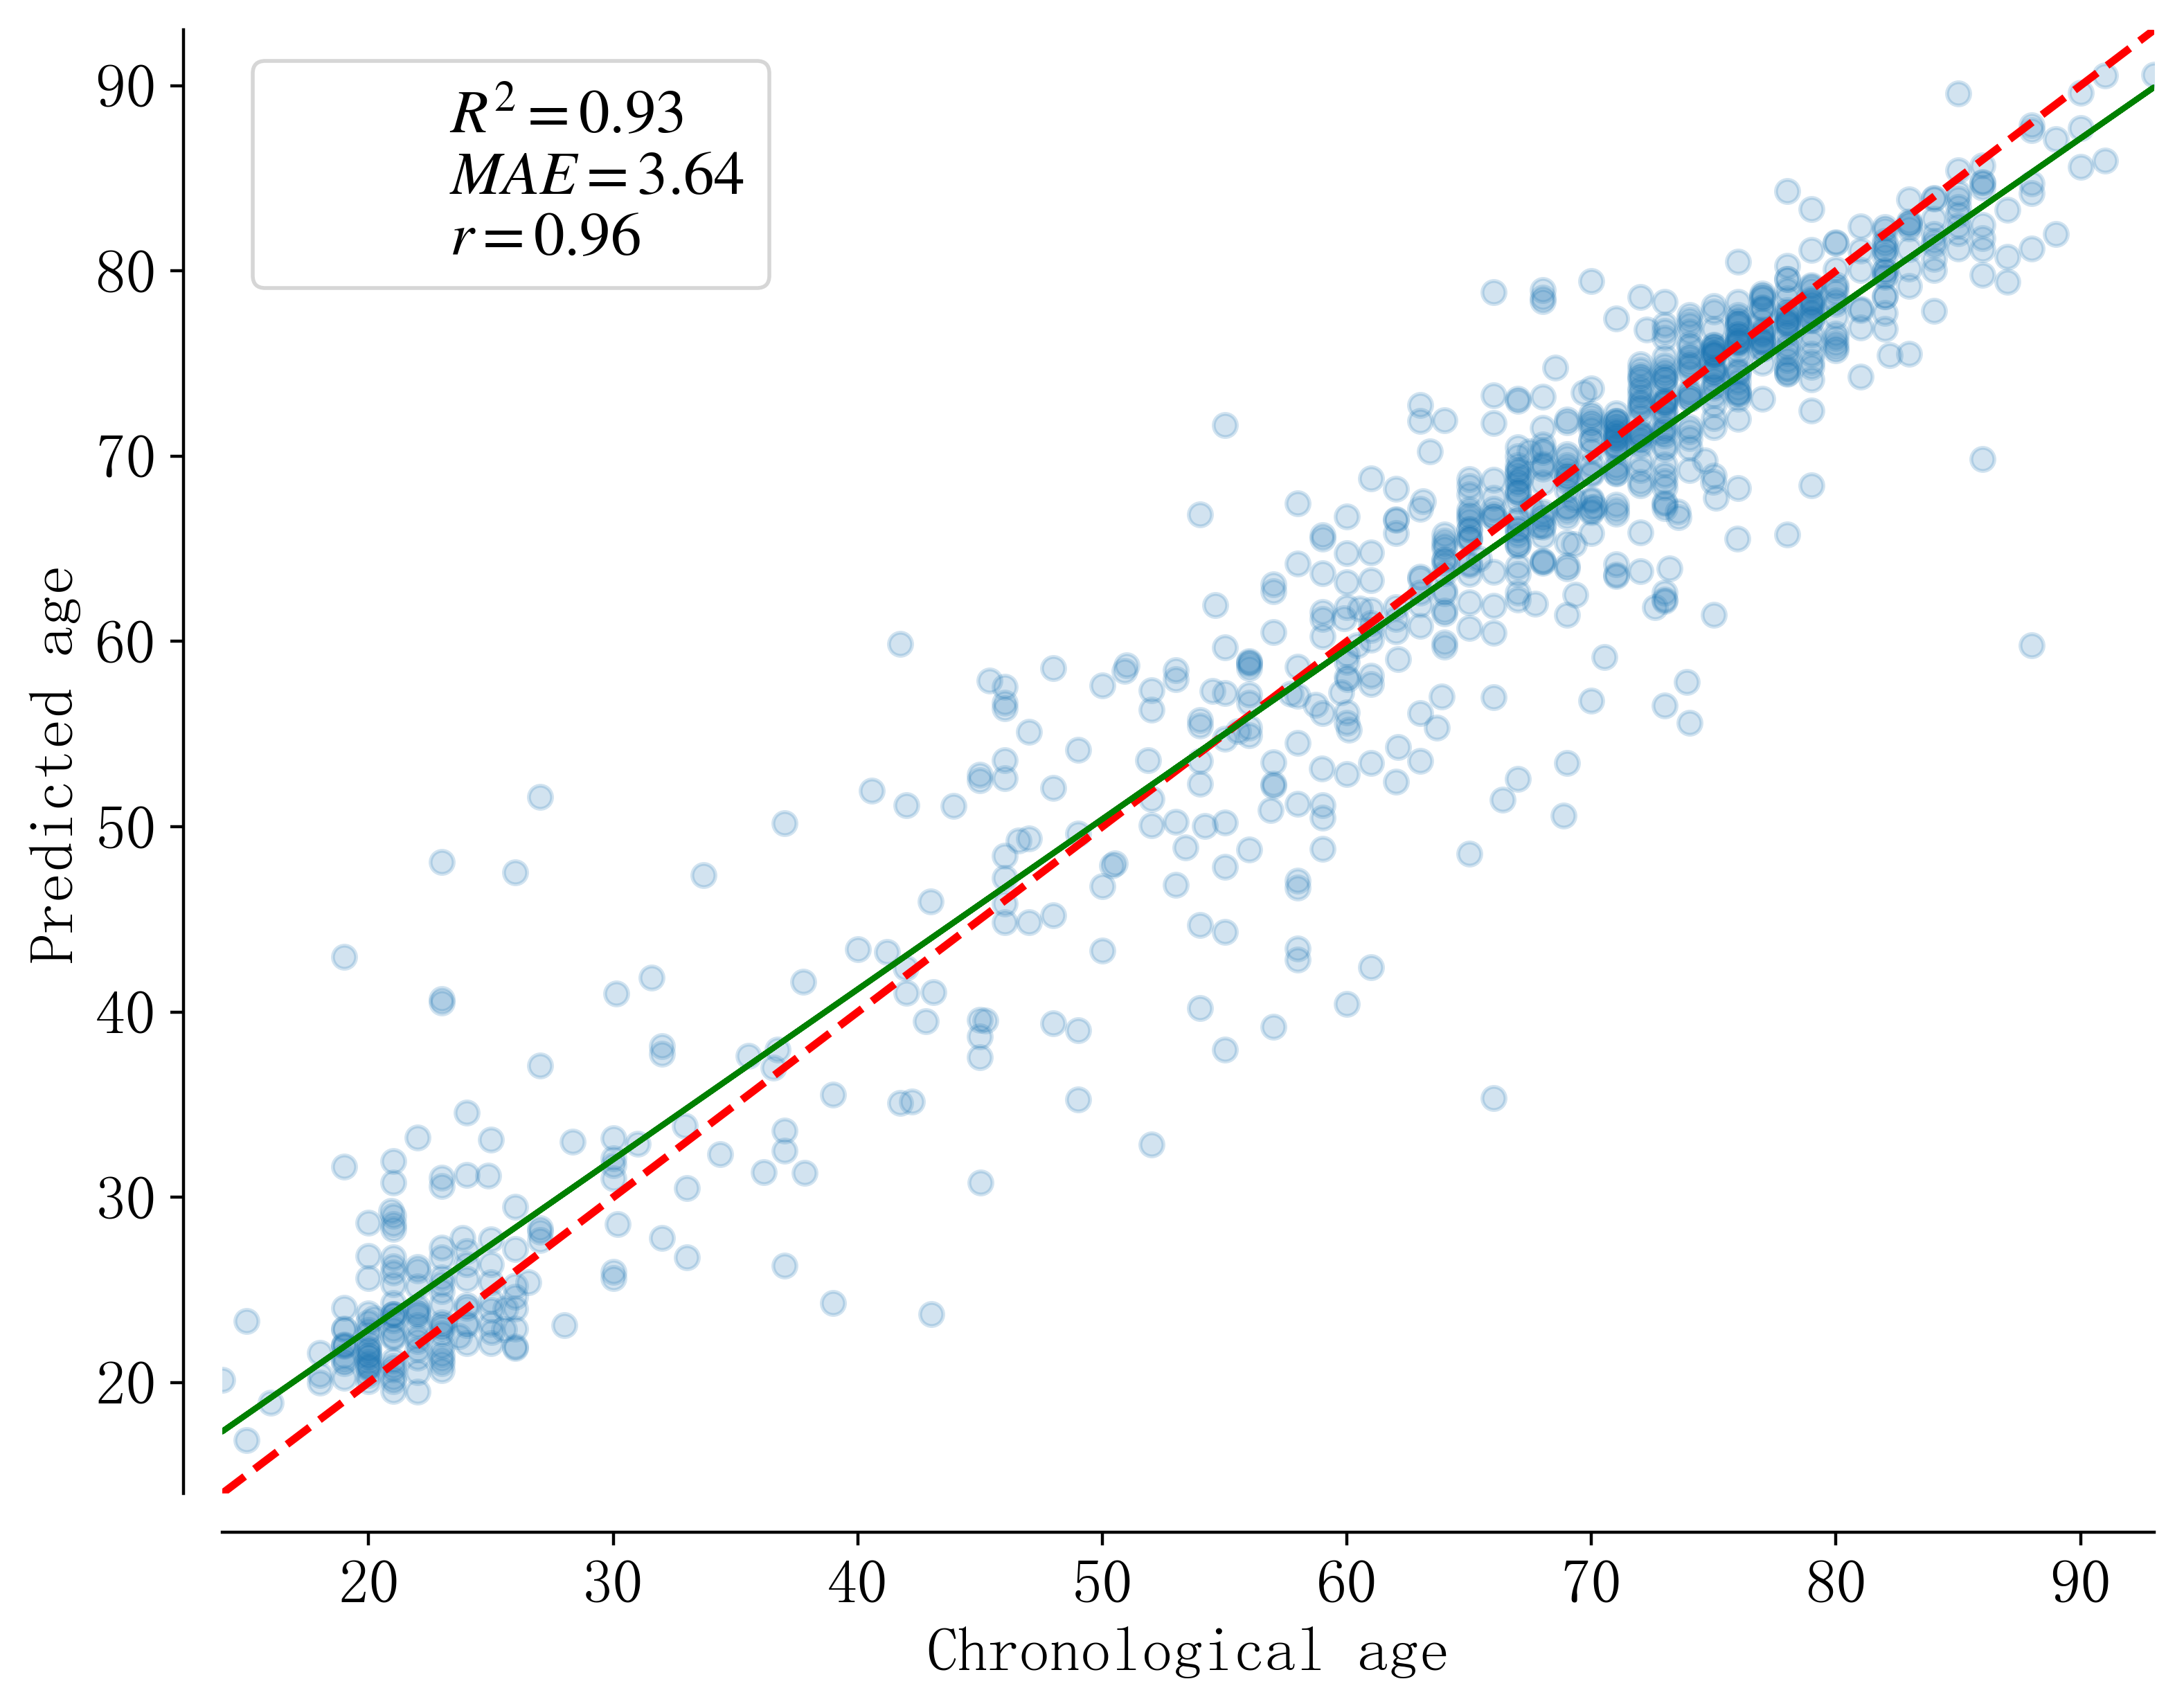

In [95]:
data = pd.read_csv(r"D:\rc\paper\csv\norm_cleaned_rel_volume_test.csv")
data = data.drop(index = data[data['sites']==2].index)
data = data.reset_index(drop=True)
data = data.drop(columns=['sites'])

X_test = data.drop(columns=['name','age'])
y_test = data['age']

data0 = pd.read_csv(r"D:\rc\paper\csv\norm_cleaned_rel_volume_train.csv")
data0 = data0.drop(index = data0[data0['sites']==2].index)
data0 = data0.reset_index(drop=True)
features = data0.drop(columns=['name','age','sex','sites']).columns

data0 = data0.drop(columns=['sites'])
X = data0.drop(columns=['name','age'])
y = pd.DataFrame(data0['age'])

# for fea in features:
#     Max = np.max(X[fea])
#     Min = np.min(X[fea])
#     X[fea] = MinMaxNormalization(X[fea], Max, Min)
#     X_test[fea] = MinMaxNormalization(X_test[fea], Max, Min)


model = xgb.XGBRegressor(learning_rate=0.01, n_estimators=6000, max_depth=7, min_child_weight=1, seed=0,
                            subsample=0.8, colsample_bytree=1, gamma=0, reg_alpha=0, reg_lambda=1)
model.fit(X, y)
y_pred = model.predict(X_test)

print("Pearson:",np.corrcoef(np.array([y_test,y_pred])))
# df = pd.DataFrame()
# df['y_true'] = y_test
# df['y_pred'] = y_pred
# df.to_csv(r"D:\rc\毕设\CSV\prediction.csv", index=False)
fig, axs = plt.subplots(1, 1, figsize=(9, 7), dpi=400) 
axs = np.ravel(axs)
for ax in axs:                                                                                    
    score1 = r2_score(y_test, y_pred)                                                              
    score2 = mean_absolute_error(y_test, y_pred)                                                   
    plot_regression_results(ax, y_test, y_pred,                                               
                            (r'$R^2={:.2f}$' + '\n' + r'$MAE={:.2f}$'+ '\n' + r'$r={:.2f}$').format(score1, score2, 0.9644))     

# plt.title('模型测试结果', fontsize=16) 
def Fun(x,a1,a2):                   # 定义拟合函数形式
    return a1*x+a2
x = y_test       # 创建时间序列
a1,a2 = [1,5]              # 原始数据的参数
y = y_pred
para,pcov=curve_fit(Fun,x,y)
y_fitted = Fun(x,para[0],para[1]) # 画出拟合后的曲线
plt.plot(x,y_fitted,'-g', label ='Fitted curve') 
print(para)                                                           
# plt.tight_layout()                                                                                          
# plt.subplots_adjust(top=0.9)                                                                                
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Chronological age',fontsize=16)
plt.ylabel('Predicted age',fontsize=16)
plt.savefig(r"D:\rc\paper\fig\model.png", dpi=400)
plt.show()                 

The mean age of sMCI : 76.10144927536231
The mean age of pMCI : 76.953125
The tukey HSD between sMCI and pMCI : 0.4767259255100339


C:\Users\Lenovo\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


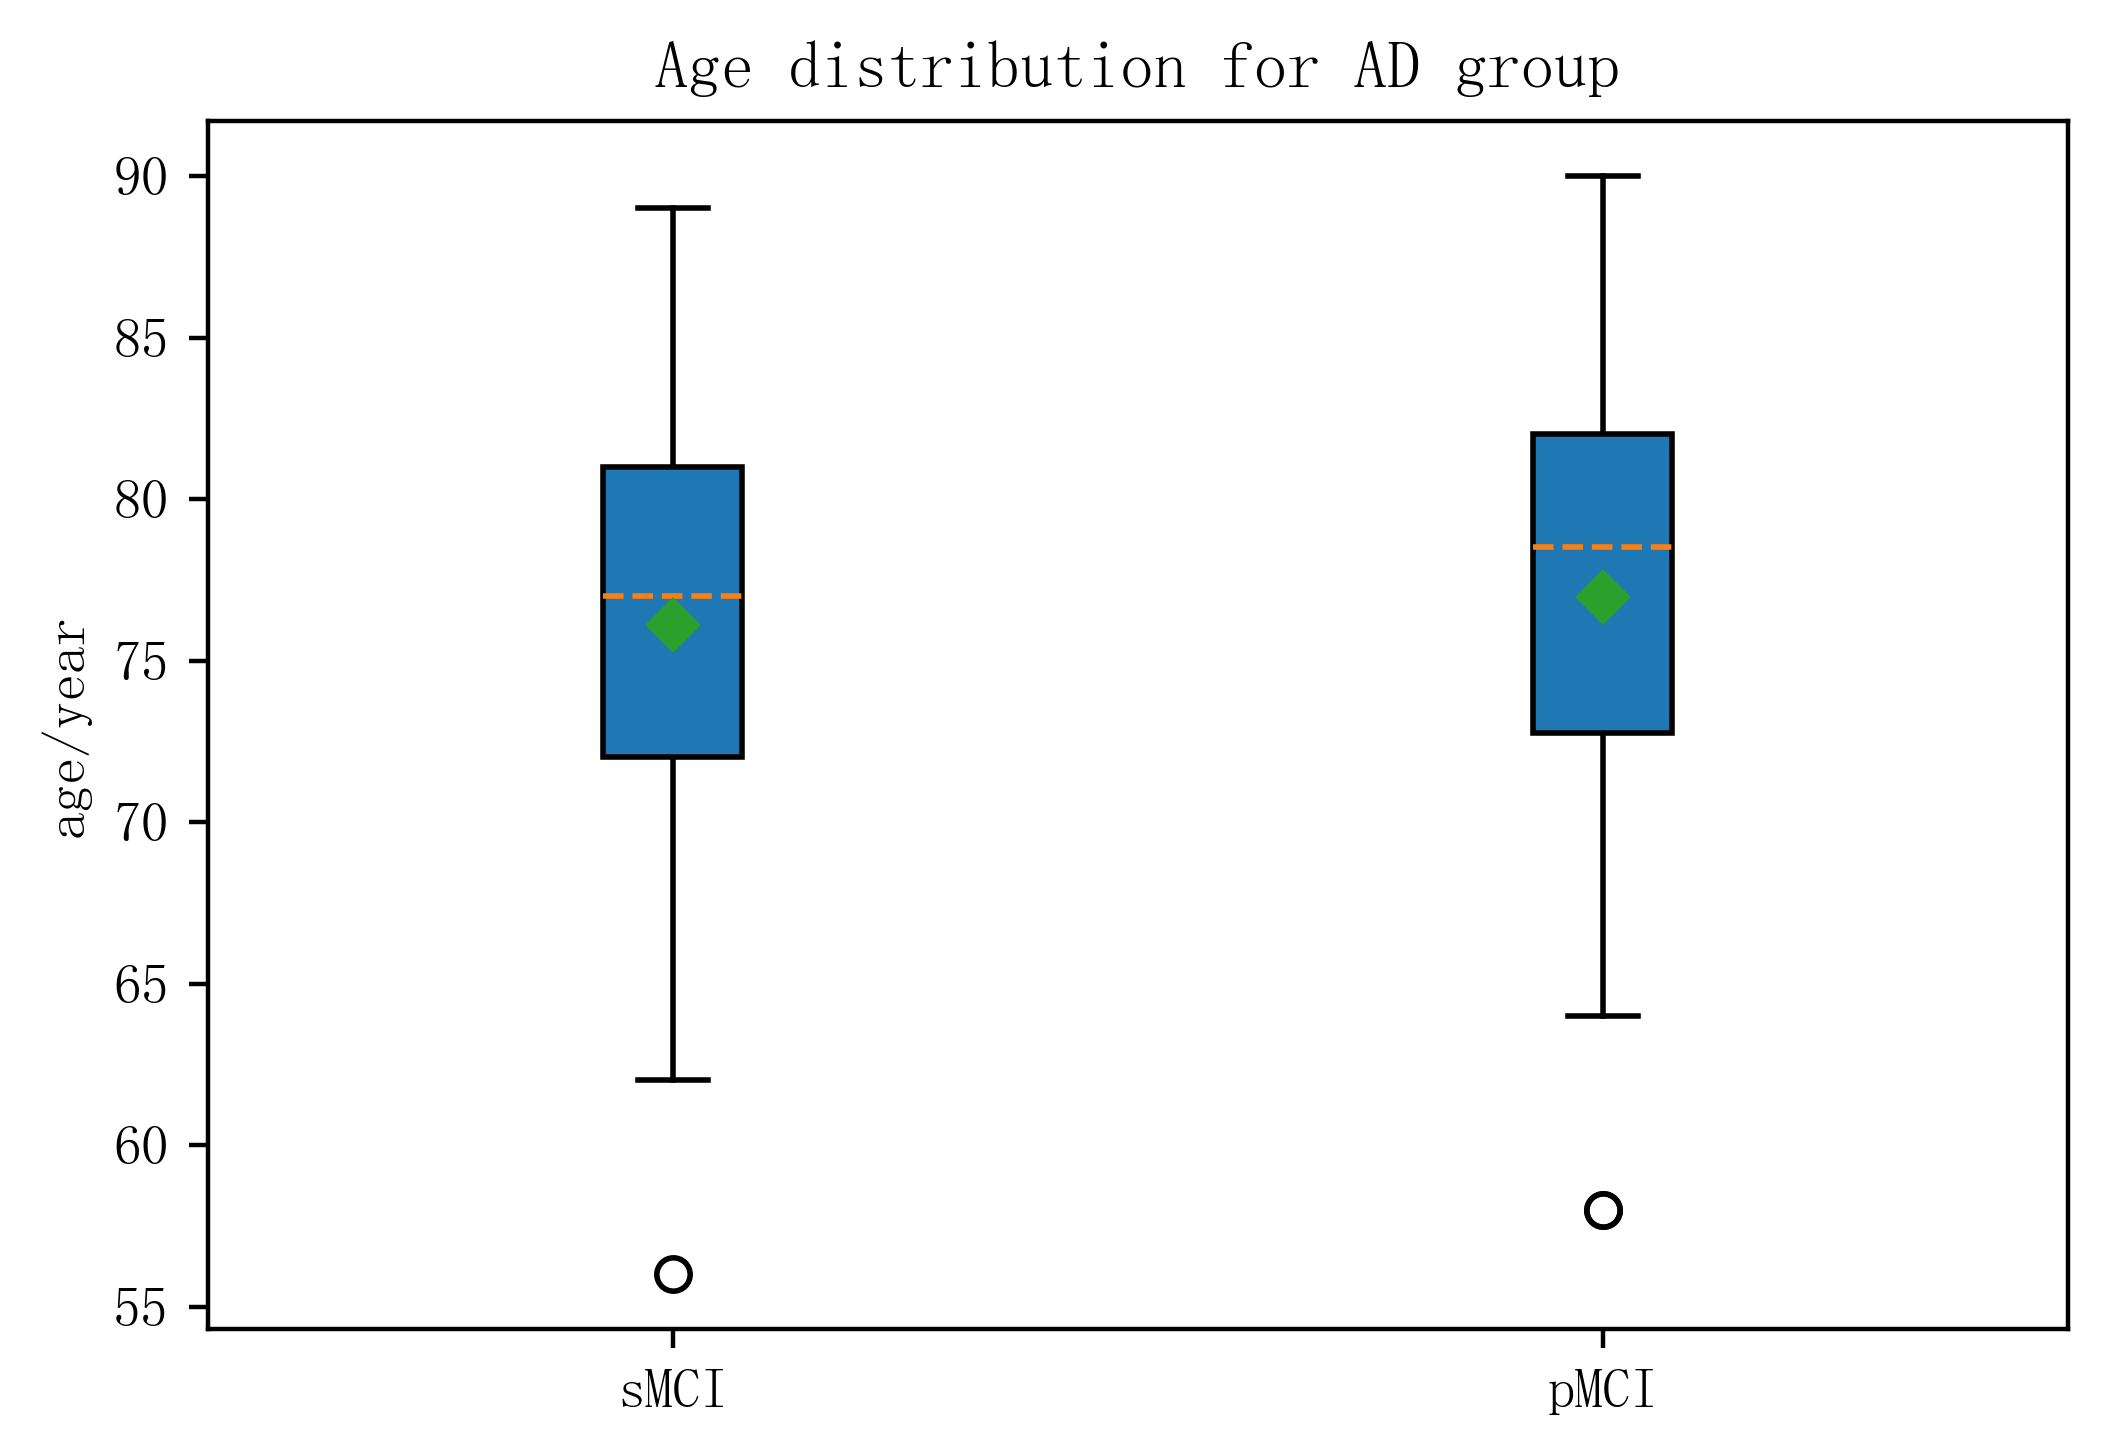

In [5]:
config = {
    "font.family":'serif',
    "font.size": 10,
    "mathtext.fontset": 'stix',
    "font.serif": ['SimSun'],

}
mpl.rcParams.update(config)
data1 = pd.read_csv(r"D:\rc\paper\csv\data5\sMCI_1styear.csv")
data2 = pd.read_csv(r"D:\rc\paper\csv\data5\pMCI_1yearsbefore.csv")

# data1 = data1.sort_values(by=['age'], ascending=True)
# data1 = data1.reset_index(drop=True)
# data1 = data1.drop(index=range(15))
# data2 = data2.sort_values(by=['age'], ascending=True)
# data2 = data2.reset_index(drop=True)
# data2 = data2.drop(index=range(50))
# data3 = data3.sort_values(by=['age'], ascending=True)
# data3 = data3.reset_index(drop=True)
# data3 = data3.drop(index=range(110))

# data1.to_csv(r"D:\rc\paper\csv\data3\filter_sMCI.csv", index=False)
# data2.to_csv(r"D:\rc\paper\csv\data3\filter_pMCI.csv", index=False)
# # data3.to_csv(r"D:\rc\paper\csv\new_data1\filter_PD_baseline.csv", index=False)


HC = data1['age']
PD = data2['age']

data = pd.DataFrame()
data['sMCI'] = HC
data['pMCI'] = PD

# plt.figure(dpi=400)
# sns.kdeplot(data['sMCI'], shade=True, color='g')
# sns.kdeplot(data['pMCI'], shade=True, color='r')
# plt.title('Age distribution for AD group')
# plt.show()


print("The mean age of sMCI :", np.mean(HC))
print("The mean age of pMCI :", np.mean(PD))

print("The tukey HSD between sMCI and pMCI :", get_p(HC,PD))

plt.figure(dpi=400)
plt.boxplot(x = [HC,PD], # 指定绘图数据
            patch_artist=True, # 要求用自定义颜色填充盒形图，默认白色填充
            labels=['sMCI','pMCI'],
            showmeans=True, # 以点的形式显示均值
            boxprops = {'color':'black'}, # 设置箱体属性，填充色和边框色
            flierprops = {'marker':'o'}, # 设置异常值属性，点的形状、填充色和边框色
            meanprops = {'marker':'D'}, # 设置均值点的属性，点的形状、填充色
            medianprops = {'linestyle':'--'}) # 设置中位数线的属性，线的类型和颜色
 
# 去除箱线图的上边框与右边框的刻度标签
plt.title('Age distribution for AD group')
plt.tick_params(top='off', right='off')
# plt.title('age',fontsize=11)
# plt.xticks(fontsize=11)
# plt.yticks(fontsize=11)
# plt.xlabel('实际年龄', fontsize=15)
plt.ylabel('age/year')
# plt.subplots_adjust(left=0.15)
# plt.legend(fontsize=20)
# plt.savefig(r"D:\rc\paper\figure1\fig2.png", dpi=400)
plt.show()                 

The mean gap of sMCI : -0.4504245813342108 6.259352074870036
The mean gap of pMCI : 1.4810007214546204 5.5225239146208205
The tukey HSD between sMCI and pMCI : 0.06414578356575806


C:\Users\Lenovo\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


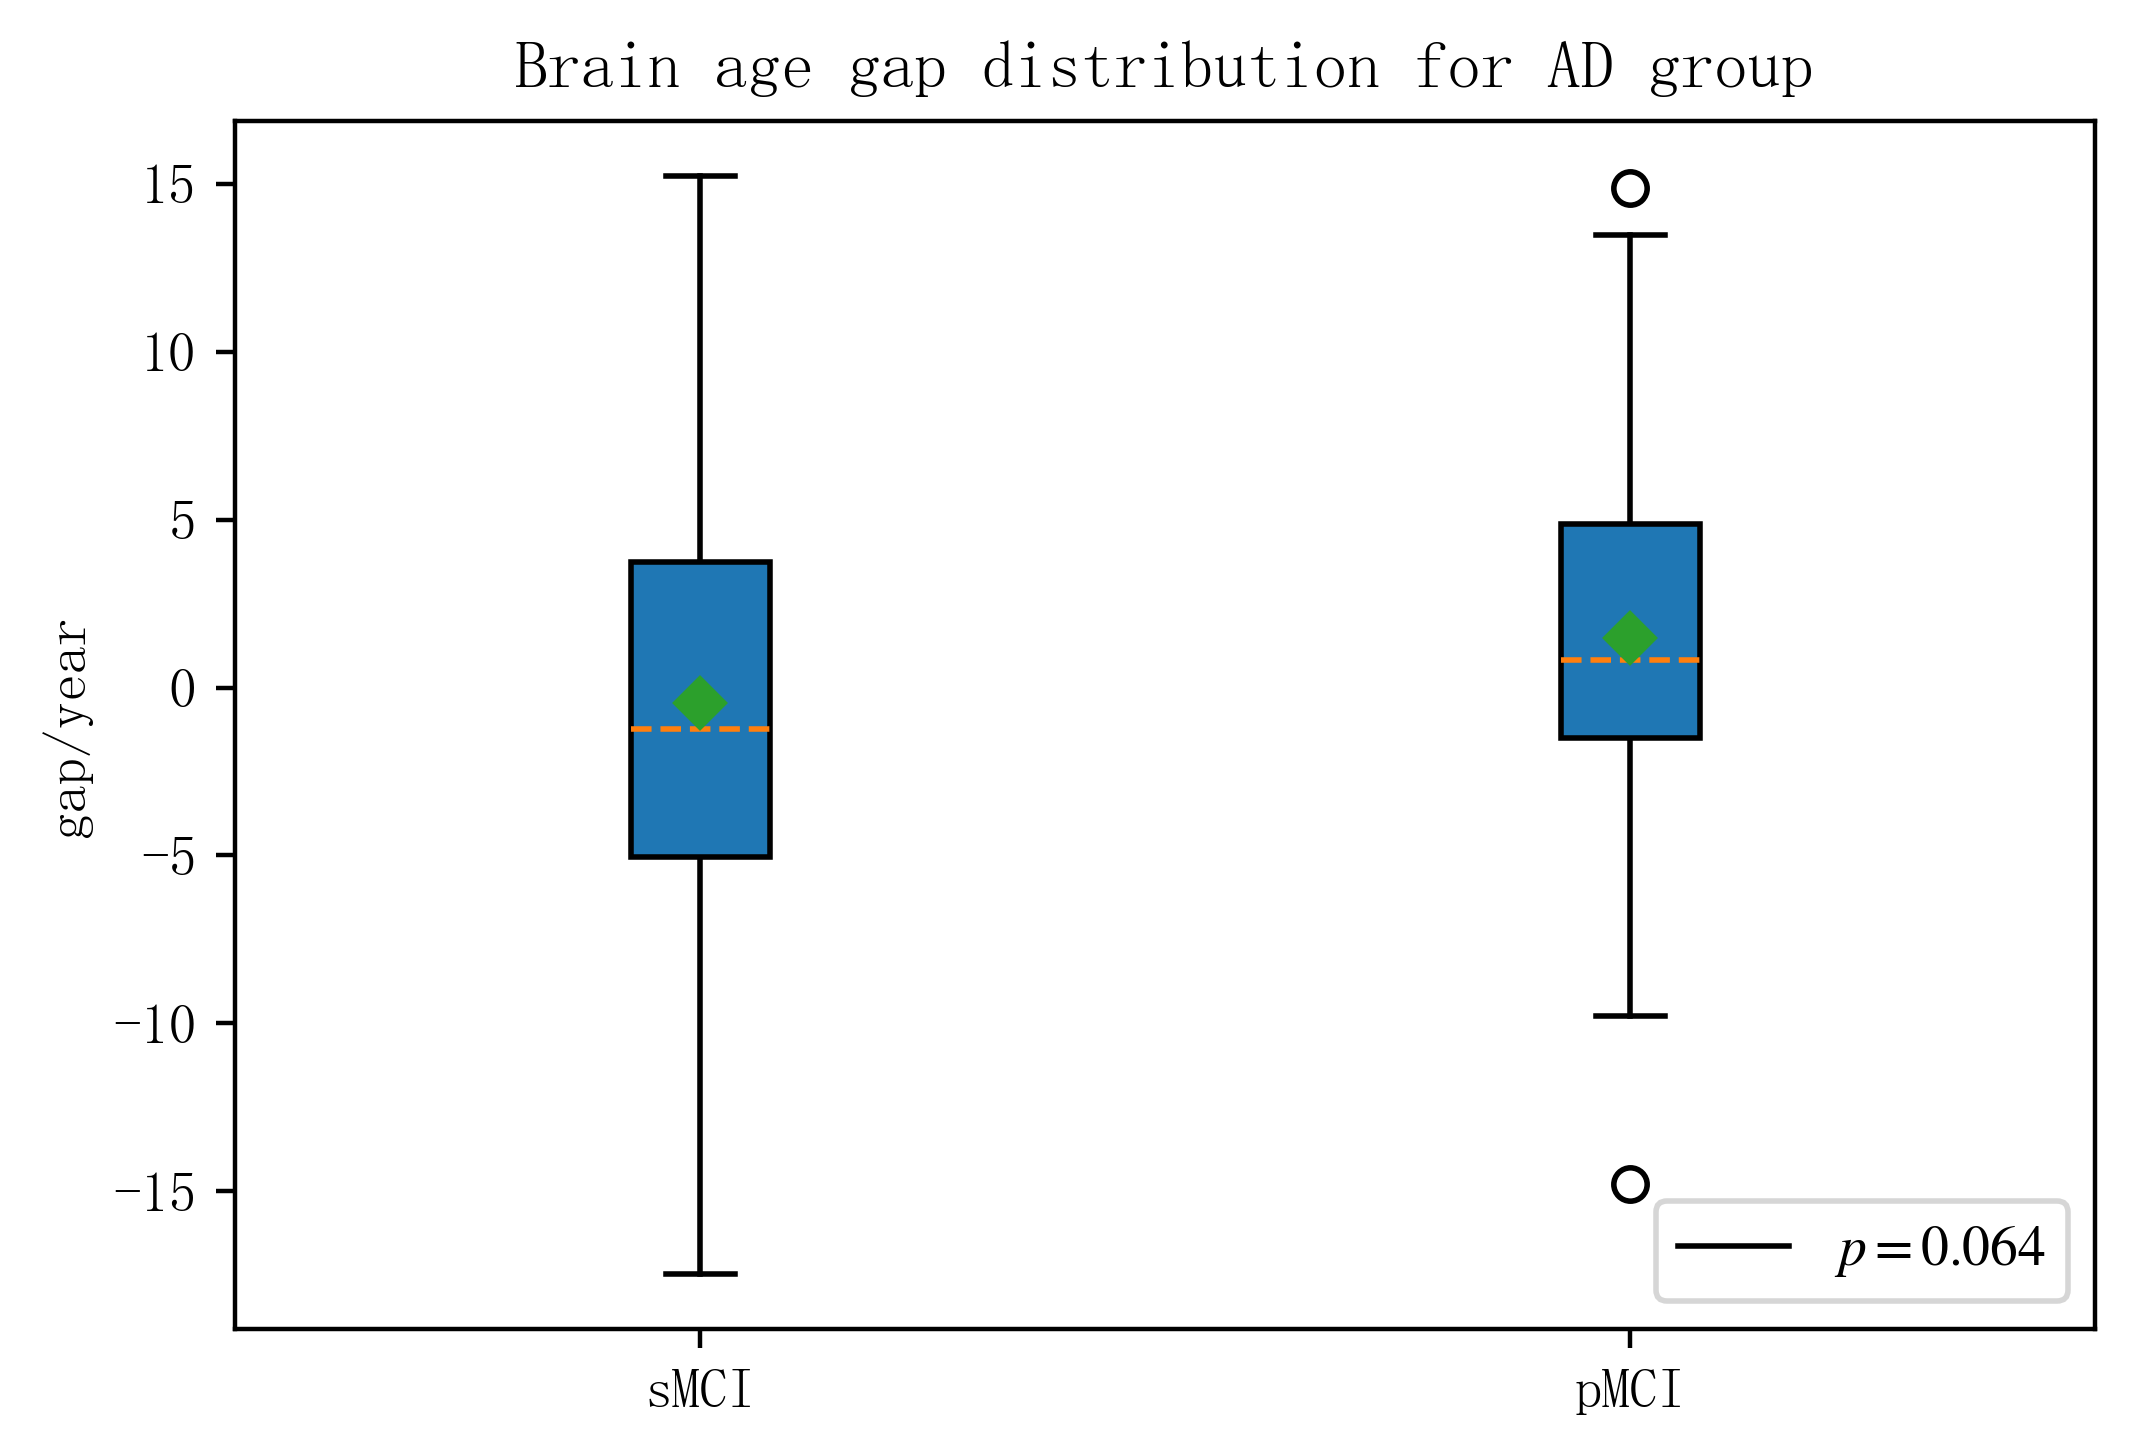

In [8]:
###########################HC/RBD/PD脑龄预测
config = {
    "font.family":'serif',
    "font.size": 10,
    "mathtext.fontset": 'stix',
    "font.serif": ['SimSun'],

}
mpl.rcParams.update(config)


data1 = pd.read_csv(r"D:\rc\paper\csv\data5\sMCI_1styear.csv")
data2 = pd.read_csv(r"D:\rc\paper\csv\data5\pMCI_1yearsbefore.csv")

data_ls = [data1,data2]

for data in data_ls:
    X_test = data.drop(columns=['name','age'])
    y_test = data['age']
#     y_pred = np.zeros(len(y_test))
    model = joblib.load(r"D:\rc\paper\model\nonorm_paper_model_corr.m")
    y_pred = model.predict(X_test)
#     y_pred = y_pred + y_pre
    data['bias'] = y_pred - y_test

HC = data_ls[0]['bias']
PD = data_ls[1]['bias']

data = pd.DataFrame()
data['sMCI'] = HC
data['pMCI'] = PD

# plt.figure(dpi=400)
# sns.kdeplot(data['sMCI'], shade=True, color='g')
# sns.kdeplot(data['pMCI'], shade=True, color='r')
# plt.title('Brain age gap distribution for AD group')
# plt.show()

print("The mean gap of sMCI :", np.mean(HC), np.std(HC))
print("The mean gap of pMCI :", np.mean(PD), np.std(PD))

print("The tukey HSD between sMCI and pMCI :", get_p(HC,PD))

plt.figure(dpi=400)
plt.boxplot(x = [HC,PD], # 指定绘图数据
            patch_artist=True, # 要求用自定义颜色填充盒形图，默认白色填充
            labels=['sMCI','pMCI'],
            showmeans=True, # 以点的形式显示均值
            boxprops = {'color':'black'}, # 设置箱体属性，填充色和边框色
            flierprops = {'marker':'o'}, # 设置异常值属性，点的形状、填充色和边框色
            meanprops = {'marker':'D'}, # 设置均值点的属性，点的形状、填充色
            medianprops = {'linestyle':'--'}) # 设置中位数线的属性，线的类型和颜色
 
# 去除箱线图的上边框与右边框的刻度标签
plt.title('Brain age gap distribution for AD group')
plt.tick_params(top='off', right='off')
# plt.title('brain age gap',fontsize=11)
# plt.xticks(fontsize=11)
# plt.yticks(fontsize=11)
# plt.xlabel('实际年龄', fontsize=15)
plt.ylabel('gap/year')
# plt.subplots_adjust(left=0.15)
# plt.legend(fontsize=20)
# plt.savefig(r"D:\rc\paper\figure1\fig2.png", dpi=400)
plt.legend([(r'$p={:.3f}$').format(get_p(HC,PD))])
plt.show()                 

C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:83: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:83: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:83: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:83: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:83: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:83: DeprecationWarning: scipy.interp is depr

ACC = 0.5264 ± 0.0939
SEN = 0.3452 ± 0.1533
SPE = 0.6929 ± 0.1918
AUC = 0.5799 ± 0.0635
ACC = 0.5918 ± 0.1400
SEN = 0.5000 ± 0.1872
SPE = 0.6786 ± 0.1728
AUC = 0.6388 ± 0.1755
ACC = 0.7357 ± 0.1059
SEN = 0.7452 ± 0.1730
SPE = 0.7190 ± 0.2025
AUC = 0.7935 ± 0.1225


C:\Users\Lenovo\Anaconda3\lib\site-packages\matplotlib\figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


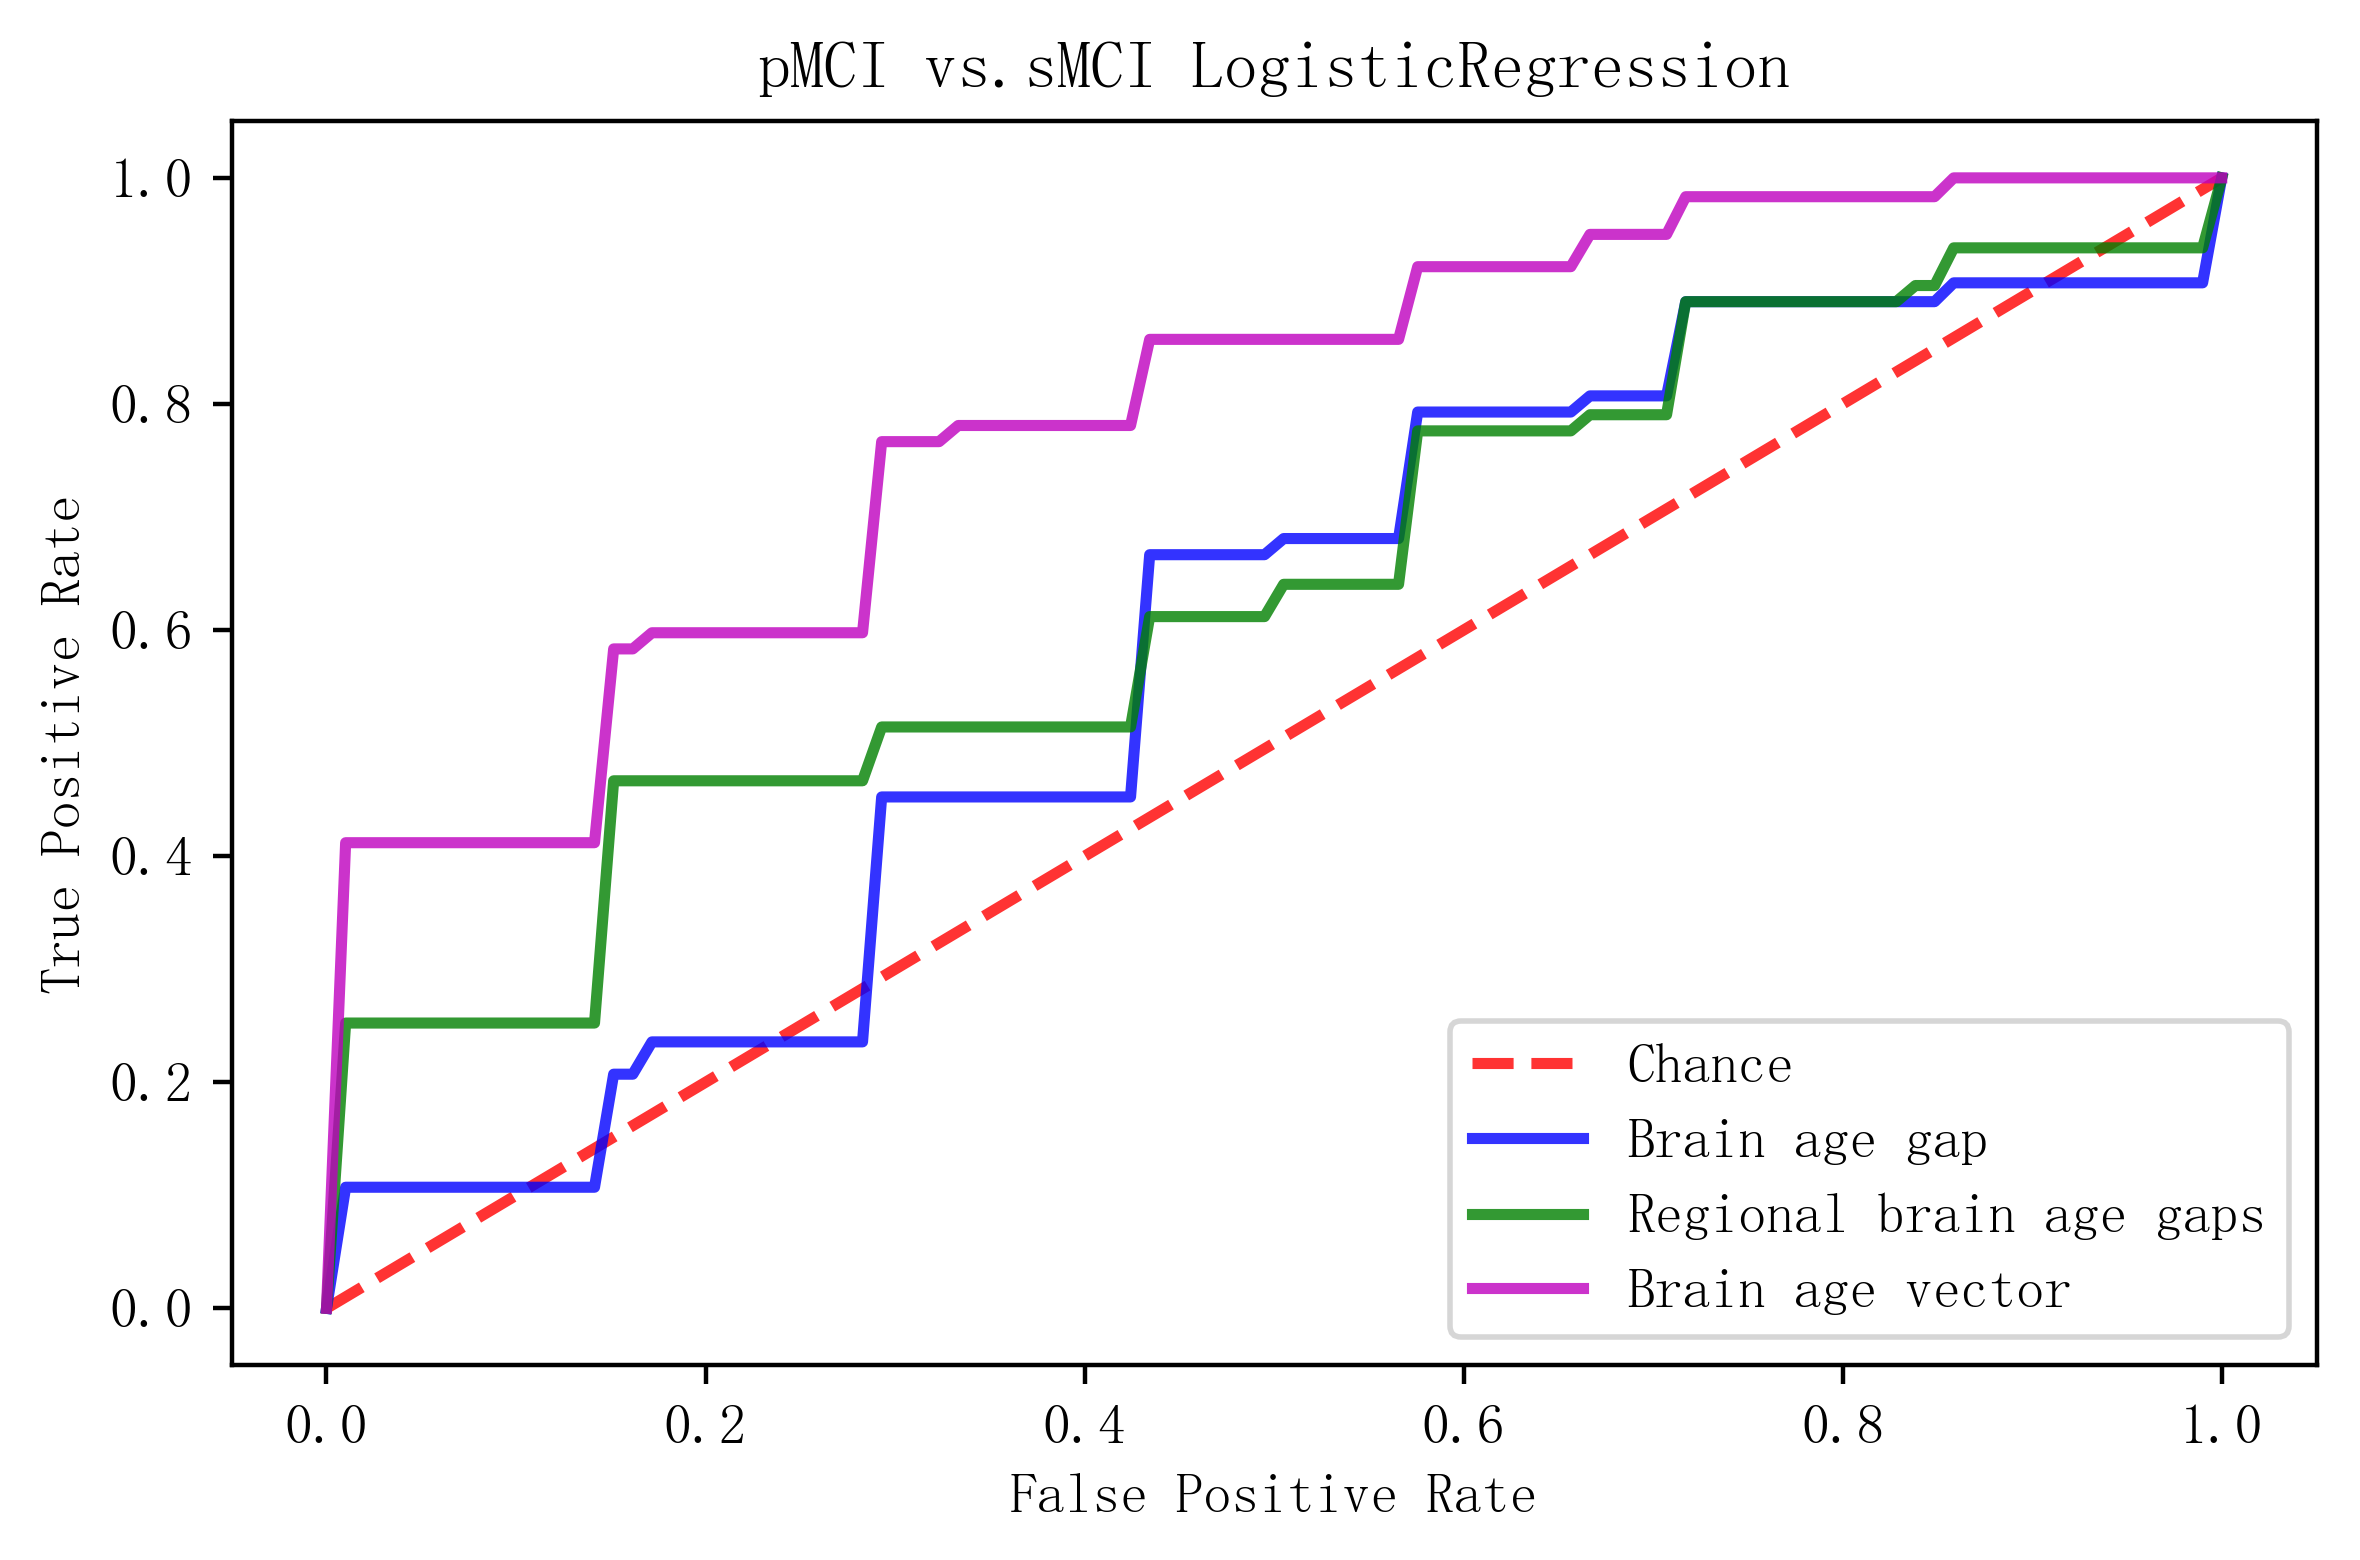

In [22]:
config = {
    "font.family":'serif',
    "font.size": 10,
    "mathtext.fontset": 'stix',
    "font.serif": ['SimSun'],

}
mpl.rcParams.update(config)


data1 = pd.read_csv(r"D:\rc\paper\csv\data5\shap_values_pMCI.csv")
data2 = pd.read_csv(r"D:\rc\paper\csv\data5\pMCI_1yearsbefore.csv")
data3 = pd.read_csv(r"D:\rc\paper\csv\data5\shap_values_sMCI.csv")
data4 = pd.read_csv(r"D:\rc\paper\csv\data5\sMCI_1styear.csv")
data1['age'] = data2['age']
data3['age'] = data4['age']
data1['label'] = 1
data3['label'] = 0
data0 = pd.concat([data1,data3]).reset_index(drop=True)

y2 = data0.loc[:,'label']
X2 = data0.drop(columns=['label']).fillna(0)

gaps0 = pd.read_csv(r"D:\rc\paper\csv\data5\gap_sMCI.csv")
gaps1 = pd.read_csv(r"D:\rc\paper\csv\data5\gap_pMCI.csv")
gaps0['age'] = data4['age']
gaps0['sex'] = data4['sex']
gaps1['age'] = data2['age']
gaps1['sex'] = data2['sex']
gaps0['label'] = 0
gaps1['label'] = 1

gaps = pd.concat([gaps0,gaps1]).reset_index(drop=True)

y = gaps.loc[:,'label']
y1 = gaps.loc[:,'label']
use = ['bias','sex','age']
X = gaps[use]
X1 = gaps.drop(columns=['bias','name','label'])


cv = StratifiedKFold(n_splits=10)
classifier = lr(max_iter=2000)
classifier1 = lr(max_iter=2000)
classifier2 = lr(max_iter=2000)
# classifier = xgb.XGBClassifier()
# classifier1 = xgb.XGBClassifier()
# classifier = GaussianNB()
# classifier1 = GaussianNB()


tprs = []
aucs = []

accs = []
sens = []
spes = []
aucss = []

mean_fpr = np.linspace(0, 1, 100)

for train, test in cv.split(X, y):
    features = X.drop(columns=['sex']).columns
    X_train = X.loc[train,:]
    X_test = X.loc[test,:]
    
    for fea in features:
        max = np.max(X_train[fea])
        min = np.min(X_train[fea])
        X_train[fea] = MinMaxNormalization(X_train[fea], max, min)
        X_test[fea] = MinMaxNormalization(X_test[fea], max, min)
        
    enc = OneHotEncoder()
    enc.fit(X_train['sex'].values.reshape(-1, 1))
    X_train['sex'] = enc.transform(X_train['sex'].values.reshape(-1, 1)).toarray()
    X_test['sex'] = enc.transform(X_test['sex'].values.reshape(-1, 1)).toarray()
    
    model = classifier.fit(X_train, y[train])
    probas_ = model.predict_proba(X_test)
    y_pred = model.predict(X_test)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    accs.append(accuracy_score(y[test],y_pred))
    sens.append(recall_score(y[test], y_pred, average='binary'))
    spes.append(get_spe(y[test], y_pred))
    aucss.append(roc_auc_score(y[test], probas_[:, 1]))
#     plt.plot(fpr, tpr, lw=1, alpha=0.3,
#              label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))


tprs1 = []
aucs1 = []

accs1 = []
sens1 = []
spes1 = []
aucss1 = []

mean_fpr1 = np.linspace(0, 1, 100)
    
for train, test in cv.split(X1, y1):
    features = X1.columns
    X1_train = X1.loc[train,:]
    X1_test = X1.loc[test,:]
    
    for fea in features:
        max = np.max(X1_train[fea])
        min = np.min(X1_train[fea])
        X1_train[fea] = MinMaxNormalization(X1_train[fea], max, min)
        X1_test[fea] = MinMaxNormalization(X1_test[fea], max, min)
    
    enc = OneHotEncoder()
    enc.fit(X1_train['sex'].values.reshape(-1, 1))
    X1_train['sex'] = enc.transform(X1_train['sex'].values.reshape(-1, 1)).toarray()
    X1_test['sex'] = enc.transform(X1_test['sex'].values.reshape(-1, 1)).toarray()
    
    model1 = classifier1.fit(X1_train, y1[train])
    probas_ = model1.predict_proba(X1_test)
    y_pred = model1.predict(X1_test)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y1[test], probas_[:, 1])
    tprs1.append(interp(mean_fpr1, fpr, tpr))
    tprs1[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs1.append(roc_auc)
    accs1.append(accuracy_score(y1[test],y_pred))
    sens1.append(recall_score(y1[test], y_pred, average='binary'))
    spes1.append(get_spe(y1[test], y_pred))
    aucss1.append(roc_auc_score(y1[test], probas_[:, 1]))
#     plt.plot(fpr, tpr, lw=1, alpha=0.3,
#              label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))


tprs2 = []
aucs2 = []

accs2 = []
sens2 = []
spes2 = []
aucss2 = []

mean_fpr2 = np.linspace(0, 1, 100)
    
for train, test in cv.split(X2, y2):
    features = X2.columns
    X2_train = X2.loc[train,:]
    X2_test = X2.loc[test,:]
    
    for fea in features:
        max = np.max(X2_train[fea])
        min = np.min(X2_train[fea])
        X2_train[fea] = MinMaxNormalization(X2_train[fea], max, min)
        X2_test[fea] = MinMaxNormalization(X2_test[fea], max, min)
    
    model2 = classifier2.fit(X2_train, y2[train])
    probas_ = model2.predict_proba(X2_test)
    y_pred = model2.predict(X2_test)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y2[test], probas_[:, 1])
    tprs2.append(interp(mean_fpr2, fpr, tpr))
    tprs2[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs2.append(roc_auc)
    accs2.append(accuracy_score(y2[test],y_pred))
    sens2.append(recall_score(y2[test], y_pred, average='binary'))
    spes2.append(get_spe(y2[test], y_pred))
    aucss2.append(roc_auc_score(y2[test], probas_[:, 1]))
#     plt.plot(fpr, tpr, lw=1, alpha=0.3,
#              label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))


plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_tpr1 = np.mean(tprs1, axis=0)
mean_tpr1[-1] = 1.0
mean_tpr2 = np.mean(tprs2, axis=0)
mean_tpr1[-1] = 1.0


# mean_auc = auc(mean_fpr, mean_tpr)
# std_auc = np.std(aucs)
print('ACC = %0.4f ± %0.4f' % (np.mean(accs),np.std(accs)))
print('SEN = %0.4f ± %0.4f' % (np.mean(sens),np.std(sens)))
print('SPE = %0.4f ± %0.4f' % (np.mean(spes),np.std(spes)))
print('AUC = %0.4f ± %0.4f' % (np.mean(aucss),np.std(aucss)))
print('ACC = %0.4f ± %0.4f' % (np.mean(accs1),np.std(accs1)))
print('SEN = %0.4f ± %0.4f' % (np.mean(sens1),np.std(sens1)))
print('SPE = %0.4f ± %0.4f' % (np.mean(spes1),np.std(spes1)))
print('AUC = %0.4f ± %0.4f' % (np.mean(aucss1),np.std(aucss1)))
print('ACC = %0.4f ± %0.4f' % (np.mean(accs2),np.std(accs2)))
print('SEN = %0.4f ± %0.4f' % (np.mean(sens2),np.std(sens2)))
print('SPE = %0.4f ± %0.4f' % (np.mean(spes2),np.std(spes2)))
print('AUC = %0.4f ± %0.4f' % (np.mean(aucss2),np.std(aucss2)))


plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Brain age gap',
         lw=2, alpha=.8)
plt.plot(mean_fpr1, mean_tpr1, color='g',
         label=r'Regional brain age gaps',
         lw=2, alpha=.8)
plt.plot(mean_fpr2, mean_tpr2, color='m',
         label=r'Brain age vector',
         lw=2, alpha=.8)
# std_tpr = np.std(tprs, axis=0)
# tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
# tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
# plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
#                  label=r'$\pm$ 1 std. dev.')

plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.dpi'] = 400
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('pMCI vs.sMCI LogisticRegression')
plt.legend(loc="lower right")
plt.savefig(r"D:\rc\paper\fig\AD_lr.png", dpi=400)
plt.show()    
    


C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:83: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:83: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:83: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:83: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:83: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:83: DeprecationWarning: scipy.interp is depr

ACC = 0.5632 ± 0.0849
SEN = 0.5595 ± 0.1929
SPE = 0.5619 ± 0.2379
AUC = 0.5476 ± 0.1028
ACC = 0.5698 ± 0.1108
SEN = 0.7119 ± 0.1414
SPE = 0.4310 ± 0.1882
AUC = 0.5527 ± 0.1469
ACC = 0.6544 ± 0.1075
SEN = 0.7024 ± 0.1737
SPE = 0.6048 ± 0.1580
AUC = 0.7405 ± 0.1492


C:\Users\Lenovo\Anaconda3\lib\site-packages\matplotlib\figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


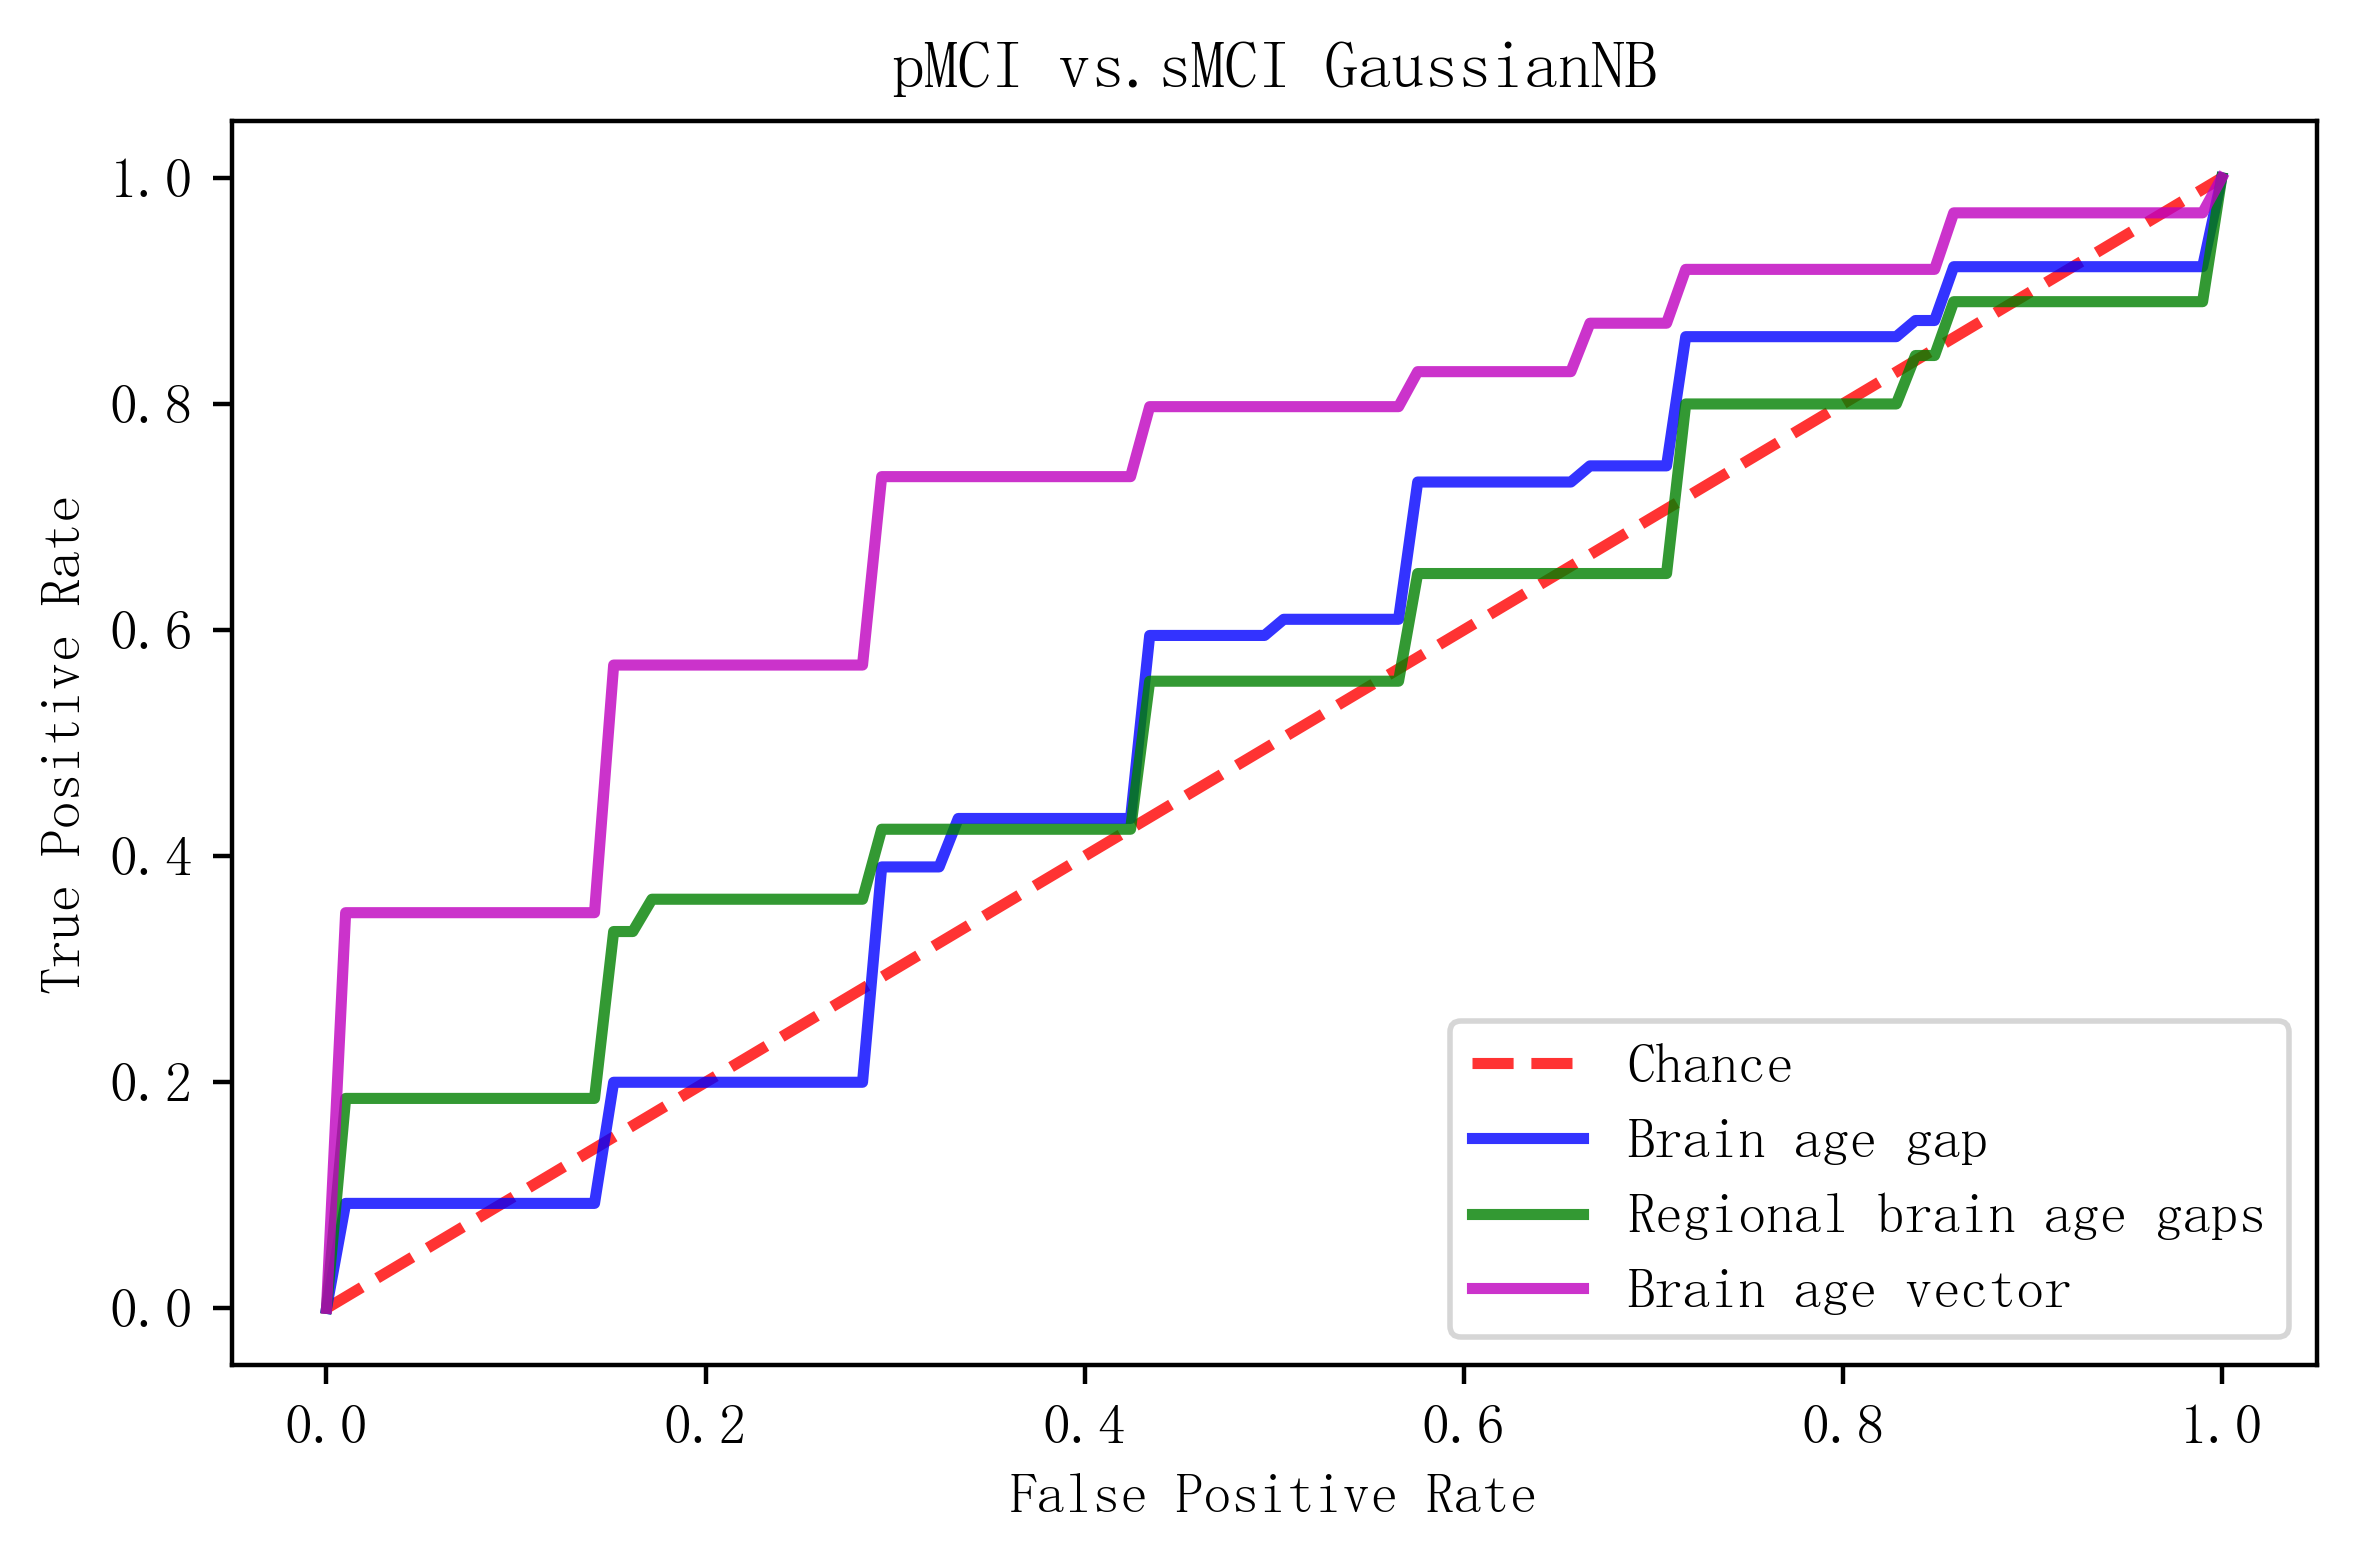

In [20]:
config = {
    "font.family":'serif',
    "font.size": 10,
    "mathtext.fontset": 'stix',
    "font.serif": ['SimSun'],

}
mpl.rcParams.update(config)


data1 = pd.read_csv(r"D:\rc\paper\csv\data5\shap_values_pMCI.csv")
data2 = pd.read_csv(r"D:\rc\paper\csv\data5\pMCI_1yearsbefore.csv")
data3 = pd.read_csv(r"D:\rc\paper\csv\data5\shap_values_sMCI.csv")
data4 = pd.read_csv(r"D:\rc\paper\csv\data5\sMCI_1styear.csv")
data1['age'] = data2['age']
data3['age'] = data4['age']
data1['label'] = 1
data3['label'] = 0
data0 = pd.concat([data1,data3]).reset_index(drop=True)

y2 = data0.loc[:,'label']
X2 = data0.drop(columns=['label']).fillna(0)

gaps0 = pd.read_csv(r"D:\rc\paper\csv\data5\gap_sMCI.csv")
gaps1 = pd.read_csv(r"D:\rc\paper\csv\data5\gap_pMCI.csv")
gaps0['age'] = data4['age']
gaps0['sex'] = data4['sex']
gaps1['age'] = data2['age']
gaps1['sex'] = data2['sex']
gaps0['label'] = 0
gaps1['label'] = 1

gaps = pd.concat([gaps0,gaps1]).reset_index(drop=True)

y = gaps.loc[:,'label']
y1 = gaps.loc[:,'label']
use = ['bias','sex','age']
X = gaps[use]
X1 = gaps.drop(columns=['bias','name','label'])


cv = StratifiedKFold(n_splits=10)
classifier = GaussianNB()
classifier1 = GaussianNB()
classifier2 = GaussianNB()
# classifier = xgb.XGBClassifier()
# classifier1 = xgb.XGBClassifier()
# classifier = GaussianNB()
# classifier1 = GaussianNB()


tprs = []
aucs = []

accs = []
sens = []
spes = []
aucss = []

mean_fpr = np.linspace(0, 1, 100)

for train, test in cv.split(X, y):
    features = X.drop(columns=['sex']).columns
    X_train = X.loc[train,:]
    X_test = X.loc[test,:]
    
    for fea in features:
        max = np.max(X_train[fea])
        min = np.min(X_train[fea])
        X_train[fea] = MinMaxNormalization(X_train[fea], max, min)
        X_test[fea] = MinMaxNormalization(X_test[fea], max, min)
        
    enc = OneHotEncoder()
    enc.fit(X_train['sex'].values.reshape(-1, 1))
    X_train['sex'] = enc.transform(X_train['sex'].values.reshape(-1, 1)).toarray()
    X_test['sex'] = enc.transform(X_test['sex'].values.reshape(-1, 1)).toarray()
    
    model = classifier.fit(X_train, y[train])
    probas_ = model.predict_proba(X_test)
    y_pred = model.predict(X_test)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    accs.append(accuracy_score(y[test],y_pred))
    sens.append(recall_score(y[test], y_pred, average='binary'))
    spes.append(get_spe(y[test], y_pred))
    aucss.append(roc_auc_score(y[test], probas_[:, 1]))
#     plt.plot(fpr, tpr, lw=1, alpha=0.3,
#              label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))


tprs1 = []
aucs1 = []

accs1 = []
sens1 = []
spes1 = []
aucss1 = []

mean_fpr1 = np.linspace(0, 1, 100)
    
for train, test in cv.split(X1, y1):
    features = X1.columns
    X1_train = X1.loc[train,:]
    X1_test = X1.loc[test,:]
    
    for fea in features:
        max = np.max(X1_train[fea])
        min = np.min(X1_train[fea])
        X1_train[fea] = MinMaxNormalization(X1_train[fea], max, min)
        X1_test[fea] = MinMaxNormalization(X1_test[fea], max, min)
    
    enc = OneHotEncoder()
    enc.fit(X1_train['sex'].values.reshape(-1, 1))
    X1_train['sex'] = enc.transform(X1_train['sex'].values.reshape(-1, 1)).toarray()
    X1_test['sex'] = enc.transform(X1_test['sex'].values.reshape(-1, 1)).toarray()
    
    model1 = classifier1.fit(X1_train, y1[train])
    probas_ = model1.predict_proba(X1_test)
    y_pred = model1.predict(X1_test)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y1[test], probas_[:, 1])
    tprs1.append(interp(mean_fpr1, fpr, tpr))
    tprs1[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs1.append(roc_auc)
    accs1.append(accuracy_score(y1[test],y_pred))
    sens1.append(recall_score(y1[test], y_pred, average='binary'))
    spes1.append(get_spe(y1[test], y_pred))
    aucss1.append(roc_auc_score(y1[test], probas_[:, 1]))
#     plt.plot(fpr, tpr, lw=1, alpha=0.3,
#              label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))


tprs2 = []
aucs2 = []

accs2 = []
sens2 = []
spes2 = []
aucss2 = []

mean_fpr2 = np.linspace(0, 1, 100)
    
for train, test in cv.split(X2, y2):
    features = X2.columns
    X2_train = X2.loc[train,:]
    X2_test = X2.loc[test,:]
    
    for fea in features:
        max = np.max(X2_train[fea])
        min = np.min(X2_train[fea])
        X2_train[fea] = MinMaxNormalization(X2_train[fea], max, min)
        X2_test[fea] = MinMaxNormalization(X2_test[fea], max, min)
    
    model2 = classifier2.fit(X2_train, y2[train])
    probas_ = model2.predict_proba(X2_test)
    y_pred = model2.predict(X2_test)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y2[test], probas_[:, 1])
    tprs2.append(interp(mean_fpr2, fpr, tpr))
    tprs2[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs2.append(roc_auc)
    accs2.append(accuracy_score(y2[test],y_pred))
    sens2.append(recall_score(y2[test], y_pred, average='binary'))
    spes2.append(get_spe(y2[test], y_pred))
    aucss2.append(roc_auc_score(y2[test], probas_[:, 1]))
#     plt.plot(fpr, tpr, lw=1, alpha=0.3,
#              label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))


plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_tpr1 = np.mean(tprs1, axis=0)
mean_tpr1[-1] = 1.0
mean_tpr2 = np.mean(tprs2, axis=0)
mean_tpr1[-1] = 1.0


# mean_auc = auc(mean_fpr, mean_tpr)
# std_auc = np.std(aucs)
print('ACC = %0.4f ± %0.4f' % (np.mean(accs),np.std(accs)))
print('SEN = %0.4f ± %0.4f' % (np.mean(sens),np.std(sens)))
print('SPE = %0.4f ± %0.4f' % (np.mean(spes),np.std(spes)))
print('AUC = %0.4f ± %0.4f' % (np.mean(aucss),np.std(aucss)))
print('ACC = %0.4f ± %0.4f' % (np.mean(accs1),np.std(accs1)))
print('SEN = %0.4f ± %0.4f' % (np.mean(sens1),np.std(sens1)))
print('SPE = %0.4f ± %0.4f' % (np.mean(spes1),np.std(spes1)))
print('AUC = %0.4f ± %0.4f' % (np.mean(aucss1),np.std(aucss1)))
print('ACC = %0.4f ± %0.4f' % (np.mean(accs2),np.std(accs2)))
print('SEN = %0.4f ± %0.4f' % (np.mean(sens2),np.std(sens2)))
print('SPE = %0.4f ± %0.4f' % (np.mean(spes2),np.std(spes2)))
print('AUC = %0.4f ± %0.4f' % (np.mean(aucss2),np.std(aucss2)))


plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Brain age gap',
         lw=2, alpha=.8)
plt.plot(mean_fpr1, mean_tpr1, color='g',
         label=r'Regional brain age gaps',
         lw=2, alpha=.8)
plt.plot(mean_fpr2, mean_tpr2, color='m',
         label=r'Brain age vector',
         lw=2, alpha=.8)
# std_tpr = np.std(tprs, axis=0)
# tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
# tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
# plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
#                  label=r'$\pm$ 1 std. dev.')

plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.dpi'] = 400
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('pMCI vs.sMCI GaussianNB')
plt.legend(loc="lower right")
plt.savefig(r"D:\rc\paper\fig\AD_lr.png", dpi=400)
plt.show()    
    


C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:86: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:86: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:86: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:86: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:86: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:86: DeprecationWarning: scipy.interp is depr

ACC = 0.5495 ± 0.0926
SEN = 0.4881 ± 0.1595
SPE = 0.6048 ± 0.1820
AUC = 0.6753 ± 0.1135
ACC = 0.5984 ± 0.2095
SEN = 0.6238 ± 0.2414
SPE = 0.5762 ± 0.2156
AUC = 0.6412 ± 0.2227
ACC = 0.6676 ± 0.1410
SEN = 0.6690 ± 0.2341
SPE = 0.6619 ± 0.1614
AUC = 0.7772 ± 0.1337


C:\Users\Lenovo\Anaconda3\lib\site-packages\matplotlib\figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


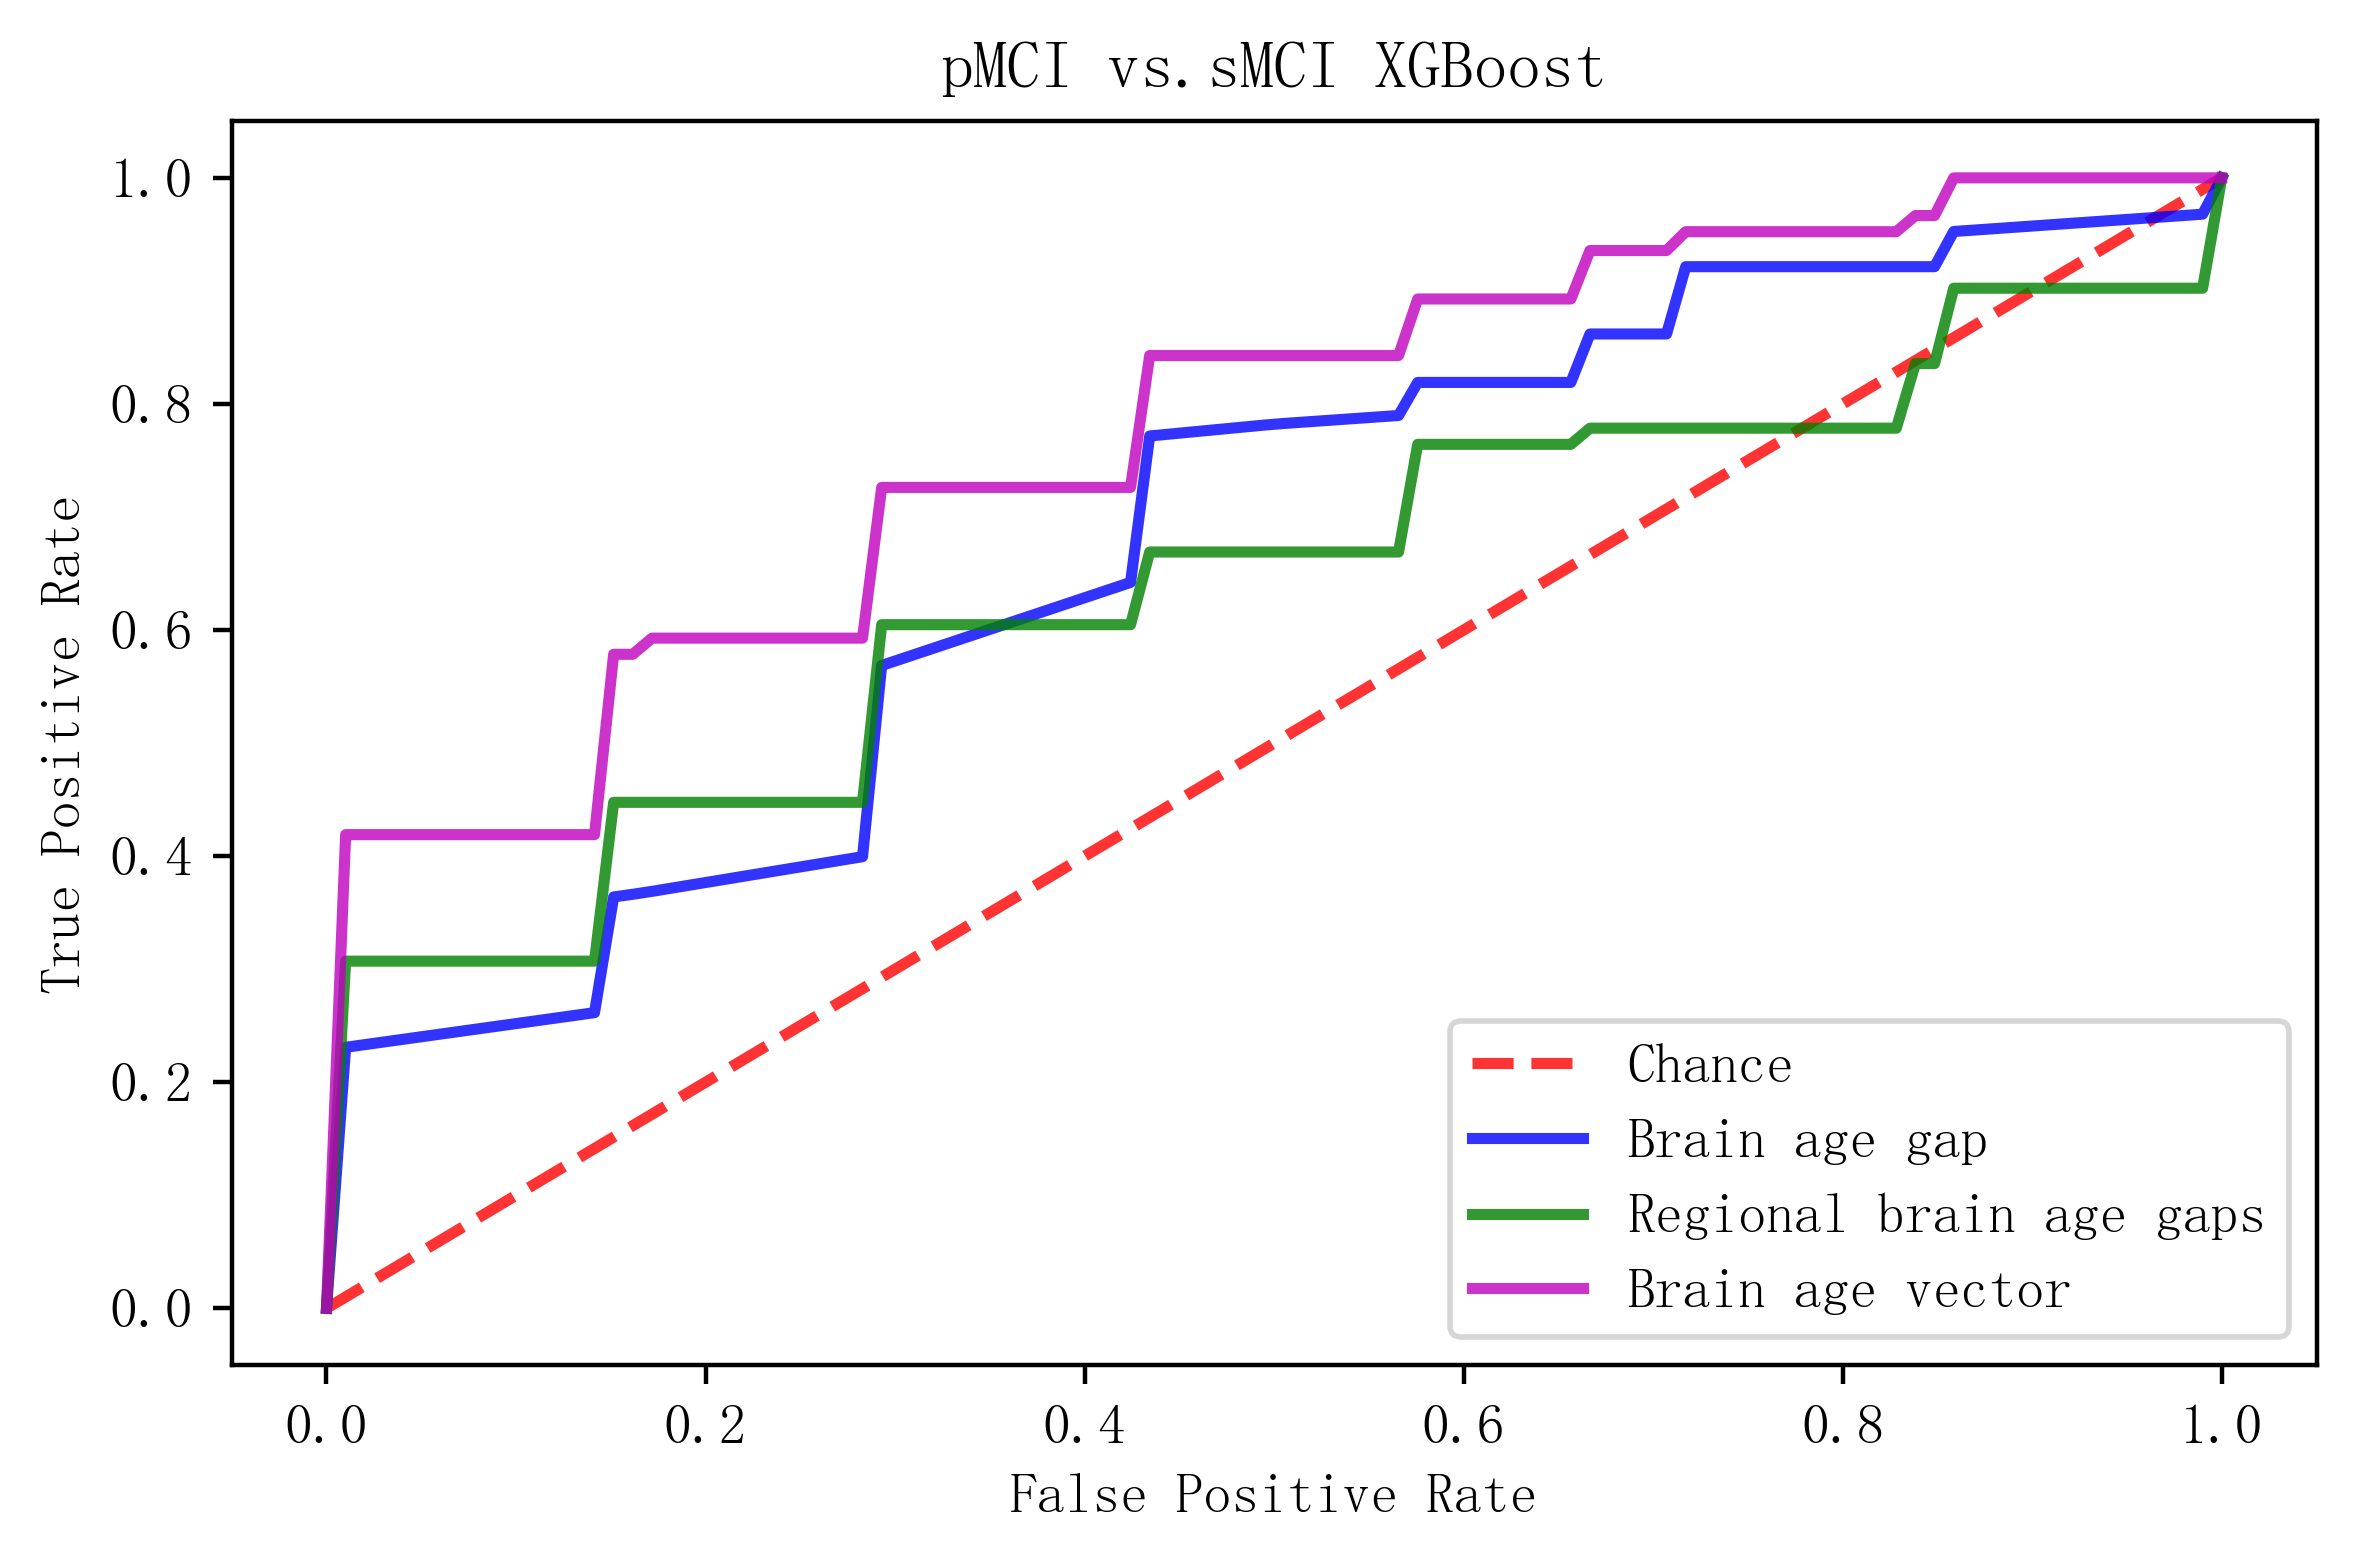

In [102]:
config = {
    "font.family":'serif',
    "font.size": 10,
    "mathtext.fontset": 'stix',
    "font.serif": ['SimSun'],

}
mpl.rcParams.update(config)

data1 = pd.read_csv(r"D:\rc\paper\csv\data5\shap_values_pMCI.csv")
data2 = pd.read_csv(r"D:\rc\paper\csv\data5\pMCI_1yearsbefore.csv")
data3 = pd.read_csv(r"D:\rc\paper\csv\data5\shap_values_sMCI.csv")
data4 = pd.read_csv(r"D:\rc\paper\csv\data5\sMCI_1styear.csv")
data1['age'] = data2['age']
data3['age'] = data4['age']
data1['label'] = 1
data3['label'] = 0
data0 = pd.concat([data1,data3]).reset_index(drop=True)

y2 = data0.loc[:,'label']
X2 = data0.drop(columns=['label']).fillna(0)

gaps0 = pd.read_csv(r"D:\rc\paper\csv\data5\gap_sMCI.csv")
gaps1 = pd.read_csv(r"D:\rc\paper\csv\data5\gap_pMCI.csv")
gaps0['age'] = data4['age']
gaps0['sex'] = data4['sex']
gaps1['age'] = data2['age']
gaps1['sex'] = data2['sex']
gaps0['label'] = 0
gaps1['label'] = 1

gaps = pd.concat([gaps0,gaps1]).reset_index(drop=True)

y = gaps.loc[:,'label']
y1 = gaps.loc[:,'label']
use = ['bias','sex','age']
X = gaps[use]
X1 = gaps.drop(columns=['bias','name','label'])


cv = StratifiedKFold(n_splits=10)
# classifier = lr(max_iter=2000)
# classifier1 = lr(max_iter=2000)
# classifier2 = lr(max_iter=2000)
param = {'n_estimators': 8, 'learning_rate': 0.36000000000000004, 'max_depth': 3}
classifier = xgb.XGBClassifier(**param)
param1 = {'n_estimators': 11, 'learning_rate': 0.8200000000000001, 'max_depth': 3}
classifier1 = xgb.XGBClassifier(**param1)
param2 = {'n_estimators': 30, 'learning_rate': 0.63, 'max_depth': 5}
classifier2 = xgb.XGBClassifier(**param2)
# classifier = GaussianNB()
# classifier1 = GaussianNB()


tprs = []
aucs = []

accs = []
sens = []
spes = []
aucss = []

mean_fpr = np.linspace(0, 1, 100)

for train, test in cv.split(X, y):
    features = X.drop(columns=['sex']).columns
    X_train = X.loc[train,:]
    X_test = X.loc[test,:]
    
#     for fea in features:
#         max = np.max(X_train[fea])
#         min = np.min(X_train[fea])
#         X_train[fea] = MinMaxNormalization(X_train[fea], max, min)
#         X_test[fea] = MinMaxNormalization(X_test[fea], max, min)
        
#     enc = OneHotEncoder()
#     enc.fit(X_train['sex'].values.reshape(-1, 1))
#     X_train['sex'] = enc.transform(X_train['sex'].values.reshape(-1, 1)).toarray()
#     X_test['sex'] = enc.transform(X_test['sex'].values.reshape(-1, 1)).toarray()
    
    model = classifier.fit(X_train, y[train])
    probas_ = model.predict_proba(X_test)
    y_pred = model.predict(X_test)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    accs.append(accuracy_score(y[test],y_pred))
    sens.append(recall_score(y[test], y_pred, average='binary'))
    spes.append(get_spe(y[test], y_pred))
    aucss.append(roc_auc_score(y[test], probas_[:, 1]))
#     plt.plot(fpr, tpr, lw=1, alpha=0.3,
#              label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))


tprs1 = []
aucs1 = []

accs1 = []
sens1 = []
spes1 = []
aucss1 = []

mean_fpr1 = np.linspace(0, 1, 100)
    
for train, test in cv.split(X1, y1):
    features = X1.columns
    X1_train = X1.loc[train,:]
    X1_test = X1.loc[test,:]
    
#     for fea in features:
#         max = np.max(X1_train[fea])
#         min = np.min(X1_train[fea])
#         X1_train[fea] = MinMaxNormalization(X1_train[fea], max, min)
#         X1_test[fea] = MinMaxNormalization(X1_test[fea], max, min)
    
#     enc = OneHotEncoder()
#     enc.fit(X1_train['sex'].values.reshape(-1, 1))
#     X1_train['sex'] = enc.transform(X1_train['sex'].values.reshape(-1, 1)).toarray()
#     X1_test['sex'] = enc.transform(X1_test['sex'].values.reshape(-1, 1)).toarray()
    
    model1 = classifier1.fit(X1_train, y1[train])
    probas_ = model1.predict_proba(X1_test)
    y_pred = model1.predict(X1_test)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y1[test], probas_[:, 1])
    tprs1.append(interp(mean_fpr1, fpr, tpr))
    tprs1[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs1.append(roc_auc)
    accs1.append(accuracy_score(y1[test],y_pred))
    sens1.append(recall_score(y1[test], y_pred, average='binary'))
    spes1.append(get_spe(y1[test], y_pred))
    aucss1.append(roc_auc_score(y1[test], probas_[:, 1]))
#     plt.plot(fpr, tpr, lw=1, alpha=0.3,
#              label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))


tprs2 = []
aucs2 = []

accs2 = []
sens2 = []
spes2 = []
aucss2 = []

mean_fpr2 = np.linspace(0, 1, 100)
    
for train, test in cv.split(X2, y2):
    features = X2.columns
    X2_train = X2.loc[train,:]
    X2_test = X2.loc[test,:]
    
#     for fea in features:
#         max = np.max(X2_train[fea])
#         min = np.min(X2_train[fea])
#         X2_train[fea] = MinMaxNormalization(X2_train[fea], max, min)
#         X2_test[fea] = MinMaxNormalization(X2_test[fea], max, min)
    
    model2 = classifier2.fit(X2_train, y2[train])
    probas_ = model2.predict_proba(X2_test)
    y_pred = model2.predict(X2_test)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y2[test], probas_[:, 1])
    tprs2.append(interp(mean_fpr2, fpr, tpr))
    tprs2[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs2.append(roc_auc)
    accs2.append(accuracy_score(y2[test],y_pred))
    sens2.append(recall_score(y2[test], y_pred, average='binary'))
    spes2.append(get_spe(y2[test], y_pred))
    aucss2.append(roc_auc_score(y2[test], probas_[:, 1]))
#     plt.plot(fpr, tpr, lw=1, alpha=0.3,
#              label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))


plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_tpr1 = np.mean(tprs1, axis=0)
mean_tpr1[-1] = 1.0
mean_tpr2 = np.mean(tprs2, axis=0)
mean_tpr1[-1] = 1.0


# mean_auc = auc(mean_fpr, mean_tpr)
# std_auc = np.std(aucs)
print('ACC = %0.4f ± %0.4f' % (np.mean(accs),np.std(accs)))
print('SEN = %0.4f ± %0.4f' % (np.mean(sens),np.std(sens)))
print('SPE = %0.4f ± %0.4f' % (np.mean(spes),np.std(spes)))
print('AUC = %0.4f ± %0.4f' % (np.mean(aucss),np.std(aucss)))
print('ACC = %0.4f ± %0.4f' % (np.mean(accs1),np.std(accs1)))
print('SEN = %0.4f ± %0.4f' % (np.mean(sens1),np.std(sens1)))
print('SPE = %0.4f ± %0.4f' % (np.mean(spes1),np.std(spes1)))
print('AUC = %0.4f ± %0.4f' % (np.mean(aucss1),np.std(aucss1)))
print('ACC = %0.4f ± %0.4f' % (np.mean(accs2),np.std(accs2)))
print('SEN = %0.4f ± %0.4f' % (np.mean(sens2),np.std(sens2)))
print('SPE = %0.4f ± %0.4f' % (np.mean(spes2),np.std(spes2)))
print('AUC = %0.4f ± %0.4f' % (np.mean(aucss2),np.std(aucss2)))


plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Brain age gap',
         lw=2, alpha=.8)
plt.plot(mean_fpr1, mean_tpr1, color='g',
         label=r'Regional brain age gaps',
         lw=2, alpha=.8)
plt.plot(mean_fpr2, mean_tpr2, color='m',
         label=r'Brain age vector',
         lw=2, alpha=.8)
# std_tpr = np.std(tprs, axis=0)
# tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
# tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
# plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
#                  label=r'$\pm$ 1 std. dev.')

plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.dpi'] = 400
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('pMCI vs.sMCI XGBoost')
plt.legend(loc="lower right")
plt.savefig(r"D:\rc\paper\fig\AD_xgb.png", dpi=400)
plt.show()    
    


C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:86: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:86: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:86: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:86: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:86: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:86: DeprecationWarning: scipy.interp is depr

ACC = 0.5478 ± 0.1204
SEN = 0.5310 ± 0.1569
SPE = 0.5667 ± 0.2278
AUC = 0.6199 ± 0.0866
ACC = 0.6143 ± 0.1284
SEN = 0.5452 ± 0.1695
SPE = 0.6786 ± 0.1327
AUC = 0.6214 ± 0.1602
ACC = 0.6907 ± 0.1452
SEN = 0.6548 ± 0.1580
SPE = 0.7214 ± 0.1929
AUC = 0.7867 ± 0.1546


C:\Users\Lenovo\Anaconda3\lib\site-packages\matplotlib\figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


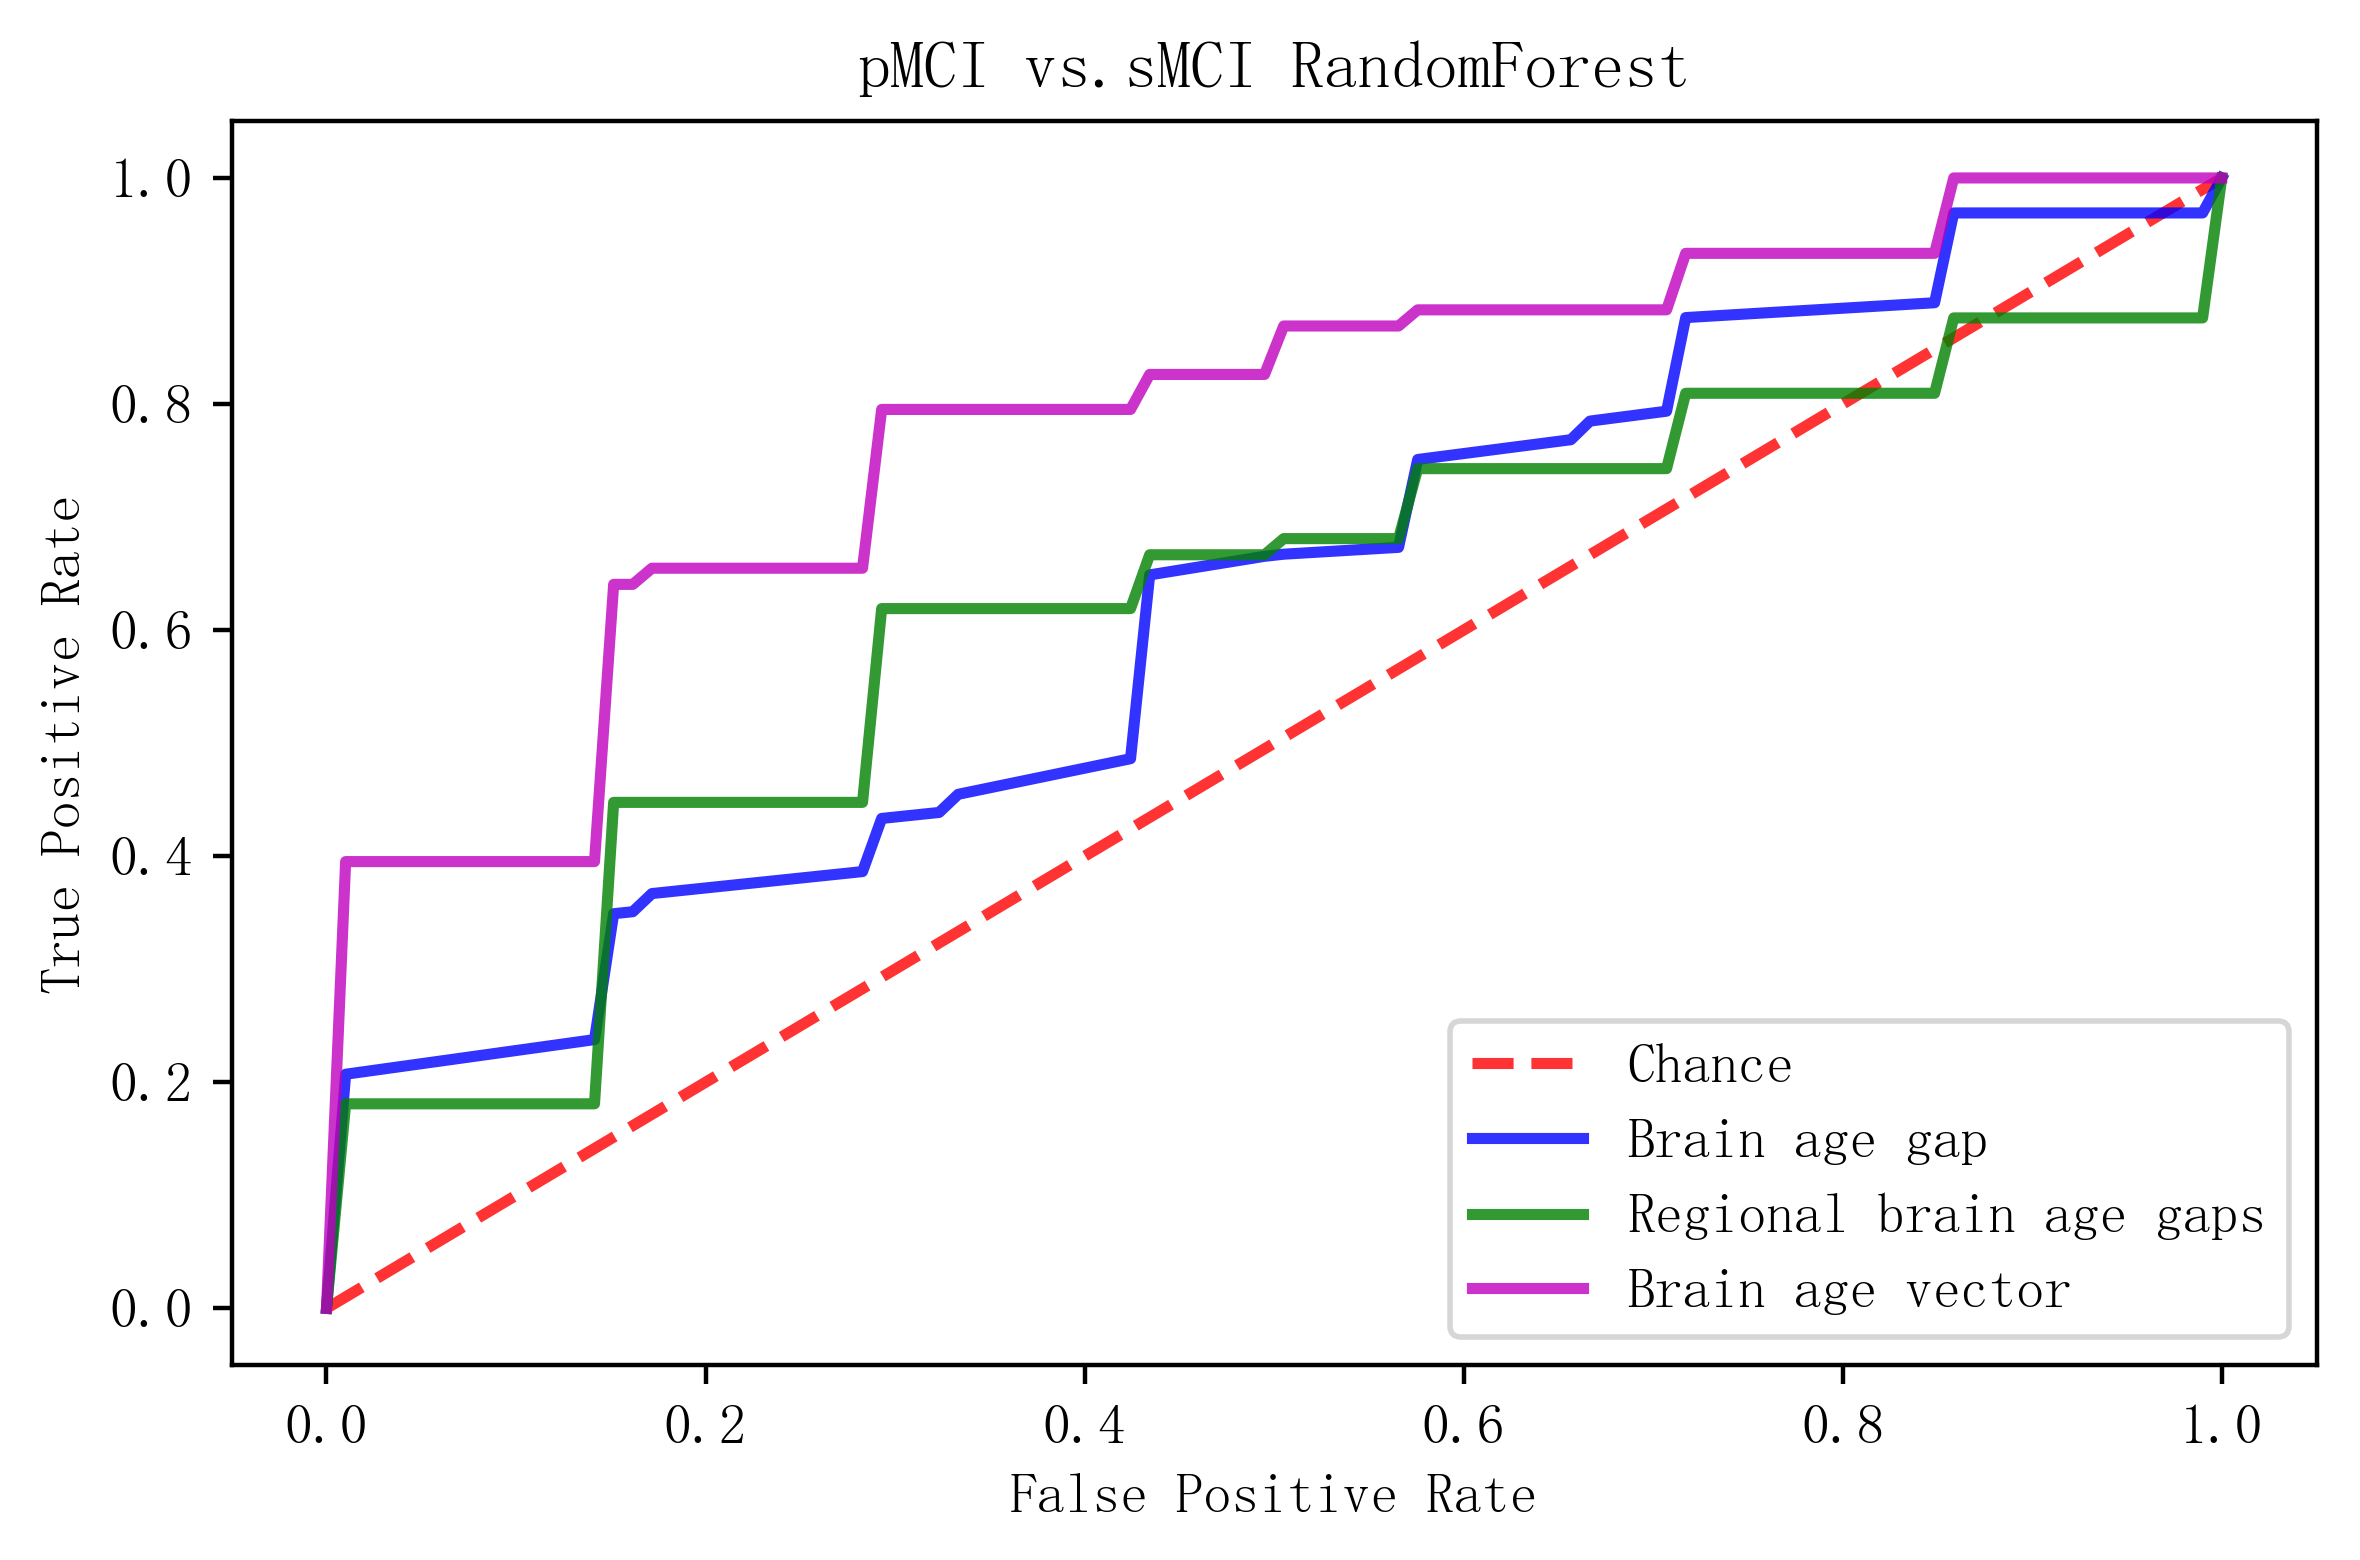

In [75]:
config = {
    "font.family":'serif',
    "font.size": 10,
    "mathtext.fontset": 'stix',
    "font.serif": ['SimSun'],

}
mpl.rcParams.update(config)

data1 = pd.read_csv(r"D:\rc\paper\csv\data5\shap_values_pMCI.csv")
data2 = pd.read_csv(r"D:\rc\paper\csv\data5\pMCI_1yearsbefore.csv")
data3 = pd.read_csv(r"D:\rc\paper\csv\data5\shap_values_sMCI.csv")
data4 = pd.read_csv(r"D:\rc\paper\csv\data5\sMCI_1styear.csv")
data1['age'] = data2['age']
data3['age'] = data4['age']
data1['label'] = 1
data3['label'] = 0
data0 = pd.concat([data1,data3]).reset_index(drop=True)

y2 = data0.loc[:,'label']
X2 = data0.drop(columns=['label']).fillna(0)

gaps0 = pd.read_csv(r"D:\rc\paper\csv\data5\gap_sMCI.csv")
gaps1 = pd.read_csv(r"D:\rc\paper\csv\data5\gap_pMCI.csv")
gaps0['age'] = data4['age']
gaps0['sex'] = data4['sex']
gaps1['age'] = data2['age']
gaps1['sex'] = data2['sex']
gaps0['label'] = 0
gaps1['label'] = 1

gaps = pd.concat([gaps0,gaps1]).reset_index(drop=True)

y = gaps.loc[:,'label']
y1 = gaps.loc[:,'label']
use = ['bias','sex','age']
X = gaps[use]
X1 = gaps.drop(columns=['bias','name','label'])


cv = StratifiedKFold(n_splits=10)
# classifier = lr(max_iter=2000)
# classifier1 = lr(max_iter=2000)
# classifier2 = lr(max_iter=2000)
param = {'n_estimators': 13, 'random_state': 12, 'max_depth': 2}
classifier = rfc(**param)
param1 = {'n_estimators': 49, 'random_state': 12, 'max_depth': 6}
classifier1 = rfc(**param1)
param2 = {'n_estimators': 37, 'random_state': 12, 'max_depth': 2}
classifier2 = rfc(**param2)
# classifier = GaussianNB()
# classifier1 = GaussianNB()


tprs = []
aucs = []

accs = []
sens = []
spes = []
aucss = []

mean_fpr = np.linspace(0, 1, 100)

for train, test in cv.split(X, y):
    features = X.drop(columns=['sex']).columns
    X_train = X.loc[train,:]
    X_test = X.loc[test,:]
    
#     for fea in features:
#         max = np.max(X_train[fea])
#         min = np.min(X_train[fea])
#         X_train[fea] = MinMaxNormalization(X_train[fea], max, min)
#         X_test[fea] = MinMaxNormalization(X_test[fea], max, min)
        
#     enc = OneHotEncoder()
#     enc.fit(X_train['sex'].values.reshape(-1, 1))
#     X_train['sex'] = enc.transform(X_train['sex'].values.reshape(-1, 1)).toarray()
#     X_test['sex'] = enc.transform(X_test['sex'].values.reshape(-1, 1)).toarray()
    
    model = classifier.fit(X_train, y[train])
    probas_ = model.predict_proba(X_test)
    y_pred = model.predict(X_test)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    accs.append(accuracy_score(y[test],y_pred))
    sens.append(recall_score(y[test], y_pred, average='binary'))
    spes.append(get_spe(y[test], y_pred))
    aucss.append(roc_auc_score(y[test], probas_[:, 1]))
#     plt.plot(fpr, tpr, lw=1, alpha=0.3,
#              label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))


tprs1 = []
aucs1 = []

accs1 = []
sens1 = []
spes1 = []
aucss1 = []

mean_fpr1 = np.linspace(0, 1, 100)
    
for train, test in cv.split(X1, y1):
    features = X1.columns
    X1_train = X1.loc[train,:]
    X1_test = X1.loc[test,:]
    
#     for fea in features:
#         max = np.max(X1_train[fea])
#         min = np.min(X1_train[fea])
#         X1_train[fea] = MinMaxNormalization(X1_train[fea], max, min)
#         X1_test[fea] = MinMaxNormalization(X1_test[fea], max, min)
    
#     enc = OneHotEncoder()
#     enc.fit(X1_train['sex'].values.reshape(-1, 1))
#     X1_train['sex'] = enc.transform(X1_train['sex'].values.reshape(-1, 1)).toarray()
#     X1_test['sex'] = enc.transform(X1_test['sex'].values.reshape(-1, 1)).toarray()
    
    model1 = classifier1.fit(X1_train, y1[train])
    probas_ = model1.predict_proba(X1_test)
    y_pred = model1.predict(X1_test)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y1[test], probas_[:, 1])
    tprs1.append(interp(mean_fpr1, fpr, tpr))
    tprs1[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs1.append(roc_auc)
    accs1.append(accuracy_score(y1[test],y_pred))
    sens1.append(recall_score(y1[test], y_pred, average='binary'))
    spes1.append(get_spe(y1[test], y_pred))
    aucss1.append(roc_auc_score(y1[test], probas_[:, 1]))
#     plt.plot(fpr, tpr, lw=1, alpha=0.3,
#              label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))


tprs2 = []
aucs2 = []

accs2 = []
sens2 = []
spes2 = []
aucss2 = []

mean_fpr2 = np.linspace(0, 1, 100)
    
for train, test in cv.split(X2, y2):
    features = X2.columns
    X2_train = X2.loc[train,:]
    X2_test = X2.loc[test,:]
    
#     for fea in features:
#         max = np.max(X2_train[fea])
#         min = np.min(X2_train[fea])
#         X2_train[fea] = MinMaxNormalization(X2_train[fea], max, min)
#         X2_test[fea] = MinMaxNormalization(X2_test[fea], max, min)
    
    model2 = classifier2.fit(X2_train, y2[train])
    probas_ = model2.predict_proba(X2_test)
    y_pred = model2.predict(X2_test)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y2[test], probas_[:, 1])
    tprs2.append(interp(mean_fpr2, fpr, tpr))
    tprs2[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs2.append(roc_auc)
    accs2.append(accuracy_score(y2[test],y_pred))
    sens2.append(recall_score(y2[test], y_pred, average='binary'))
    spes2.append(get_spe(y2[test], y_pred))
    aucss2.append(roc_auc_score(y2[test], probas_[:, 1]))
#     plt.plot(fpr, tpr, lw=1, alpha=0.3,
#              label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))


plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_tpr1 = np.mean(tprs1, axis=0)
mean_tpr1[-1] = 1.0
mean_tpr2 = np.mean(tprs2, axis=0)
mean_tpr1[-1] = 1.0


# mean_auc = auc(mean_fpr, mean_tpr)
# std_auc = np.std(aucs)
print('ACC = %0.4f ± %0.4f' % (np.mean(accs),np.std(accs)))
print('SEN = %0.4f ± %0.4f' % (np.mean(sens),np.std(sens)))
print('SPE = %0.4f ± %0.4f' % (np.mean(spes),np.std(spes)))
print('AUC = %0.4f ± %0.4f' % (np.mean(aucss),np.std(aucss)))
print('ACC = %0.4f ± %0.4f' % (np.mean(accs1),np.std(accs1)))
print('SEN = %0.4f ± %0.4f' % (np.mean(sens1),np.std(sens1)))
print('SPE = %0.4f ± %0.4f' % (np.mean(spes1),np.std(spes1)))
print('AUC = %0.4f ± %0.4f' % (np.mean(aucss1),np.std(aucss1)))
print('ACC = %0.4f ± %0.4f' % (np.mean(accs2),np.std(accs2)))
print('SEN = %0.4f ± %0.4f' % (np.mean(sens2),np.std(sens2)))
print('SPE = %0.4f ± %0.4f' % (np.mean(spes2),np.std(spes2)))
print('AUC = %0.4f ± %0.4f' % (np.mean(aucss2),np.std(aucss2)))


plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Brain age gap',
         lw=2, alpha=.8)
plt.plot(mean_fpr1, mean_tpr1, color='g',
         label=r'Regional brain age gaps',
         lw=2, alpha=.8)
plt.plot(mean_fpr2, mean_tpr2, color='m',
         label=r'Brain age vector',
         lw=2, alpha=.8)
# std_tpr = np.std(tprs, axis=0)
# tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
# tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
# plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
#                  label=r'$\pm$ 1 std. dev.')

plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.dpi'] = 400
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('pMCI vs.sMCI RandomForest')
plt.legend(loc="lower right")
plt.savefig(r"D:\rc\paper\fig\AD_rf.png", dpi=400)
plt.show()    
    


In [8]:
########################################################PD vs. RBD选特征
sMCI = pd.read_csv(r"D:\rc\paper\csv\data5\shap_values_sMCI.csv")
pMCI = pd.read_csv(r"D:\rc\paper\csv\data5\shap_values_pMCI.csv")

features = sMCI.drop(columns=['sex']).columns

marker1 = []
for fea in features:
    p = get_p(sMCI[fea],pMCI[fea])
    if p <=0.05:
        marker1.append(fea)
print(marker1)

marker = []
for fea in features:
    if stats.levene(sMCI[fea],pMCI[fea]).pvalue > 0.05:
        p = stats.ttest_ind(sMCI[fea],pMCI[fea]).pvalue
    else:
        p = stats.ttest_ind(sMCI[fea],pMCI[fea],equal_var=False).pvalue
    if p <=0.05:
        marker.append(fea)
print(marker)
    
df = np.zeros([len(marker1),3])
i = 0
for fea in marker1:
    use = []
    mean_hc = np.mean(sMCI[fea])
    mean_pd = np.mean(pMCI[fea])
    p = get_p(sMCI[fea],pMCI[fea])
    use.append(mean_hc)
    use.append(mean_pd)
    use.append(p)
    df[i,:] = use
    i = i+1
df = pd.DataFrame(df)

df_marker = pd.DataFrame(df.values, index=marker1, columns=['mean_sMCI','mean_pMCI','pvalue'])
df_marker = df_marker.sort_values(by = 'pvalue', ascending=True, axis=0)
print(df_marker)
# df_marker.to_csv(r"C:\Users\ranchen\Desktop\云盘备份\毕设\AD_patient\pMCI_AD_marker.csv", index=True)
    
    

['Cortical white matter(lh)', 'Lateral Ventricle(lh)', 'Inferior Lateral Ventricle(lh)', 'Thalamus(lh)', 'Putaman(lh)', '3rd-Ventricle', 'Hippocampus(lh)', 'Inferior Lateral Ventricle(rh)', 'Amygdala(rh)', 'entorhinal(lh)', 'fusiform(lh)', 'inferior parietal(lh)', 'middle temporal(lh)', 'parahippocampal(lh)', 'pars opercularis(lh)', 'pars triangularis(lh)', 'superior frontal(lh)', 'insula(lh)', 'cuneus(rh)', 'entorhinal(rh)', 'fusiform(rh)', 'inferior temporal(rh)', 'parahippocampal(rh)', 'rostral middle frontal(rh)', 'transverse temporal(rh)', 'insula(rh)', 'CSF']
['Cortical white matter(lh)', 'Lateral Ventricle(lh)', 'Inferior Lateral Ventricle(lh)', 'Thalamus(lh)', 'Putaman(lh)', '3rd-Ventricle', 'Hippocampus(lh)', 'Inferior Lateral Ventricle(rh)', 'Amygdala(rh)', 'entorhinal(lh)', 'fusiform(lh)', 'inferior parietal(lh)', 'middle temporal(lh)', 'parahippocampal(lh)', 'pars opercularis(lh)', 'pars triangularis(lh)', 'superior frontal(lh)', 'insula(lh)', 'cuneus(rh)', 'entorhinal(rh)'

C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:73: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:73: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:73: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:73: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:73: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:73: DeprecationWarning: scipy.interp is depr

ACC = 0.7429 ± 0.1263
SEN = 0.7381 ± 0.2114
SPE = 0.7548 ± 0.1558
AUC = 0.7925 ± 0.1704
ACC = 0.7209 ± 0.1347
SEN = 0.6905 ± 0.2006
SPE = 0.7524 ± 0.1714
AUC = 0.8017 ± 0.1513
ACC = 0.7588 ± 0.1325
SEN = 0.7048 ± 0.2040
SPE = 0.8095 ± 0.1166
AUC = 0.8160 ± 0.1431


C:\Users\Lenovo\Anaconda3\lib\site-packages\matplotlib\figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


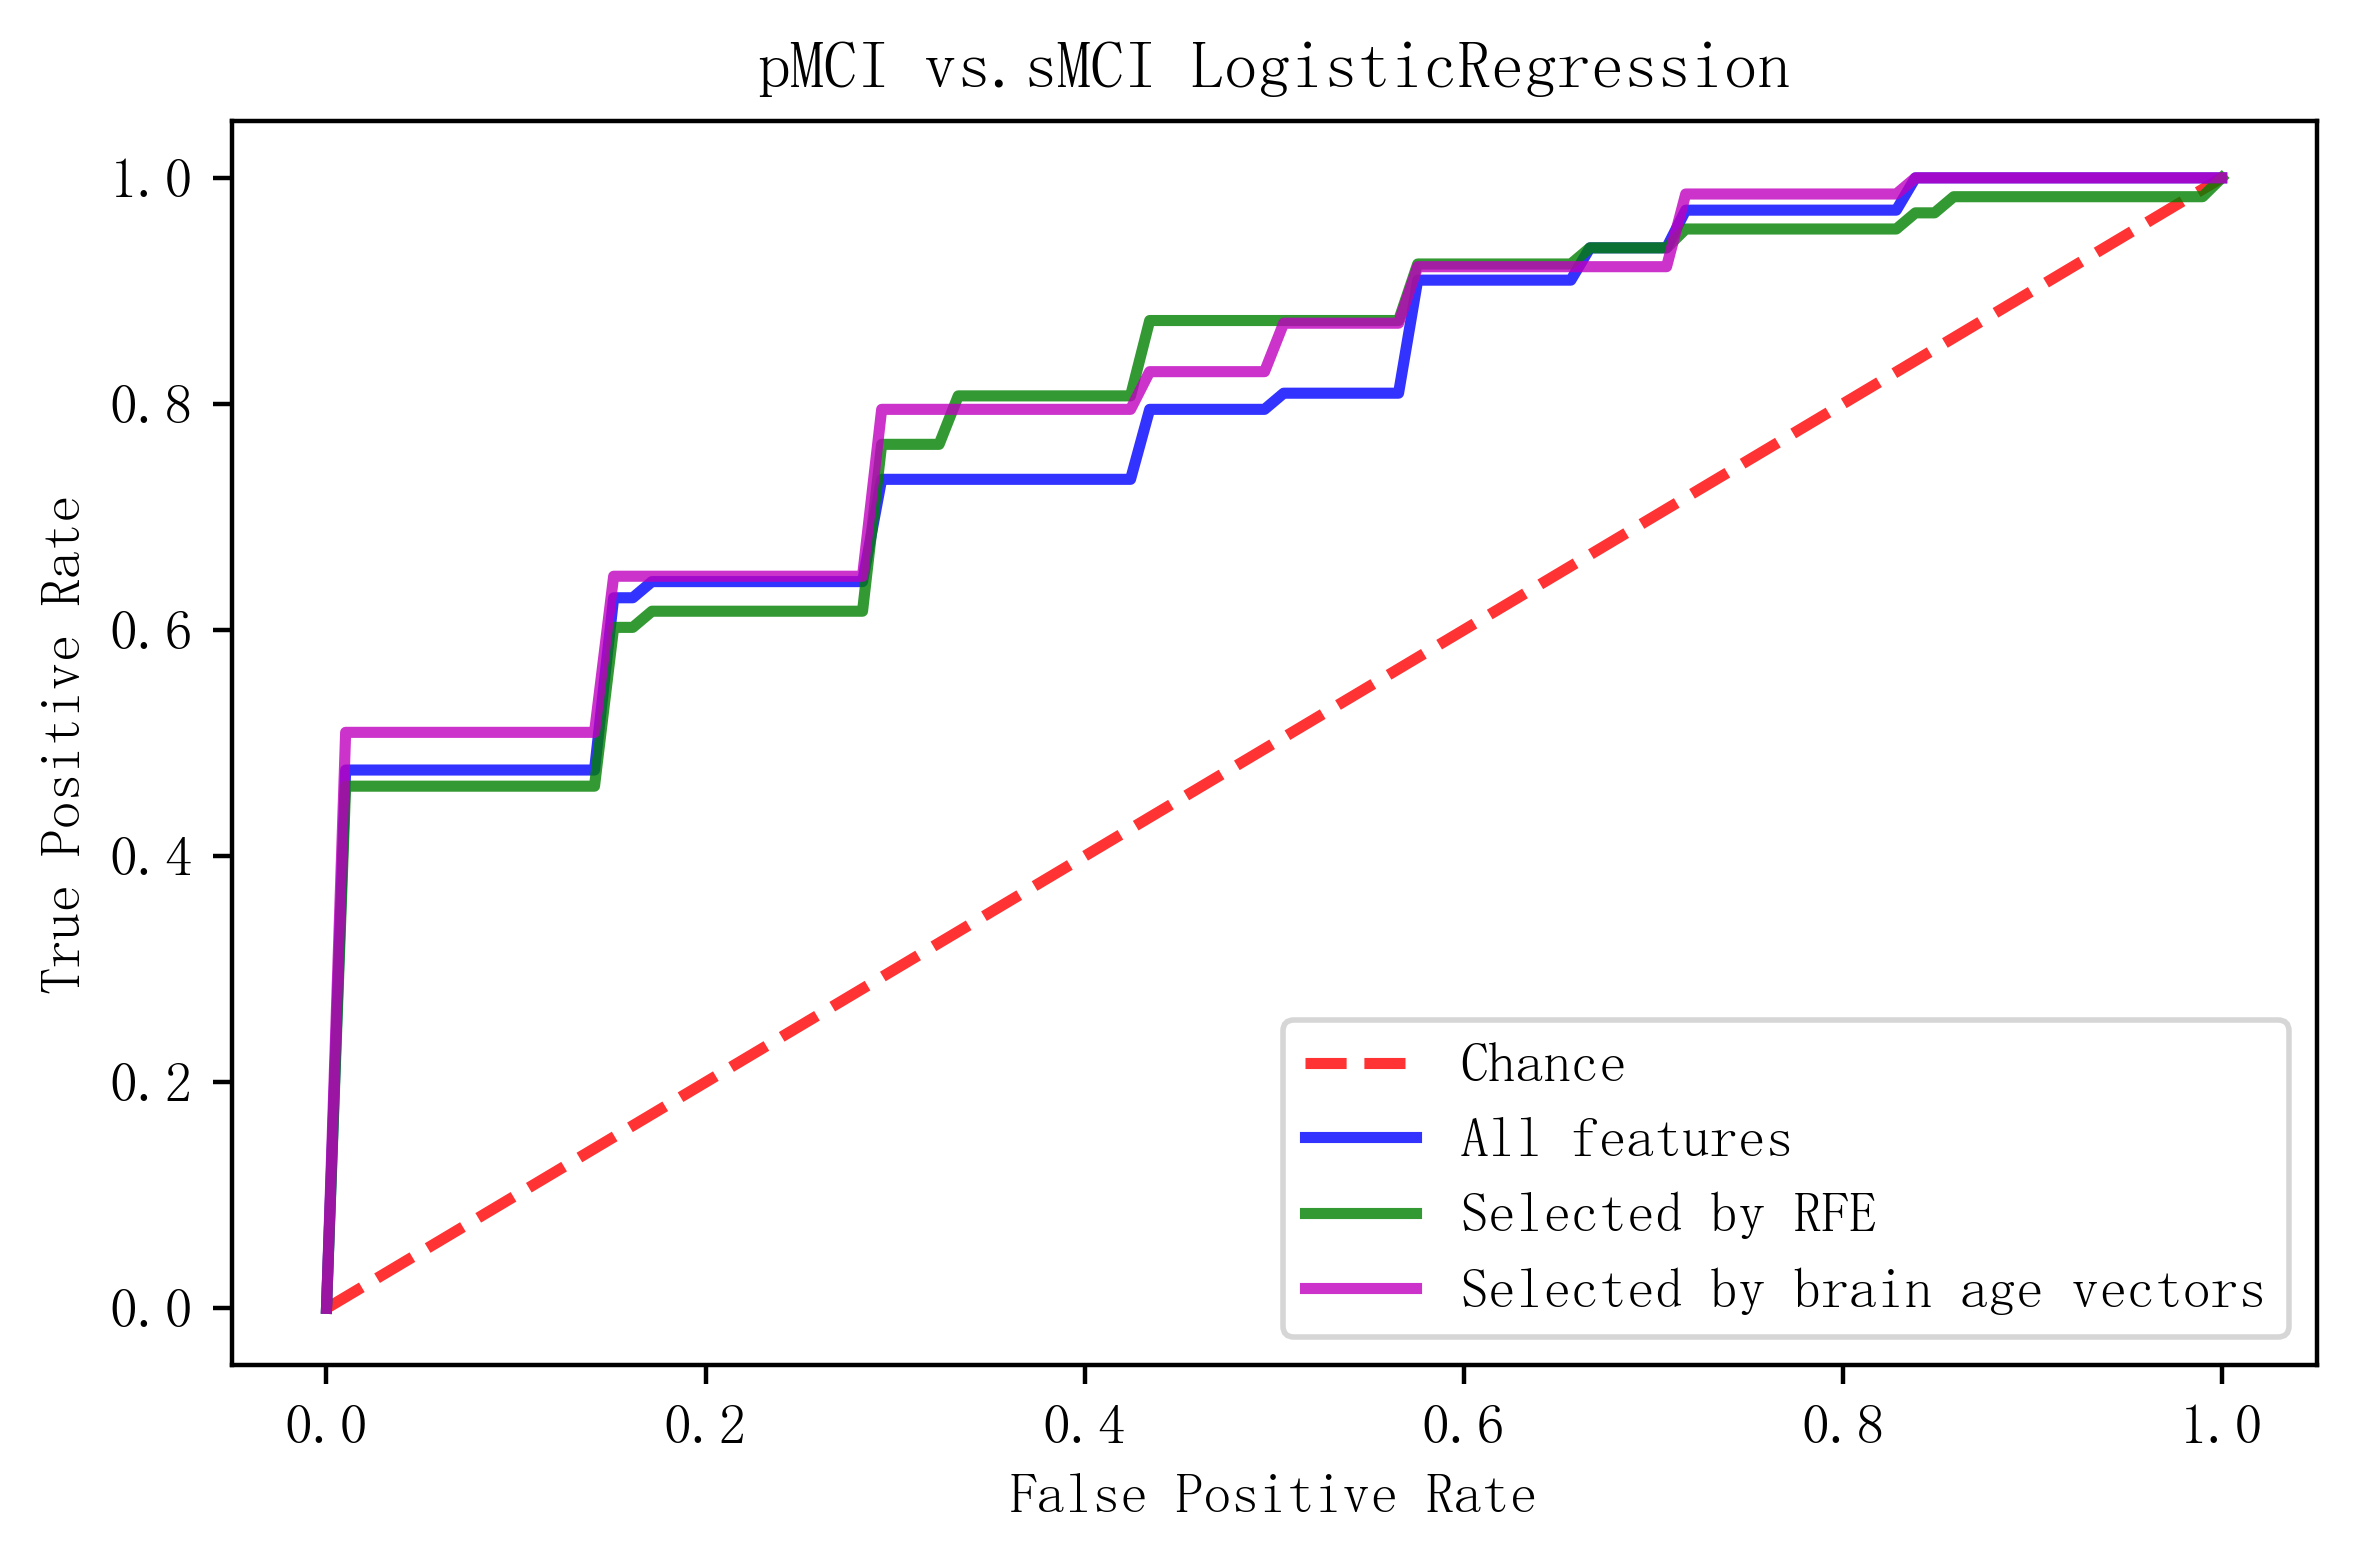

In [22]:
config = {
    "font.family":'serif',
    "font.size": 10,
    "mathtext.fontset": 'stix',
    "font.serif": ['SimSun'],

}
mpl.rcParams.update(config)


data1 = pd.read_csv(r"D:\rc\paper\csv\data5\sMCI_1styear.csv")
data2 = pd.read_csv(r"D:\rc\paper\csv\data5\pMCI_1yearsbefore.csv")
data1['label'] = 0
data2['label'] = 1
data = pd.concat([data1,data2]).reset_index(drop=True)

y = data.loc[:,'label']
X = data.drop(columns=['label','name'])

roi = ['Cortical white matter(lh)', 'Lateral Ventricle(lh)', 'Inferior Lateral Ventricle(lh)', 'Thalamus(lh)', 'Putaman(lh)', '3rd-Ventricle', 'Hippocampus(lh)', 'Inferior Lateral Ventricle(rh)', 'Amygdala(rh)', 'entorhinal(lh)', 'fusiform(lh)', 'inferior parietal(lh)', 'middle temporal(lh)', 'parahippocampal(lh)', 'pars opercularis(lh)', 'pars triangularis(lh)', 'superior frontal(lh)', 'insula(lh)', 'cuneus(rh)', 'entorhinal(rh)', 'fusiform(rh)', 'inferior temporal(rh)', 'parahippocampal(rh)', 'rostral middle frontal(rh)', 'transverse temporal(rh)', 'insula(rh)', 'CSF','sex','age']
X2 = data[roi]
y2 = data.loc[:,'label']

X1 = data.drop(columns=['name','label','age','sex'])
X1 = RFE(estimator=LinearSVC(), n_features_to_select=27).fit_transform(X1, y)
feat = pd.DataFrame(X1)
feat['age'] = data['age']
feat['sex'] = data['sex']
X1 = feat
y1 = data.loc[:,'label']

cv = StratifiedKFold(n_splits=10)
classifier = lr(max_iter=2000)
classifier1 = lr(max_iter=2000)
classifier2 = lr(max_iter=2000)
# classifier = xgb.XGBClassifier()
# classifier1 = xgb.XGBClassifier()
# classifier = GaussianNB()
# classifier1 = GaussianNB()


tprs = []
aucs = []

accs = []
sens = []
spes = []
aucss = []

mean_fpr = np.linspace(0, 1, 100)

for train, test in cv.split(X, y):
    features = X.drop(columns=['sex']).columns
    X_train = X.loc[train,:]
    X_test = X.loc[test,:]
    
    for fea in features:
        max = np.max(X_train[fea])
        min = np.min(X_train[fea])
        X_train[fea] = MinMaxNormalization(X_train[fea], max, min)
        X_test[fea] = MinMaxNormalization(X_test[fea], max, min)
        
    enc = OneHotEncoder()
    enc.fit(X_train['sex'].values.reshape(-1, 1))
    X_train['sex'] = enc.transform(X_train['sex'].values.reshape(-1, 1)).toarray()
    X_test['sex'] = enc.transform(X_test['sex'].values.reshape(-1, 1)).toarray()
    
    model = classifier.fit(X_train, y[train])
    probas_ = model.predict_proba(X_test)
    y_pred = model.predict(X_test)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    accs.append(accuracy_score(y[test],y_pred))
    sens.append(recall_score(y[test], y_pred, average='binary'))
    spes.append(get_spe(y[test], y_pred))
    aucss.append(roc_auc_score(y[test], probas_[:, 1]))
#     plt.plot(fpr, tpr, lw=1, alpha=0.3,
#              label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))


tprs1 = []
aucs1 = []

accs1 = []
sens1 = []
spes1 = []
aucss1 = []

mean_fpr1 = np.linspace(0, 1, 100)
    
for train, test in cv.split(X1, y1):
    features = X1.columns
    X1_train = X1.loc[train,:]
    X1_test = X1.loc[test,:]
    
    for fea in features:
        max = np.max(X1_train[fea])
        min = np.min(X1_train[fea])
        X1_train[fea] = MinMaxNormalization(X1_train[fea], max, min)
        X1_test[fea] = MinMaxNormalization(X1_test[fea], max, min)
    
    enc = OneHotEncoder()
    enc.fit(X1_train['sex'].values.reshape(-1, 1))
    X1_train['sex'] = enc.transform(X1_train['sex'].values.reshape(-1, 1)).toarray()
    X1_test['sex'] = enc.transform(X1_test['sex'].values.reshape(-1, 1)).toarray()
    
    model1 = classifier1.fit(X1_train, y1[train])
    probas_ = model1.predict_proba(X1_test)
    y_pred = model1.predict(X1_test)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y1[test], probas_[:, 1])
    tprs1.append(interp(mean_fpr1, fpr, tpr))
    tprs1[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs1.append(roc_auc)
    accs1.append(accuracy_score(y1[test],y_pred))
    sens1.append(recall_score(y1[test], y_pred, average='binary'))
    spes1.append(get_spe(y1[test], y_pred))
    aucss1.append(roc_auc_score(y1[test], probas_[:, 1]))
#     plt.plot(fpr, tpr, lw=1, alpha=0.3,
#              label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))


tprs2 = []
aucs2 = []

accs2 = []
sens2 = []
spes2 = []
aucss2 = []

mean_fpr2 = np.linspace(0, 1, 100)
    
for train, test in cv.split(X2, y2):
    features = X2.columns
    X2_train = X2.loc[train,:]
    X2_test = X2.loc[test,:]
    
    for fea in features:
        max = np.max(X2_train[fea])
        min = np.min(X2_train[fea])
        X2_train[fea] = MinMaxNormalization(X2_train[fea], max, min)
        X2_test[fea] = MinMaxNormalization(X2_test[fea], max, min)
    
    enc = OneHotEncoder()
    enc.fit(X2_train['sex'].values.reshape(-1, 1))
    X2_train['sex'] = enc.transform(X2_train['sex'].values.reshape(-1, 1)).toarray()
    X2_test['sex'] = enc.transform(X2_test['sex'].values.reshape(-1, 1)).toarray()
    
    model2 = classifier2.fit(X2_train, y2[train])
    probas_ = model2.predict_proba(X2_test)
    y_pred = model2.predict(X2_test)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y2[test], probas_[:, 1])
    tprs2.append(interp(mean_fpr2, fpr, tpr))
    tprs2[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs2.append(roc_auc)
    accs2.append(accuracy_score(y2[test],y_pred))
    sens2.append(recall_score(y2[test], y_pred, average='binary'))
    spes2.append(get_spe(y2[test], y_pred))
    aucss2.append(roc_auc_score(y2[test], probas_[:, 1]))
#     plt.plot(fpr, tpr, lw=1, alpha=0.3,
#              label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))


plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_tpr1 = np.mean(tprs1, axis=0)
mean_tpr1[-1] = 1.0
mean_tpr2 = np.mean(tprs2, axis=0)
mean_tpr1[-1] = 1.0


# mean_auc = auc(mean_fpr, mean_tpr)
# std_auc = np.std(aucs)
print('ACC = %0.4f ± %0.4f' % (np.mean(accs),np.std(accs)))
print('SEN = %0.4f ± %0.4f' % (np.mean(sens),np.std(sens)))
print('SPE = %0.4f ± %0.4f' % (np.mean(spes),np.std(spes)))
print('AUC = %0.4f ± %0.4f' % (np.mean(aucss),np.std(aucss)))
print('ACC = %0.4f ± %0.4f' % (np.mean(accs1),np.std(accs1)))
print('SEN = %0.4f ± %0.4f' % (np.mean(sens1),np.std(sens1)))
print('SPE = %0.4f ± %0.4f' % (np.mean(spes1),np.std(spes1)))
print('AUC = %0.4f ± %0.4f' % (np.mean(aucss1),np.std(aucss1)))
print('ACC = %0.4f ± %0.4f' % (np.mean(accs2),np.std(accs2)))
print('SEN = %0.4f ± %0.4f' % (np.mean(sens2),np.std(sens2)))
print('SPE = %0.4f ± %0.4f' % (np.mean(spes2),np.std(spes2)))
print('AUC = %0.4f ± %0.4f' % (np.mean(aucss2),np.std(aucss2)))


plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'All features',
         lw=2, alpha=.8)
plt.plot(mean_fpr1, mean_tpr1, color='g',
         label=r'Selected by RFE',
         lw=2, alpha=.8)
plt.plot(mean_fpr2, mean_tpr2, color='m',
         label=r'Selected by brain age vectors',
         lw=2, alpha=.8)
# std_tpr = np.std(tprs, axis=0)
# tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
# tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
# plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
#                  label=r'$\pm$ 1 std. dev.')

plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.dpi'] = 400
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('pMCI vs.sMCI LogisticRegression')
plt.legend(loc="lower right")
# plt.savefig(r"D:\rc\paper\figure2\fig4.png", dpi=400)
plt.show()    
    

C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:78: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:78: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:78: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:78: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:78: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:78: DeprecationWarning: scipy.interp is depr

ACC = 0.6835 ± 0.1271
SEN = 0.6762 ± 0.2167
SPE = 0.6952 ± 0.1625
AUC = 0.7806 ± 0.1306
ACC = 0.6527 ± 0.1175
SEN = 0.6595 ± 0.2040
SPE = 0.6524 ± 0.1704
AUC = 0.7605 ± 0.1425
ACC = 0.7220 ± 0.1262
SEN = 0.6905 ± 0.1791
SPE = 0.7548 ± 0.1558
AUC = 0.8167 ± 0.1352


C:\Users\Lenovo\Anaconda3\lib\site-packages\matplotlib\figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


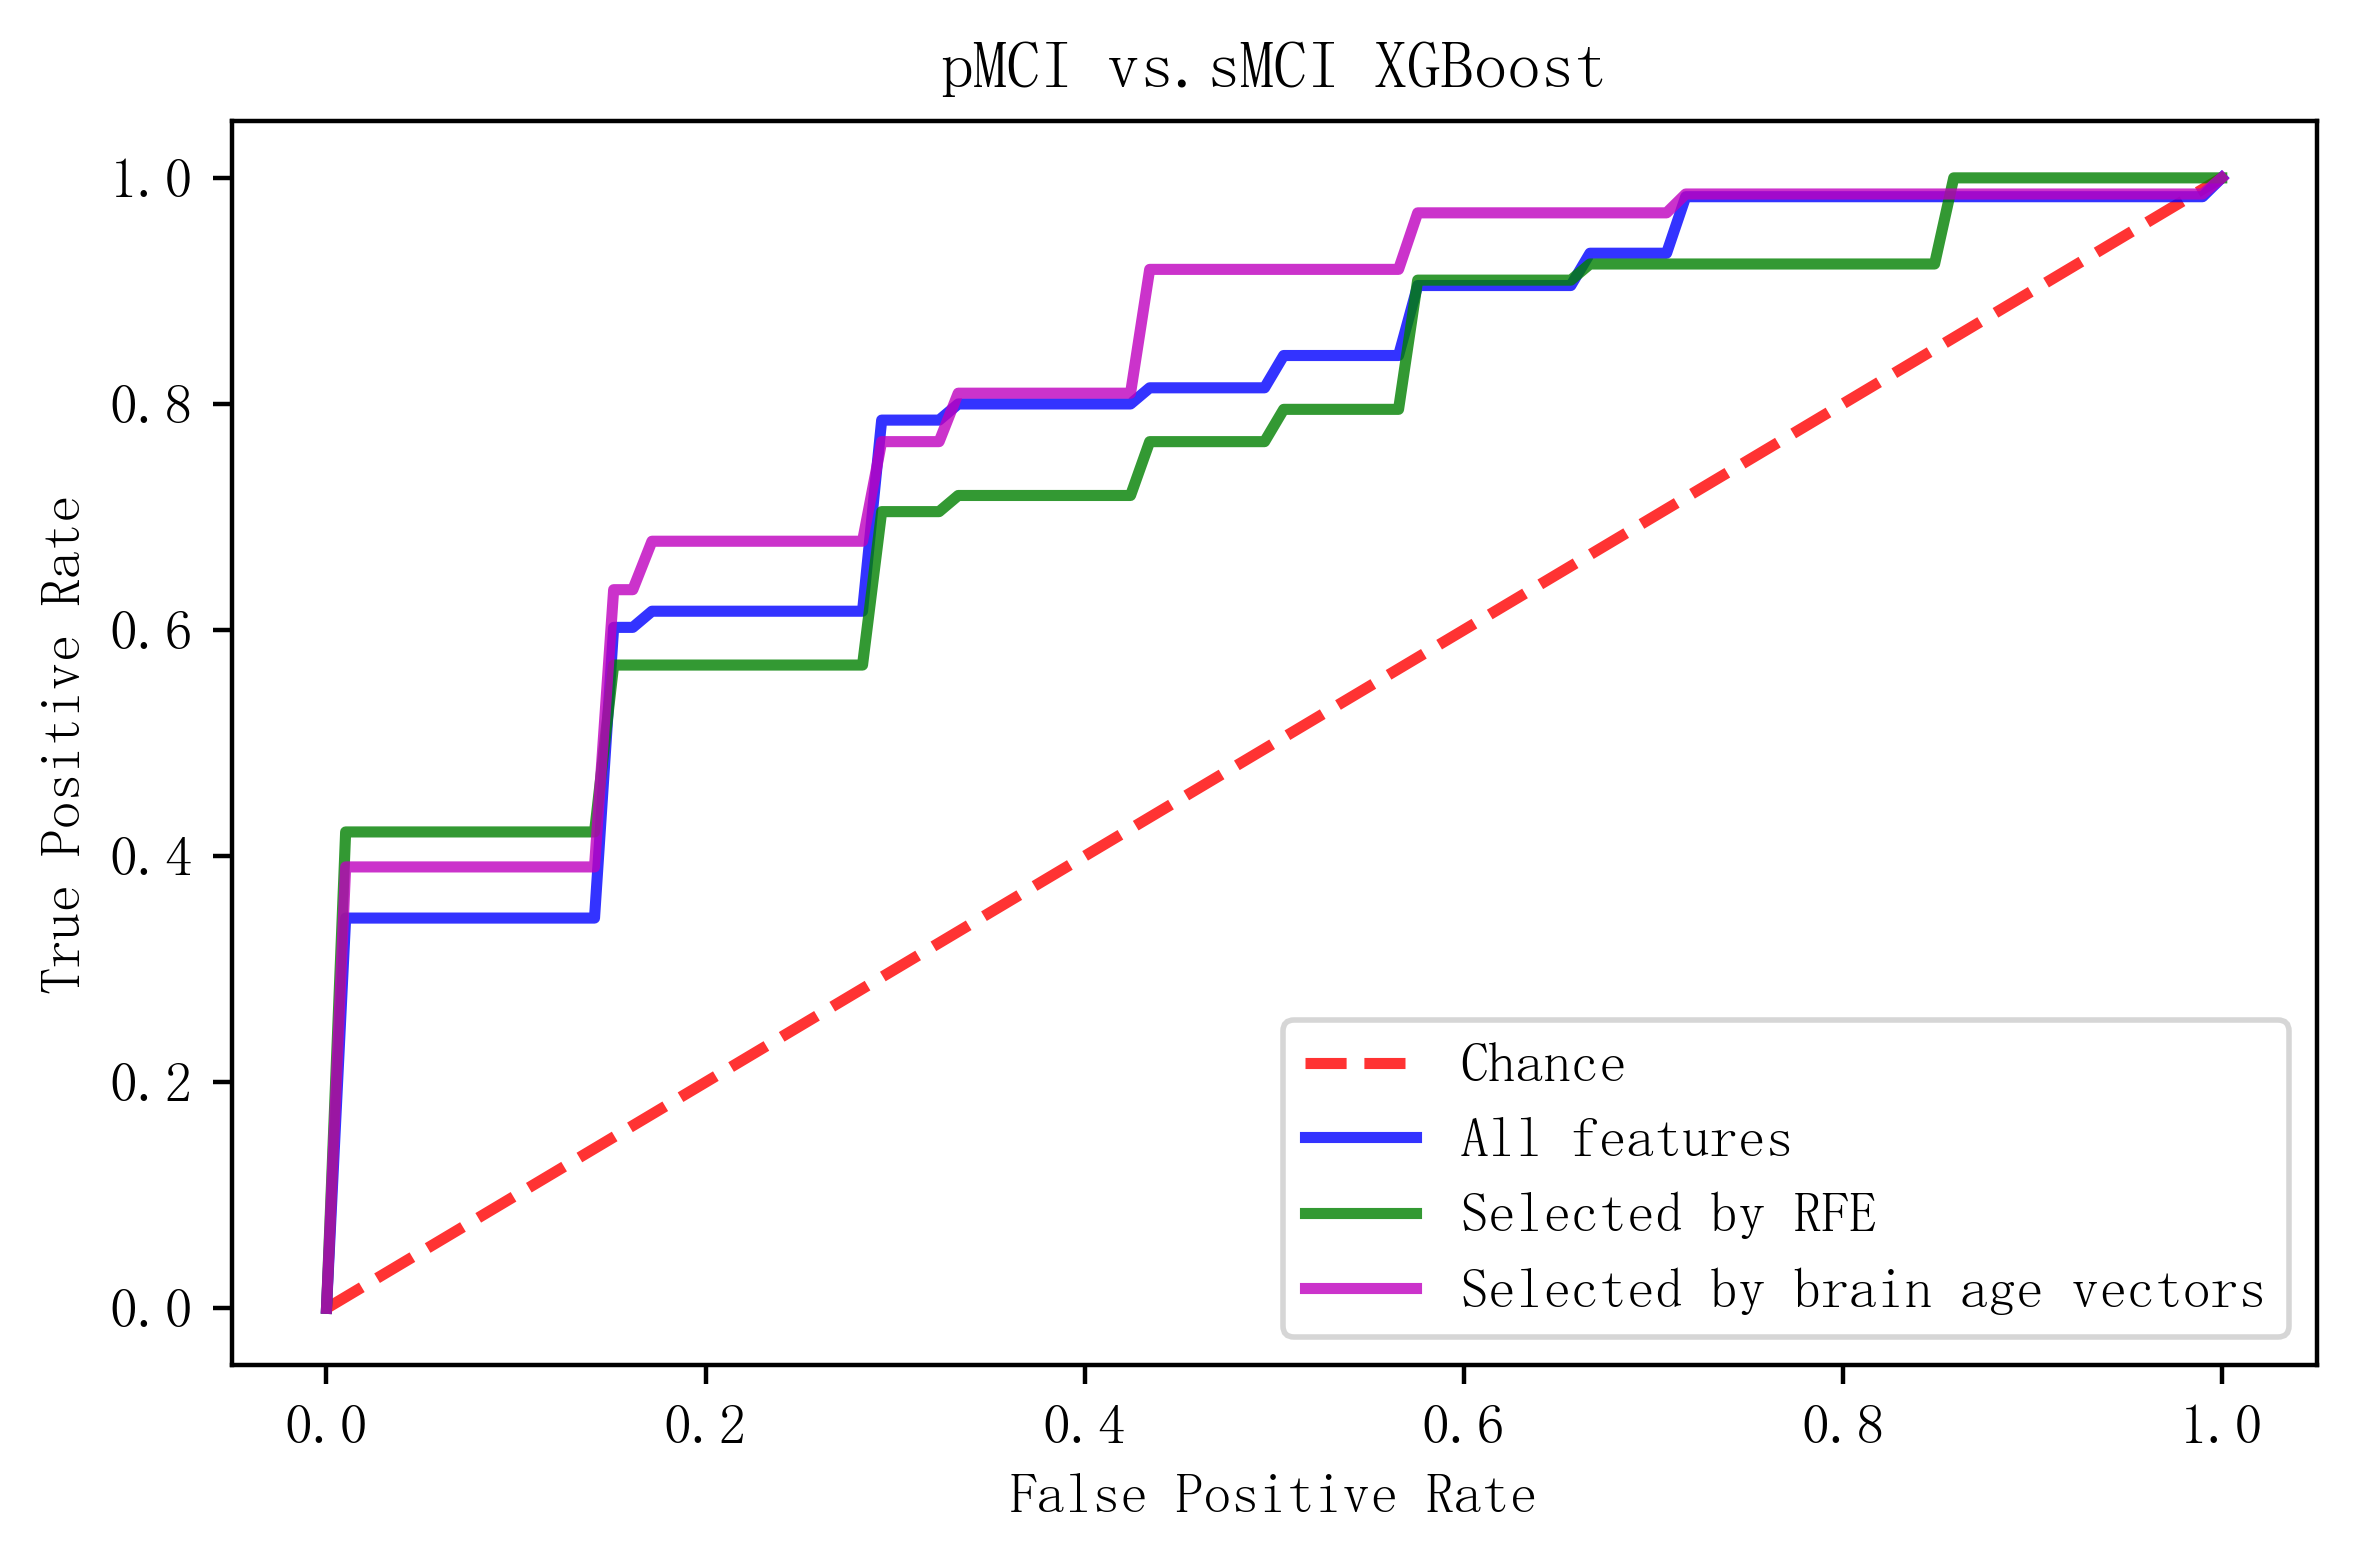

In [23]:
config = {
    "font.family":'serif',
    "font.size": 10,
    "mathtext.fontset": 'stix',
    "font.serif": ['SimSun'],

}
mpl.rcParams.update(config)


data1 = pd.read_csv(r"D:\rc\paper\csv\data5\sMCI_1styear.csv")
data2 = pd.read_csv(r"D:\rc\paper\csv\data5\pMCI_1yearsbefore.csv")
data1['label'] = 0
data2['label'] = 1
data = pd.concat([data1,data2]).reset_index(drop=True)

y = data.loc[:,'label']
X = data.drop(columns=['label','name'])

roi = ['Cortical white matter(lh)', 'Lateral Ventricle(lh)', 'Inferior Lateral Ventricle(lh)', 'Thalamus(lh)', 'Putaman(lh)', '3rd-Ventricle', 'Hippocampus(lh)', 'Inferior Lateral Ventricle(rh)', 'Amygdala(rh)', 'entorhinal(lh)', 'fusiform(lh)', 'inferior parietal(lh)', 'middle temporal(lh)', 'parahippocampal(lh)', 'pars opercularis(lh)', 'pars triangularis(lh)', 'superior frontal(lh)', 'insula(lh)', 'cuneus(rh)', 'entorhinal(rh)', 'fusiform(rh)', 'inferior temporal(rh)', 'parahippocampal(rh)', 'rostral middle frontal(rh)', 'transverse temporal(rh)', 'insula(rh)', 'CSF','sex','age']
X2 = data[roi]
y2 = data.loc[:,'label']

X1 = data.drop(columns=['name','label','age','sex'])
X1 = RFE(estimator=LinearSVC(), n_features_to_select=27).fit_transform(X1, y)
feat = pd.DataFrame(X1)
feat['age'] = data['age']
feat['sex'] = data['sex']
X1 = feat
y1 = data.loc[:,'label']

cv = StratifiedKFold(n_splits=10)
# classifier = lr(max_iter=2000)
# classifier1 = lr(max_iter=2000)
# classifier2 = lr(max_iter=2000)
param = {'n_estimators': 20, 'learning_rate': 0.19999999999999998, 'max_depth': 3}
classifier = xgb.XGBClassifier(**param)
param1 = {'learning_rate': 0.62, 'max_depth': 4, 'n_estimators': 36}
classifier1 = xgb.XGBClassifier(**param1)
param2 = {'learning_rate': 0.13, 'max_depth': 3, 'n_estimators': 22}
# param2 = {'n_estimators': 10, 'learning_rate': 0.04, 'max_depth': 5}
classifier2 = xgb.XGBClassifier(**param2)
# classifier = GaussianNB()
# classifier1 = GaussianNB()


tprs = []
aucs = []

accs = []
sens = []
spes = []
aucss = []

mean_fpr = np.linspace(0, 1, 100)

for train, test in cv.split(X, y):
    features = X.drop(columns=['sex']).columns
    X_train = X.loc[train,:]
    X_test = X.loc[test,:]
    
#     for fea in features:
#         max = np.max(X_train[fea])
#         min = np.min(X_train[fea])
#         X_train[fea] = MinMaxNormalization(X_train[fea], max, min)
#         X_test[fea] = MinMaxNormalization(X_test[fea], max, min)
        
#     enc = OneHotEncoder()
#     enc.fit(X_train['sex'].values.reshape(-1, 1))
#     X_train['sex'] = enc.transform(X_train['sex'].values.reshape(-1, 1)).toarray()
#     X_test['sex'] = enc.transform(X_test['sex'].values.reshape(-1, 1)).toarray()
    
    model = classifier.fit(X_train, y[train])
    probas_ = model.predict_proba(X_test)
    y_pred = model.predict(X_test)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    accs.append(accuracy_score(y[test],y_pred))
    sens.append(recall_score(y[test], y_pred, average='binary'))
    spes.append(get_spe(y[test], y_pred))
    aucss.append(roc_auc_score(y[test], probas_[:, 1]))
#     plt.plot(fpr, tpr, lw=1, alpha=0.3,
#              label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))


tprs1 = []
aucs1 = []

accs1 = []
sens1 = []
spes1 = []
aucss1 = []

mean_fpr1 = np.linspace(0, 1, 100)
    
for train, test in cv.split(X1, y1):
    features = X1.columns
    X1_train = X1.loc[train,:]
    X1_test = X1.loc[test,:]
    
#     for fea in features:
#         max = np.max(X1_train[fea])
#         min = np.min(X1_train[fea])
#         X1_train[fea] = MinMaxNormalization(X1_train[fea], max, min)
#         X1_test[fea] = MinMaxNormalization(X1_test[fea], max, min)
    
#     enc = OneHotEncoder()
#     enc.fit(X1_train['sex'].values.reshape(-1, 1))
#     X1_train['sex'] = enc.transform(X1_train['sex'].values.reshape(-1, 1)).toarray()
#     X1_test['sex'] = enc.transform(X1_test['sex'].values.reshape(-1, 1)).toarray()
    
    model1 = classifier1.fit(X1_train, y1[train])
    probas_ = model1.predict_proba(X1_test)
    y_pred = model1.predict(X1_test)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y1[test], probas_[:, 1])
    tprs1.append(interp(mean_fpr1, fpr, tpr))
    tprs1[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs1.append(roc_auc)
    accs1.append(accuracy_score(y1[test],y_pred))
    sens1.append(recall_score(y1[test], y_pred, average='binary'))
    spes1.append(get_spe(y1[test], y_pred))
    aucss1.append(roc_auc_score(y1[test], probas_[:, 1]))
#     plt.plot(fpr, tpr, lw=1, alpha=0.3,
#              label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))


tprs2 = []
aucs2 = []

accs2 = []
sens2 = []
spes2 = []
aucss2 = []

mean_fpr2 = np.linspace(0, 1, 100)
    
for train, test in cv.split(X2, y2):
    features = X2.columns
    X2_train = X2.loc[train,:]
    X2_test = X2.loc[test,:]
    
#     for fea in features:
#         max = np.max(X2_train[fea])
#         min = np.min(X2_train[fea])
#         X2_train[fea] = MinMaxNormalization(X2_train[fea], max, min)
#         X2_test[fea] = MinMaxNormalization(X2_test[fea], max, min)
    
    model2 = classifier2.fit(X2_train, y2[train])
    probas_ = model2.predict_proba(X2_test)
    y_pred = model2.predict(X2_test)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y2[test], probas_[:, 1])
    tprs2.append(interp(mean_fpr2, fpr, tpr))
    tprs2[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs2.append(roc_auc)
    accs2.append(accuracy_score(y2[test],y_pred))
    sens2.append(recall_score(y2[test], y_pred, average='binary'))
    spes2.append(get_spe(y2[test], y_pred))
    aucss2.append(roc_auc_score(y2[test], probas_[:, 1]))
#     plt.plot(fpr, tpr, lw=1, alpha=0.3,
#              label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))


plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_tpr1 = np.mean(tprs1, axis=0)
mean_tpr1[-1] = 1.0
mean_tpr2 = np.mean(tprs2, axis=0)
mean_tpr1[-1] = 1.0


# mean_auc = auc(mean_fpr, mean_tpr)
# std_auc = np.std(aucs)
print('ACC = %0.4f ± %0.4f' % (np.mean(accs),np.std(accs)))
print('SEN = %0.4f ± %0.4f' % (np.mean(sens),np.std(sens)))
print('SPE = %0.4f ± %0.4f' % (np.mean(spes),np.std(spes)))
print('AUC = %0.4f ± %0.4f' % (np.mean(aucss),np.std(aucss)))
print('ACC = %0.4f ± %0.4f' % (np.mean(accs1),np.std(accs1)))
print('SEN = %0.4f ± %0.4f' % (np.mean(sens1),np.std(sens1)))
print('SPE = %0.4f ± %0.4f' % (np.mean(spes1),np.std(spes1)))
print('AUC = %0.4f ± %0.4f' % (np.mean(aucss1),np.std(aucss1)))
print('ACC = %0.4f ± %0.4f' % (np.mean(accs2),np.std(accs2)))
print('SEN = %0.4f ± %0.4f' % (np.mean(sens2),np.std(sens2)))
print('SPE = %0.4f ± %0.4f' % (np.mean(spes2),np.std(spes2)))
print('AUC = %0.4f ± %0.4f' % (np.mean(aucss2),np.std(aucss2)))


plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'All features',
         lw=2, alpha=.8)
plt.plot(mean_fpr1, mean_tpr1, color='g',
         label=r'Selected by RFE',
         lw=2, alpha=.8)
plt.plot(mean_fpr2, mean_tpr2, color='m',
         label=r'Selected by brain age vectors',
         lw=2, alpha=.8)
# std_tpr = np.std(tprs, axis=0)
# tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
# tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
# plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
#                  label=r'$\pm$ 1 std. dev.')

plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.dpi'] = 400
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('pMCI vs.sMCI XGBoost')
plt.legend(loc="lower right")
# plt.savefig(r"D:\rc\paper\figure2\fig4.png", dpi=400)
plt.show()    
    


In [21]:
########################################################PD vs. RBD选特征
sMCI = pd.read_csv(r"D:\rc\paper\csv\data5\shap_values_HC.csv")
pMCI = pd.read_csv(r"D:\rc\paper\csv\data5\shap_values_prodromal.csv")

features = sMCI.drop(columns=['sex']).columns

marker1 = []
for fea in features:
    p = get_p(sMCI[fea],pMCI[fea])
    if p <=0.05:
        marker1.append(fea)
print(marker1)

marker = []
for fea in features:
    if stats.levene(sMCI[fea],pMCI[fea]).pvalue > 0.05:
        p = stats.ttest_ind(sMCI[fea],pMCI[fea]).pvalue
    else:
        p = stats.ttest_ind(sMCI[fea],pMCI[fea],equal_var=False).pvalue
    if p <=0.05:
        marker.append(fea)
print(marker)
    
df = np.zeros([len(marker1),3])
i = 0
for fea in marker1:
    use = []
    mean_hc = np.mean(sMCI[fea])
    mean_pd = np.mean(pMCI[fea])
    p = get_p(sMCI[fea],pMCI[fea])
    use.append(mean_hc)
    use.append(mean_pd)
    use.append(p)
    df[i,:] = use
    i = i+1
df = pd.DataFrame(df)

df_marker = pd.DataFrame(df.values, index=marker1, columns=['mean_HC','mean_PD-prodromal','pvalue'])
df_marker = df_marker.sort_values(by = 'pvalue', ascending=True, axis=0)
print(df_marker)
# df_marker.to_csv(r"C:\Users\ranchen\Desktop\云盘备份\毕设\AD_patient\pMCI_AD_marker.csv", index=True)
    
    

['Cerebellar White Matter(lh)', 'Putaman(lh)', 'Cerebrospinal Fluid', 'Accumbens(lh)', 'Choroid Plexus(lh)', 'Cortical white matter(rh)', 'medial orbitofrontal(lh)', 'postcentral(lh)', 'posterior cingulate(lh)', 'precentral(lh)', 'precuneus(lh)', 'rostral middle frontal(lh)', 'medial orbitofrontal(rh)', 'superior frontal(rh)', 'insula(rh)', 'CSF']
['Cerebellar White Matter(lh)', 'Putaman(lh)', 'Cerebrospinal Fluid', 'Accumbens(lh)', 'Choroid Plexus(lh)', 'Cortical white matter(rh)', 'medial orbitofrontal(lh)', 'postcentral(lh)', 'posterior cingulate(lh)', 'precentral(lh)', 'precuneus(lh)', 'rostral middle frontal(lh)', 'medial orbitofrontal(rh)', 'superior frontal(rh)', 'insula(rh)', 'CSF']
                              mean_HC  mean_PD-prodromal    pvalue
postcentral(lh)             -0.001626          -0.006024  0.001000
Accumbens(lh)               -0.006324           0.008682  0.001736
medial orbitofrontal(lh)     0.001092          -0.005793  0.002063
insula(rh)                   0.0

The mean age of sMCI : 68.5925925925926
The mean age of pMCI : 68.42857142857143
The tukey HSD between sMCI and pMCI : 0.8922384227265113


C:\Users\Lenovo\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


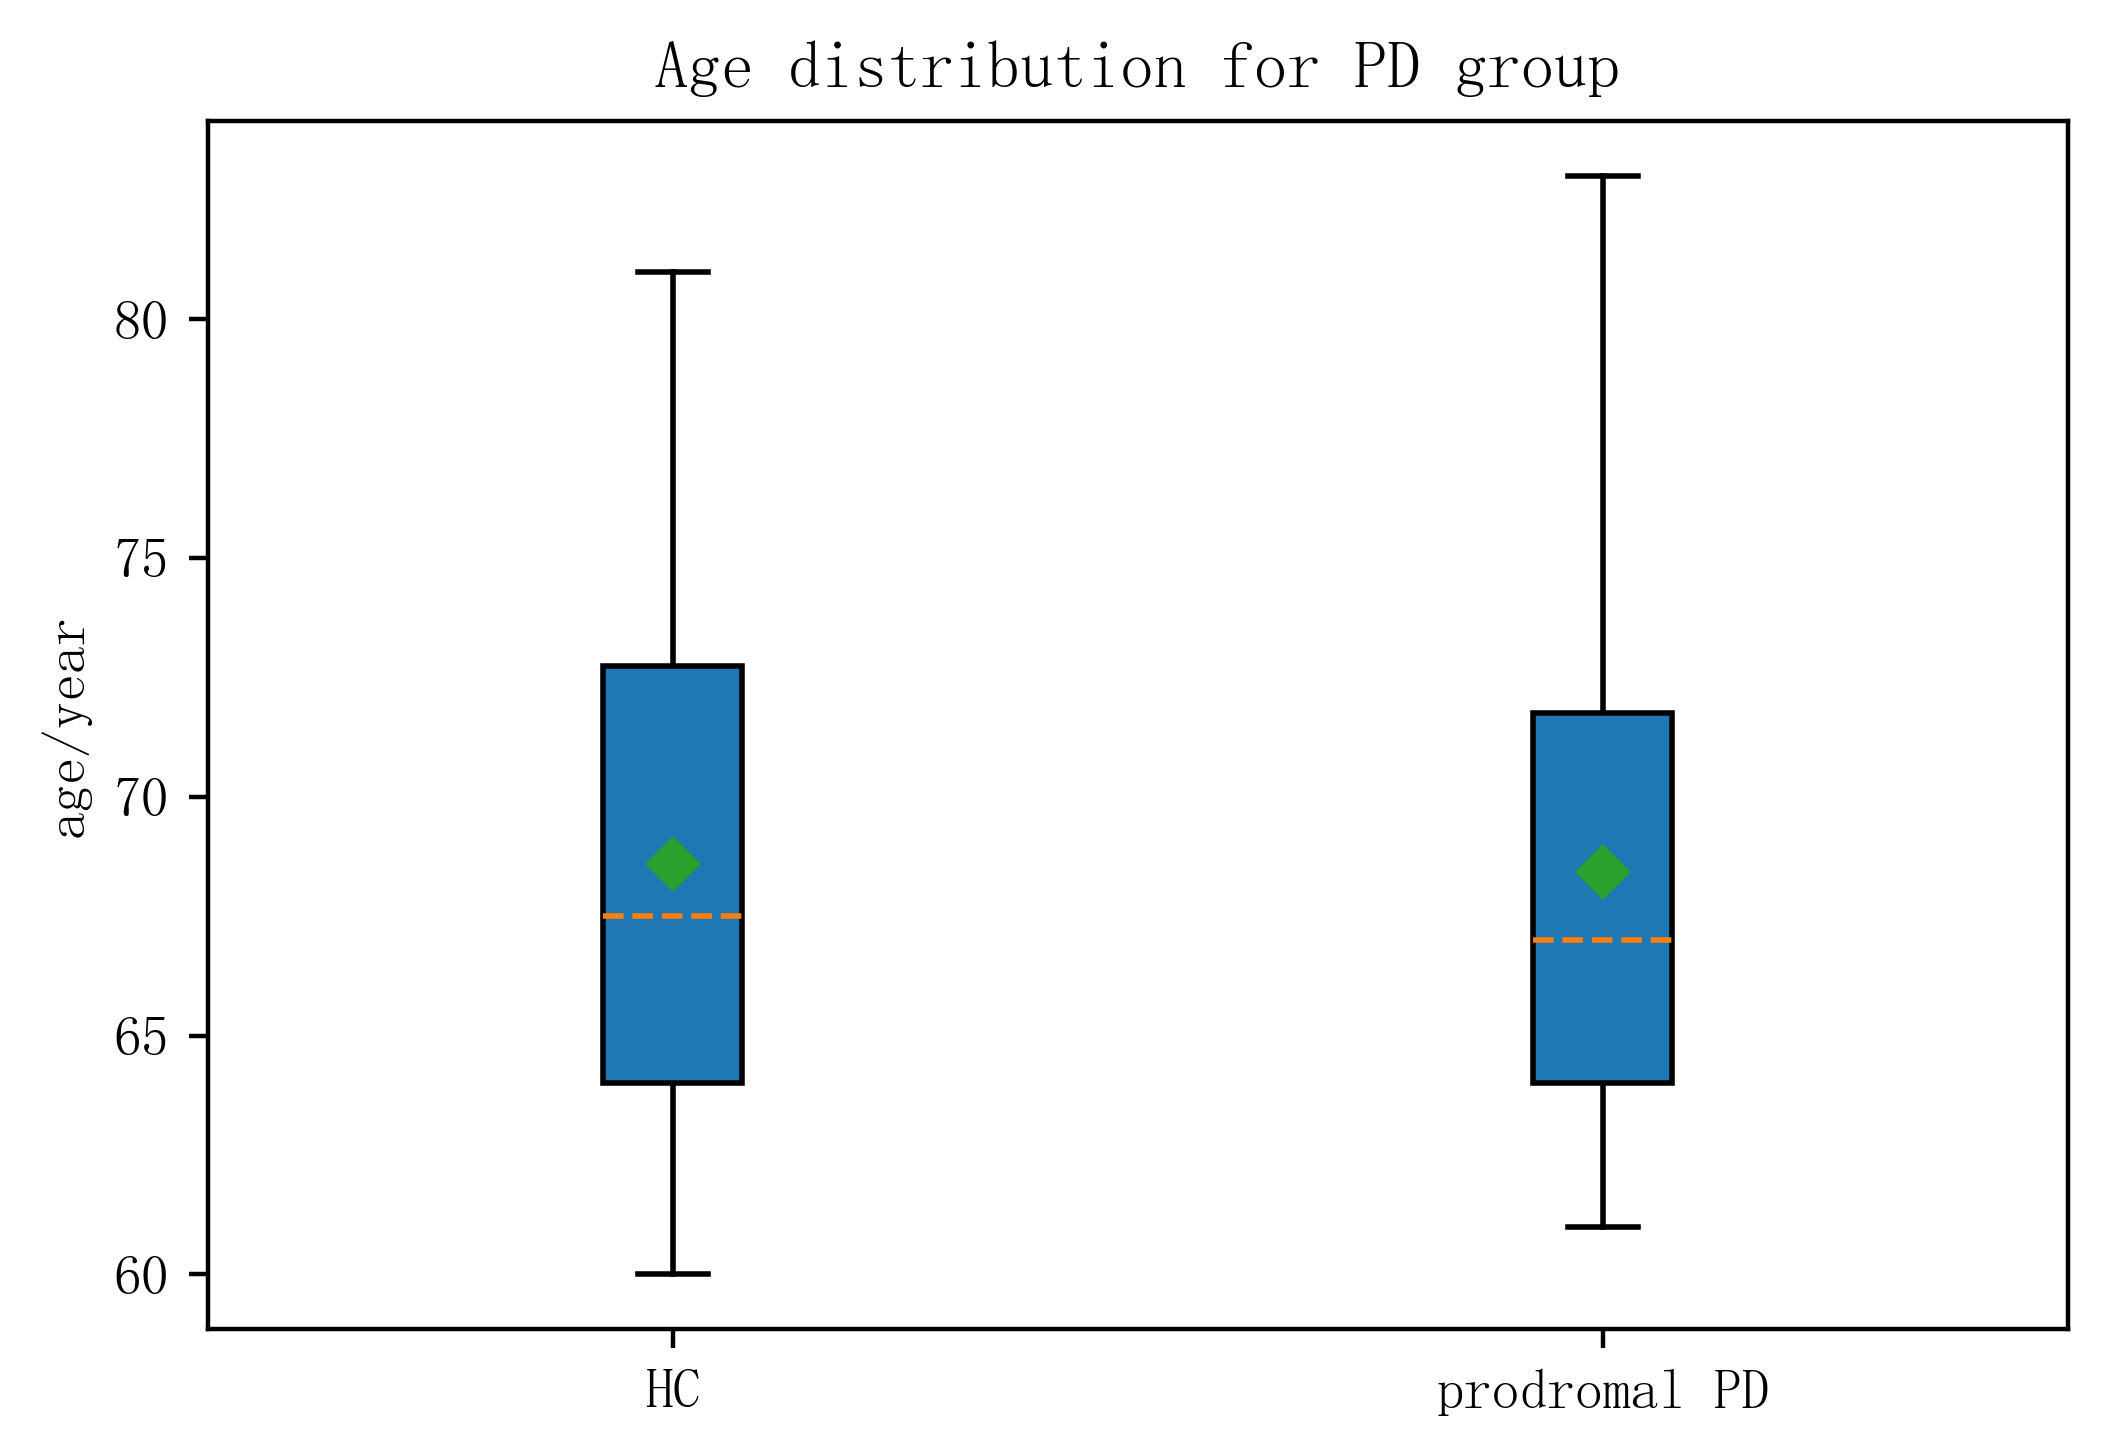

In [11]:
config = {
    "font.family":'serif',
    "font.size": 10,
    "mathtext.fontset": 'stix',
    "font.serif": ['SimSun'],

}
mpl.rcParams.update(config)
data1 = pd.read_csv(r"D:\rc\paper\csv\data5\filter_HC_baseline.csv")
data2 = pd.read_csv(r"D:\rc\paper\csv\data5\filter_prodromal_baseline.csv")

# data1 = data1.sort_values(by=['age'], ascending=True)
# data1 = data1.reset_index(drop=True)
# data1 = data1.drop(index=range(15))
# data2 = data2.sort_values(by=['age'], ascending=True)
# data2 = data2.reset_index(drop=True)
# data2 = data2.drop(index=range(50))
# data3 = data3.sort_values(by=['age'], ascending=True)
# data3 = data3.reset_index(drop=True)
# data3 = data3.drop(index=range(110))

# data1.to_csv(r"D:\rc\paper\csv\data3\filter_sMCI.csv", index=False)
# data2.to_csv(r"D:\rc\paper\csv\data3\filter_pMCI.csv", index=False)
# # data3.to_csv(r"D:\rc\paper\csv\new_data1\filter_PD_baseline.csv", index=False)


HC = data1['age']
PD = data2['age']

data = pd.DataFrame()
data['HC'] = HC
data['PD-prodromal'] = PD

# plt.figure(dpi=400)
# sns.kdeplot(data['HC'], shade=True, color='g')
# sns.kdeplot(data['PD-prodromal'], shade=True, color='r')
# plt.title('Age distribution for PD group')
# plt.show()


print("The mean age of sMCI :", np.mean(HC))
print("The mean age of pMCI :", np.mean(PD))

print("The tukey HSD between sMCI and pMCI :", get_p(HC,PD))

plt.figure(dpi=400)
plt.boxplot(x = [HC,PD], # 指定绘图数据
            patch_artist=True, # 要求用自定义颜色填充盒形图，默认白色填充
            labels=['HC','prodromal PD'],
            showmeans=True, # 以点的形式显示均值
            boxprops = {'color':'black'}, # 设置箱体属性，填充色和边框色
            flierprops = {'marker':'o'}, # 设置异常值属性，点的形状、填充色和边框色
            meanprops = {'marker':'D'}, # 设置均值点的属性，点的形状、填充色
            medianprops = {'linestyle':'--'}) # 设置中位数线的属性，线的类型和颜色
 
# 去除箱线图的上边框与右边框的刻度标签
plt.tick_params(top='off', right='off')
plt.title('Age distribution for PD group')
# plt.title('age',fontsize=11)
# plt.xticks(fontsize=11)
# plt.yticks(fontsize=11)
# plt.xlabel('实际年龄', fontsize=15)
plt.ylabel('age/year')
# plt.subplots_adjust(left=0.15)
# plt.legend(fontsize=20)
# plt.savefig(r"D:\rc\paper\figure1\fig2.png", dpi=400)
plt.show()                 

The mean gap of sMCI : -1.2447104277434173 7.534818536708533
The mean gap of pMCI : 0.37483324323381695 5.583776121049939
The tukey HSD between sMCI and pMCI : 0.2514968215648373


C:\Users\Lenovo\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
C:\Users\Lenovo\Anaconda3\lib\site-packages\matplotlib\figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


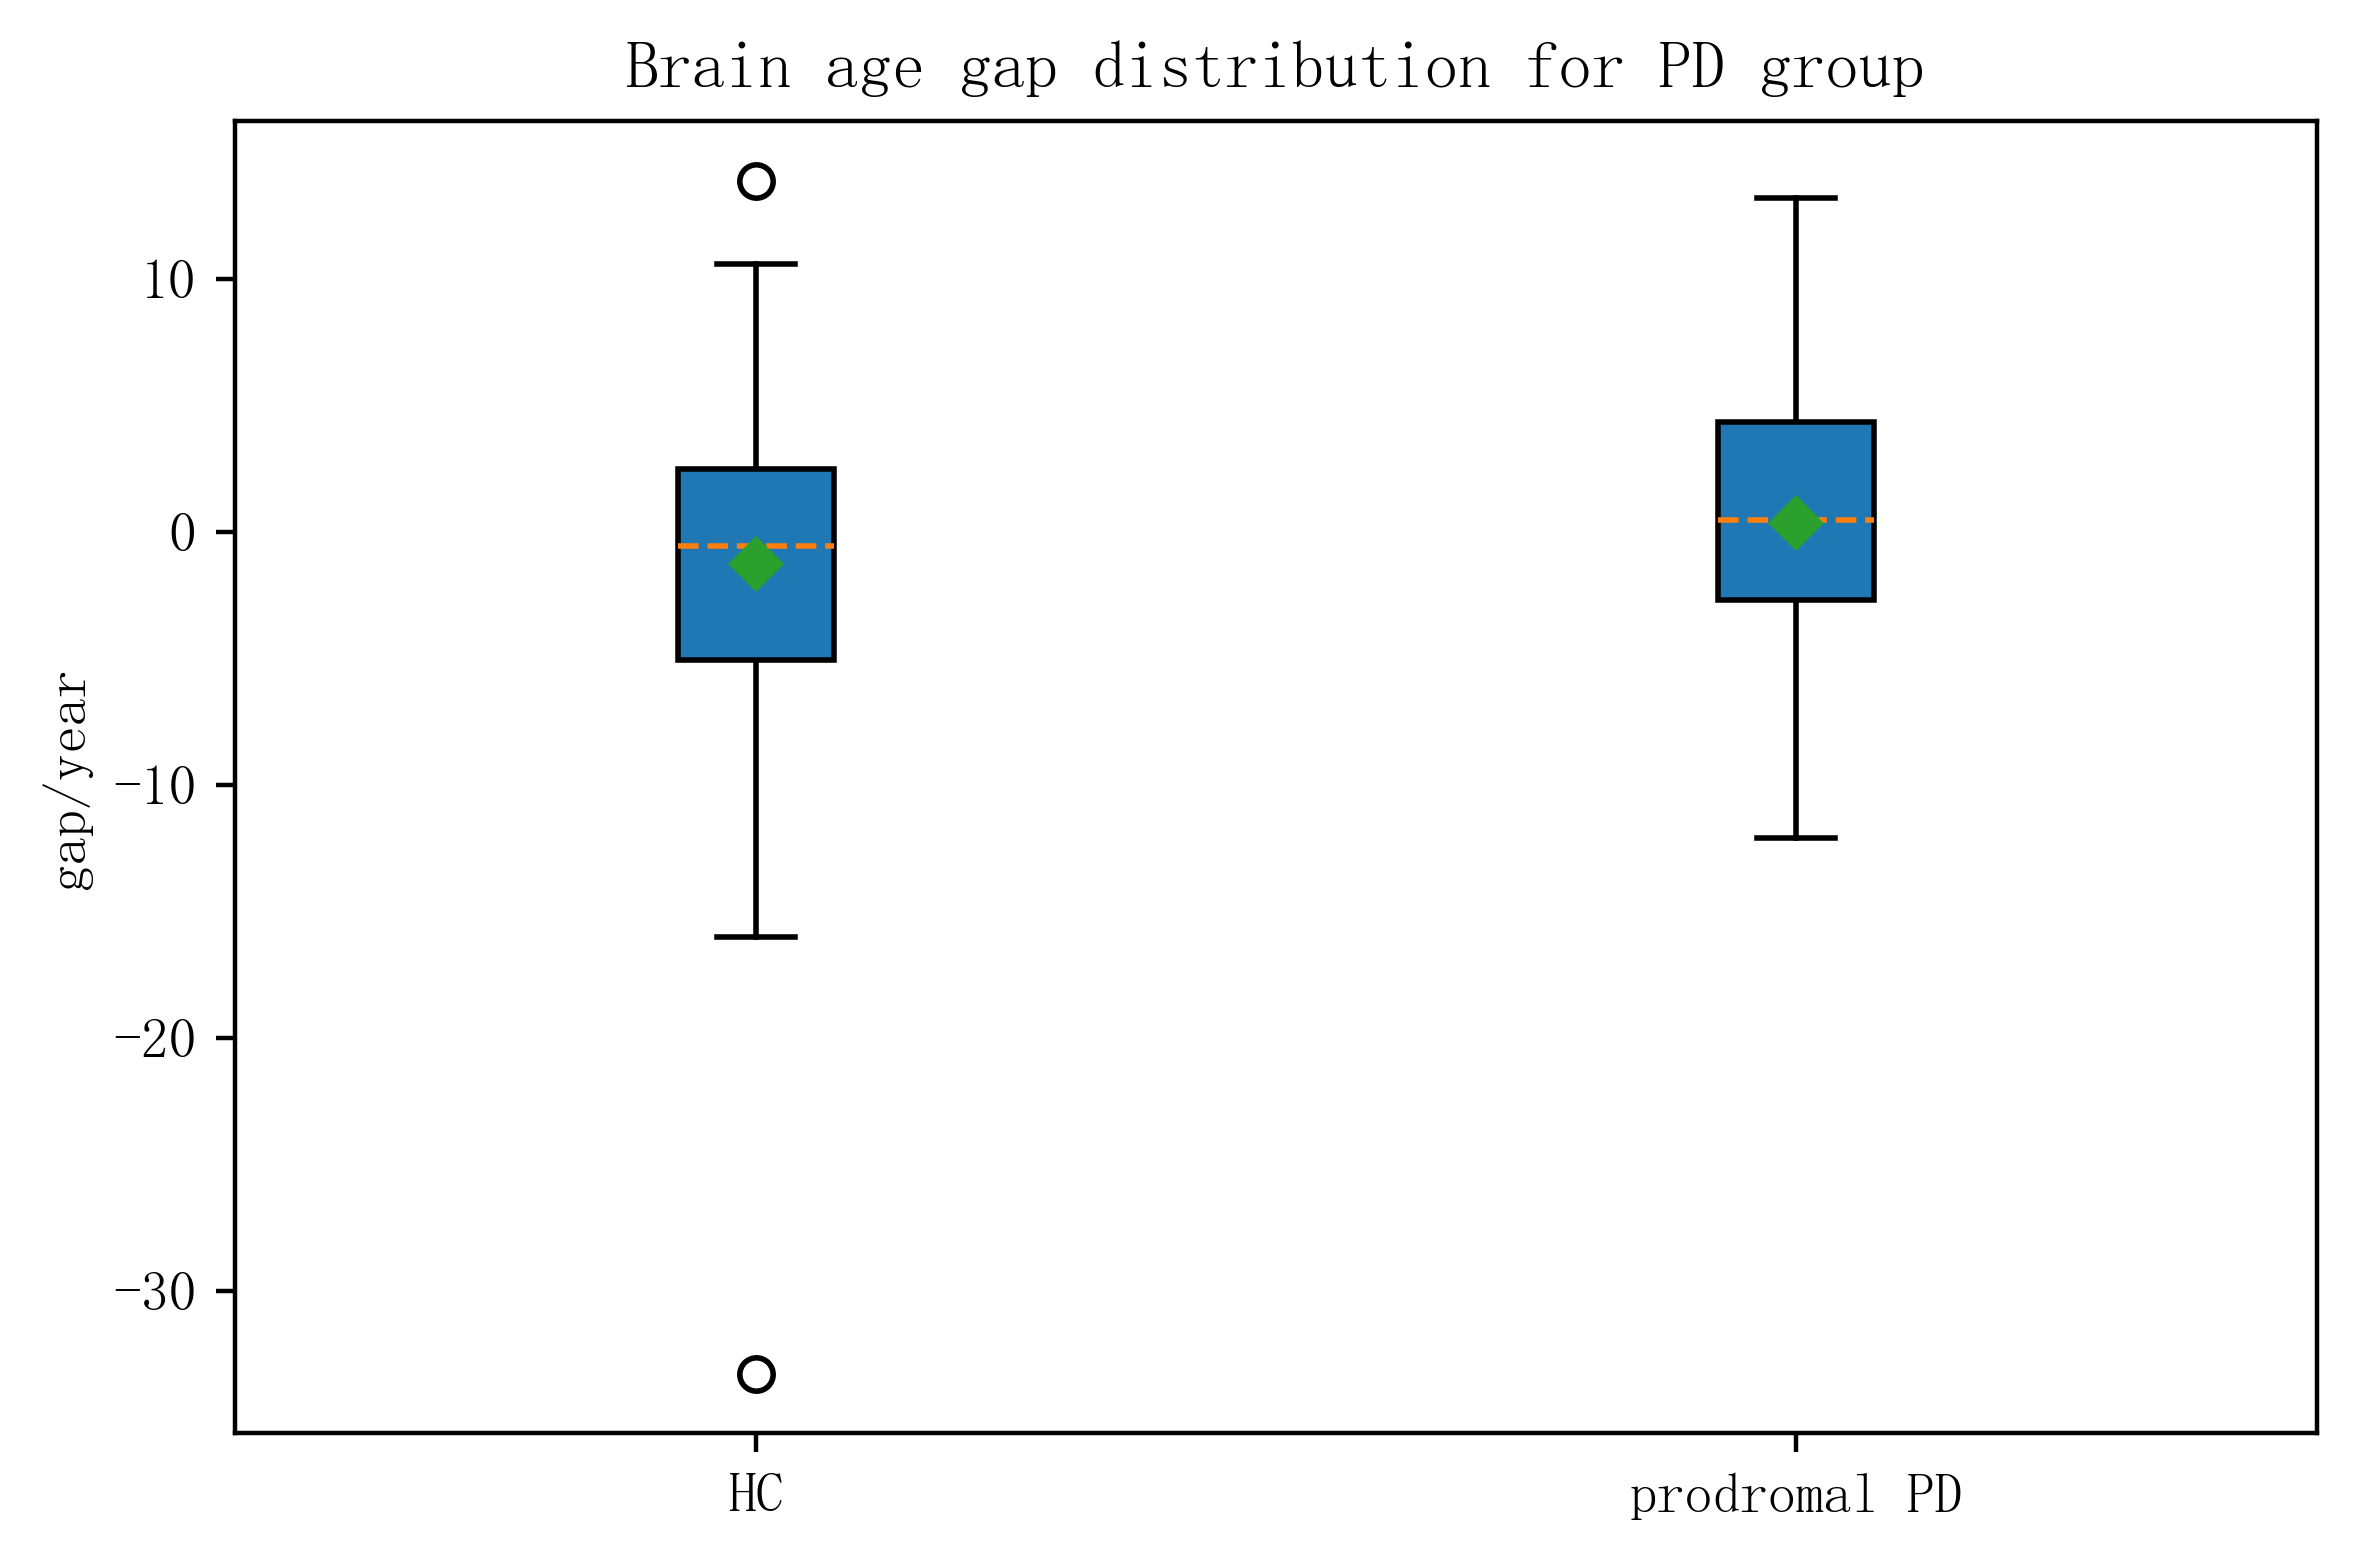

In [130]:
###########################HC/RBD/PD脑龄预测
data1 = pd.read_csv(r"D:\rc\paper\csv\data5\filter_HC_baseline.csv")
data2 = pd.read_csv(r"D:\rc\paper\csv\data5\filter_prodromal_baseline.csv")

data_ls = [data1,data2]

for data in data_ls:
    X_test = data.drop(columns=['name','age'])
    y_test = data['age']
#     y_pred = np.zeros(len(y_test))
    model = joblib.load(r"D:\rc\paper\model\nonorm_paper_model_corr.m")
    y_pred = model.predict(X_test)
#     y_pred = y_pred + y_pre
    data['bias'] = y_pred - y_test

HC = data_ls[0]['bias']
PD = data_ls[1]['bias']

data = pd.DataFrame()
data['HC'] = HC
data['PD-prodromal'] = PD

# plt.figure(dpi=400)
# sns.kdeplot(data['HC'], shade=True, color='g')
# sns.kdeplot(data['PD-prodromal'], shade=True, color='r')
# plt.title('Brain age gap distribution for PD group')
# plt.show()

print("The mean gap of sMCI :", np.mean(HC), np.std(HC))
print("The mean gap of pMCI :", np.mean(PD), np.std(PD))

print("The tukey HSD between sMCI and pMCI :", get_p(HC,PD))

plt.figure(dpi=400)
plt.boxplot(x = [HC,PD], # 指定绘图数据
            patch_artist=True, # 要求用自定义颜色填充盒形图，默认白色填充
            labels=['HC','prodromal PD'],
            showmeans=True, # 以点的形式显示均值
            boxprops = {'color':'black'}, # 设置箱体属性，填充色和边框色
            flierprops = {'marker':'o'}, # 设置异常值属性，点的形状、填充色和边框色
            meanprops = {'marker':'D'}, # 设置均值点的属性，点的形状、填充色
            medianprops = {'linestyle':'--'}) # 设置中位数线的属性，线的类型和颜色
 
# 去除箱线图的上边框与右边框的刻度标签
plt.tick_params(top='off', right='off')
plt.title('Brain age gap distribution for PD group')
# plt.title('brain age gap',fontsize=11)
# plt.xticks(fontsize=11)
# plt.yticks(fontsize=11)
# plt.xlabel('实际年龄', fontsize=15)
plt.ylabel('gap/year')
# plt.subplots_adjust(left=0.15)
# plt.legend(fontsize=20)
# plt.savefig(r"D:\rc\paper\figure1\fig2.png", dpi=400)
plt.show()                 

C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:87: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:87: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:87: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:87: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:87: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:87: DeprecationWarning: scipy.interp is depr

ACC = 0.4889 ± 0.1076
SEN = 0.4550 ± 0.1981
SPE = 0.5100 ± 0.2395
AUC = 0.5729 ± 0.1513
ACC = 0.5256 ± 0.1428
SEN = 0.3850 ± 0.2560
SPE = 0.6400 ± 0.2205
AUC = 0.4866 ± 0.2078
ACC = 0.7300 ± 0.1118
SEN = 0.6050 ± 0.1863
SPE = 0.8333 ± 0.1202
AUC = 0.7636 ± 0.1431


C:\Users\Lenovo\Anaconda3\lib\site-packages\matplotlib\figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


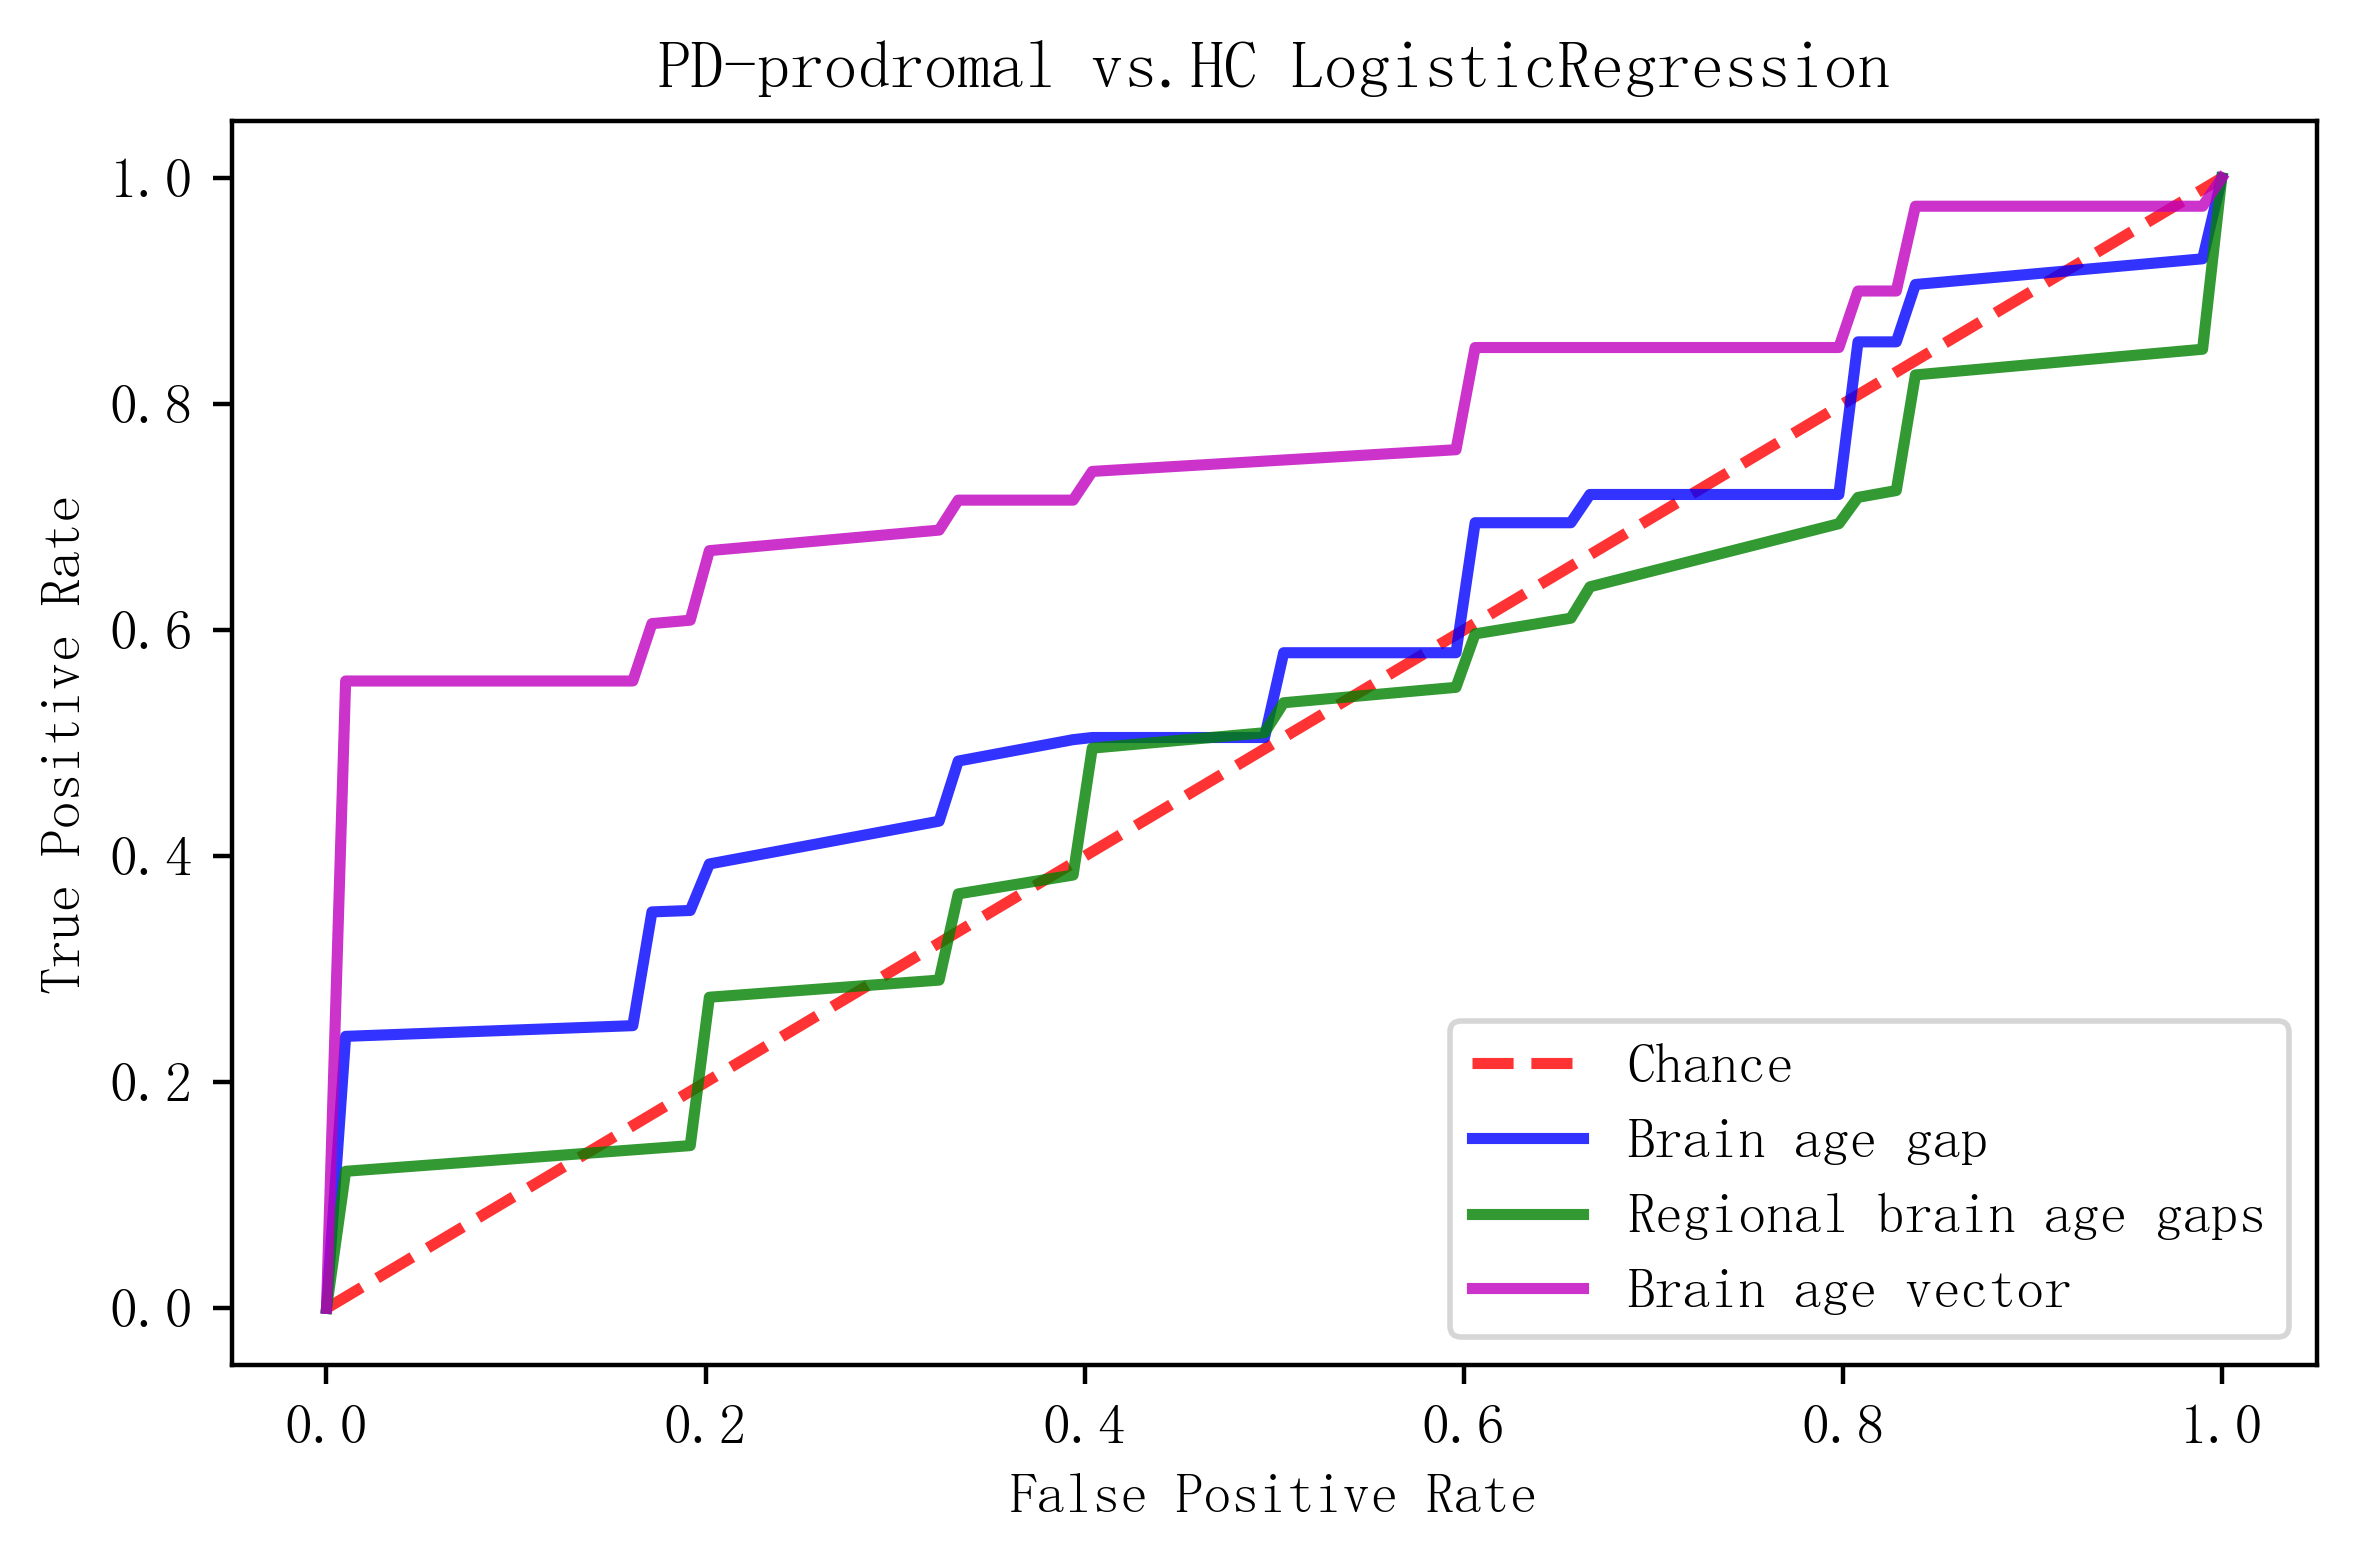

In [72]:
config = {
    "font.family":'serif',
    "font.size": 10,
    "mathtext.fontset": 'stix',
    "font.serif": ['SimSun'],

}
mpl.rcParams.update(config)


data1 = pd.read_csv(r"D:\rc\paper\csv\data5\shap_values_prodromal.csv")
data2 = pd.read_csv(r"D:\rc\paper\csv\data5\filter_prodromal_baseline.csv")
data3 = pd.read_csv(r"D:\rc\paper\csv\data5\shap_values_HC.csv")
data4 = pd.read_csv(r"D:\rc\paper\csv\data5\filter_HC_baseline.csv")
data1['age'] = data2['age']
data3['age'] = data4['age']
data1['label'] = 1
data3['label'] = 0
data0 = pd.concat([data1,data3]).reset_index(drop=True)

y2 = data0.loc[:,'label']
X2 = data0.drop(columns=['label']).fillna(0)

gaps0 = pd.read_csv(r"D:\rc\paper\csv\data5\gap_HC.csv")
gaps1 = pd.read_csv(r"D:\rc\paper\csv\data5\gap_prodromal.csv")
gaps0['age'] = data4['age']
gaps0['sex'] = data4['sex']
gaps1['age'] = data2['age']
gaps1['sex'] = data2['sex']
gaps0['label'] = 0
gaps1['label'] = 1

gaps = pd.concat([gaps0,gaps1]).reset_index(drop=True)

y = gaps.loc[:,'label']
y1 = gaps.loc[:,'label']
use = ['bias','sex','age']
X = gaps[use]
X1 = gaps.drop(columns=['bias','name','label'])


cv = StratifiedKFold(n_splits=10)
######## 17
classifier = lr(max_iter=2000)
classifier1 = lr(max_iter=2000)
classifier2 = lr(max_iter=2000)
# classifier = xgb.XGBClassifier()
# classifier1 = xgb.XGBClassifier()
# classifier = GaussianNB()
# classifier1 = GaussianNB()
classifier = rfc(random_state=12)
classifier1 = rfc(random_state=12)
classifier2 = rfc(random_state=12)


tprs = []
aucs = []

accs = []
sens = []
spes = []
aucss = []

mean_fpr = np.linspace(0, 1, 100)

for train, test in cv.split(X, y):
    features = X.drop(columns=['sex']).columns
    X_train = X.loc[train,:]
    X_test = X.loc[test,:]
    
    for fea in features:
        max = np.max(X_train[fea])
        min = np.min(X_train[fea])
        X_train[fea] = MinMaxNormalization(X_train[fea], max, min)
        X_test[fea] = MinMaxNormalization(X_test[fea], max, min)
        
    enc = OneHotEncoder()
    enc.fit(X_train['sex'].values.reshape(-1, 1))
    X_train['sex'] = enc.transform(X_train['sex'].values.reshape(-1, 1)).toarray()
    X_test['sex'] = enc.transform(X_test['sex'].values.reshape(-1, 1)).toarray()
    
    model = classifier.fit(X_train, y[train])
    probas_ = model.predict_proba(X_test)
    y_pred = model.predict(X_test)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    accs.append(accuracy_score(y[test],y_pred))
    sens.append(recall_score(y[test], y_pred, average='binary'))
    spes.append(get_spe(y[test], y_pred))
    aucss.append(roc_auc_score(y[test], probas_[:, 1]))
#     plt.plot(fpr, tpr, lw=1, alpha=0.3,
#              label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))


tprs1 = []
aucs1 = []

accs1 = []
sens1 = []
spes1 = []
aucss1 = []

mean_fpr1 = np.linspace(0, 1, 100)
    
for train, test in cv.split(X1, y1):
    features = X1.columns
    X1_train = X1.loc[train,:]
    X1_test = X1.loc[test,:]
    
    for fea in features:
        max = np.max(X1_train[fea])
        min = np.min(X1_train[fea])
        X1_train[fea] = MinMaxNormalization(X1_train[fea], max, min)
        X1_test[fea] = MinMaxNormalization(X1_test[fea], max, min)
    
    enc = OneHotEncoder()
    enc.fit(X1_train['sex'].values.reshape(-1, 1))
    X1_train['sex'] = enc.transform(X1_train['sex'].values.reshape(-1, 1)).toarray()
    X1_test['sex'] = enc.transform(X1_test['sex'].values.reshape(-1, 1)).toarray()
    
    model1 = classifier1.fit(X1_train, y1[train])
    probas_ = model1.predict_proba(X1_test)
    y_pred = model1.predict(X1_test)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y1[test], probas_[:, 1])
    tprs1.append(interp(mean_fpr1, fpr, tpr))
    tprs1[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs1.append(roc_auc)
    accs1.append(accuracy_score(y1[test],y_pred))
    sens1.append(recall_score(y1[test], y_pred, average='binary'))
    spes1.append(get_spe(y1[test], y_pred))
    aucss1.append(roc_auc_score(y1[test], probas_[:, 1]))
#     plt.plot(fpr, tpr, lw=1, alpha=0.3,
#              label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))


tprs2 = []
aucs2 = []

accs2 = []
sens2 = []
spes2 = []
aucss2 = []

mean_fpr2 = np.linspace(0, 1, 100)
    
for train, test in cv.split(X2, y2):
    features = X2.columns
    X2_train = X2.loc[train,:]
    X2_test = X2.loc[test,:]
    
    for fea in features:
        max = np.max(X2_train[fea])
        min = np.min(X2_train[fea])
        X2_train[fea] = MinMaxNormalization(X2_train[fea], max, min)
        X2_test[fea] = MinMaxNormalization(X2_test[fea], max, min)
    
    model2 = classifier2.fit(X2_train, y2[train])
    probas_ = model2.predict_proba(X2_test)
    y_pred = model2.predict(X2_test)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y2[test], probas_[:, 1])
    tprs2.append(interp(mean_fpr2, fpr, tpr))
    tprs2[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs2.append(roc_auc)
    accs2.append(accuracy_score(y2[test],y_pred))
    sens2.append(recall_score(y2[test], y_pred, average='binary'))
    spes2.append(get_spe(y2[test], y_pred))
    aucss2.append(roc_auc_score(y2[test], probas_[:, 1]))
#     plt.plot(fpr, tpr, lw=1, alpha=0.3,
#              label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))


plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_tpr1 = np.mean(tprs1, axis=0)
mean_tpr1[-1] = 1.0
mean_tpr2 = np.mean(tprs2, axis=0)
mean_tpr1[-1] = 1.0


# mean_auc = auc(mean_fpr, mean_tpr)
# std_auc = np.std(aucs)
print('ACC = %0.4f ± %0.4f' % (np.mean(accs),np.std(accs)))
print('SEN = %0.4f ± %0.4f' % (np.mean(sens),np.std(sens)))
print('SPE = %0.4f ± %0.4f' % (np.mean(spes),np.std(spes)))
print('AUC = %0.4f ± %0.4f' % (np.mean(aucss),np.std(aucss)))
print('ACC = %0.4f ± %0.4f' % (np.mean(accs1),np.std(accs1)))
print('SEN = %0.4f ± %0.4f' % (np.mean(sens1),np.std(sens1)))
print('SPE = %0.4f ± %0.4f' % (np.mean(spes1),np.std(spes1)))
print('AUC = %0.4f ± %0.4f' % (np.mean(aucss1),np.std(aucss1)))
print('ACC = %0.4f ± %0.4f' % (np.mean(accs2),np.std(accs2)))
print('SEN = %0.4f ± %0.4f' % (np.mean(sens2),np.std(sens2)))
print('SPE = %0.4f ± %0.4f' % (np.mean(spes2),np.std(spes2)))
print('AUC = %0.4f ± %0.4f' % (np.mean(aucss2),np.std(aucss2)))


plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Brain age gap',
         lw=2, alpha=.8)
plt.plot(mean_fpr1, mean_tpr1, color='g',
         label=r'Regional brain age gaps',
         lw=2, alpha=.8)
plt.plot(mean_fpr2, mean_tpr2, color='m',
         label=r'Brain age vector',
         lw=2, alpha=.8)
# std_tpr = np.std(tprs, axis=0)
# tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
# tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
# plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
#                  label=r'$\pm$ 1 std. dev.')

plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.dpi'] = 400
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('PD-prodromal vs.HC LogisticRegression')
plt.legend(loc="lower right")
# plt.savefig(r"D:\rc\paper\fig\PD_lr.png", dpi=400)
plt.show()    
    


C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:83: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:83: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:83: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:83: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:83: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:83: DeprecationWarning: scipy.interp is depr

ACC = 0.5433 ± 0.0695
SEN = 0.0250 ± 0.0750
SPE = 0.9500 ± 0.1067
AUC = 0.3658 ± 0.1658
ACC = 0.5767 ± 0.1213
SEN = 0.3100 ± 0.1546
SPE = 0.7867 ± 0.1845
AUC = 0.5973 ± 0.1216
ACC = 0.6544 ± 0.1275
SEN = 0.5300 ± 0.2431
SPE = 0.7633 ± 0.1980
AUC = 0.6780 ± 0.1468


C:\Users\Lenovo\Anaconda3\lib\site-packages\matplotlib\figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


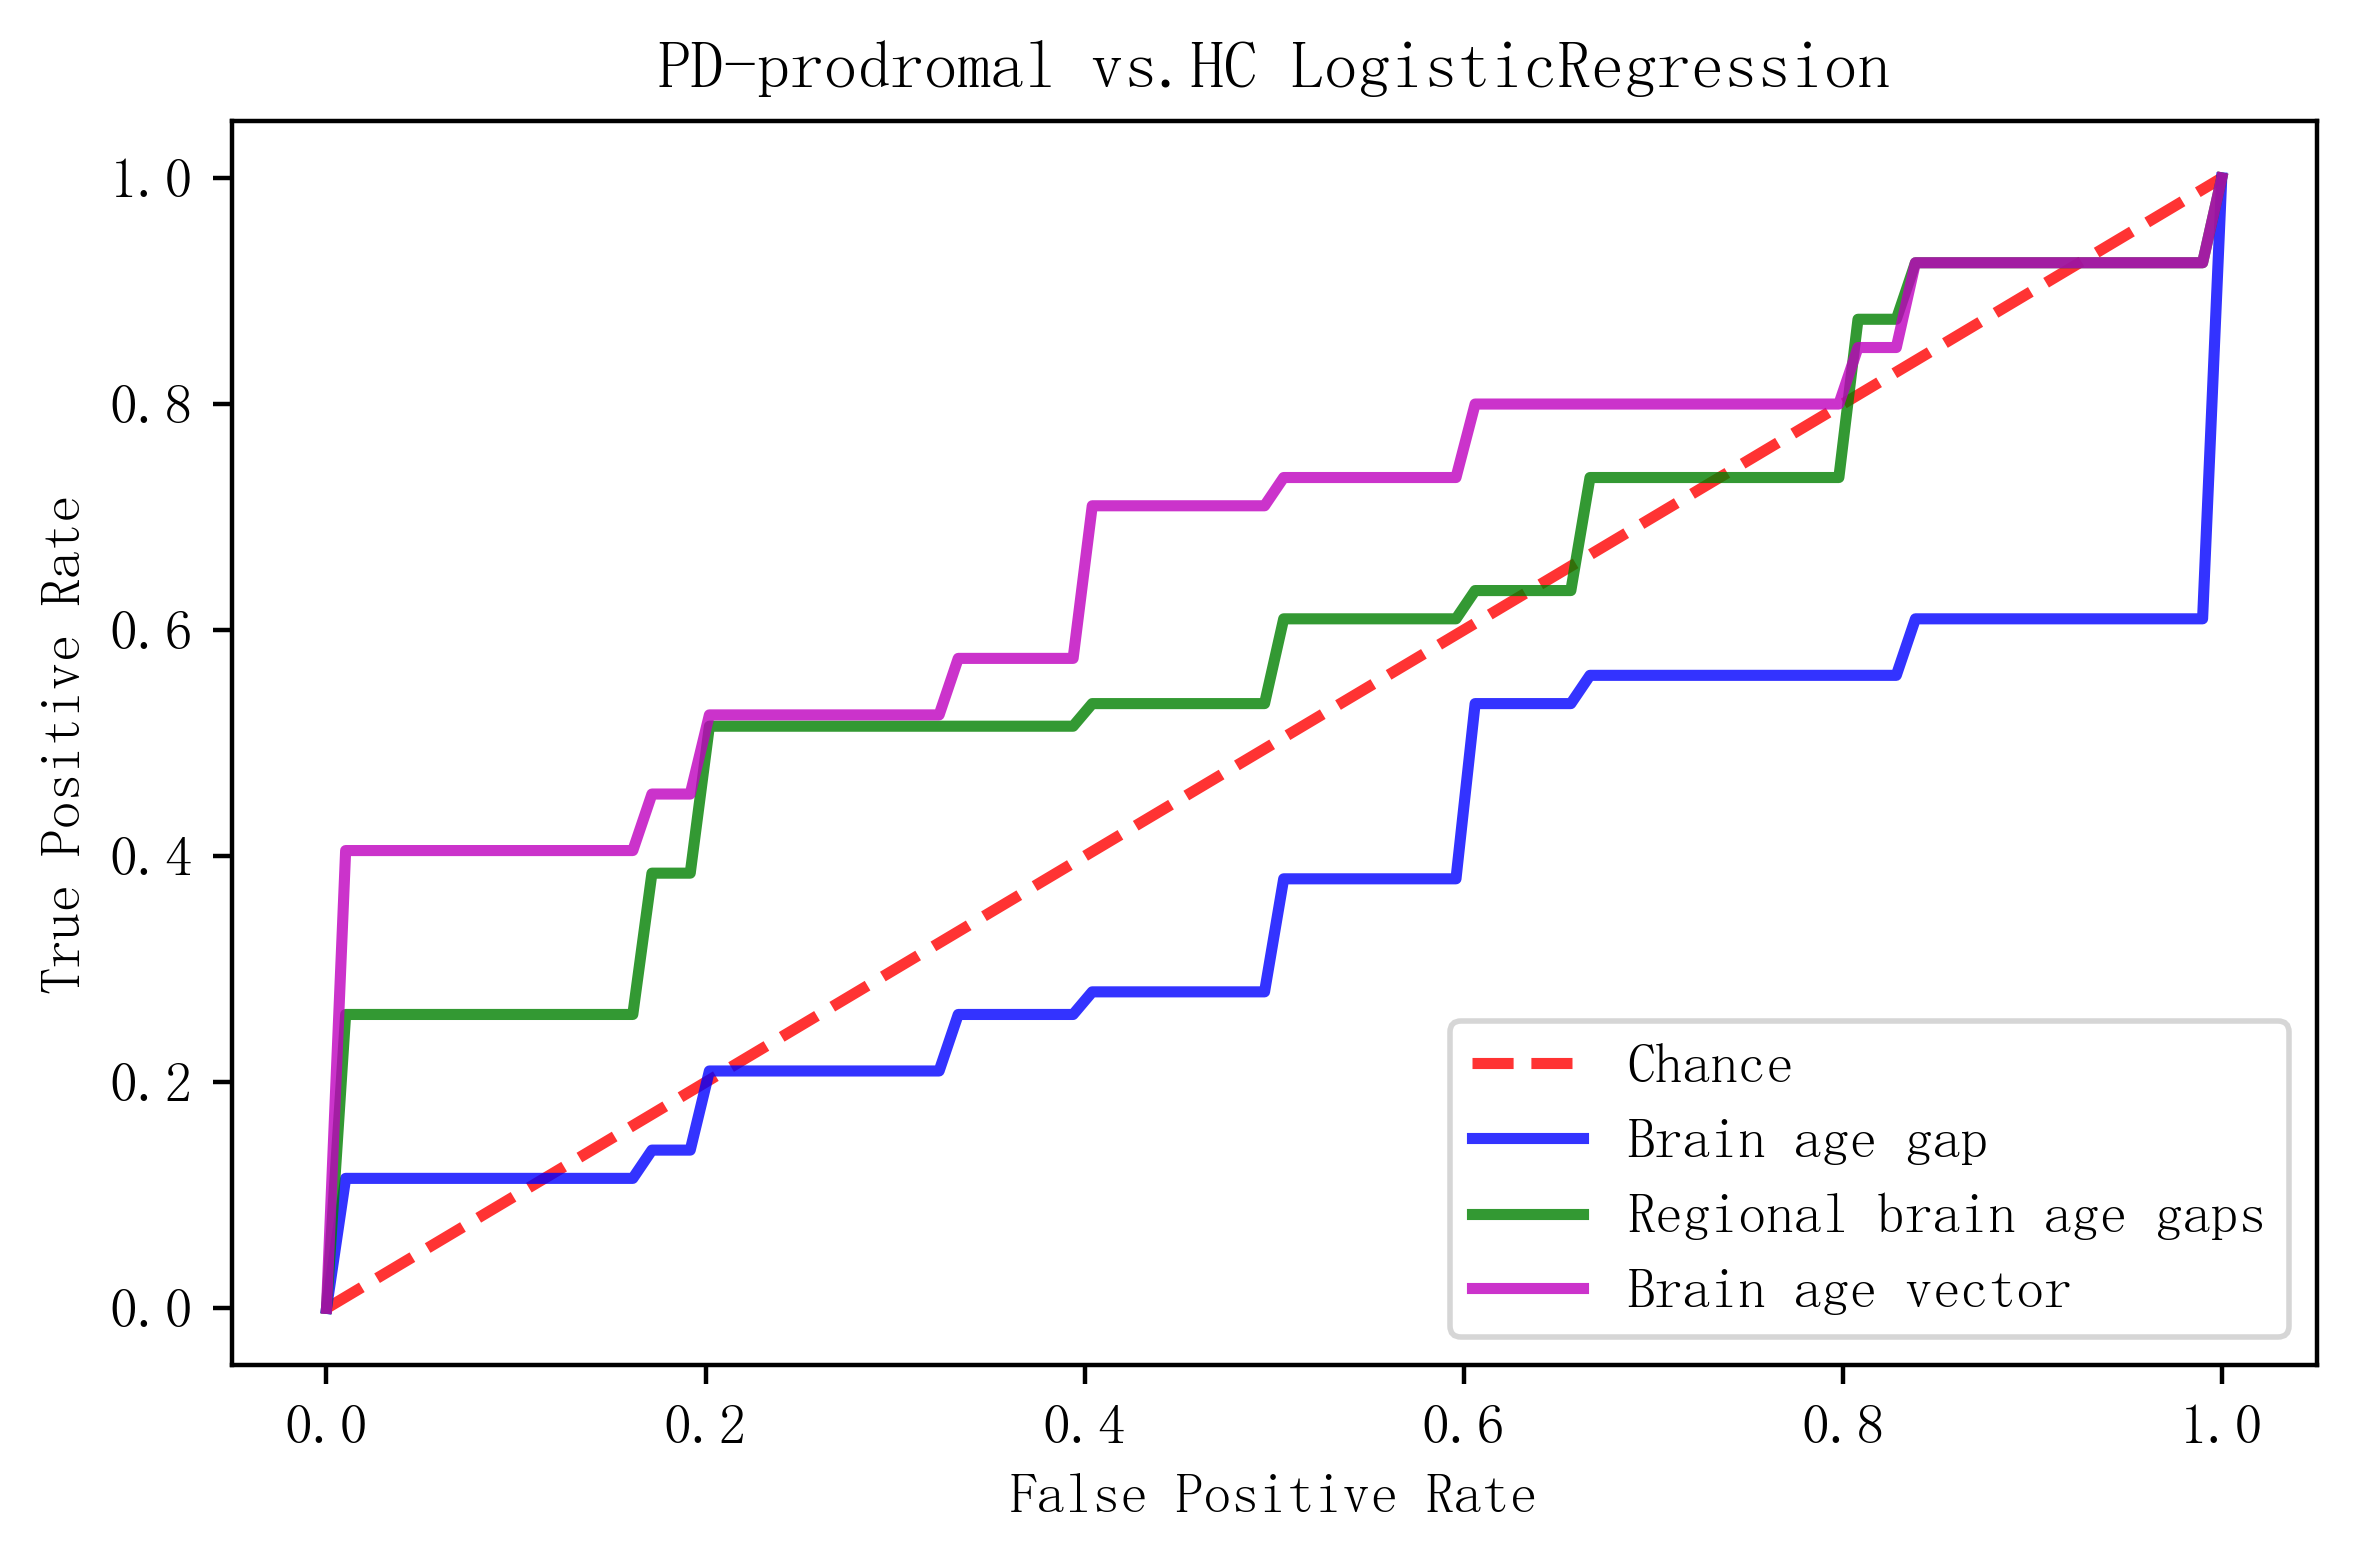

In [64]:
config = {
    "font.family":'serif',
    "font.size": 10,
    "mathtext.fontset": 'stix',
    "font.serif": ['SimSun'],

}
mpl.rcParams.update(config)


data1 = pd.read_csv(r"D:\rc\paper\csv\data5\shap_values_prodromal.csv")
data2 = pd.read_csv(r"D:\rc\paper\csv\data5\filter_prodromal_baseline.csv")
data3 = pd.read_csv(r"D:\rc\paper\csv\data5\shap_values_HC.csv")
data4 = pd.read_csv(r"D:\rc\paper\csv\data5\filter_HC_baseline.csv")
data1['age'] = data2['age']
data3['age'] = data4['age']
data1['label'] = 1
data3['label'] = 0
data0 = pd.concat([data1,data3]).reset_index(drop=True)

y2 = data0.loc[:,'label']
X2 = data0.drop(columns=['label']).fillna(0)

gaps0 = pd.read_csv(r"D:\rc\paper\csv\data5\gap_HC.csv")
gaps1 = pd.read_csv(r"D:\rc\paper\csv\data5\gap_prodromal.csv")
gaps0['age'] = data4['age']
gaps0['sex'] = data4['sex']
gaps1['age'] = data2['age']
gaps1['sex'] = data2['sex']
gaps0['label'] = 0
gaps1['label'] = 1

gaps = pd.concat([gaps0,gaps1]).reset_index(drop=True)

y = gaps.loc[:,'label']
y1 = gaps.loc[:,'label']
use = ['bias','sex','age']
X = gaps[use]
X1 = gaps.drop(columns=['bias','name','label'])


cv = StratifiedKFold(n_splits=10)
classifier = lr(max_iter=2000)
classifier1 = lr(max_iter=2000)
classifier2 = lr(max_iter=2000)
# classifier = xgb.XGBClassifier()
# classifier1 = xgb.XGBClassifier()
# classifier = GaussianNB()
# classifier1 = GaussianNB()


tprs = []
aucs = []

accs = []
sens = []
spes = []
aucss = []

mean_fpr = np.linspace(0, 1, 100)

for train, test in cv.split(X, y):
    features = X.drop(columns=['sex']).columns
    X_train = X.loc[train,:]
    X_test = X.loc[test,:]
    
    for fea in features:
        max = np.max(X_train[fea])
        min = np.min(X_train[fea])
        X_train[fea] = MinMaxNormalization(X_train[fea], max, min)
        X_test[fea] = MinMaxNormalization(X_test[fea], max, min)
        
    enc = OneHotEncoder()
    enc.fit(X_train['sex'].values.reshape(-1, 1))
    X_train['sex'] = enc.transform(X_train['sex'].values.reshape(-1, 1)).toarray()
    X_test['sex'] = enc.transform(X_test['sex'].values.reshape(-1, 1)).toarray()
    
    model = classifier.fit(X_train, y[train])
    probas_ = model.predict_proba(X_test)
    y_pred = model.predict(X_test)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    accs.append(accuracy_score(y[test],y_pred))
    sens.append(recall_score(y[test], y_pred, average='binary'))
    spes.append(get_spe(y[test], y_pred))
    aucss.append(roc_auc_score(y[test], probas_[:, 1]))
#     plt.plot(fpr, tpr, lw=1, alpha=0.3,
#              label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))


tprs1 = []
aucs1 = []

accs1 = []
sens1 = []
spes1 = []
aucss1 = []

mean_fpr1 = np.linspace(0, 1, 100)
    
for train, test in cv.split(X1, y1):
    features = X1.columns
    X1_train = X1.loc[train,:]
    X1_test = X1.loc[test,:]
    
    for fea in features:
        max = np.max(X1_train[fea])
        min = np.min(X1_train[fea])
        X1_train[fea] = MinMaxNormalization(X1_train[fea], max, min)
        X1_test[fea] = MinMaxNormalization(X1_test[fea], max, min)
    
    enc = OneHotEncoder()
    enc.fit(X1_train['sex'].values.reshape(-1, 1))
    X1_train['sex'] = enc.transform(X1_train['sex'].values.reshape(-1, 1)).toarray()
    X1_test['sex'] = enc.transform(X1_test['sex'].values.reshape(-1, 1)).toarray()
    
    model1 = classifier1.fit(X1_train, y1[train])
    probas_ = model1.predict_proba(X1_test)
    y_pred = model1.predict(X1_test)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y1[test], probas_[:, 1])
    tprs1.append(interp(mean_fpr1, fpr, tpr))
    tprs1[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs1.append(roc_auc)
    accs1.append(accuracy_score(y1[test],y_pred))
    sens1.append(recall_score(y1[test], y_pred, average='binary'))
    spes1.append(get_spe(y1[test], y_pred))
    aucss1.append(roc_auc_score(y1[test], probas_[:, 1]))
#     plt.plot(fpr, tpr, lw=1, alpha=0.3,
#              label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))


tprs2 = []
aucs2 = []

accs2 = []
sens2 = []
spes2 = []
aucss2 = []

mean_fpr2 = np.linspace(0, 1, 100)
    
for train, test in cv.split(X2, y2):
    features = X2.columns
    X2_train = X2.loc[train,:]
    X2_test = X2.loc[test,:]
    
    for fea in features:
        max = np.max(X2_train[fea])
        min = np.min(X2_train[fea])
        X2_train[fea] = MinMaxNormalization(X2_train[fea], max, min)
        X2_test[fea] = MinMaxNormalization(X2_test[fea], max, min)
    
    model2 = classifier2.fit(X2_train, y2[train])
    probas_ = model2.predict_proba(X2_test)
    y_pred = model2.predict(X2_test)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y2[test], probas_[:, 1])
    tprs2.append(interp(mean_fpr2, fpr, tpr))
    tprs2[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs2.append(roc_auc)
    accs2.append(accuracy_score(y2[test],y_pred))
    sens2.append(recall_score(y2[test], y_pred, average='binary'))
    spes2.append(get_spe(y2[test], y_pred))
    aucss2.append(roc_auc_score(y2[test], probas_[:, 1]))
#     plt.plot(fpr, tpr, lw=1, alpha=0.3,
#              label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))


plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_tpr1 = np.mean(tprs1, axis=0)
mean_tpr1[-1] = 1.0
mean_tpr2 = np.mean(tprs2, axis=0)
mean_tpr1[-1] = 1.0


# mean_auc = auc(mean_fpr, mean_tpr)
# std_auc = np.std(aucs)
print('ACC = %0.4f ± %0.4f' % (np.mean(accs),np.std(accs)))
print('SEN = %0.4f ± %0.4f' % (np.mean(sens),np.std(sens)))
print('SPE = %0.4f ± %0.4f' % (np.mean(spes),np.std(spes)))
print('AUC = %0.4f ± %0.4f' % (np.mean(aucss),np.std(aucss)))
print('ACC = %0.4f ± %0.4f' % (np.mean(accs1),np.std(accs1)))
print('SEN = %0.4f ± %0.4f' % (np.mean(sens1),np.std(sens1)))
print('SPE = %0.4f ± %0.4f' % (np.mean(spes1),np.std(spes1)))
print('AUC = %0.4f ± %0.4f' % (np.mean(aucss1),np.std(aucss1)))
print('ACC = %0.4f ± %0.4f' % (np.mean(accs2),np.std(accs2)))
print('SEN = %0.4f ± %0.4f' % (np.mean(sens2),np.std(sens2)))
print('SPE = %0.4f ± %0.4f' % (np.mean(spes2),np.std(spes2)))
print('AUC = %0.4f ± %0.4f' % (np.mean(aucss2),np.std(aucss2)))


plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Brain age gap',
         lw=2, alpha=.8)
plt.plot(mean_fpr1, mean_tpr1, color='g',
         label=r'Regional brain age gaps',
         lw=2, alpha=.8)
plt.plot(mean_fpr2, mean_tpr2, color='m',
         label=r'Brain age vector',
         lw=2, alpha=.8)
# std_tpr = np.std(tprs, axis=0)
# tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
# tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
# plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
#                  label=r'$\pm$ 1 std. dev.')

plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.dpi'] = 400
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('PD-prodromal vs.HC LogisticRegression')
plt.legend(loc="lower right")
plt.savefig(r"D:\rc\paper\fig\PD_lr.png", dpi=400)
plt.show()    
    


C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:83: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:83: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:83: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:83: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:83: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:83: DeprecationWarning: scipy.interp is depr

ACC = 0.3944 ± 0.1476
SEN = 0.3150 ± 0.2460
SPE = 0.4633 ± 0.2248
AUC = 0.4173 ± 0.1475
ACC = 0.5356 ± 0.1683
SEN = 0.5300 ± 0.2900
SPE = 0.5467 ± 0.1910
AUC = 0.5668 ± 0.2143
ACC = 0.5500 ± 0.1033
SEN = 0.5850 ± 0.2899
SPE = 0.5300 ± 0.2838
AUC = 0.6309 ± 0.1547


C:\Users\Lenovo\Anaconda3\lib\site-packages\matplotlib\figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


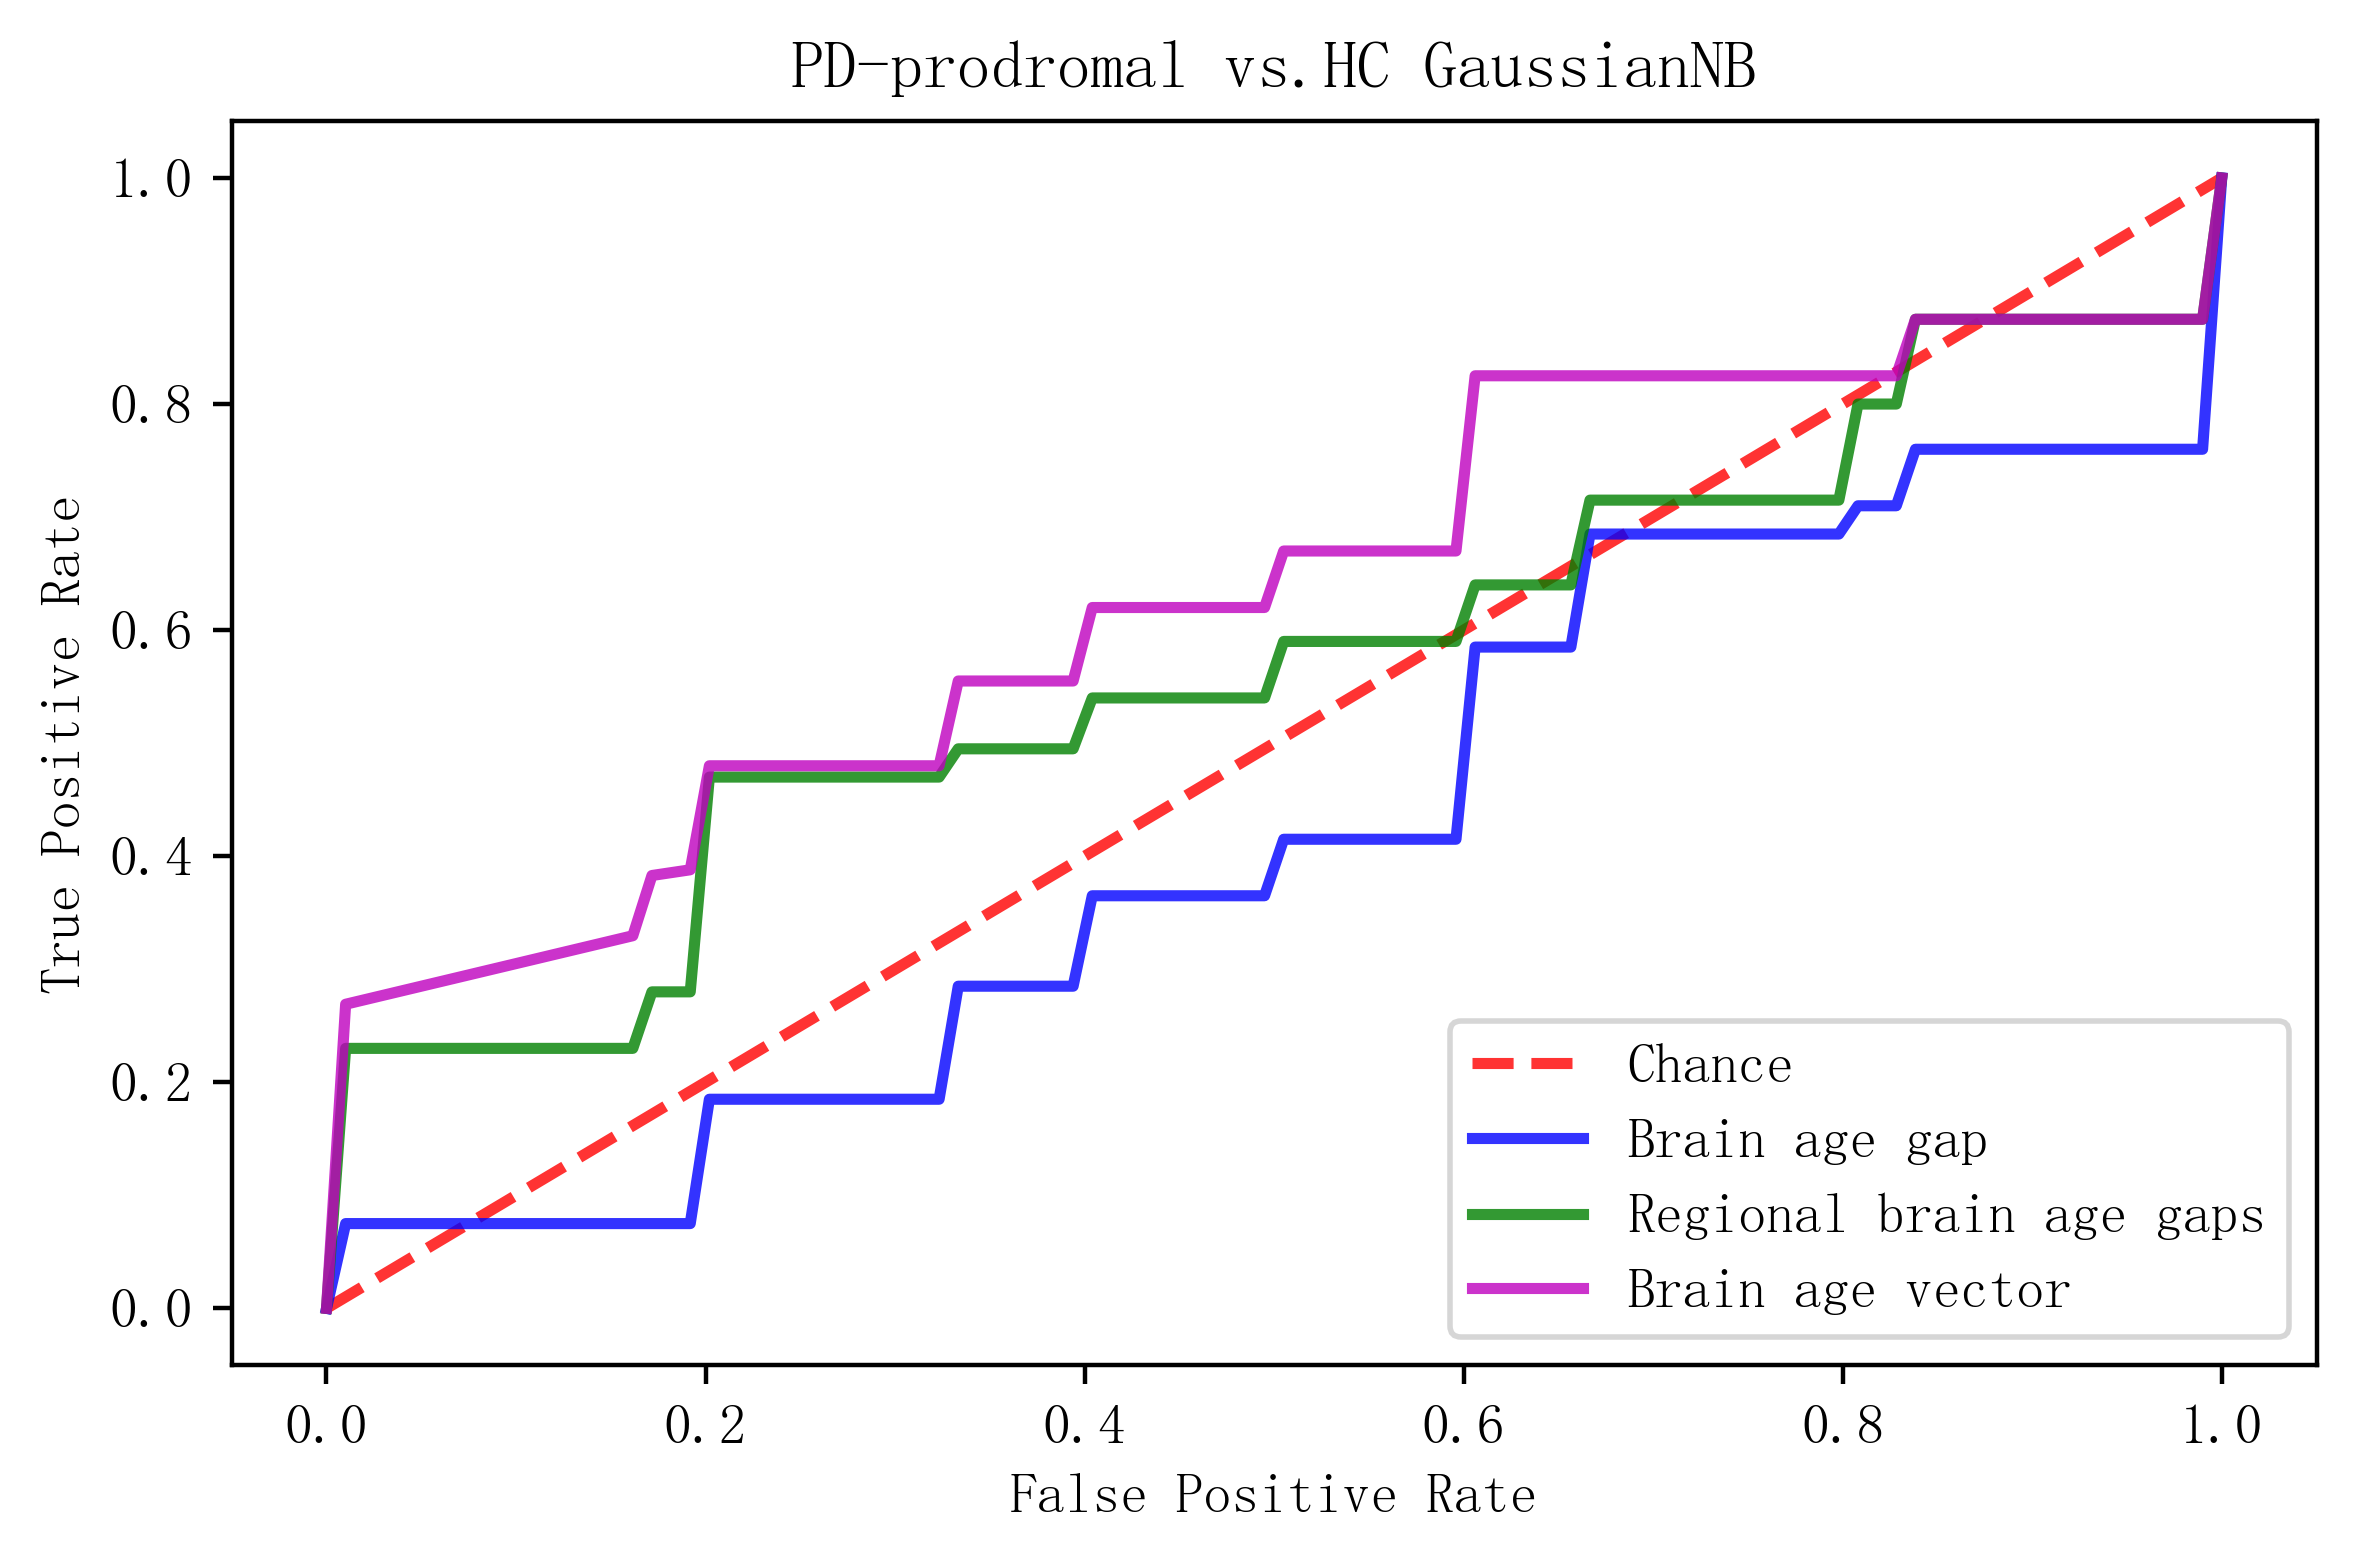

In [24]:
config = {
    "font.family":'serif',
    "font.size": 10,
    "mathtext.fontset": 'stix',
    "font.serif": ['SimSun'],

}
mpl.rcParams.update(config)


data1 = pd.read_csv(r"D:\rc\paper\csv\data5\shap_values_prodromal.csv")
data2 = pd.read_csv(r"D:\rc\paper\csv\data5\filter_prodromal_baseline.csv")
data3 = pd.read_csv(r"D:\rc\paper\csv\data5\shap_values_HC.csv")
data4 = pd.read_csv(r"D:\rc\paper\csv\data5\filter_HC_baseline.csv")
data1['age'] = data2['age']
data3['age'] = data4['age']
data1['label'] = 1
data3['label'] = 0
data0 = pd.concat([data1,data3]).reset_index(drop=True)

y2 = data0.loc[:,'label']
X2 = data0.drop(columns=['label']).fillna(0)

gaps0 = pd.read_csv(r"D:\rc\paper\csv\data5\gap_HC.csv")
gaps1 = pd.read_csv(r"D:\rc\paper\csv\data5\gap_prodromal.csv")
gaps0['age'] = data4['age']
gaps0['sex'] = data4['sex']
gaps1['age'] = data2['age']
gaps1['sex'] = data2['sex']
gaps0['label'] = 0
gaps1['label'] = 1

gaps = pd.concat([gaps0,gaps1]).reset_index(drop=True)

y = gaps.loc[:,'label']
y1 = gaps.loc[:,'label']
use = ['bias','sex','age']
X = gaps[use]
X1 = gaps.drop(columns=['bias','name','label'])


cv = StratifiedKFold(n_splits=10)
classifier = GaussianNB()
classifier1 = GaussianNB()
classifier2 = GaussianNB()
# classifier = xgb.XGBClassifier()
# classifier1 = xgb.XGBClassifier()
# classifier = GaussianNB()
# classifier1 = GaussianNB()


tprs = []
aucs = []

accs = []
sens = []
spes = []
aucss = []

mean_fpr = np.linspace(0, 1, 100)

for train, test in cv.split(X, y):
    features = X.drop(columns=['sex']).columns
    X_train = X.loc[train,:]
    X_test = X.loc[test,:]
    
    for fea in features:
        max = np.max(X_train[fea])
        min = np.min(X_train[fea])
        X_train[fea] = MinMaxNormalization(X_train[fea], max, min)
        X_test[fea] = MinMaxNormalization(X_test[fea], max, min)
        
    enc = OneHotEncoder()
    enc.fit(X_train['sex'].values.reshape(-1, 1))
    X_train['sex'] = enc.transform(X_train['sex'].values.reshape(-1, 1)).toarray()
    X_test['sex'] = enc.transform(X_test['sex'].values.reshape(-1, 1)).toarray()
    
    model = classifier.fit(X_train, y[train])
    probas_ = model.predict_proba(X_test)
    y_pred = model.predict(X_test)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    accs.append(accuracy_score(y[test],y_pred))
    sens.append(recall_score(y[test], y_pred, average='binary'))
    spes.append(get_spe(y[test], y_pred))
    aucss.append(roc_auc_score(y[test], probas_[:, 1]))
#     plt.plot(fpr, tpr, lw=1, alpha=0.3,
#              label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))


tprs1 = []
aucs1 = []

accs1 = []
sens1 = []
spes1 = []
aucss1 = []

mean_fpr1 = np.linspace(0, 1, 100)
    
for train, test in cv.split(X1, y1):
    features = X1.columns
    X1_train = X1.loc[train,:]
    X1_test = X1.loc[test,:]
    
    for fea in features:
        max = np.max(X1_train[fea])
        min = np.min(X1_train[fea])
        X1_train[fea] = MinMaxNormalization(X1_train[fea], max, min)
        X1_test[fea] = MinMaxNormalization(X1_test[fea], max, min)
    
    enc = OneHotEncoder()
    enc.fit(X1_train['sex'].values.reshape(-1, 1))
    X1_train['sex'] = enc.transform(X1_train['sex'].values.reshape(-1, 1)).toarray()
    X1_test['sex'] = enc.transform(X1_test['sex'].values.reshape(-1, 1)).toarray()
    
    model1 = classifier1.fit(X1_train, y1[train])
    probas_ = model1.predict_proba(X1_test)
    y_pred = model1.predict(X1_test)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y1[test], probas_[:, 1])
    tprs1.append(interp(mean_fpr1, fpr, tpr))
    tprs1[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs1.append(roc_auc)
    accs1.append(accuracy_score(y1[test],y_pred))
    sens1.append(recall_score(y1[test], y_pred, average='binary'))
    spes1.append(get_spe(y1[test], y_pred))
    aucss1.append(roc_auc_score(y1[test], probas_[:, 1]))
#     plt.plot(fpr, tpr, lw=1, alpha=0.3,
#              label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))


tprs2 = []
aucs2 = []

accs2 = []
sens2 = []
spes2 = []
aucss2 = []

mean_fpr2 = np.linspace(0, 1, 100)
    
for train, test in cv.split(X2, y2):
    features = X2.columns
    X2_train = X2.loc[train,:]
    X2_test = X2.loc[test,:]
    
    for fea in features:
        max = np.max(X2_train[fea])
        min = np.min(X2_train[fea])
        X2_train[fea] = MinMaxNormalization(X2_train[fea], max, min)
        X2_test[fea] = MinMaxNormalization(X2_test[fea], max, min)
    
    model2 = classifier2.fit(X2_train, y2[train])
    probas_ = model2.predict_proba(X2_test)
    y_pred = model2.predict(X2_test)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y2[test], probas_[:, 1])
    tprs2.append(interp(mean_fpr2, fpr, tpr))
    tprs2[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs2.append(roc_auc)
    accs2.append(accuracy_score(y2[test],y_pred))
    sens2.append(recall_score(y2[test], y_pred, average='binary'))
    spes2.append(get_spe(y2[test], y_pred))
    aucss2.append(roc_auc_score(y2[test], probas_[:, 1]))
#     plt.plot(fpr, tpr, lw=1, alpha=0.3,
#              label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))


plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_tpr1 = np.mean(tprs1, axis=0)
mean_tpr1[-1] = 1.0
mean_tpr2 = np.mean(tprs2, axis=0)
mean_tpr1[-1] = 1.0


# mean_auc = auc(mean_fpr, mean_tpr)
# std_auc = np.std(aucs)
print('ACC = %0.4f ± %0.4f' % (np.mean(accs),np.std(accs)))
print('SEN = %0.4f ± %0.4f' % (np.mean(sens),np.std(sens)))
print('SPE = %0.4f ± %0.4f' % (np.mean(spes),np.std(spes)))
print('AUC = %0.4f ± %0.4f' % (np.mean(aucss),np.std(aucss)))
print('ACC = %0.4f ± %0.4f' % (np.mean(accs1),np.std(accs1)))
print('SEN = %0.4f ± %0.4f' % (np.mean(sens1),np.std(sens1)))
print('SPE = %0.4f ± %0.4f' % (np.mean(spes1),np.std(spes1)))
print('AUC = %0.4f ± %0.4f' % (np.mean(aucss1),np.std(aucss1)))
print('ACC = %0.4f ± %0.4f' % (np.mean(accs2),np.std(accs2)))
print('SEN = %0.4f ± %0.4f' % (np.mean(sens2),np.std(sens2)))
print('SPE = %0.4f ± %0.4f' % (np.mean(spes2),np.std(spes2)))
print('AUC = %0.4f ± %0.4f' % (np.mean(aucss2),np.std(aucss2)))


plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Brain age gap',
         lw=2, alpha=.8)
plt.plot(mean_fpr1, mean_tpr1, color='g',
         label=r'Regional brain age gaps',
         lw=2, alpha=.8)
plt.plot(mean_fpr2, mean_tpr2, color='m',
         label=r'Brain age vector',
         lw=2, alpha=.8)
# std_tpr = np.std(tprs, axis=0)
# tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
# tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
# plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
#                  label=r'$\pm$ 1 std. dev.')

plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.dpi'] = 400
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('PD-prodromal vs.HC GaussianNB')
plt.legend(loc="lower right")
# plt.savefig(r"D:\rc\paper\fig\PD_lr.png", dpi=400)
plt.show()    
    


C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:87: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:87: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:87: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:87: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:87: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:87: DeprecationWarning: scipy.interp is depr

ACC = 0.6344 ± 0.2078
SEN = 0.5700 ± 0.2170
SPE = 0.6800 ± 0.3121
AUC = 0.7010 ± 0.2140
ACC = 0.6456 ± 0.1409
SEN = 0.5950 ± 0.2641
SPE = 0.6900 ± 0.2933
AUC = 0.7107 ± 0.1286
ACC = 0.7178 ± 0.0929
SEN = 0.6750 ± 0.2369
SPE = 0.7567 ± 0.1274
AUC = 0.8127 ± 0.1342


C:\Users\Lenovo\Anaconda3\lib\site-packages\matplotlib\figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


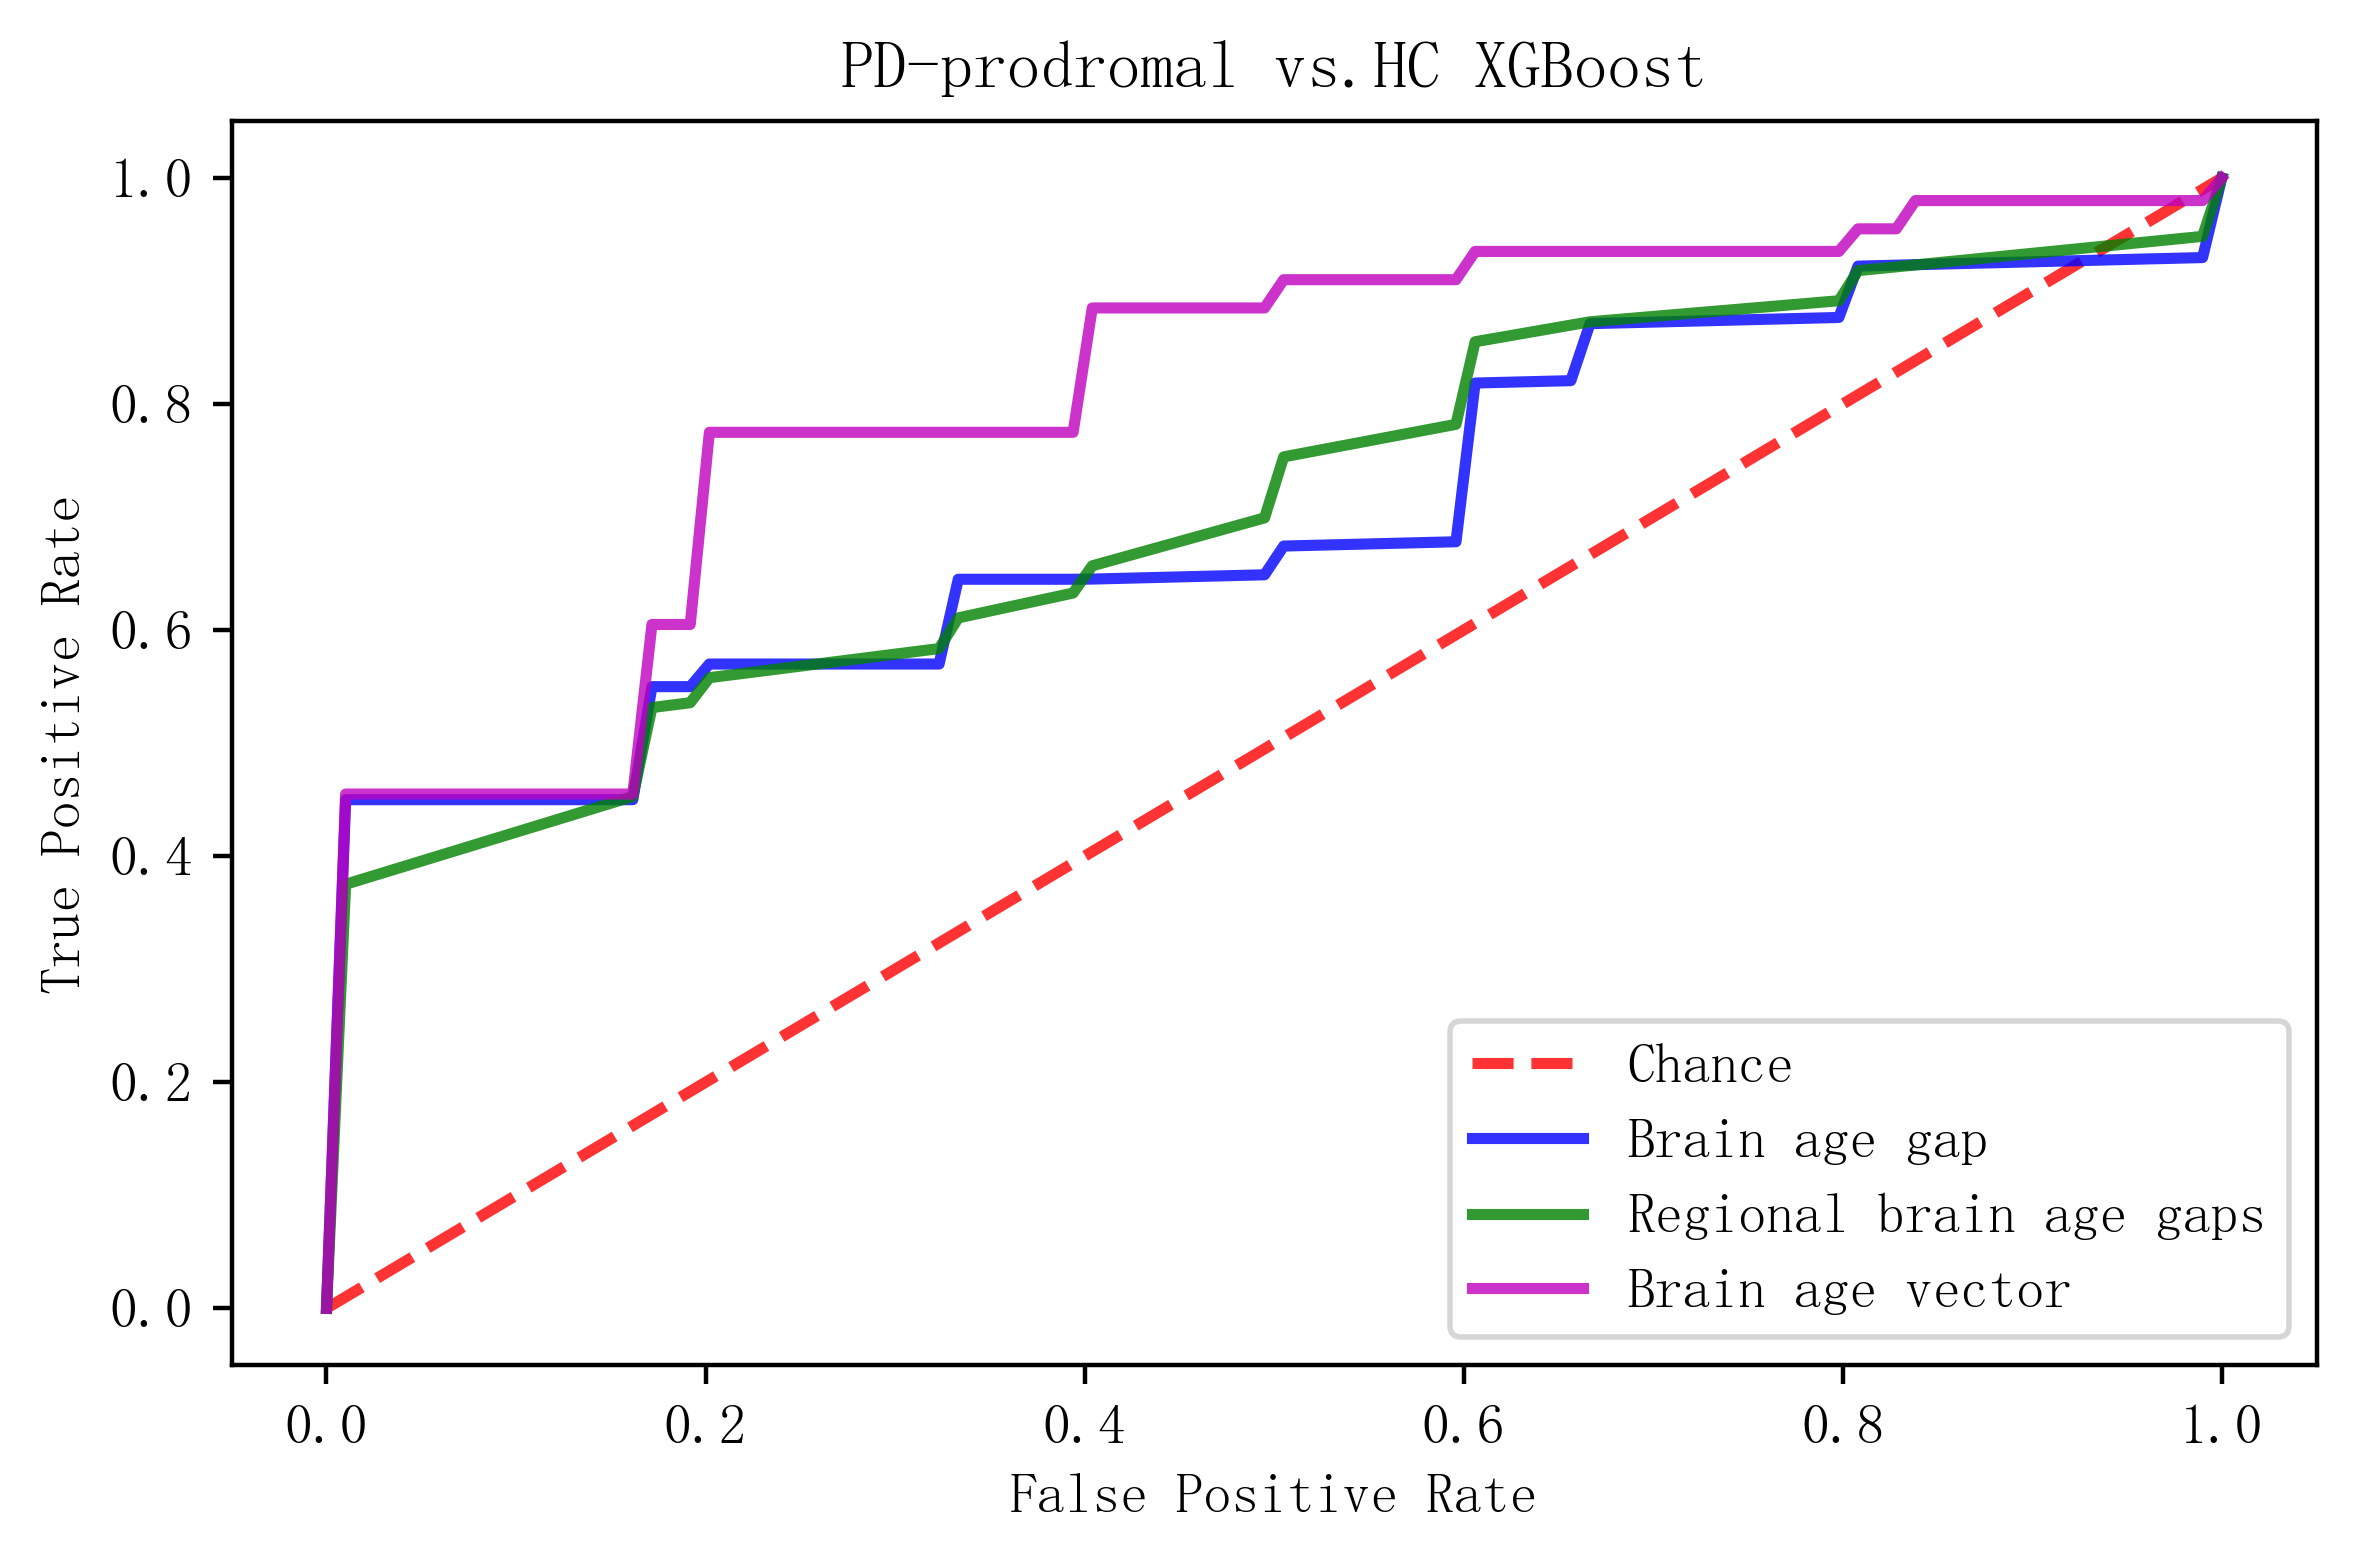

In [100]:
config = {
    "font.family":'serif',
    "font.size": 10,
    "mathtext.fontset": 'stix',
    "font.serif": ['SimSun'],

}
mpl.rcParams.update(config)

data1 = pd.read_csv(r"D:\rc\paper\csv\data5\shap_values_prodromal.csv")
data2 = pd.read_csv(r"D:\rc\paper\csv\data5\filter_prodromal_baseline.csv")
data3 = pd.read_csv(r"D:\rc\paper\csv\data5\shap_values_HC.csv")
data4 = pd.read_csv(r"D:\rc\paper\csv\data5\filter_HC_baseline.csv")
data1['age'] = data2['age']
data3['age'] = data4['age']
data1['label'] = 1
data3['label'] = 0
data0 = pd.concat([data1,data3]).reset_index(drop=True)

y2 = data0.loc[:,'label']
X2 = data0.drop(columns=['label']).fillna(0)

gaps0 = pd.read_csv(r"D:\rc\paper\csv\data5\gap_HC.csv")
gaps1 = pd.read_csv(r"D:\rc\paper\csv\data5\gap_prodromal.csv")
gaps0['age'] = data4['age']
gaps0['sex'] = data4['sex']
gaps1['age'] = data2['age']
gaps1['sex'] = data2['sex']
gaps0['label'] = 0
gaps1['label'] = 1

gaps = pd.concat([gaps0,gaps1]).reset_index(drop=True)

y = gaps.loc[:,'label']
y1 = gaps.loc[:,'label']
use = ['bias','sex','age']
X = gaps[use]
X1 = gaps.drop(columns=['bias','name','label'])


cv = StratifiedKFold(n_splits=10)
# classifier = lr(max_iter=2000)
# classifier1 = lr(max_iter=2000)
# classifier2 = lr(max_iter=2000)
param = {'n_estimators': 44, 'learning_rate': 0.48000000000000004, 'max_depth': 3}
classifier = xgb.XGBClassifier(**param)
param1 = {'n_estimators': 15, 'learning_rate': 0.02, 'max_depth': 3}
classifier1 = xgb.XGBClassifier(**param1)
param2 = {'n_estimators': 32, 'learning_rate': 0.76, 'max_depth': 4}
# param2 = {'n_estimators': 10, 'learning_rate': 0.04, 'max_depth': 5}
classifier2 = xgb.XGBClassifier(**param2)
# classifier = GaussianNB()
# classifier1 = GaussianNB()


tprs = []
aucs = []

accs = []
sens = []
spes = []
aucss = []

mean_fpr = np.linspace(0, 1, 100)

for train, test in cv.split(X, y):
    features = X.drop(columns=['sex']).columns
    X_train = X.loc[train,:]
    X_test = X.loc[test,:]
    
#     for fea in features:
#         max = np.max(X_train[fea])
#         min = np.min(X_train[fea])
#         X_train[fea] = MinMaxNormalization(X_train[fea], max, min)
#         X_test[fea] = MinMaxNormalization(X_test[fea], max, min)
        
#     enc = OneHotEncoder()
#     enc.fit(X_train['sex'].values.reshape(-1, 1))
#     X_train['sex'] = enc.transform(X_train['sex'].values.reshape(-1, 1)).toarray()
#     X_test['sex'] = enc.transform(X_test['sex'].values.reshape(-1, 1)).toarray()
    
    model = classifier.fit(X_train, y[train])
    probas_ = model.predict_proba(X_test)
    y_pred = model.predict(X_test)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    accs.append(accuracy_score(y[test],y_pred))
    sens.append(recall_score(y[test], y_pred, average='binary'))
    spes.append(get_spe(y[test], y_pred))
    aucss.append(roc_auc_score(y[test], probas_[:, 1]))
#     plt.plot(fpr, tpr, lw=1, alpha=0.3,
#              label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))


tprs1 = []
aucs1 = []

accs1 = []
sens1 = []
spes1 = []
aucss1 = []

mean_fpr1 = np.linspace(0, 1, 100)
    
for train, test in cv.split(X1, y1):
    features = X1.columns
    X1_train = X1.loc[train,:]
    X1_test = X1.loc[test,:]
    
#     for fea in features:
#         max = np.max(X1_train[fea])
#         min = np.min(X1_train[fea])
#         X1_train[fea] = MinMaxNormalization(X1_train[fea], max, min)
#         X1_test[fea] = MinMaxNormalization(X1_test[fea], max, min)
    
#     enc = OneHotEncoder()
#     enc.fit(X1_train['sex'].values.reshape(-1, 1))
#     X1_train['sex'] = enc.transform(X1_train['sex'].values.reshape(-1, 1)).toarray()
#     X1_test['sex'] = enc.transform(X1_test['sex'].values.reshape(-1, 1)).toarray()
    
    model1 = classifier1.fit(X1_train, y1[train])
    probas_ = model1.predict_proba(X1_test)
    y_pred = model1.predict(X1_test)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y1[test], probas_[:, 1])
    tprs1.append(interp(mean_fpr1, fpr, tpr))
    tprs1[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs1.append(roc_auc)
    accs1.append(accuracy_score(y1[test],y_pred))
    sens1.append(recall_score(y1[test], y_pred, average='binary'))
    spes1.append(get_spe(y1[test], y_pred))
    aucss1.append(roc_auc_score(y1[test], probas_[:, 1]))
#     plt.plot(fpr, tpr, lw=1, alpha=0.3,
#              label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))


tprs2 = []
aucs2 = []

accs2 = []
sens2 = []
spes2 = []
aucss2 = []

mean_fpr2 = np.linspace(0, 1, 100)
    
for train, test in cv.split(X2, y2):
    features = X2.columns
    X2_train = X2.loc[train,:]
    X2_test = X2.loc[test,:]
    
#     for fea in features:
#         max = np.max(X2_train[fea])
#         min = np.min(X2_train[fea])
#         X2_train[fea] = MinMaxNormalization(X2_train[fea], max, min)
#         X2_test[fea] = MinMaxNormalization(X2_test[fea], max, min)
    
    model2 = classifier2.fit(X2_train, y2[train])
    probas_ = model2.predict_proba(X2_test)
    y_pred = model2.predict(X2_test)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y2[test], probas_[:, 1])
    tprs2.append(interp(mean_fpr2, fpr, tpr))
    tprs2[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs2.append(roc_auc)
    accs2.append(accuracy_score(y2[test],y_pred))
    sens2.append(recall_score(y2[test], y_pred, average='binary'))
    spes2.append(get_spe(y2[test], y_pred))
    aucss2.append(roc_auc_score(y2[test], probas_[:, 1]))
#     plt.plot(fpr, tpr, lw=1, alpha=0.3,
#              label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))


plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_tpr1 = np.mean(tprs1, axis=0)
mean_tpr1[-1] = 1.0
mean_tpr2 = np.mean(tprs2, axis=0)
mean_tpr1[-1] = 1.0


# mean_auc = auc(mean_fpr, mean_tpr)
# std_auc = np.std(aucs)
print('ACC = %0.4f ± %0.4f' % (np.mean(accs),np.std(accs)))
print('SEN = %0.4f ± %0.4f' % (np.mean(sens),np.std(sens)))
print('SPE = %0.4f ± %0.4f' % (np.mean(spes),np.std(spes)))
print('AUC = %0.4f ± %0.4f' % (np.mean(aucss),np.std(aucss)))
print('ACC = %0.4f ± %0.4f' % (np.mean(accs1),np.std(accs1)))
print('SEN = %0.4f ± %0.4f' % (np.mean(sens1),np.std(sens1)))
print('SPE = %0.4f ± %0.4f' % (np.mean(spes1),np.std(spes1)))
print('AUC = %0.4f ± %0.4f' % (np.mean(aucss1),np.std(aucss1)))
print('ACC = %0.4f ± %0.4f' % (np.mean(accs2),np.std(accs2)))
print('SEN = %0.4f ± %0.4f' % (np.mean(sens2),np.std(sens2)))
print('SPE = %0.4f ± %0.4f' % (np.mean(spes2),np.std(spes2)))
print('AUC = %0.4f ± %0.4f' % (np.mean(aucss2),np.std(aucss2)))


plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Brain age gap',
         lw=2, alpha=.8)
plt.plot(mean_fpr1, mean_tpr1, color='g',
         label=r'Regional brain age gaps',
         lw=2, alpha=.8)
plt.plot(mean_fpr2, mean_tpr2, color='m',
         label=r'Brain age vector',
         lw=2, alpha=.8)
# std_tpr = np.std(tprs, axis=0)
# tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
# tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
# plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
#                  label=r'$\pm$ 1 std. dev.')

plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.dpi'] = 400
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('PD-prodromal vs.HC XGBoost')
plt.legend(loc="lower right")
plt.savefig(r"D:\rc\paper\fig\PD_xgb.png", dpi=400)
plt.show()    
    


C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:87: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:87: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:87: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:87: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:87: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:87: DeprecationWarning: scipy.interp is depr

ACC = 0.5756 ± 0.1314
SEN = 0.3500 ± 0.2588
SPE = 0.7367 ± 0.3053
AUC = 0.6459 ± 0.2187
ACC = 0.6289 ± 0.1019
SEN = 0.3800 ± 0.1122
SPE = 0.8267 ± 0.1672
AUC = 0.6048 ± 0.1583
ACC = 0.7289 ± 0.0927
SEN = 0.5100 ± 0.1868
SPE = 0.9033 ± 0.1320
AUC = 0.8150 ± 0.1309


C:\Users\Lenovo\Anaconda3\lib\site-packages\matplotlib\figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


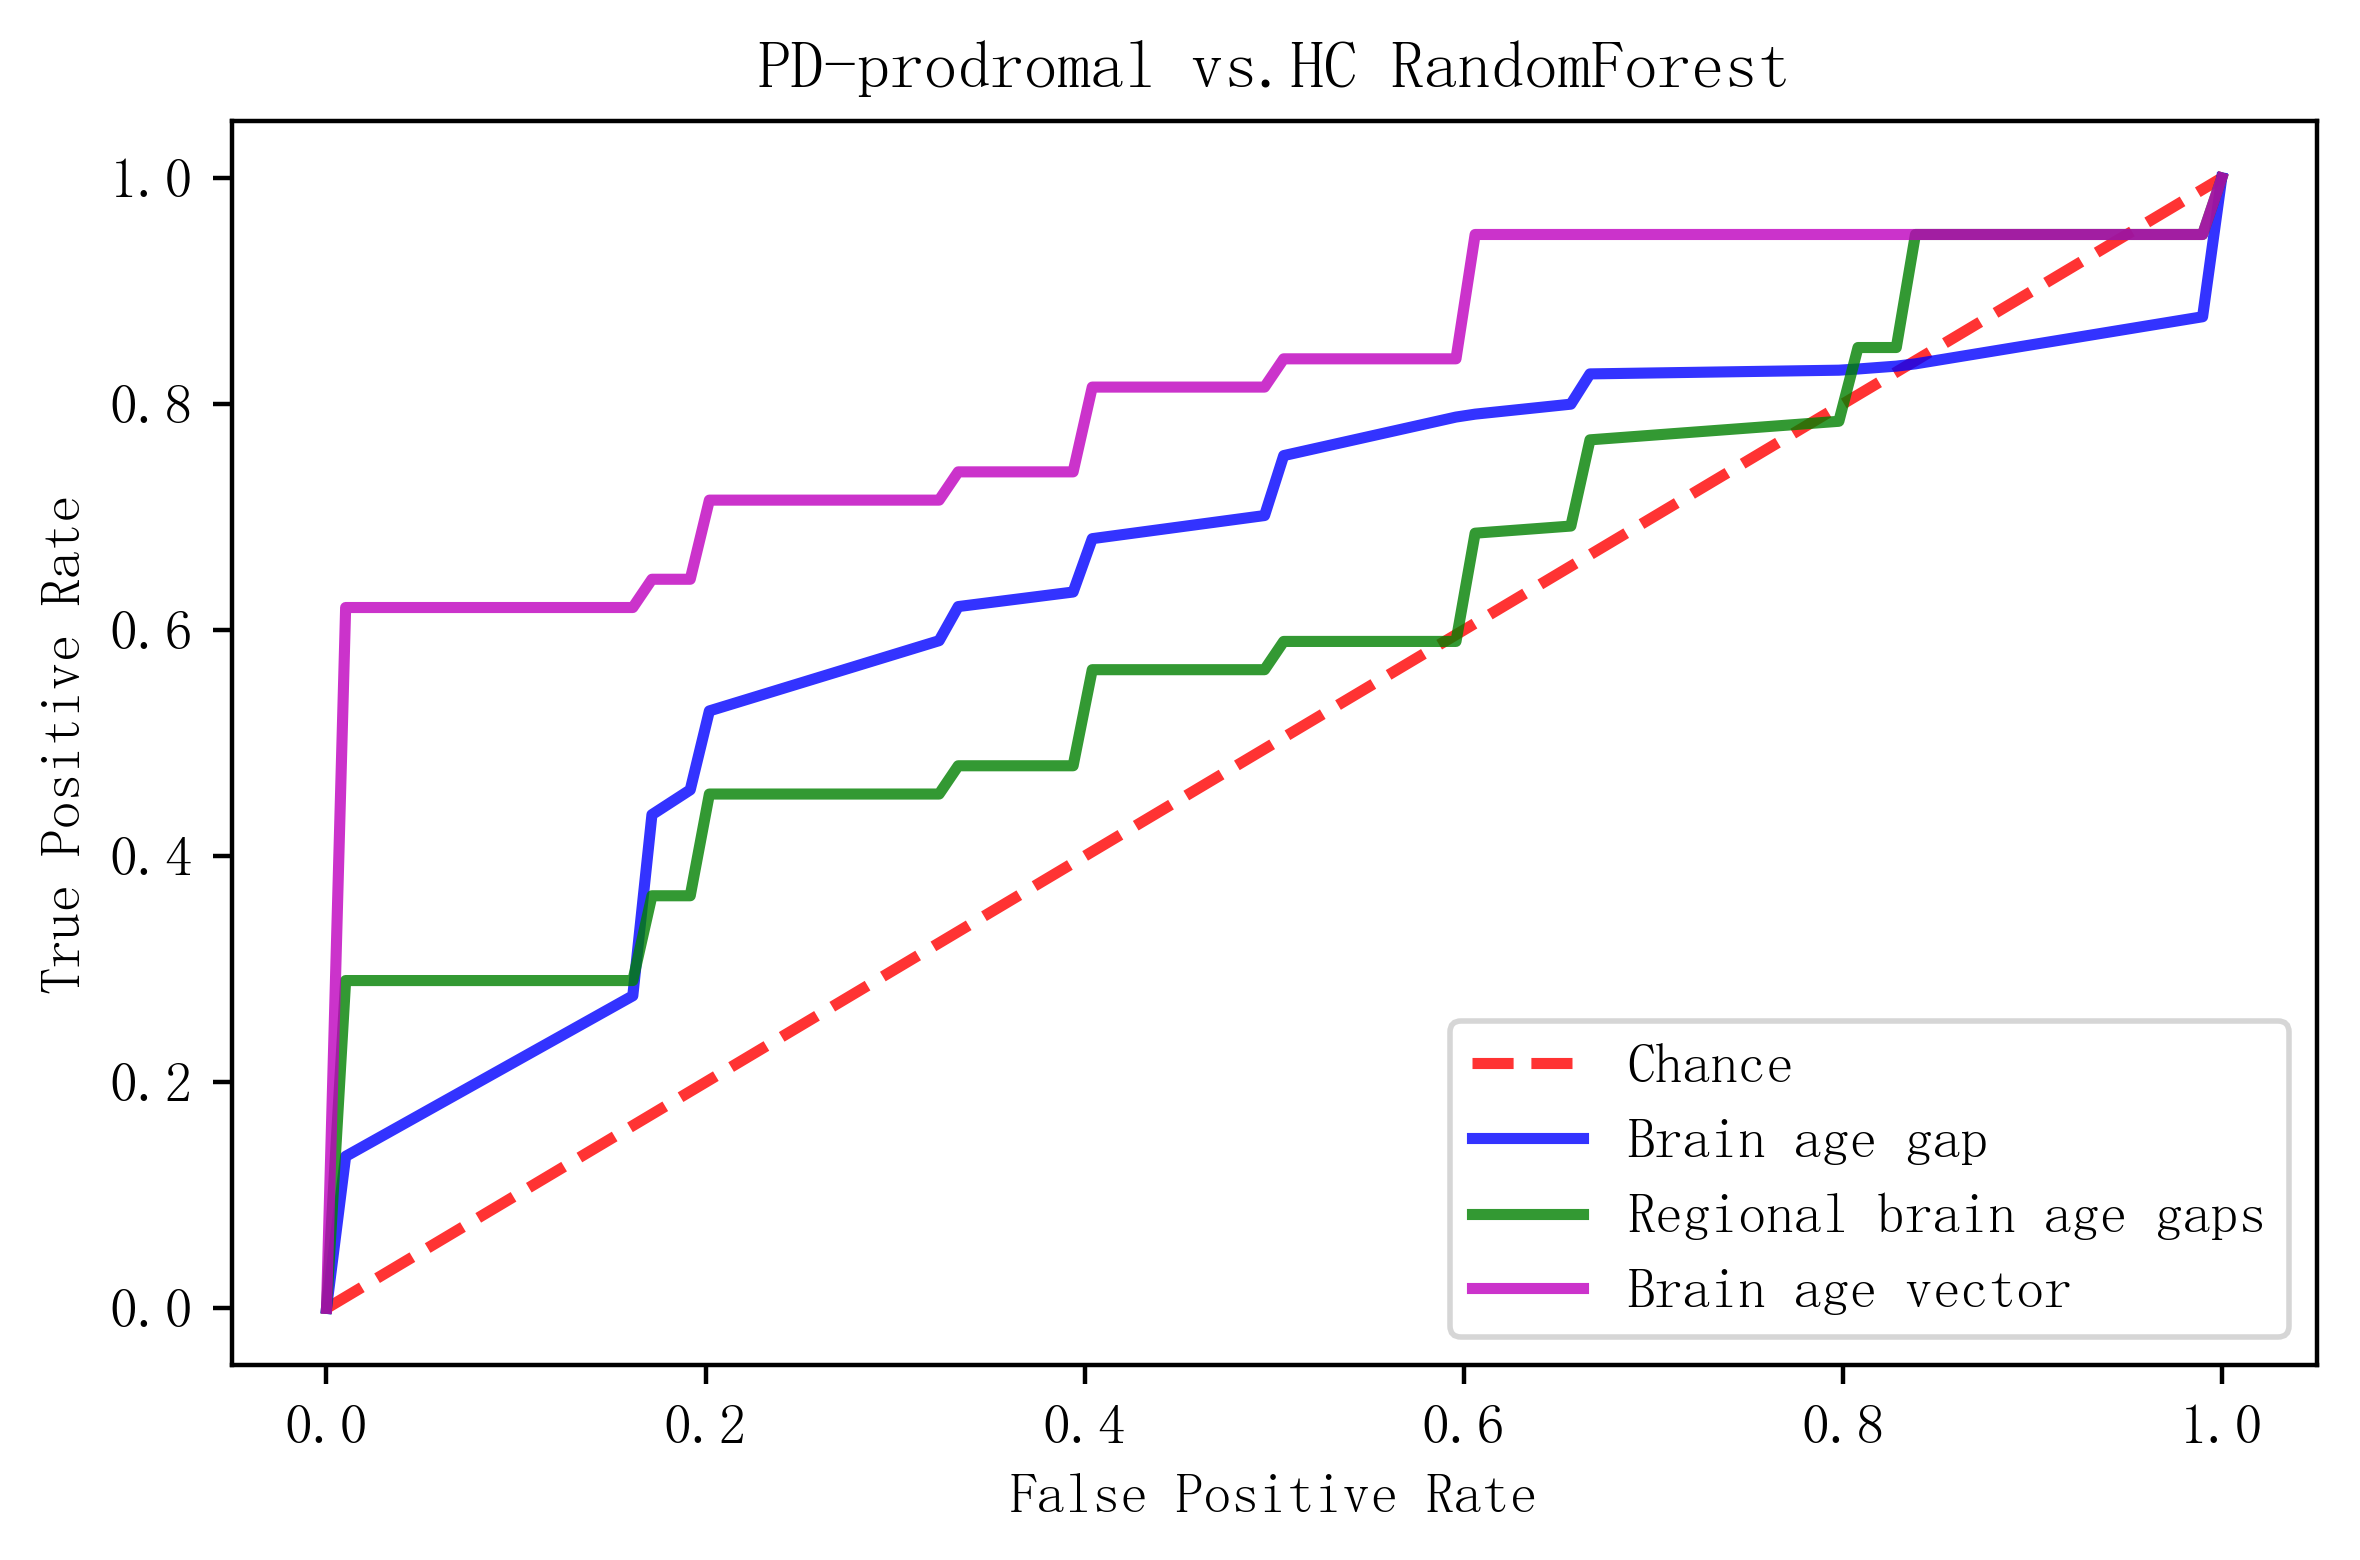

In [74]:
config = {
    "font.family":'serif',
    "font.size": 10,
    "mathtext.fontset": 'stix',
    "font.serif": ['SimSun'],

}
mpl.rcParams.update(config)

data1 = pd.read_csv(r"D:\rc\paper\csv\data5\shap_values_prodromal.csv")
data2 = pd.read_csv(r"D:\rc\paper\csv\data5\filter_prodromal_baseline.csv")
data3 = pd.read_csv(r"D:\rc\paper\csv\data5\shap_values_HC.csv")
data4 = pd.read_csv(r"D:\rc\paper\csv\data5\filter_HC_baseline.csv")
data1['age'] = data2['age']
data3['age'] = data4['age']
data1['label'] = 1
data3['label'] = 0
data0 = pd.concat([data1,data3]).reset_index(drop=True)

y2 = data0.loc[:,'label']
X2 = data0.drop(columns=['label']).fillna(0)

gaps0 = pd.read_csv(r"D:\rc\paper\csv\data5\gap_HC.csv")
gaps1 = pd.read_csv(r"D:\rc\paper\csv\data5\gap_prodromal.csv")
gaps0['age'] = data4['age']
gaps0['sex'] = data4['sex']
gaps1['age'] = data2['age']
gaps1['sex'] = data2['sex']
gaps0['label'] = 0
gaps1['label'] = 1

gaps = pd.concat([gaps0,gaps1]).reset_index(drop=True)

y = gaps.loc[:,'label']
y1 = gaps.loc[:,'label']
use = ['bias','sex','age']
X = gaps[use]
X1 = gaps.drop(columns=['bias','name','label'])


cv = StratifiedKFold(n_splits=10)
# classifier = lr(max_iter=2000)
# classifier1 = lr(max_iter=2000)
# classifier2 = lr(max_iter=2000)
param = {'n_estimators': 2, 'random_state': 12, 'max_depth': 6}
classifier = rfc(**param)
param1 = {'n_estimators': 16, 'random_state': 12, 'max_depth': 2}
classifier1 = rfc(**param1)
param2 = {'n_estimators': 73, 'random_state': 12, 'max_depth': 3}
# param2 = {'n_estimators': 10, 'learning_rate': 0.04, 'max_depth': 5}
classifier2 = rfc(**param2)
# classifier = GaussianNB()
# classifier1 = GaussianNB()


tprs = []
aucs = []

accs = []
sens = []
spes = []
aucss = []

mean_fpr = np.linspace(0, 1, 100)

for train, test in cv.split(X, y):
    features = X.drop(columns=['sex']).columns
    X_train = X.loc[train,:]
    X_test = X.loc[test,:]
    
#     for fea in features:
#         max = np.max(X_train[fea])
#         min = np.min(X_train[fea])
#         X_train[fea] = MinMaxNormalization(X_train[fea], max, min)
#         X_test[fea] = MinMaxNormalization(X_test[fea], max, min)
        
#     enc = OneHotEncoder()
#     enc.fit(X_train['sex'].values.reshape(-1, 1))
#     X_train['sex'] = enc.transform(X_train['sex'].values.reshape(-1, 1)).toarray()
#     X_test['sex'] = enc.transform(X_test['sex'].values.reshape(-1, 1)).toarray()
    
    model = classifier.fit(X_train, y[train])
    probas_ = model.predict_proba(X_test)
    y_pred = model.predict(X_test)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    accs.append(accuracy_score(y[test],y_pred))
    sens.append(recall_score(y[test], y_pred, average='binary'))
    spes.append(get_spe(y[test], y_pred))
    aucss.append(roc_auc_score(y[test], probas_[:, 1]))
#     plt.plot(fpr, tpr, lw=1, alpha=0.3,
#              label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))


tprs1 = []
aucs1 = []

accs1 = []
sens1 = []
spes1 = []
aucss1 = []

mean_fpr1 = np.linspace(0, 1, 100)
    
for train, test in cv.split(X1, y1):
    features = X1.columns
    X1_train = X1.loc[train,:]
    X1_test = X1.loc[test,:]
    
#     for fea in features:
#         max = np.max(X1_train[fea])
#         min = np.min(X1_train[fea])
#         X1_train[fea] = MinMaxNormalization(X1_train[fea], max, min)
#         X1_test[fea] = MinMaxNormalization(X1_test[fea], max, min)
    
#     enc = OneHotEncoder()
#     enc.fit(X1_train['sex'].values.reshape(-1, 1))
#     X1_train['sex'] = enc.transform(X1_train['sex'].values.reshape(-1, 1)).toarray()
#     X1_test['sex'] = enc.transform(X1_test['sex'].values.reshape(-1, 1)).toarray()
    
    model1 = classifier1.fit(X1_train, y1[train])
    probas_ = model1.predict_proba(X1_test)
    y_pred = model1.predict(X1_test)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y1[test], probas_[:, 1])
    tprs1.append(interp(mean_fpr1, fpr, tpr))
    tprs1[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs1.append(roc_auc)
    accs1.append(accuracy_score(y1[test],y_pred))
    sens1.append(recall_score(y1[test], y_pred, average='binary'))
    spes1.append(get_spe(y1[test], y_pred))
    aucss1.append(roc_auc_score(y1[test], probas_[:, 1]))
#     plt.plot(fpr, tpr, lw=1, alpha=0.3,
#              label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))


tprs2 = []
aucs2 = []

accs2 = []
sens2 = []
spes2 = []
aucss2 = []

mean_fpr2 = np.linspace(0, 1, 100)
    
for train, test in cv.split(X2, y2):
    features = X2.columns
    X2_train = X2.loc[train,:]
    X2_test = X2.loc[test,:]
    
#     for fea in features:
#         max = np.max(X2_train[fea])
#         min = np.min(X2_train[fea])
#         X2_train[fea] = MinMaxNormalization(X2_train[fea], max, min)
#         X2_test[fea] = MinMaxNormalization(X2_test[fea], max, min)
    
    model2 = classifier2.fit(X2_train, y2[train])
    probas_ = model2.predict_proba(X2_test)
    y_pred = model2.predict(X2_test)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y2[test], probas_[:, 1])
    tprs2.append(interp(mean_fpr2, fpr, tpr))
    tprs2[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs2.append(roc_auc)
    accs2.append(accuracy_score(y2[test],y_pred))
    sens2.append(recall_score(y2[test], y_pred, average='binary'))
    spes2.append(get_spe(y2[test], y_pred))
    aucss2.append(roc_auc_score(y2[test], probas_[:, 1]))
#     plt.plot(fpr, tpr, lw=1, alpha=0.3,
#              label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))


plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_tpr1 = np.mean(tprs1, axis=0)
mean_tpr1[-1] = 1.0
mean_tpr2 = np.mean(tprs2, axis=0)
mean_tpr1[-1] = 1.0


# mean_auc = auc(mean_fpr, mean_tpr)
# std_auc = np.std(aucs)
print('ACC = %0.4f ± %0.4f' % (np.mean(accs),np.std(accs)))
print('SEN = %0.4f ± %0.4f' % (np.mean(sens),np.std(sens)))
print('SPE = %0.4f ± %0.4f' % (np.mean(spes),np.std(spes)))
print('AUC = %0.4f ± %0.4f' % (np.mean(aucss),np.std(aucss)))
print('ACC = %0.4f ± %0.4f' % (np.mean(accs1),np.std(accs1)))
print('SEN = %0.4f ± %0.4f' % (np.mean(sens1),np.std(sens1)))
print('SPE = %0.4f ± %0.4f' % (np.mean(spes1),np.std(spes1)))
print('AUC = %0.4f ± %0.4f' % (np.mean(aucss1),np.std(aucss1)))
print('ACC = %0.4f ± %0.4f' % (np.mean(accs2),np.std(accs2)))
print('SEN = %0.4f ± %0.4f' % (np.mean(sens2),np.std(sens2)))
print('SPE = %0.4f ± %0.4f' % (np.mean(spes2),np.std(spes2)))
print('AUC = %0.4f ± %0.4f' % (np.mean(aucss2),np.std(aucss2)))


plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Brain age gap',
         lw=2, alpha=.8)
plt.plot(mean_fpr1, mean_tpr1, color='g',
         label=r'Regional brain age gaps',
         lw=2, alpha=.8)
plt.plot(mean_fpr2, mean_tpr2, color='m',
         label=r'Brain age vector',
         lw=2, alpha=.8)
# std_tpr = np.std(tprs, axis=0)
# tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
# tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
# plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
#                  label=r'$\pm$ 1 std. dev.')

plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.dpi'] = 400
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('PD-prodromal vs.HC RandomForest')
plt.legend(loc="lower right")
plt.savefig(r"D:\rc\paper\fig\PD_rf.png", dpi=400)
plt.show()    
    


C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:73: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:73: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:73: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:73: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:73: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:73: DeprecationWarning: scipy.interp is depr

ACC = 0.6533 ± 0.1417
SEN = 0.5500 ± 0.1924
SPE = 0.7333 ± 0.2348
AUC = 0.7428 ± 0.1325
ACC = 0.6011 ± 0.1410
SEN = 0.4350 ± 0.1566
SPE = 0.7333 ± 0.2039
AUC = 0.6628 ± 0.1093
ACC = 0.7178 ± 0.1674
SEN = 0.5550 ± 0.2514
SPE = 0.8467 ± 0.2088
AUC = 0.7653 ± 0.1676


C:\Users\Lenovo\Anaconda3\lib\site-packages\matplotlib\figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


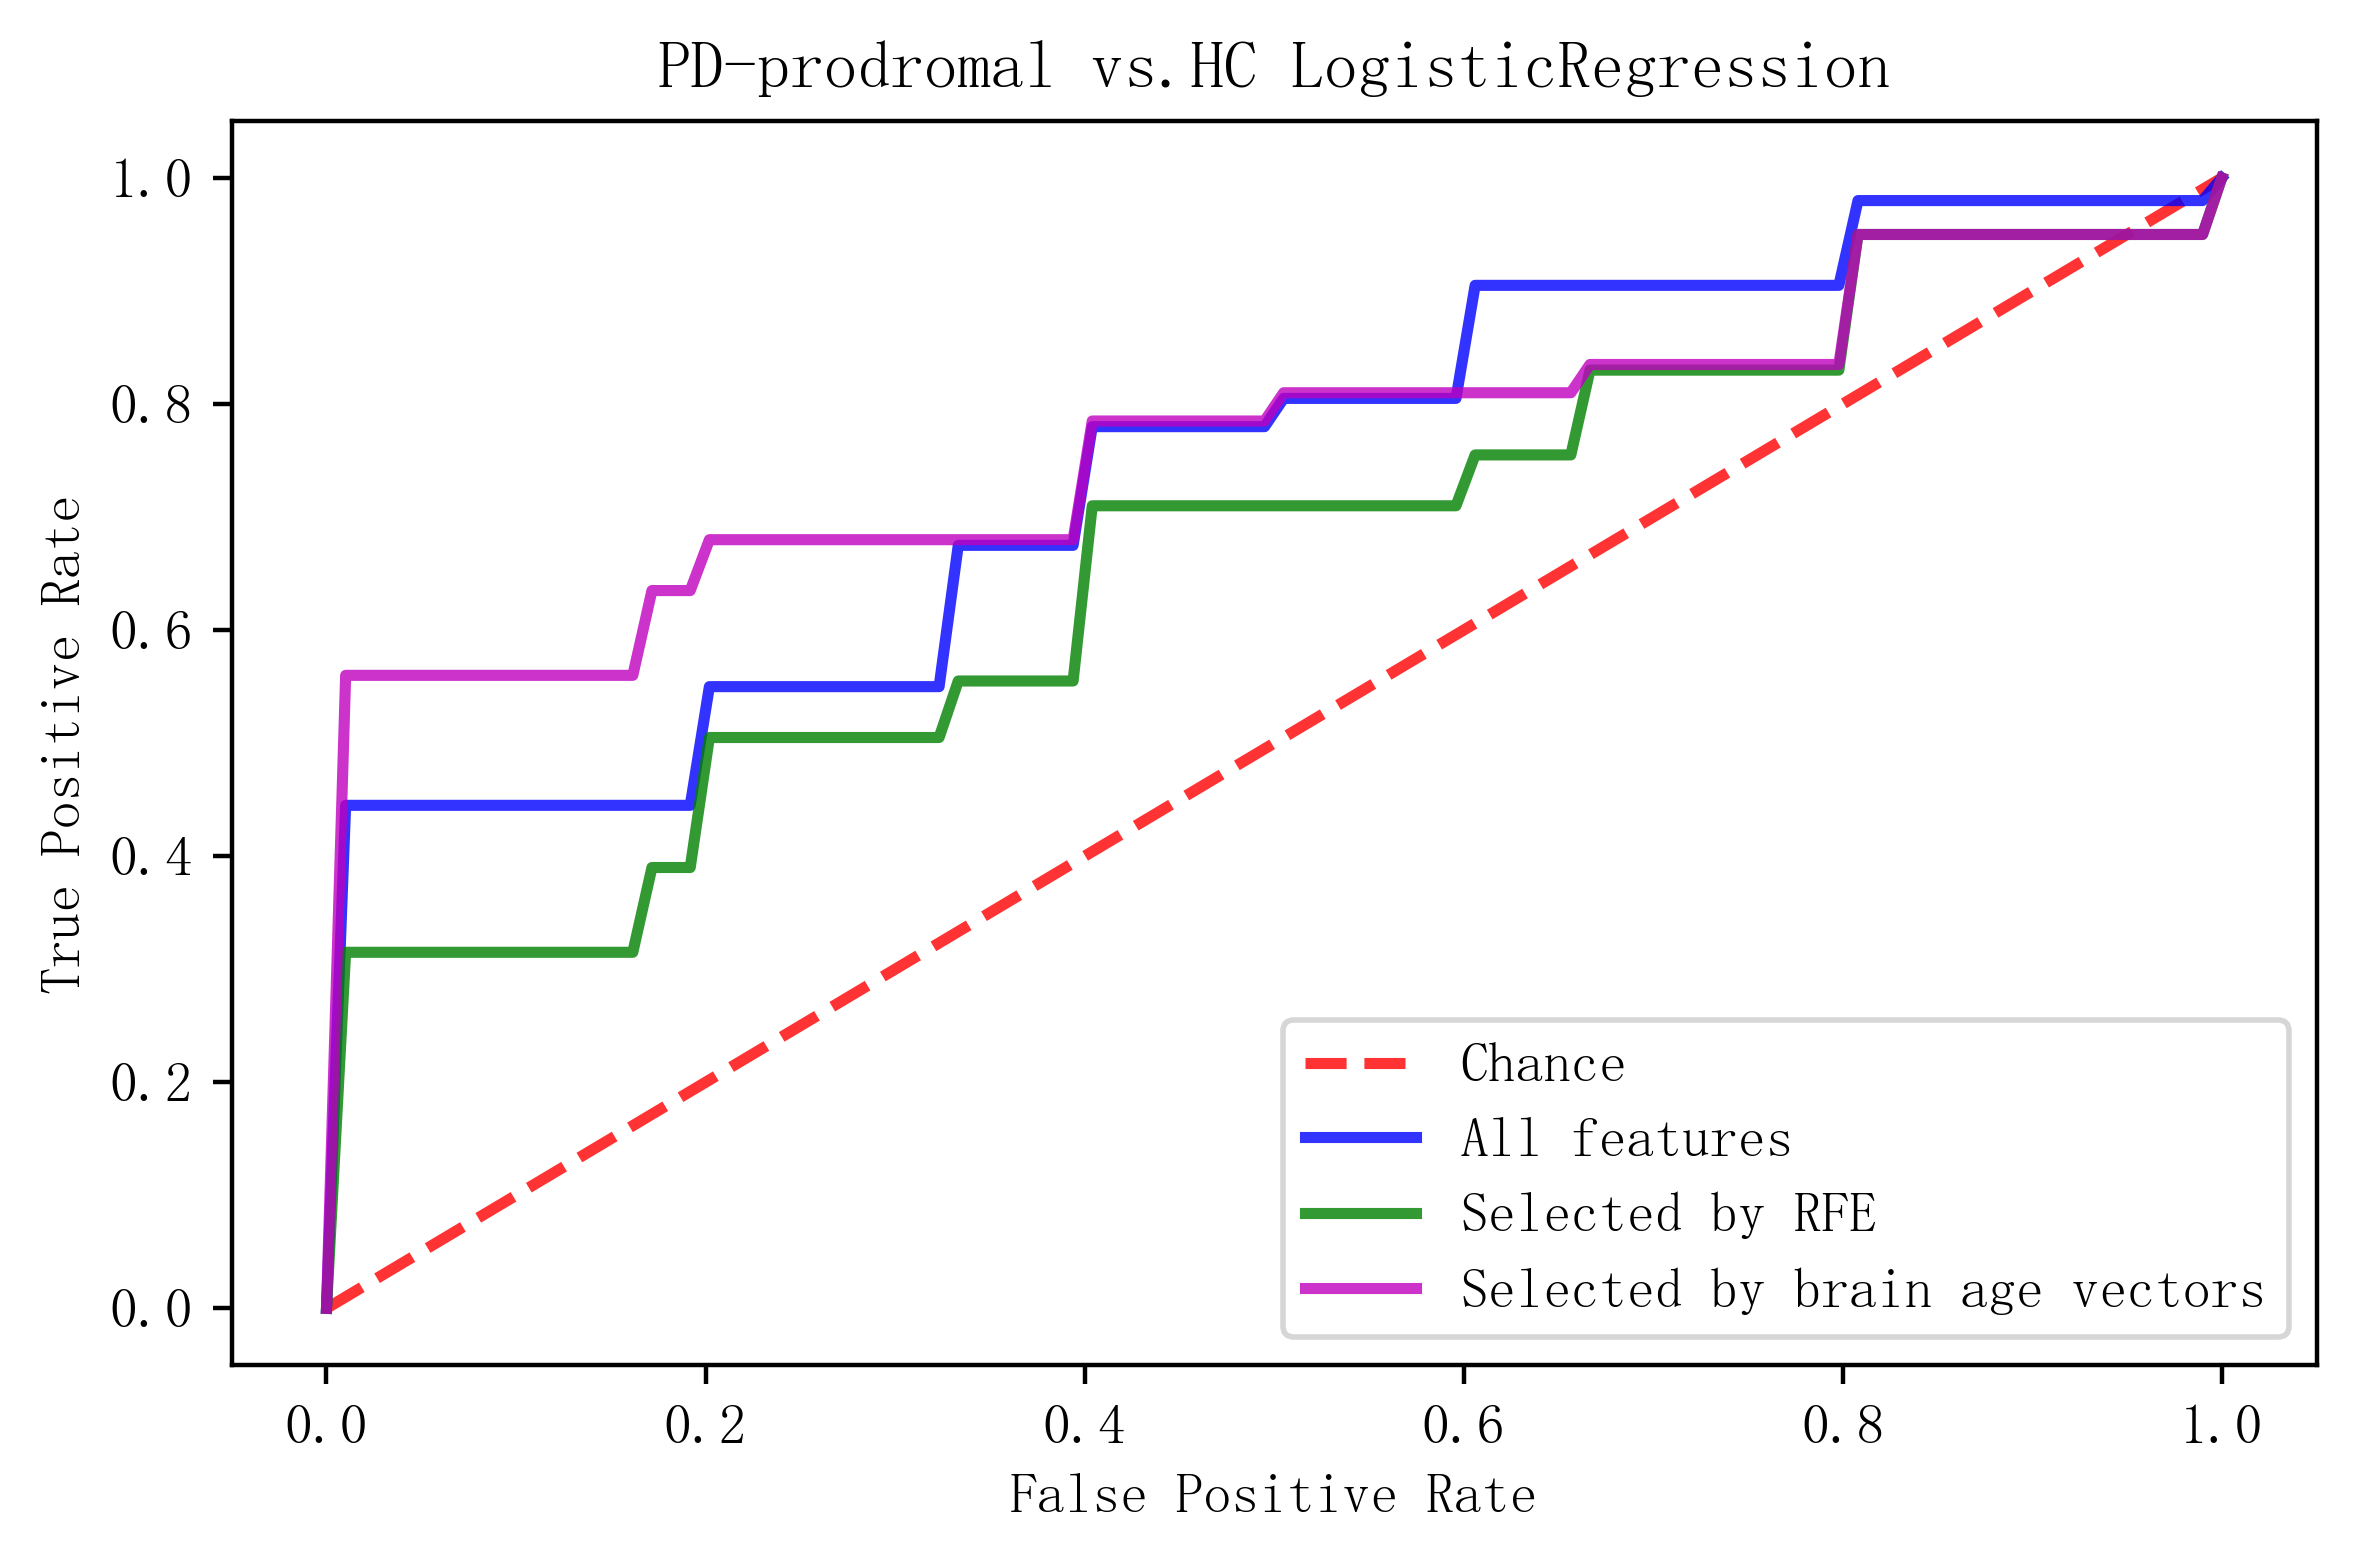

In [19]:
config = {
    "font.family":'serif',
    "font.size": 10,
    "mathtext.fontset": 'stix',
    "font.serif": ['SimSun'],

}
mpl.rcParams.update(config)


data1 = pd.read_csv(r"D:\rc\paper\csv\data5\filter_prodromal_baseline.csv")
data2 = pd.read_csv(r"D:\rc\paper\csv\data5\filter_HC_baseline.csv")
data1['label'] = 1
data2['label'] = 0
data = pd.concat([data1,data2]).reset_index(drop=True)

y = data.loc[:,'label']
X = data.drop(columns=['label','name'])

roi = ['Cerebellar White Matter(lh)', 'Putaman(lh)', 'Cerebrospinal Fluid', 'Accumbens(lh)', 'Choroid Plexus(lh)', 'Cortical white matter(rh)', 'medial orbitofrontal(lh)', 'postcentral(lh)', 'posterior cingulate(lh)', 'precentral(lh)', 'precuneus(lh)', 'rostral middle frontal(lh)', 'medial orbitofrontal(rh)', 'superior frontal(rh)', 'insula(rh)', 'CSF','sex','age']
X2 = data[roi]
y2 = data.loc[:,'label']

X1 = data.drop(columns=['name','label','age','sex'])
X1 = RFE(estimator=LinearSVC(), n_features_to_select=16).fit_transform(X1, y)
feat = pd.DataFrame(X1)
feat['age'] = data['age']
feat['sex'] = data['sex']
X1 = feat
y1 = data.loc[:,'label']

cv = StratifiedKFold(n_splits=10)
classifier = lr(max_iter=2000)
classifier1 = lr(max_iter=2000)
classifier2 = lr(max_iter=2000)
# classifier = xgb.XGBClassifier()
# classifier1 = xgb.XGBClassifier()
# classifier = GaussianNB()
# classifier1 = GaussianNB()


tprs = []
aucs = []

accs = []
sens = []
spes = []
aucss = []

mean_fpr = np.linspace(0, 1, 100)

for train, test in cv.split(X, y):
    features = X.drop(columns=['sex']).columns
    X_train = X.loc[train,:]
    X_test = X.loc[test,:]
    
    for fea in features:
        max = np.max(X_train[fea])
        min = np.min(X_train[fea])
        X_train[fea] = MinMaxNormalization(X_train[fea], max, min)
        X_test[fea] = MinMaxNormalization(X_test[fea], max, min)
        
    enc = OneHotEncoder()
    enc.fit(X_train['sex'].values.reshape(-1, 1))
    X_train['sex'] = enc.transform(X_train['sex'].values.reshape(-1, 1)).toarray()
    X_test['sex'] = enc.transform(X_test['sex'].values.reshape(-1, 1)).toarray()
    
    model = classifier.fit(X_train, y[train])
    probas_ = model.predict_proba(X_test)
    y_pred = model.predict(X_test)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    accs.append(accuracy_score(y[test],y_pred))
    sens.append(recall_score(y[test], y_pred, average='binary'))
    spes.append(get_spe(y[test], y_pred))
    aucss.append(roc_auc_score(y[test], probas_[:, 1]))
#     plt.plot(fpr, tpr, lw=1, alpha=0.3,
#              label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))


tprs1 = []
aucs1 = []

accs1 = []
sens1 = []
spes1 = []
aucss1 = []

mean_fpr1 = np.linspace(0, 1, 100)
    
for train, test in cv.split(X1, y1):
    features = X1.columns
    X1_train = X1.loc[train,:]
    X1_test = X1.loc[test,:]
    
    for fea in features:
        max = np.max(X1_train[fea])
        min = np.min(X1_train[fea])
        X1_train[fea] = MinMaxNormalization(X1_train[fea], max, min)
        X1_test[fea] = MinMaxNormalization(X1_test[fea], max, min)
    
    enc = OneHotEncoder()
    enc.fit(X1_train['sex'].values.reshape(-1, 1))
    X1_train['sex'] = enc.transform(X1_train['sex'].values.reshape(-1, 1)).toarray()
    X1_test['sex'] = enc.transform(X1_test['sex'].values.reshape(-1, 1)).toarray()
    
    model1 = classifier1.fit(X1_train, y1[train])
    probas_ = model1.predict_proba(X1_test)
    y_pred = model1.predict(X1_test)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y1[test], probas_[:, 1])
    tprs1.append(interp(mean_fpr1, fpr, tpr))
    tprs1[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs1.append(roc_auc)
    accs1.append(accuracy_score(y1[test],y_pred))
    sens1.append(recall_score(y1[test], y_pred, average='binary'))
    spes1.append(get_spe(y1[test], y_pred))
    aucss1.append(roc_auc_score(y1[test], probas_[:, 1]))
#     plt.plot(fpr, tpr, lw=1, alpha=0.3,
#              label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))


tprs2 = []
aucs2 = []

accs2 = []
sens2 = []
spes2 = []
aucss2 = []

mean_fpr2 = np.linspace(0, 1, 100)
    
for train, test in cv.split(X2, y2):
    features = X2.columns
    X2_train = X2.loc[train,:]
    X2_test = X2.loc[test,:]
    
    for fea in features:
        max = np.max(X2_train[fea])
        min = np.min(X2_train[fea])
        X2_train[fea] = MinMaxNormalization(X2_train[fea], max, min)
        X2_test[fea] = MinMaxNormalization(X2_test[fea], max, min)
    
    enc = OneHotEncoder()
    enc.fit(X2_train['sex'].values.reshape(-1, 1))
    X2_train['sex'] = enc.transform(X2_train['sex'].values.reshape(-1, 1)).toarray()
    X2_test['sex'] = enc.transform(X2_test['sex'].values.reshape(-1, 1)).toarray()
    
    model2 = classifier2.fit(X2_train, y2[train])
    probas_ = model2.predict_proba(X2_test)
    y_pred = model2.predict(X2_test)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y2[test], probas_[:, 1])
    tprs2.append(interp(mean_fpr2, fpr, tpr))
    tprs2[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs2.append(roc_auc)
    accs2.append(accuracy_score(y2[test],y_pred))
    sens2.append(recall_score(y2[test], y_pred, average='binary'))
    spes2.append(get_spe(y2[test], y_pred))
    aucss2.append(roc_auc_score(y2[test], probas_[:, 1]))
#     plt.plot(fpr, tpr, lw=1, alpha=0.3,
#              label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))


plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_tpr1 = np.mean(tprs1, axis=0)
mean_tpr1[-1] = 1.0
mean_tpr2 = np.mean(tprs2, axis=0)
mean_tpr1[-1] = 1.0


# mean_auc = auc(mean_fpr, mean_tpr)
# std_auc = np.std(aucs)
print('ACC = %0.4f ± %0.4f' % (np.mean(accs),np.std(accs)))
print('SEN = %0.4f ± %0.4f' % (np.mean(sens),np.std(sens)))
print('SPE = %0.4f ± %0.4f' % (np.mean(spes),np.std(spes)))
print('AUC = %0.4f ± %0.4f' % (np.mean(aucss),np.std(aucss)))
print('ACC = %0.4f ± %0.4f' % (np.mean(accs1),np.std(accs1)))
print('SEN = %0.4f ± %0.4f' % (np.mean(sens1),np.std(sens1)))
print('SPE = %0.4f ± %0.4f' % (np.mean(spes1),np.std(spes1)))
print('AUC = %0.4f ± %0.4f' % (np.mean(aucss1),np.std(aucss1)))
print('ACC = %0.4f ± %0.4f' % (np.mean(accs2),np.std(accs2)))
print('SEN = %0.4f ± %0.4f' % (np.mean(sens2),np.std(sens2)))
print('SPE = %0.4f ± %0.4f' % (np.mean(spes2),np.std(spes2)))
print('AUC = %0.4f ± %0.4f' % (np.mean(aucss2),np.std(aucss2)))


plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'All features',
         lw=2, alpha=.8)
plt.plot(mean_fpr1, mean_tpr1, color='g',
         label=r'Selected by RFE',
         lw=2, alpha=.8)
plt.plot(mean_fpr2, mean_tpr2, color='m',
         label=r'Selected by brain age vectors',
         lw=2, alpha=.8)
# std_tpr = np.std(tprs, axis=0)
# tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
# tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
# plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
#                  label=r'$\pm$ 1 std. dev.')

plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.dpi'] = 400
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('PD-prodromal vs.HC LogisticRegression')
plt.legend(loc="lower right")
# plt.savefig(r"D:\rc\paper\figure2\fig4.png", dpi=400)
plt.show()    
    


C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:78: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:78: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:78: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:78: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:78: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:78: DeprecationWarning: scipy.interp is depr

ACC = 0.6578 ± 0.1401
SEN = 0.5100 ± 0.2447
SPE = 0.7800 ± 0.2500
AUC = 0.7125 ± 0.1991
ACC = 0.6200 ± 0.1542
SEN = 0.4800 ± 0.2272
SPE = 0.7367 ± 0.1616
AUC = 0.6810 ± 0.1770
ACC = 0.7711 ± 0.1408
SEN = 0.6750 ± 0.1662
SPE = 0.8500 ± 0.1962
AUC = 0.8153 ± 0.1425


C:\Users\Lenovo\Anaconda3\lib\site-packages\matplotlib\figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


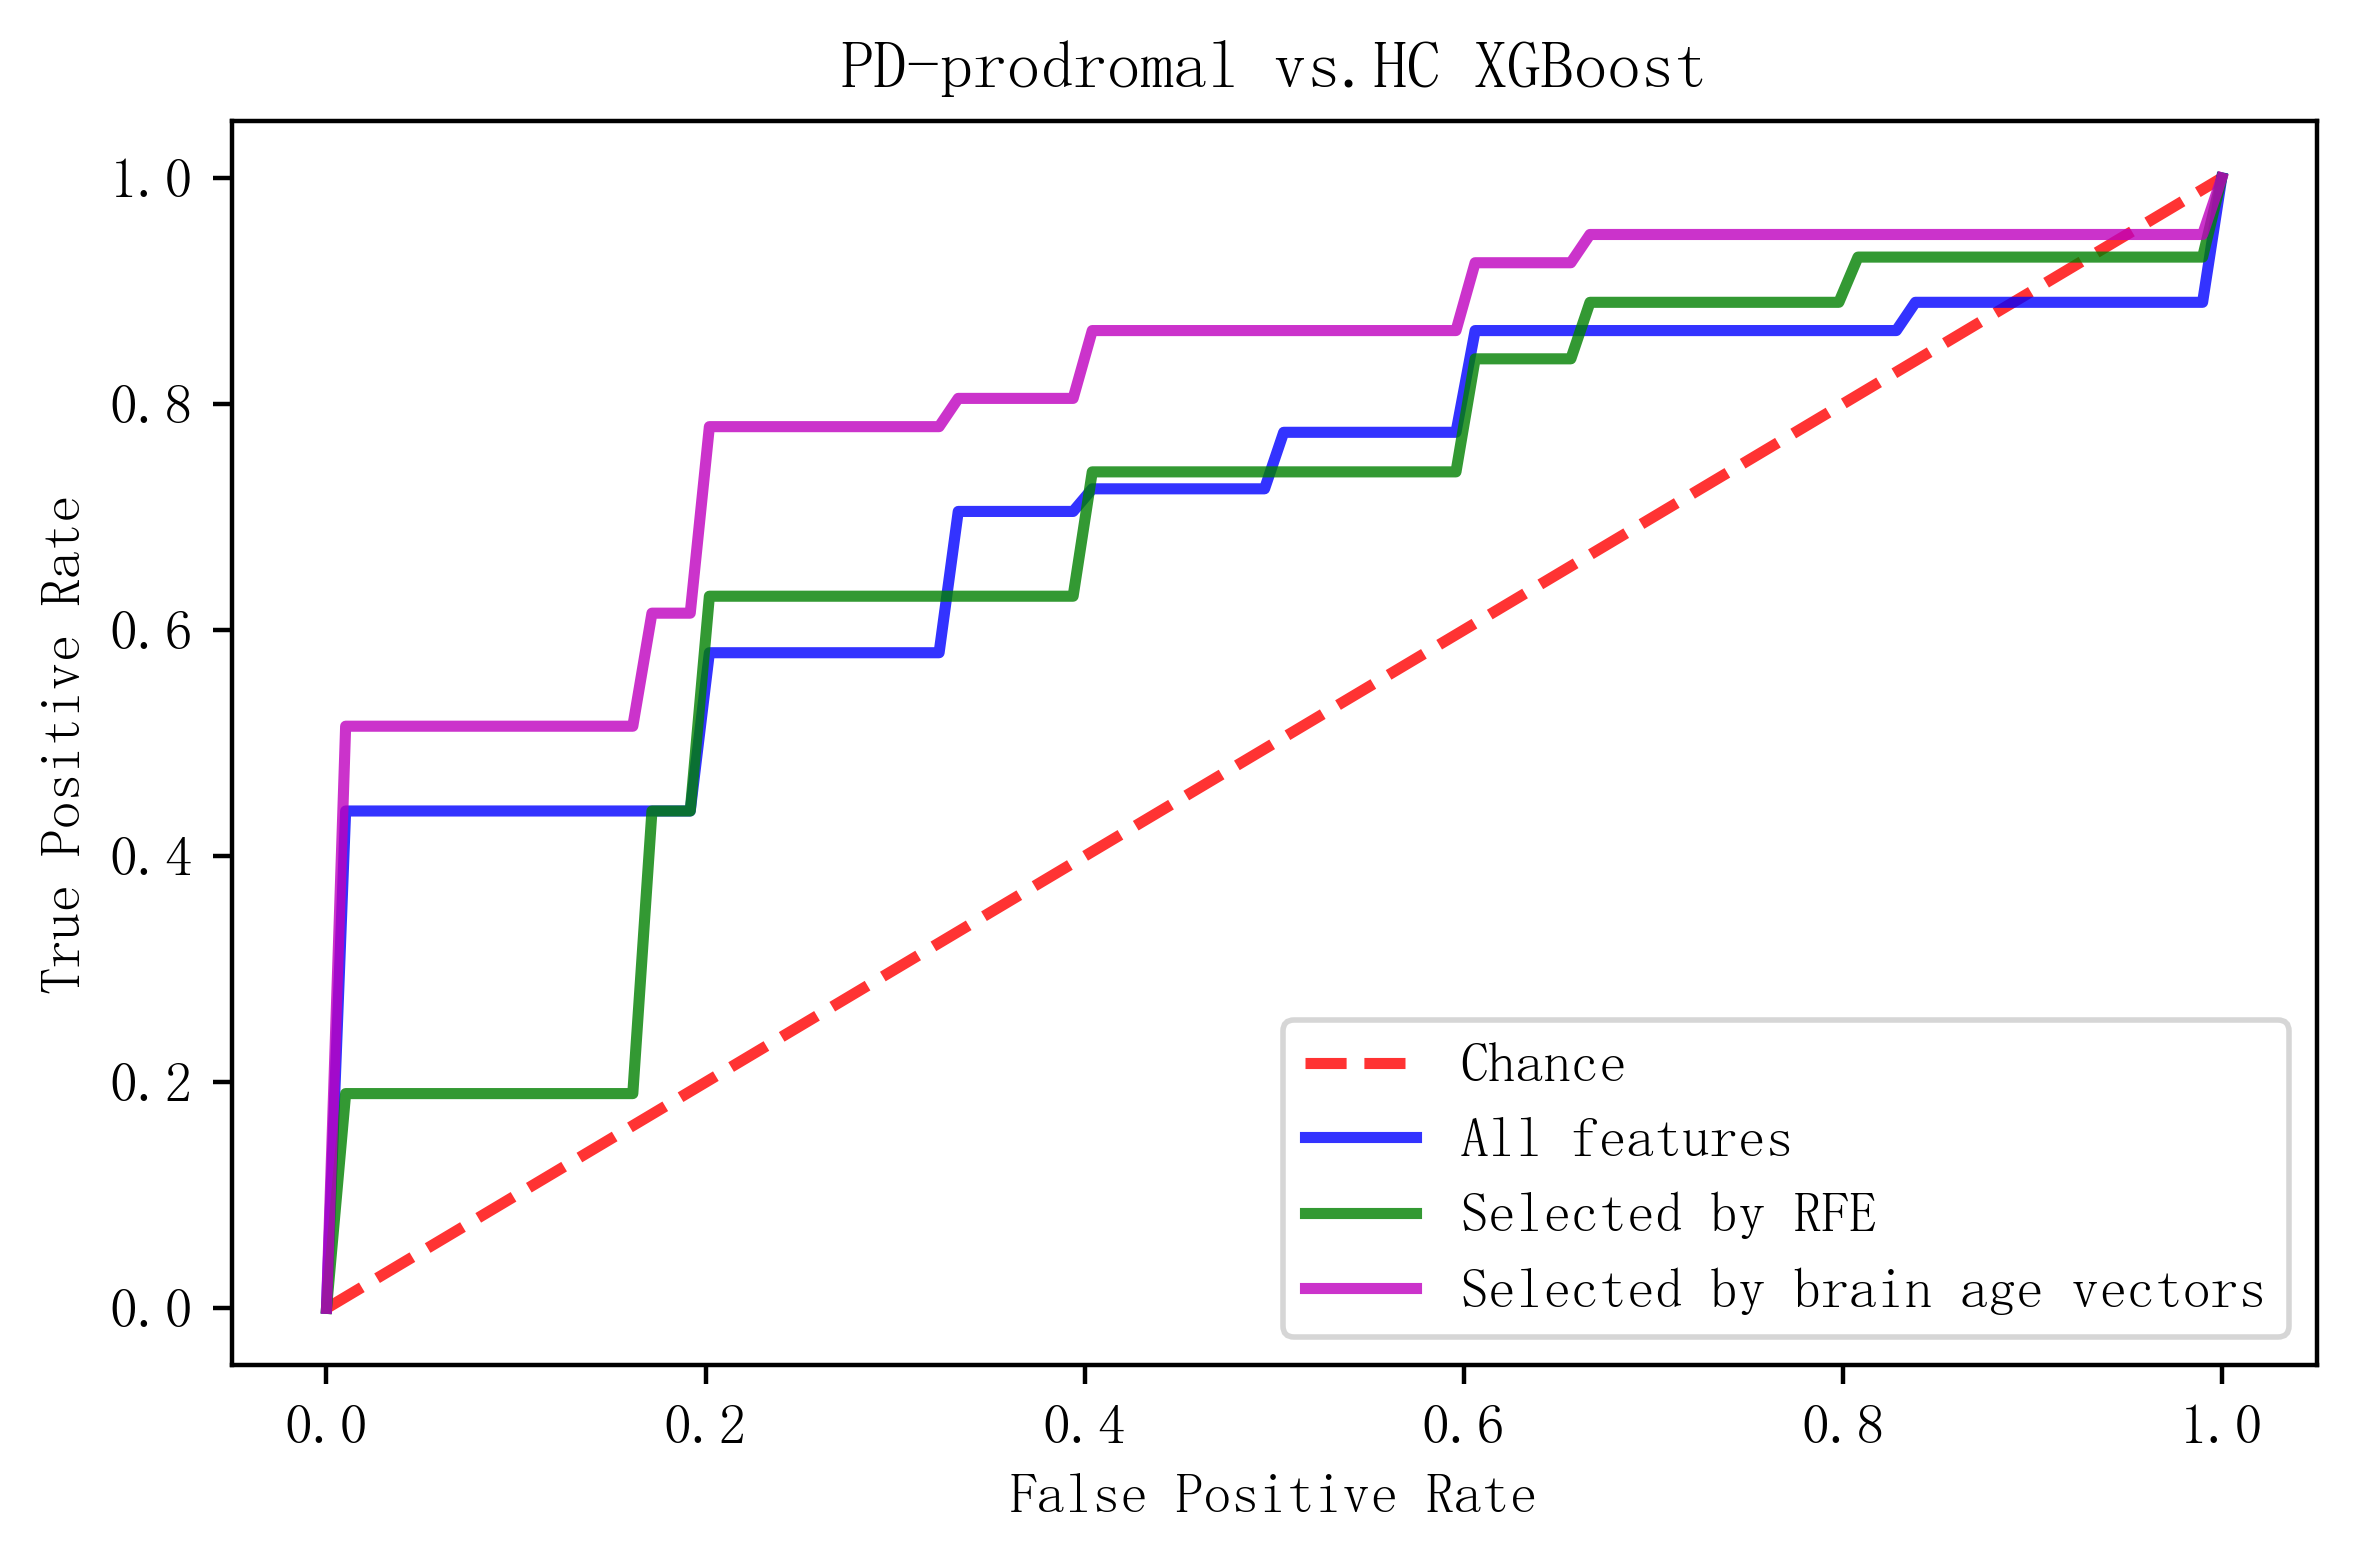

In [20]:
config = {
    "font.family":'serif',
    "font.size": 10,
    "mathtext.fontset": 'stix',
    "font.serif": ['SimSun'],

}
mpl.rcParams.update(config)

data1 = pd.read_csv(r"D:\rc\paper\csv\data5\filter_prodromal_baseline.csv")
data2 = pd.read_csv(r"D:\rc\paper\csv\data5\filter_HC_baseline.csv")
data1['label'] = 1
data2['label'] = 0
data = pd.concat([data1,data2]).reset_index(drop=True)

y = data.loc[:,'label']
X = data.drop(columns=['label','name'])

roi = ['Cerebellar White Matter(lh)', 'Putaman(lh)', 'Cerebrospinal Fluid', 'Accumbens(lh)', 'Choroid Plexus(lh)', 'Cortical white matter(rh)', 'medial orbitofrontal(lh)', 'postcentral(lh)', 'posterior cingulate(lh)', 'precentral(lh)', 'precuneus(lh)', 'rostral middle frontal(lh)', 'medial orbitofrontal(rh)', 'superior frontal(rh)', 'insula(rh)', 'CSF','sex','age']
X2 = data[roi]
y2 = data.loc[:,'label']

X1 = data.drop(columns=['name','label','age','sex'])
X1 = RFE(estimator=LinearSVC(), n_features_to_select=16).fit_transform(X1, y)
feat = pd.DataFrame(X1)
feat['age'] = data['age']
feat['sex'] = data['sex']
X1 = feat
y1 = data.loc[:,'label']


cv = StratifiedKFold(n_splits=10)
# classifier = lr(max_iter=2000)
# classifier1 = lr(max_iter=2000)
# classifier2 = lr(max_iter=2000)
param = {'n_estimators': 20, 'learning_rate': 0.18, 'max_depth': 3}
classifier = xgb.XGBClassifier(**param)
param1 = {'n_estimators': 12, 'learning_rate': 0.24, 'max_depth': 3}
classifier1 = xgb.XGBClassifier(**param1)
param2 = {'n_estimators': 58, 'learning_rate': 0.76, 'max_depth': 6}
# param2 = {'n_estimators': 10, 'learning_rate': 0.04, 'max_depth': 5}
classifier2 = xgb.XGBClassifier(**param2)
# classifier = GaussianNB()
# classifier1 = GaussianNB()


tprs = []
aucs = []

accs = []
sens = []
spes = []
aucss = []

mean_fpr = np.linspace(0, 1, 100)

for train, test in cv.split(X, y):
    features = X.drop(columns=['sex']).columns
    X_train = X.loc[train,:]
    X_test = X.loc[test,:]
    
#     for fea in features:
#         max = np.max(X_train[fea])
#         min = np.min(X_train[fea])
#         X_train[fea] = MinMaxNormalization(X_train[fea], max, min)
#         X_test[fea] = MinMaxNormalization(X_test[fea], max, min)
        
#     enc = OneHotEncoder()
#     enc.fit(X_train['sex'].values.reshape(-1, 1))
#     X_train['sex'] = enc.transform(X_train['sex'].values.reshape(-1, 1)).toarray()
#     X_test['sex'] = enc.transform(X_test['sex'].values.reshape(-1, 1)).toarray()
    
    model = classifier.fit(X_train, y[train])
    probas_ = model.predict_proba(X_test)
    y_pred = model.predict(X_test)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    accs.append(accuracy_score(y[test],y_pred))
    sens.append(recall_score(y[test], y_pred, average='binary'))
    spes.append(get_spe(y[test], y_pred))
    aucss.append(roc_auc_score(y[test], probas_[:, 1]))
#     plt.plot(fpr, tpr, lw=1, alpha=0.3,
#              label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))


tprs1 = []
aucs1 = []

accs1 = []
sens1 = []
spes1 = []
aucss1 = []

mean_fpr1 = np.linspace(0, 1, 100)
    
for train, test in cv.split(X1, y1):
    features = X1.columns
    X1_train = X1.loc[train,:]
    X1_test = X1.loc[test,:]
    
#     for fea in features:
#         max = np.max(X1_train[fea])
#         min = np.min(X1_train[fea])
#         X1_train[fea] = MinMaxNormalization(X1_train[fea], max, min)
#         X1_test[fea] = MinMaxNormalization(X1_test[fea], max, min)
    
#     enc = OneHotEncoder()
#     enc.fit(X1_train['sex'].values.reshape(-1, 1))
#     X1_train['sex'] = enc.transform(X1_train['sex'].values.reshape(-1, 1)).toarray()
#     X1_test['sex'] = enc.transform(X1_test['sex'].values.reshape(-1, 1)).toarray()
    
    model1 = classifier1.fit(X1_train, y1[train])
    probas_ = model1.predict_proba(X1_test)
    y_pred = model1.predict(X1_test)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y1[test], probas_[:, 1])
    tprs1.append(interp(mean_fpr1, fpr, tpr))
    tprs1[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs1.append(roc_auc)
    accs1.append(accuracy_score(y1[test],y_pred))
    sens1.append(recall_score(y1[test], y_pred, average='binary'))
    spes1.append(get_spe(y1[test], y_pred))
    aucss1.append(roc_auc_score(y1[test], probas_[:, 1]))
#     plt.plot(fpr, tpr, lw=1, alpha=0.3,
#              label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))


tprs2 = []
aucs2 = []

accs2 = []
sens2 = []
spes2 = []
aucss2 = []

mean_fpr2 = np.linspace(0, 1, 100)
    
for train, test in cv.split(X2, y2):
    features = X2.columns
    X2_train = X2.loc[train,:]
    X2_test = X2.loc[test,:]
    
#     for fea in features:
#         max = np.max(X2_train[fea])
#         min = np.min(X2_train[fea])
#         X2_train[fea] = MinMaxNormalization(X2_train[fea], max, min)
#         X2_test[fea] = MinMaxNormalization(X2_test[fea], max, min)
    
    model2 = classifier2.fit(X2_train, y2[train])
    probas_ = model2.predict_proba(X2_test)
    y_pred = model2.predict(X2_test)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y2[test], probas_[:, 1])
    tprs2.append(interp(mean_fpr2, fpr, tpr))
    tprs2[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs2.append(roc_auc)
    accs2.append(accuracy_score(y2[test],y_pred))
    sens2.append(recall_score(y2[test], y_pred, average='binary'))
    spes2.append(get_spe(y2[test], y_pred))
    aucss2.append(roc_auc_score(y2[test], probas_[:, 1]))
#     plt.plot(fpr, tpr, lw=1, alpha=0.3,
#              label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))


plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_tpr1 = np.mean(tprs1, axis=0)
mean_tpr1[-1] = 1.0
mean_tpr2 = np.mean(tprs2, axis=0)
mean_tpr1[-1] = 1.0


# mean_auc = auc(mean_fpr, mean_tpr)
# std_auc = np.std(aucs)
print('ACC = %0.4f ± %0.4f' % (np.mean(accs),np.std(accs)))
print('SEN = %0.4f ± %0.4f' % (np.mean(sens),np.std(sens)))
print('SPE = %0.4f ± %0.4f' % (np.mean(spes),np.std(spes)))
print('AUC = %0.4f ± %0.4f' % (np.mean(aucss),np.std(aucss)))
print('ACC = %0.4f ± %0.4f' % (np.mean(accs1),np.std(accs1)))
print('SEN = %0.4f ± %0.4f' % (np.mean(sens1),np.std(sens1)))
print('SPE = %0.4f ± %0.4f' % (np.mean(spes1),np.std(spes1)))
print('AUC = %0.4f ± %0.4f' % (np.mean(aucss1),np.std(aucss1)))
print('ACC = %0.4f ± %0.4f' % (np.mean(accs2),np.std(accs2)))
print('SEN = %0.4f ± %0.4f' % (np.mean(sens2),np.std(sens2)))
print('SPE = %0.4f ± %0.4f' % (np.mean(spes2),np.std(spes2)))
print('AUC = %0.4f ± %0.4f' % (np.mean(aucss2),np.std(aucss2)))


plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'All features',
         lw=2, alpha=.8)
plt.plot(mean_fpr1, mean_tpr1, color='g',
         label=r'Selected by RFE',
         lw=2, alpha=.8)
plt.plot(mean_fpr2, mean_tpr2, color='m',
         label=r'Selected by brain age vectors',
         lw=2, alpha=.8)
# std_tpr = np.std(tprs, axis=0)
# tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
# tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
# plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
#                  label=r'$\pm$ 1 std. dev.')

plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.dpi'] = 400
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('PD-prodromal vs.HC XGBoost')
plt.legend(loc="lower right")
# plt.savefig(r"D:\rc\paper\figure2\fig4.png", dpi=400)
plt.show()    
    


C:\Users\Lenovo\Anaconda3\lib\site-packages\matplotlib\figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


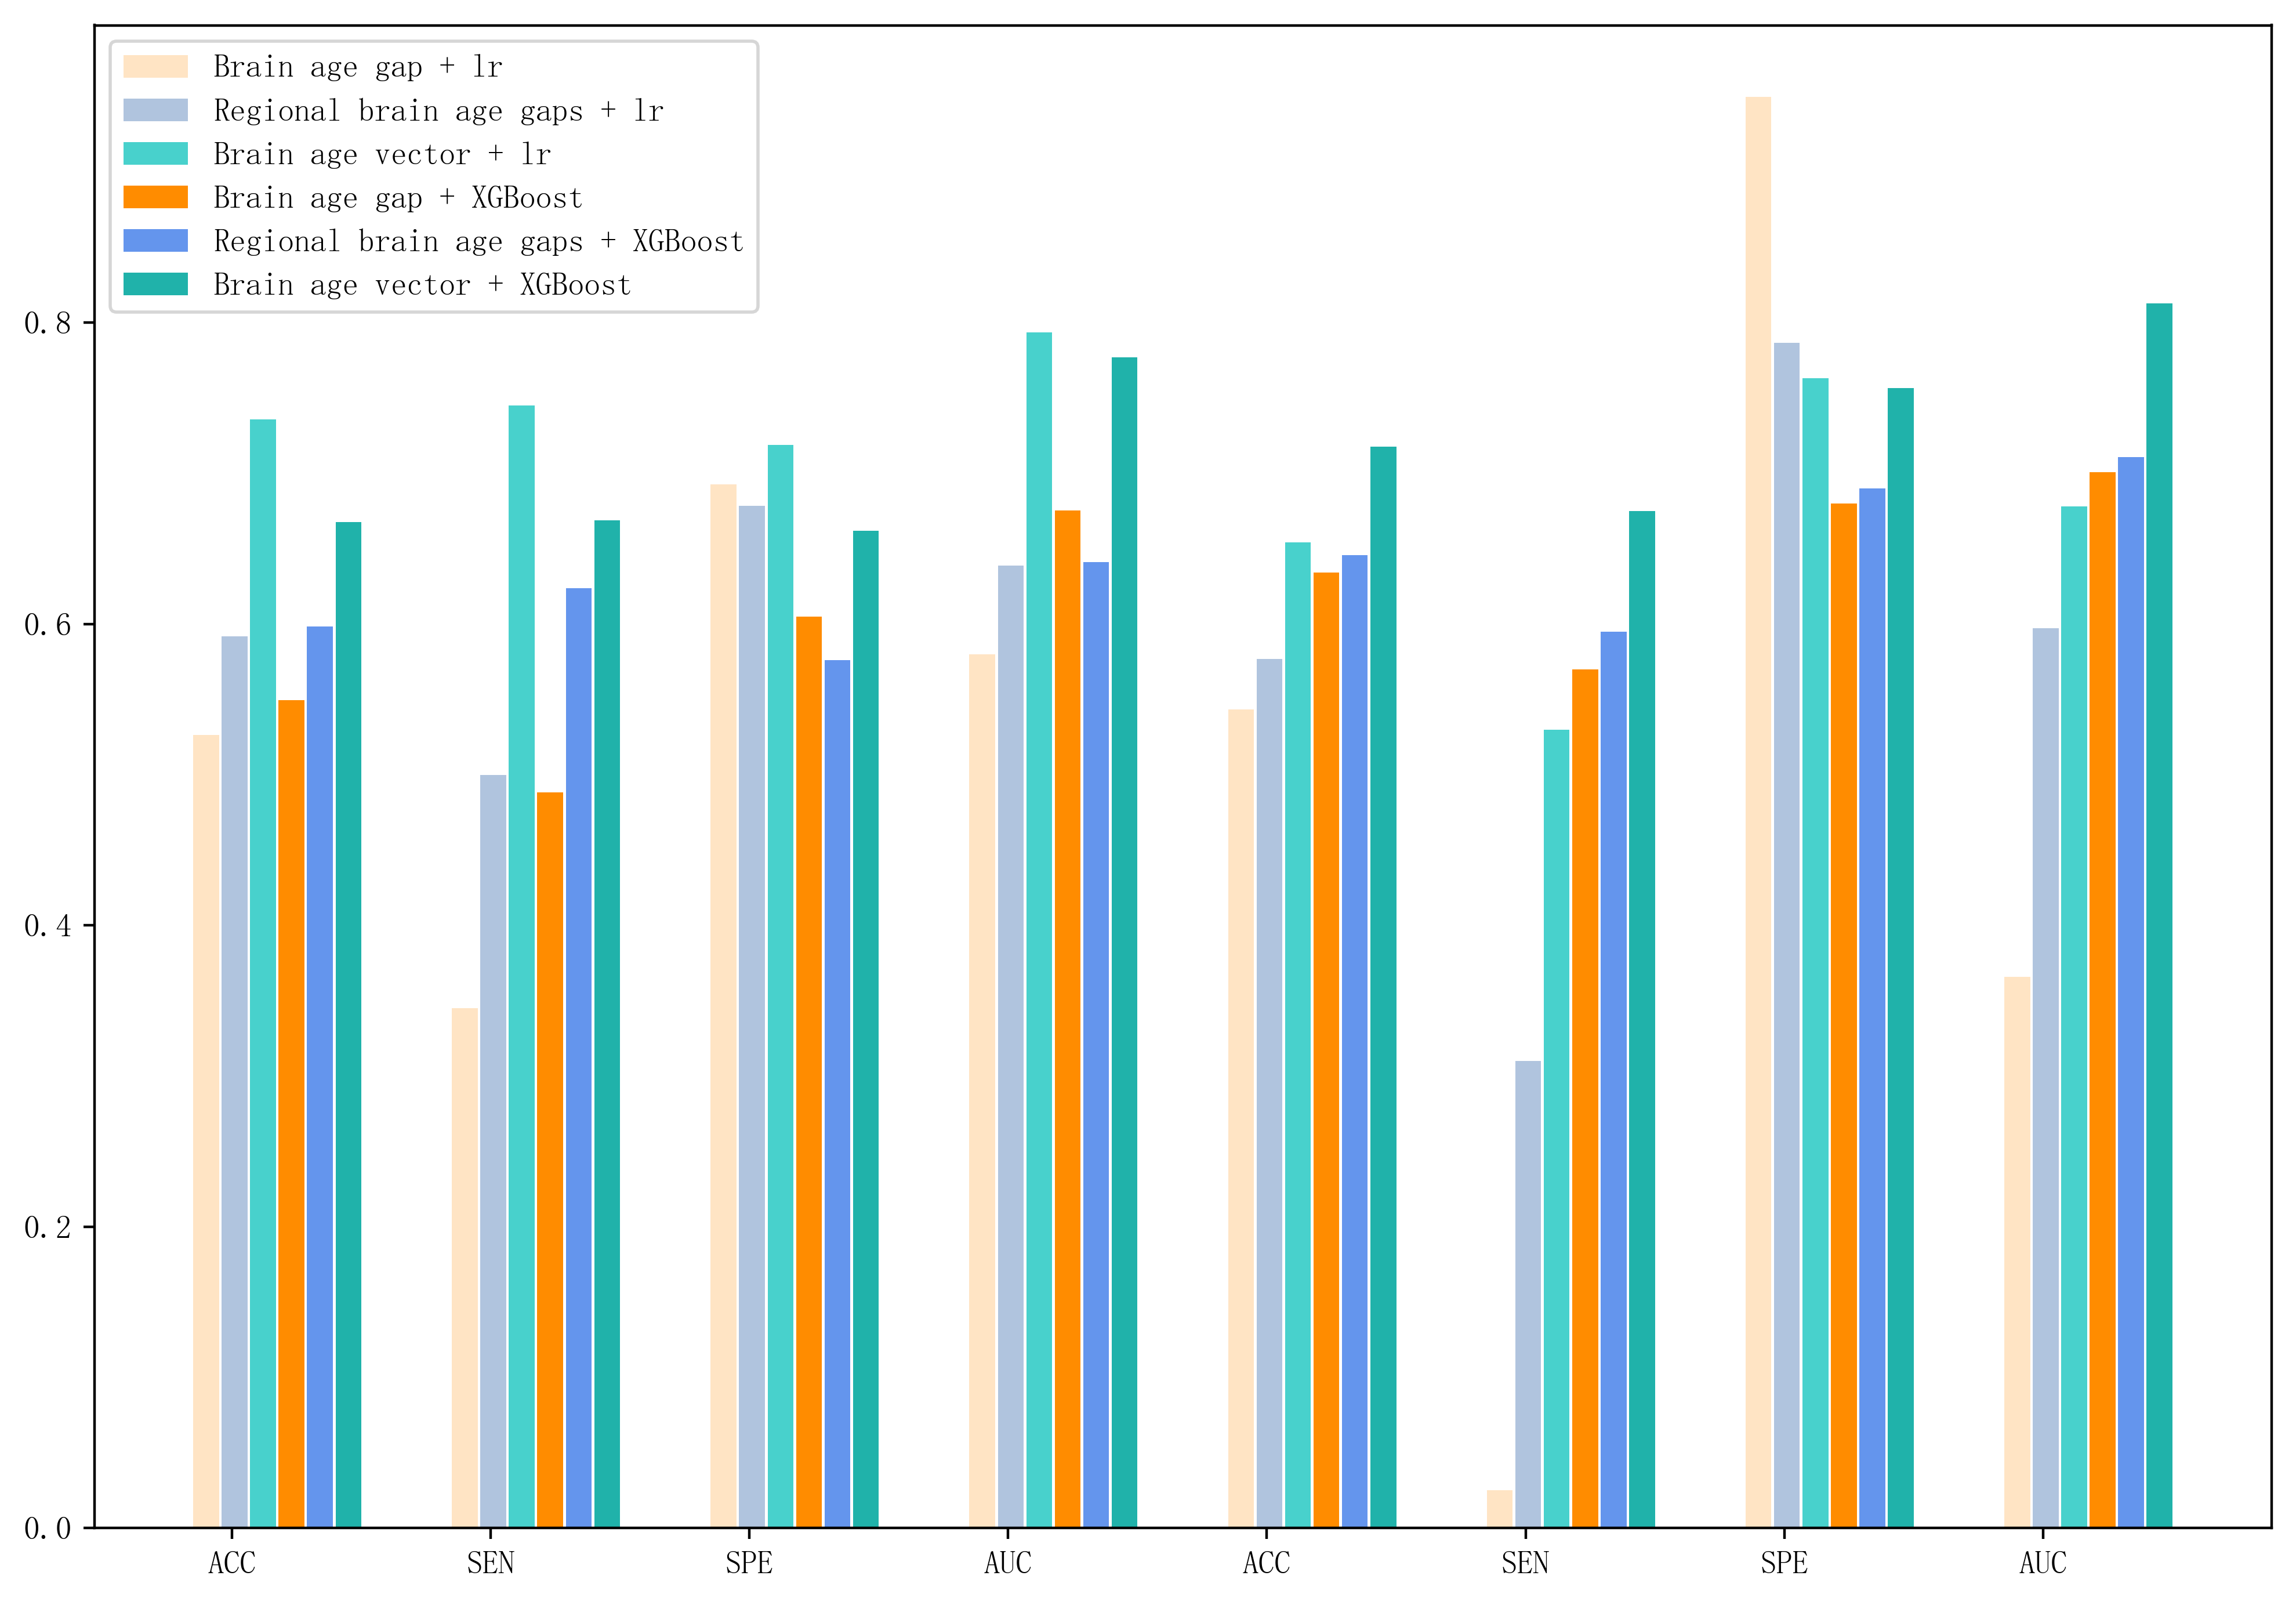

In [101]:
shops = ["ACC", "SEN", "SPE", "AUC", "ACC", "SEN", "SPE", "AUC"]
sales_product_1 = [0.5264, 0.3452, 0.6929, 0.5799, 0.5433, 0.0250, 0.9500, 0.3658]
sales_product_2 = [0.5918, 0.5000, 0.6786, 0.6388, 0.5767, 0.3100, 0.7867, 0.5973]
sales_product_3 = [0.7357, 0.7452, 0.7190, 0.7935, 0.6544, 0.5300, 0.7633, 0.6780]
sales_product_4 = [0.5495, 0.4881, 0.6048, 0.6753, 0.6344, 0.5700, 0.6800, 0.7010]
sales_product_5 = [0.5984, 0.6238, 0.5762, 0.6412, 0.6456, 0.5950, 0.6900, 0.7107]
sales_product_6 = [0.6676, 0.6690, 0.6619, 0.7772, 0.7178, 0.6750, 0.7567, 0.8127]

# 创建分组柱状图，需要自己控制x轴坐标
xticks = np.arange(len(shops))

fig, ax = plt.subplots(figsize=(10, 7))
# 所有门店第一种产品的销量，注意控制柱子的宽度，这里选择0.25
ax.bar(xticks, sales_product_1, width=0.1, label="Brain age gap + lr", color="bisque")
# 所有门店第二种产品的销量，通过微调x轴坐标来调整新增柱子的位置
ax.bar(xticks + 0.11, sales_product_2, width=0.1, label="Regional brain age gaps + lr", color="lightsteelblue")
# 所有门店第三种产品的销量，继续微调x轴坐标调整新增柱子的位置
ax.bar(xticks + 0.22, sales_product_3, width=0.1, label="Brain age vector + lr", color="mediumturquoise")
# 所有门店第一种产品的销量，注意控制柱子的宽度，这里选择0.25
ax.bar(xticks + 0.33, sales_product_4, width=0.1, label="Brain age gap + XGBoost", color="darkorange")
# 所有门店第二种产品的销量，通过微调x轴坐标来调整新增柱子的位置
ax.bar(xticks + 0.44, sales_product_5, width=0.1, label="Regional brain age gaps + XGBoost", color="cornflowerblue")
# 所有门店第三种产品的销量，继续微调x轴坐标调整新增柱子的位置
ax.bar(xticks + 0.55, sales_product_6, width=0.1, label="Brain age vector + XGBoost", color="lightseagreen")

# ax.set_title("Grouped Bar plot", fontsize=15)
# ax.set_xlabel("Shops")
# ax.set_ylabel("Product Sales")
ax.legend()

# 最后调整x轴标签的位置
ax.set_xticks(xticks + 0.1)
ax.set_xticklabels(shops)

plt.savefig(r"D:\rc\paper\fig\classification_performance.png", dpi=400)
plt.show()

In [11]:
########################################################PD vs. RBD选特征
sMCI = pd.read_csv(r"D:\rc\paper\csv\data5\shap_values_HC_label.csv")
pMCI = pd.read_csv(r"D:\rc\paper\csv\data5\shap_values_prodromal_label.csv")

features = sMCI.drop(columns=['sex']).columns

marker1 = []
for fea in features:
    p = get_p(sMCI[fea],pMCI[fea])
    if p <=0.05:
        marker1.append(fea)
print(marker1)

marker = []
for fea in features:
    if stats.levene(sMCI[fea],pMCI[fea]).pvalue > 0.05:
        p = stats.ttest_ind(sMCI[fea],pMCI[fea]).pvalue
    else:
        p = stats.ttest_ind(sMCI[fea],pMCI[fea],equal_var=False).pvalue
    if p <=0.05:
        marker.append(fea)
print(marker)
    
df = np.zeros([len(features),3])
i = 0
for fea in features:
    use = []
    mean_hc = np.mean(sMCI[fea])
    mean_pd = np.mean(pMCI[fea])
#     p = get_p(sMCI[fea],pMCI[fea])
    
    if stats.levene(sMCI[fea],pMCI[fea]).pvalue > 0.05:
        p = stats.ttest_ind(sMCI[fea],pMCI[fea]).pvalue
    else:
        p = stats.ttest_ind(sMCI[fea],pMCI[fea],equal_var=False).pvalue
    
    use.append(mean_hc)
    use.append(mean_pd)
    use.append(p)
    df[i,:] = use
    i = i+1
df = pd.DataFrame(df)

df_marker = pd.DataFrame(df.values, index=features, columns=['mean_HC','mean_prodromal','pvalue'])
# df_marker = df_marker.sort_values(by = 'pvalue', ascending=True, axis=0)
print(df_marker)
df_marker.to_csv(r"D:\rc\paper\csv\data5\pvalues_PD_label.csv", index=True)
    

['label 7', 'label 12', 'label 24', 'label 26', 'label 31', 'label 41', 'label 1014', 'label 1022', 'label 1023', 'label 1024', 'label 1025', 'label 1027', 'label 2014', 'label 2028', 'label 2035', 'CSF']
['label 7', 'label 12', 'label 24', 'label 26', 'label 31', 'label 41', 'label 1014', 'label 1022', 'label 1023', 'label 1024', 'label 1025', 'label 1027', 'label 2014', 'label 2028', 'label 2035', 'CSF']
             mean_HC  mean_prodromal    pvalue
label 2     0.013432       -0.010556  0.127995
label 4     0.009536        0.010696  0.812787
label 5    -0.008046       -0.027095  0.052035
label 7    -0.004412       -0.016274  0.047692
label 8     0.003597        0.003975  0.910036
label 10    0.181118        0.153092  0.453548
label 11   -0.002830       -0.002756  0.963055
label 12    0.004183       -0.005567  0.041321
label 13   -0.007167        0.015214  0.146097
label 14    0.001922        0.002299  0.940533
label 15   -0.000790        0.003581  0.592418
label 16    0.000807      

In [12]:
data0 = pd.read_csv(r"D:\rc\paper\csv\norm_cleaned_rel_volume_train.csv")
print(np.mean(data0))

Cortical white matter(lh)          0.160761
Lateral Ventricle(lh)              0.008618
Inferior Lateral Ventricle(lh)     0.000322
Cerebellar White Matter(lh)        0.009743
Cerebellar Cortex(lh)              0.037390
Thalamus(lh)                       0.004924
Caudate(lh)                        0.002394
Putaman(lh)                        0.003253
Pallidum(lh)                       0.001412
3rd-Ventricle                      0.000880
4th-Ventricle                      0.001146
Brain Stem                         0.014898
Hippocampus(lh)                    0.002879
Amygdala(lh)                       0.001214
Cerebrospinal Fluid                0.000791
Accumbens(lh)                      0.000367
Ventral DC(lh)                     0.003026
Choroid Plexus(lh)                 0.000649
Cortical white matter(rh)          0.161759
Lateral Ventricle (rh)             0.007757
Inferior Lateral Ventricle(rh)     0.000294
Cerebellar White Matter(rh)        0.009480
Cerebellar Cortex(rh)           

In [56]:
subj = pd.read_csv(r"D:\rc\paper\csv\data5\pMCI_1yearsbefore.csv")
info = pd.read_csv(r"D:\rc\paper\csv\data5\A_pMCI_within3years_rc_10_05_2021.csv")
info = pd.merge(subj[['name','age','sex']], info[['name','Subject','Group']], on='name')

date = pd.read_csv(r"D:\rc\hippo_T2\pMCIwithin3years_cleaned.csv")
date = date[['Subject','year1']]

info = pd.merge(info, date, on='Subject')
info['RID'] = ''
for i in range(np.shape(info)[0]):
    info.loc[i,'RID'] = str(info.loc[i,'Subject'].split('_')[-1])

MMSE = pd.read_csv(r"D:\rc\paper\csv\data5\MMSE.csv") 
MMSE = MMSE[['RID','MMSCORE','USERDATE']]
MMSE['rid'] = MMSE['RID']
MMSE['date'] = ''
for i in range(np.shape(MMSE)[0]):
    if MMSE.loc[i,'rid']<10:
        MMSE.loc[i,'RID'] = str(0) + str(0) + str(0) + str(MMSE.loc[i,'rid'])
    if (MMSE.loc[i,'rid']>=10) and (MMSE.loc[i,'rid']<100):
        MMSE.loc[i,'RID'] = str(0) + str(0) + str(MMSE.loc[i,'rid'])
    if (MMSE.loc[i,'rid']>=100) and (MMSE.loc[i,'rid']<1000):
        MMSE.loc[i,'RID'] = str(0) + str(MMSE.loc[i,'rid'])
    if MMSE.loc[i,'rid'] >= 1000:
        MMSE.loc[i,'RID'] = str(MMSE.loc[i,'rid'])
    
#     print(MMSE.loc[i,'USERDATE'])
    
    year = str(MMSE.loc[i,'USERDATE'].split('-')[0])
    month = str(MMSE.loc[i,'USERDATE'].split('-')[1])
    day = str(MMSE.loc[i,'USERDATE'].split('-')[2])
#     if int(MMSE.loc[i,'USERDATE'].split('/')[1]) < 10:
#         month = str(0) + str(MMSE.loc[i,'USERDATE'].split('/')[1])
#     else:
#         month = str(MMSE.loc[i,'USERDATE'].split('/')[1])
    
#     if int(MMSE.loc[i,'USERDATE'].split('/')[2]) < 10:
#         day = str(0) + str(MMSE.loc[i,'USERDATE'].split('/')[2])
#     else:
#         day = str(MMSE.loc[i,'USERDATE'].split('/')[2])
    MMSE.loc[i,'date'] = int(year + month + day)
#     print(MMSE.loc[i,'date'])

CDR = pd.read_csv(r"D:\rc\paper\csv\data5\CDR.csv") 
CDR = CDR[['RID','CDGLOBAL','USERDATE']]
CDR['rid'] = CDR['RID']
CDR['date'] = ''
for i in range(np.shape(CDR)[0]):
    if CDR.loc[i,'rid']<10:
        CDR.loc[i,'RID'] = str(0) + str(0) + str(0) + str(CDR.loc[i,'rid'])
    if (CDR.loc[i,'rid']>=10) and (CDR.loc[i,'rid']<100):
        CDR.loc[i,'RID'] = str(0) + str(0) + str(CDR.loc[i,'rid'])
    if (CDR.loc[i,'rid']>=100) and (CDR.loc[i,'rid']<1000):
        CDR.loc[i,'RID'] = str(0) + str(CDR.loc[i,'rid'])
    if CDR.loc[i,'rid'] >= 1000:
        CDR.loc[i,'RID'] = str(CDR.loc[i,'rid'])
    
#     print(MMSE.loc[i,'USERDATE'])
    
    year = str(CDR.loc[i,'USERDATE'].split('-')[0])
    month = str(CDR.loc[i,'USERDATE'].split('-')[1])
    day = str(CDR.loc[i,'USERDATE'].split('-')[2])
    CDR.loc[i,'date'] = int(year + month + day)
#     print(MMSE.loc[i,'date'])
                               
info['MMSE']=''
info['dist1']= ''
info['CDR']=''
info['dist2']= ''
for i in range(np.shape(info)[0]):
    RID = info.loc[i,'RID']
#     print(RID)
    date = info.loc[i,'year1']
    
    tmp1 = MMSE[MMSE['RID']==RID]
    tmp1 = tmp1.reset_index(drop=True)
    tmp1['dist1'] = ''
    
    tmp2 = CDR[CDR['RID']==RID]
    tmp2 = tmp2.reset_index(drop=True)
    tmp2['dist2'] = ''
    
    for j in range(np.shape(tmp1)[0]):
        tmp1.loc[j,'dist1'] = np.abs(tmp1.loc[j,'date']-date)
#     print(tmp)
    for k in range(np.shape(tmp2)[0]):
        tmp2.loc[k,'dist2'] = np.abs(tmp2.loc[k,'date']-date)
    idx1 = (tmp1[tmp1['dist1']==np.min(tmp1['dist1'])].index.values)[0]
#     print(idx, type(idx))
    idx2 = (tmp2[tmp2['dist2']==np.min(tmp2['dist2'])].index.values)[0]
    
    info.loc[i,'MMSE'] = tmp1.loc[idx1,'MMSCORE']
    info.loc[i,'dist1'] = tmp1.loc[idx1,'dist1']
    
    info.loc[i,'CDR'] = tmp2.loc[idx2,'CDGLOBAL']
    info.loc[i,'dist2'] = tmp2.loc[idx2,'dist2']
       
print(info) 
    
# CDR = pd.read_csv(r"D:\rc\paper\csv\data5\CDR.csv")
# CDR = CDR[['RID','CDGLOBAL']]

# MoCA = pd.read_csv(r"D:\rc\paper\csv\data5\Montreal_Cognitive_Assessment__MoCA_.csv")
# MoCA = MoCA[['']]



C:\Users\Lenovo\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (8,58,59,60,61,62,63,64) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


       name  age  sex     Subject Group     year1   RID  MMSE  dist1  CDR  \
0   I166629   79    1  098_S_0160   MCI  20100214  0160    20      5  0.5   
1   I161002   76    1  022_S_1097   MCI  20091208  1097    23      1  0.5   
2    I95782   83    1  018_S_0155   MCI  20080306  0155    27      4  0.5   
3   I404950   58    1  052_S_4945  LMCI  20140117  4945    30    203  0.5   
4   I100760   79    1  011_S_0326   MCI  20080404  0326    25      0  0.5   
5   I486924   70    0  035_S_4582  LMCI  20150325  4582    25    301  0.5   
6   I102584   74    1  041_S_0314   MCI  20080414  0314    26     11  0.5   
7   I129059   79    1  137_S_0973   MCI  20081203  0973    27      6  0.5   
8   I417943   72    1  002_S_4521  LMCI  20140314  4521    25      1  0.5   
9   I409516   81    0  123_S_0106    CN  20140128  0106    27      1  0.5   
10  I143659   84    1  021_S_0424   MCI  20090512  0424    27      9  0.5   
11  I389376   76    0  016_S_4902  LMCI  20130910  4902    25      1  0.5   

In [58]:
info.to_csv(r"D:\rc\paper\csv\data5\scale_pMCI.csv", index=False)

In [70]:
subj = pd.read_csv(r"D:\rc\paper\csv\data5\sMCI_1styear.csv")
info = pd.read_csv(r"D:\rc\paper\csv\data5\A_sMCI_first3years_rc_10_05_2021.csv")
info = pd.merge(subj[['name','age','sex']], info[['name','Subject','Group']], on='name')

date = pd.read_csv(r"D:\rc\hippo_T2\sMCIfirst3years_age_cleaned3.csv")
date = date[['Subject','year0']]

info = pd.merge(info, date, on='Subject')
info['RID'] = ''
for i in range(np.shape(info)[0]):
    info.loc[i,'RID'] = str(info.loc[i,'Subject'].split('_')[-1])

MMSE = pd.read_csv(r"D:\rc\paper\csv\data5\MMSE.csv") 
MMSE = MMSE[['RID','MMSCORE','USERDATE']]
MMSE['rid'] = MMSE['RID']
MMSE['date'] = ''
for i in range(np.shape(MMSE)[0]):
    if MMSE.loc[i,'rid']<10:
        MMSE.loc[i,'RID'] = str(0) + str(0) + str(0) + str(MMSE.loc[i,'rid'])
    if (MMSE.loc[i,'rid']>=10) and (MMSE.loc[i,'rid']<100):
        MMSE.loc[i,'RID'] = str(0) + str(0) + str(MMSE.loc[i,'rid'])
    if (MMSE.loc[i,'rid']>=100) and (MMSE.loc[i,'rid']<1000):
        MMSE.loc[i,'RID'] = str(0) + str(MMSE.loc[i,'rid'])
    if MMSE.loc[i,'rid'] >= 1000:
        MMSE.loc[i,'RID'] = str(MMSE.loc[i,'rid'])
    
#     print(MMSE.loc[i,'USERDATE'])
    
    year = str(MMSE.loc[i,'USERDATE'].split('-')[0])
    month = str(MMSE.loc[i,'USERDATE'].split('-')[1])
    day = str(MMSE.loc[i,'USERDATE'].split('-')[2])
#     if int(MMSE.loc[i,'USERDATE'].split('/')[1]) < 10:
#         month = str(0) + str(MMSE.loc[i,'USERDATE'].split('/')[1])
#     else:
#         month = str(MMSE.loc[i,'USERDATE'].split('/')[1])
    
#     if int(MMSE.loc[i,'USERDATE'].split('/')[2]) < 10:
#         day = str(0) + str(MMSE.loc[i,'USERDATE'].split('/')[2])
#     else:
#         day = str(MMSE.loc[i,'USERDATE'].split('/')[2])
    MMSE.loc[i,'date'] = int(year + month + day)
#     print(MMSE.loc[i,'date'])

CDR = pd.read_csv(r"D:\rc\paper\csv\data5\CDR.csv") 
CDR = CDR[['RID','CDGLOBAL','USERDATE']]
CDR['rid'] = CDR['RID']
CDR['date'] = ''
for i in range(np.shape(CDR)[0]):
    if CDR.loc[i,'rid']<10:
        CDR.loc[i,'RID'] = str(0) + str(0) + str(0) + str(CDR.loc[i,'rid'])
    if (CDR.loc[i,'rid']>=10) and (CDR.loc[i,'rid']<100):
        CDR.loc[i,'RID'] = str(0) + str(0) + str(CDR.loc[i,'rid'])
    if (CDR.loc[i,'rid']>=100) and (CDR.loc[i,'rid']<1000):
        CDR.loc[i,'RID'] = str(0) + str(CDR.loc[i,'rid'])
    if CDR.loc[i,'rid'] >= 1000:
        CDR.loc[i,'RID'] = str(CDR.loc[i,'rid'])
    
#     print(MMSE.loc[i,'USERDATE'])
    
    year = str(CDR.loc[i,'USERDATE'].split('-')[0])
    month = str(CDR.loc[i,'USERDATE'].split('-')[1])
    day = str(CDR.loc[i,'USERDATE'].split('-')[2])
    CDR.loc[i,'date'] = int(year + month + day)
#     print(MMSE.loc[i,'date'])

# ADAS1 = pd.read_csv(r"D:\rc\paper\csv\data5\ADAS_ADNI1 (1).csv")
# ADAS2 = PD.read_csv(r"C:\Users\Lenovo\Downloads\ADAS_ADNIGO23 (1).csv")
# ADAS = pd.concat([ADAS1, ADAS2]).reset_index(drop=True)
# ADAS = ADAS[['RID','MOCA','USERDATE']]
# ADAS['rid'] = ADAS['RID']
# ADAS['date'] = ''
# for i in range(np.shape(MoCA)[0]):
#     if MoCA.loc[i,'rid']<10:
#         MoCA.loc[i,'RID'] = str(0) + str(0) + str(0) + str(MoCA.loc[i,'rid'])
#     if (MoCA.loc[i,'rid']>=10) and (MoCA.loc[i,'rid']<100):
#         MoCA.loc[i,'RID'] = str(0) + str(0) + str(MoCA.loc[i,'rid'])
#     if (MoCA.loc[i,'rid']>=100) and (MoCA.loc[i,'rid']<1000):
#         MoCA.loc[i,'RID'] = str(0) + str(MoCA.loc[i,'rid'])
#     if MoCA.loc[i,'rid'] >= 1000:
#         MoCA.loc[i,'RID'] = str(MoCA.loc[i,'rid'])
    
# #     print(MMSE.loc[i,'USERDATE'])
    
#     year = str(MoCA.loc[i,'USERDATE'].split('-')[0])
#     month = str(MoCA.loc[i,'USERDATE'].split('-')[1])
#     day = str(MoCA.loc[i,'USERDATE'].split('-')[2])
#     MoCA.loc[i,'date'] = int(year + month + day)
                               
# GDS = pd.read_csv(r"D:\rc\paper\csv\data5\GDSCALE.csv") 
# GDS = GDS[['RID','GDTOTAL','USERDATE']]
# GDS['rid'] = GDS['RID']
# GDS['date'] = ''
# for i in range(np.shape(GDS)[0]):
#     if GDS.loc[i,'rid']<10:
#         GDS.loc[i,'RID'] = str(0) + str(0) + str(0) + str(GDS.loc[i,'rid'])
#     if (GDS.loc[i,'rid']>=10) and (GDS.loc[i,'rid']<100):
#         GDS.loc[i,'RID'] = str(0) + str(0) + str(GDS.loc[i,'rid'])
#     if (GDS.loc[i,'rid']>=100) and (GDS.loc[i,'rid']<1000):
#         GDS.loc[i,'RID'] = str(0) + str(GDS.loc[i,'rid'])
#     if GDS.loc[i,'rid'] >= 1000:
#         GDS.loc[i,'RID'] = str(GDS.loc[i,'rid'])
    
# #     print(MMSE.loc[i,'USERDATE'])
    
#     year = str(GDS.loc[i,'USERDATE'].split('-')[0])
#     month = str(GDS.loc[i,'USERDATE'].split('-')[1])
#     day = str(GDS.loc[i,'USERDATE'].split('-')[2])
#     GDS.loc[i,'date'] = int(year + month + day)
# #     print(MMSE.loc[i,'date'])
        
info['MMSE']=''
info['dist1']= ''
info['CDR']=''
info['dist2']= ''
# info['ADAS']=''
# info['dist3']= ''
# info['GDS']=''
# info['dist4']= ''
for i in range(np.shape(info)[0]):
    RID = info.loc[i,'RID']
#     print(RID)
    date = info.loc[i,'year0']
    
    tmp1 = MMSE[MMSE['RID']==RID]
    tmp1 = tmp1.reset_index(drop=True)
    tmp1['dist1'] = ''
    
    tmp2 = CDR[CDR['RID']==RID]
    tmp2 = tmp2.reset_index(drop=True)
    tmp2['dist2'] = ''
    
#     tmp3 = MoCA[MoCA['RID']==RID]
#     tmp3 = tmp3.reset_index(drop=True)
#     tmp3['dist3'] = ''
    
#     tmp4 = GDS[GDS['RID']==RID]
#     tmp4 = tmp4.reset_index(drop=True)
#     tmp4['dist4'] = ''
    
    for j in range(np.shape(tmp1)[0]):
        tmp1.loc[j,'dist1'] = np.abs(tmp1.loc[j,'date']-date)
#     print(tmp)
    for k in range(np.shape(tmp2)[0]):
        tmp2.loc[k,'dist2'] = np.abs(tmp2.loc[k,'date']-date)    
#     for f in range(np.shape(tmp3)[0]):
#         tmp3.loc[f,'dist3'] = np.abs(tmp3.loc[f,'date']-date)
#     for l in range(np.shape(tmp4)[0]):
#         tmp4.loc[l,'dist4'] = np.abs(tmp4.loc[l,'date']-date)
        
        
    idx1 = (tmp1[tmp1['dist1']==np.min(tmp1['dist1'])].index.values)[0]
#     print(idx, type(idx))
    idx2 = (tmp2[tmp2['dist2']==np.min(tmp2['dist2'])].index.values)[0]
#     idx3 = (tmp3[tmp3['dist3']==np.min(tmp3['dist3'])].index.values)[0]
# #     print(idx, type(idx))
#     idx4 = (tmp4[tmp4['dist4']==np.min(tmp4['dist4'])].index.values)[0]
    
    info.loc[i,'MMSE'] = tmp1.loc[idx1,'MMSCORE']
    info.loc[i,'dist1'] = tmp1.loc[idx1,'dist1']
    
    info.loc[i,'CDR'] = tmp2.loc[idx2,'CDGLOBAL']
    info.loc[i,'dist2'] = tmp2.loc[idx2,'dist2']
    
#     info.loc[i,'MoCA'] = tmp3.loc[idx3,'MOCA']
#     info.loc[i,'dist3'] = tmp3.loc[idx3,'dist3']
    
#     info.loc[i,'GDS'] = tmp4.loc[idx4,'GDTOTAL']
#     info.loc[i,'dist4'] = tmp4.loc[idx4,'dist4']
       
print(info) 
# info.to_csv(r"D:\rc\paper\csv\data5\scale_sMCI.csv", index=False)

C:\Users\Lenovo\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (8,58,59,60,61,62,63,64) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


       name  age  sex     Subject Group     year0   RID  MMSE  dist1  CDR  \
0   I260977   78    0  135_S_4281  EMCI  20111014  4281    27      4  0.5   
1   I298635   81    0  128_S_4653  LMCI  20120418  4653    29     89  0.5   
2   I282260   74    1  135_S_4489  LMCI  20120202  4489    30     76  0.5   
3    I36744   88    1  128_S_1088   MCI  20070118  1088    21    606  0.5   
4   I295495   68    1  072_S_4613  EMCI  20120402  4613    27     80  0.5   
5   I281143   89    1  031_S_4476  EMCI  20120127  4476    30     14  0.5   
6   I278815   68    0  002_S_4447  EMCI  20120117  4447    27     13  0.5   
7   I279186   75    1  130_S_4417  EMCI  20120118  4417    30      8  0.5   
8    I62723   82    1  041_S_1418   MCI  20070727  1418    29     24  0.5   
9   I299203   78    1  024_S_4674  EMCI  20120420  4674    24      8  0.5   
10   I29904   77    0  133_S_1031   MCI  20061116  1031    29     96  0.5   
11  I254389   69    1  072_S_4206  EMCI  20110902  4206    26     72  0.5   

The mean gap of sMCI : 27.884057971014492
The mean gap of pMCI : 25.5
The tukey HSD between sMCI and pMCI : 0.001


C:\Users\Lenovo\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


<Figure size 432x288 with 0 Axes>

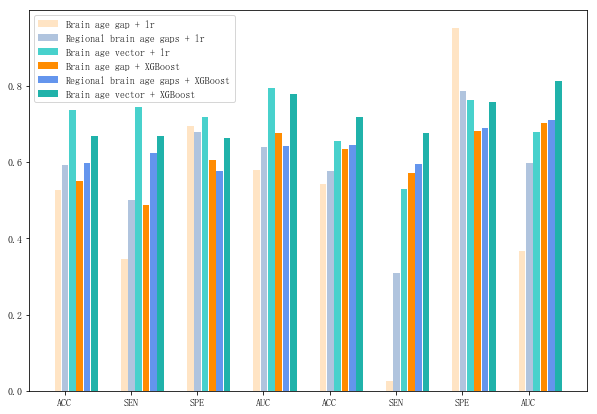

<Figure size 2400x1600 with 0 Axes>

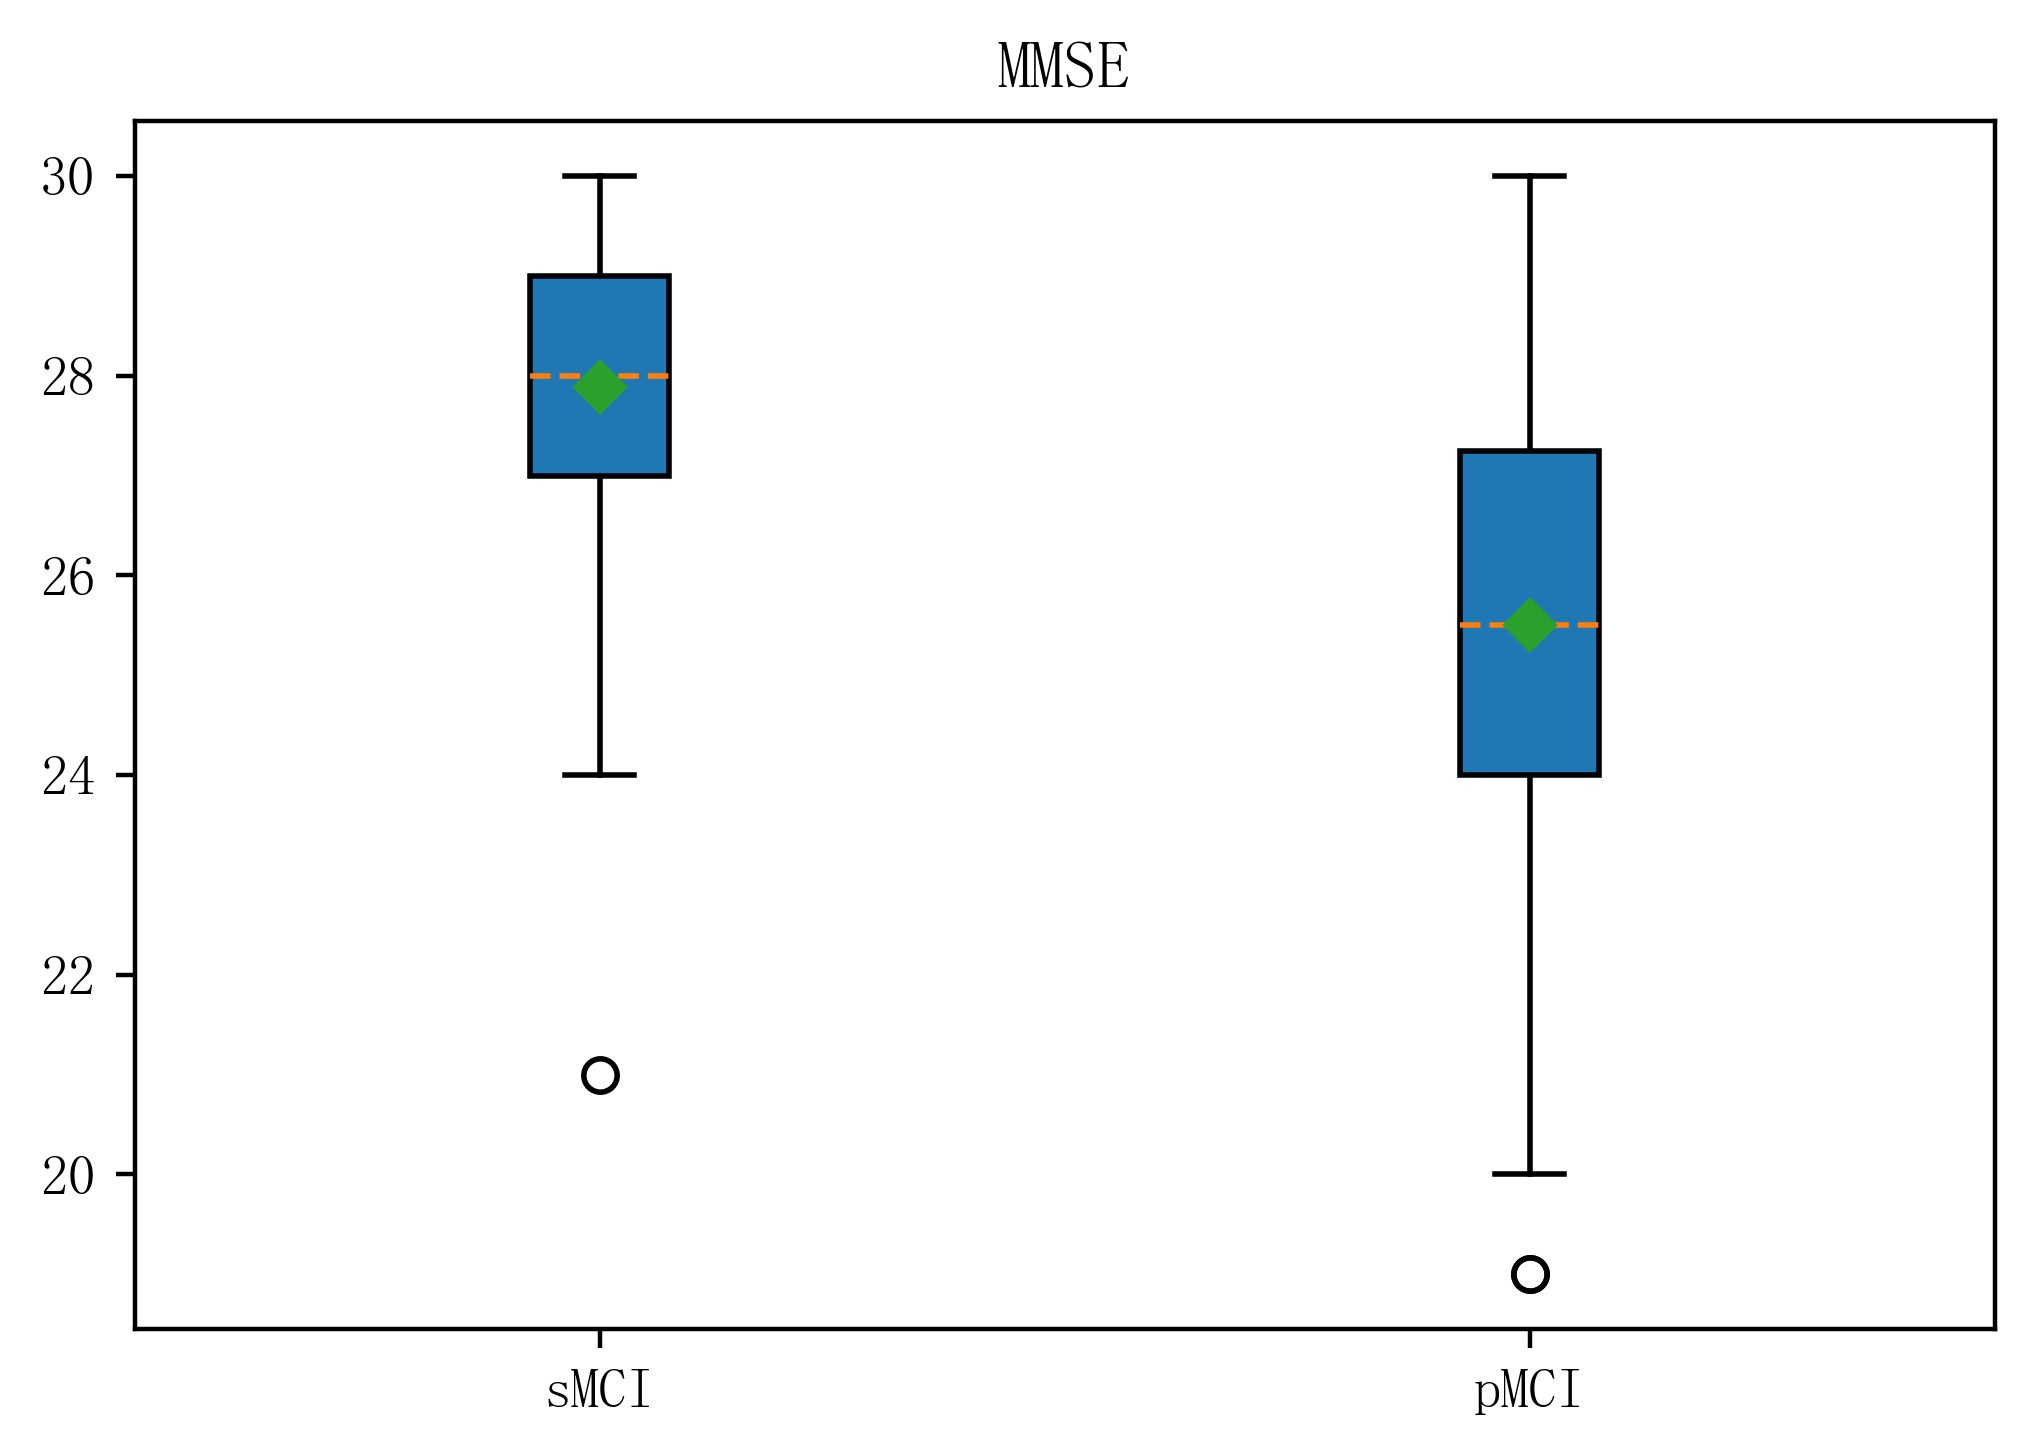

In [65]:
data1 = pd.read_csv(r"D:\rc\paper\csv\data5\scale_sMCI.csv")
data2 = pd.read_csv(r"D:\rc\paper\csv\data5\scale_pMCI.csv")

HC = data1['MMSE']
PD = data2['MMSE']

print("The mean gap of sMCI :", np.mean(HC))
print("The mean gap of pMCI :", np.mean(PD))

print("The tukey HSD between sMCI and pMCI :", get_p(HC,PD))

plt.figure(dpi=400)
plt.boxplot(x = [HC,PD], # 指定绘图数据
            patch_artist=True, # 要求用自定义颜色填充盒形图，默认白色填充
            labels=['sMCI','pMCI'],
            showmeans=True, # 以点的形式显示均值
            boxprops = {'color':'black'}, # 设置箱体属性，填充色和边框色
            flierprops = {'marker':'o'}, # 设置异常值属性，点的形状、填充色和边框色
            meanprops = {'marker':'D'}, # 设置均值点的属性，点的形状、填充色
            medianprops = {'linestyle':'--'}) # 设置中位数线的属性，线的类型和颜色
 
# 去除箱线图的上边框与右边框的刻度标签
plt.tick_params(top='off', right='off')
plt.title('MMSE')
# plt.title('brain age gap',fontsize=11)
# plt.xticks(fontsize=11)
# plt.yticks(fontsize=11)
# plt.xlabel('实际年龄', fontsize=15)
# plt.ylabel('gap/year')
# plt.subplots_adjust(left=0.15)
# plt.legend(fontsize=20)
# plt.savefig(r"D:\rc\paper\figure1\fig2.png", dpi=400)
plt.show()                 

In [89]:
subj = pd.read_csv(r"D:\rc\paper\csv\data5\filter_prodromal_baseline.csv")
info = pd.read_csv(r"D:\rc\paper\csv\data5\baseline_prodromal_8_21_2021.csv")
info = pd.merge(subj[['name','age','sex']], info[['name','Subject','Group']], on='name')
info['PATNO'] = info['Subject']

UPDRS1 = pd.read_csv(r"D:\rc\paper\csv\data5\MDS_UPDRS_Part_I.csv") 
UPDRS1 = UPDRS1[UPDRS1['EVENT_ID']=='BL']
UPDRS11 = pd.read_csv(r"D:\rc\paper\csv\data5\MDS_UPDRS_Part_I__Patient_Questionnaire.csv")
UPDRS11 = UPDRS11[UPDRS11['EVENT_ID']=='BL']
UPDRS1 = pd.merge(UPDRS1, UPDRS11, on='PATNO')
fea1 = ['NP1COG','NP1HALL','NP1DPRS','NP1ANXS','NP1APAT','NP1DDS','NP1SLPN','NP1SLPD','NP1PAIN','NP1URIN','NP1CNST','NP1LTHD','NP1FATG']
UPDRS1['UPDRS1'] = UPDRS1[fea1].sum(axis=1)
UPDRS1 = UPDRS1[['PATNO','UPDRS1']]
print(UPDRS1)


UPDRS2 = pd.read_csv(r"D:\rc\paper\csv\data5\MDS_UPDRS_Part_II__Patient_Questionnaire.csv")
UPDRS2 = UPDRS2[UPDRS2['EVENT_ID']=='BL']
fea2 = ['NP2SPCH','NP2SALV','NP2SWAL','NP2EAT','NP2DRES','NP2HYGN','NP2HWRT','NP2HOBB','NP2TURN','NP2TRMR','NP2RISE','NP2WALK','NP2FREZ']
UPDRS2['UPDRS2'] = UPDRS2[fea2].sum(axis=1)
UPDRS2 = UPDRS2[['PATNO','UPDRS2']]
scale = pd.merge(UPDRS1, UPDRS2, on='PATNO')
print(scale)

UPDRS3 = pd.read_csv(r"C:\Users\Lenovo\Downloads\MDS_UPDRS_Part_III.csv")
UPDRS3 = UPDRS3[UPDRS3['EVENT_ID']=='BL']
fea3 = ['NP3SPCH','NP3FACXP','NP3RIGN','NP3RIGRU','NP3RIGLU','PN3RIGRL','NP3RIGLL','NP3FTAPR','NP3FTAPL','NP3HMOVR','NP3HMOVL','NP3PRSPR','NP3PRSPL','NP3TTAPR','NP3TTAPL','NP3LGAGR','NP3LGAGL','NP3RISNG','NP3GAIT','NP3FRZGT','NP3PSTBL','NP3POSTR','NP3BRADY','NP3PTRMR','NP3PTRML','NP3KTRMR','NP3KTRML','NP3RTARU','NP3RTALU','NP3RTARL','NP3RTALL','NP3RTALJ','NP3RTCON']
UPDRS3['UPDRS3'] = UPDRS3[fea3].sum(axis=1)
UPDRS3 = UPDRS3[['PATNO','UPDRS3']]
scale = pd.merge(scale, UPDRS3, on='PATNO')
print(scale)

fea = ['UPDRS1','UPDRS2','UPDRS3']
scale['UPDRS-Total'] = scale[fea].sum(axis=1)
print(scale)

# MoCA = pd.read_csv(r"D:\rc\paper\csv\data5\Montreal_Cognitive_Assessment__MoCA_.csv")
# MoCA = MoCA[MoCA['EVENT_ID']=='BL']
# MoCA = MoCA[['PATNO','MCATOT']]
# scale = pd.merge(scale, MoCA, on='PATNO')
# print(scale)

ESS = pd.read_csv(r"D:\rc\paper\csv\data5\Epworth_Sleepiness_Scale.csv")
ESS = ESS[ESS['EVENT_ID']=='BL']
fea4 = ['ESS1','ESS2','ESS3','ESS4','ESS5','ESS6','ESS7','ESS8']
ESS['ESS'] = ESS[fea4].sum(axis=1)
ESS = ESS[['PATNO','ESS']]
scale = pd.merge(scale, ESS, on='PATNO')
print(scale)

RBDSQ = pd.read_csv(r"D:\rc\paper\csv\data5\REM_Sleep_Disorder_Questionnaire.csv")
RBDSQ = RBDSQ[RBDSQ['EVENT_ID']=='BL']
fea5 = ['DRMVIVID','DRMAGRAC','DRMNOCTB','SLPLMBMV','SLPINJUR','DRMVERBL','DRMFIGHT','DRMUMV','DRMOBJFL','MVAWAKEN','DRMREMEM','SLPDSTRB']
fea6 = ['STROKE','HETRA','PARKISM','RLS','NARCLPSY','DEPRS','EPILEPSY','RNINFM','CNSOTH']
RBDSQ['RBDSQ'] = RBDSQ[fea5].sum(axis=1)
RBDSQ = RBDSQ.reset_index(drop=True)
for i in range(np.shape(RBDSQ)[0]):
    if RBDSQ.loc[i,fea6].sum() >= 1:
        RBDSQ.loc[i,'RBDSQ'] =  RBDSQ.loc[i,'RBDSQ'] + 1
RBDSQ = RBDSQ[['PATNO','RBDSQ']]
scale = pd.merge(scale, RBDSQ, on='PATNO')
print(scale)

SCOPA = pd.read_csv(r"D:\rc\paper\csv\data5\SCOPA-AUT.csv")
SCOPA = SCOPA[SCOPA['EVENT_ID']=='BL']
SCOPA = SCOPA.reset_index(drop=True)
fea7 = ['SCAU1','SCAU2','SCAU3','SCAU4','SCAU5','SCAU6','SCAU7','SCAU8','SCAU9','SCAU10','SCAU11','SCAU12','SCAU13','SCAU14','SCAU15','SCAU16','SCAU17','SCAU18','SCAU19','SCAU20','SCAU21']
fea8 = ['SCAU22','SCAU23','SCAU24','SCAU25']
fea9 = ['SCAU1','SCAU2','SCAU3','SCAU4','SCAU5','SCAU6','SCAU7','SCAU8','SCAU9','SCAU10','SCAU11','SCAU12','SCAU13','SCAU14','SCAU15','SCAU16','SCAU17','SCAU18','SCAU19','SCAU20','SCAU21','SCAU22','SCAU23','SCAU24','SCAU25']
for i in range(np.shape(SCOPA)[0]):
    for f in fea7:
        if SCOPA.loc[i,f] == 9:
            SCOPA.loc[i,f] = 3
    for f in fea8:
        if SCOPA.loc[i,f] == 9:
            SCOPA.loc[i,f] = 0
SCOPA['SCOPA'] = SCOPA[fea9].sum(axis=1)
SCOPA = SCOPA[['PATNO','SCOPA']]
scale = pd.merge(scale, SCOPA, on='PATNO')
print(scale)

info = pd.merge(info, scale, on='PATNO')
print(info) 
info.to_csv(r"D:\rc\paper\csv\data5\scale_prodromal.csv", index=False)

      PATNO  UPDRS1
0     10874     0.0
1     12224     4.0
2     12499     8.0
3     12593     2.0
4     13039     2.0
5     13424     4.0
6     14281     2.0
7     14331     6.0
8     14426     3.0
9     15761     4.0
10    16580    10.0
11    16644     0.0
12    16785    11.0
13    17608     3.0
14    18026     7.0
15    18491     6.0
16    18502     4.0
17    18567     6.0
18     3000     6.0
19     3001     8.0
20     3002     8.0
21     3003    12.0
22     3004     2.0
23     3006     3.0
24     3007     8.0
25     3008     8.0
26     3009     7.0
27     3010    11.0
28     3011     1.0
29     3012    11.0
...     ...     ...
1892  75447     1.0
1893  75450     5.0
1894  75454     4.0
1895  75465     6.0
1896  75479     4.0
1897  75480     6.0
1898  75484     3.0
1899  75485    10.0
1900  75492     4.0
1901  75496     6.0
1902  75503     2.0
1903  75505     8.0
1904  75508     1.0
1905  75512     4.0
1906  75520     4.0
1907  75524     7.0
1908  75525     8.0
1909  75547     2.0


C:\Users\Lenovo\Anaconda3\lib\site-packages\pandas\core\indexing.py:1017: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


      PATNO  UPDRS1  UPDRS2  UPDRS3  UPDRS-Total   ESS  RBDSQ
0     10874     0.0     0.0     0.0          0.0   2.0    2.0
1     12224     4.0     0.0     0.0          4.0   6.0    5.0
2     12499     8.0     2.0     0.0         10.0   9.0    7.0
3     12593     2.0     0.0     1.0          3.0  10.0    4.0
4     13039     2.0     3.0     2.0          7.0   2.0    1.0
5     13424     4.0     3.0     7.0         14.0   3.0    2.0
6     14281     2.0     1.0     1.0          4.0   5.0   11.0
7     14331     6.0     2.0     3.0         11.0   2.0    1.0
8     14426     3.0     9.0    13.0         25.0   1.0    8.0
9     15761     4.0     0.0     1.0          5.0   3.0    2.0
10    16580    10.0     6.0    10.0         26.0   7.0    3.0
11    16644     0.0     0.0     0.0          0.0   6.0    7.0
12    16785    11.0     7.0     3.0         21.0  17.0    8.0
13    17608     3.0     0.0     5.0          8.0   4.0    4.0
14    18026     7.0     3.0     8.0         18.0   7.0   11.0
15    18

In [92]:
subj = pd.read_csv(r"D:\rc\paper\csv\data5\filter_HC_baseline.csv")
info = pd.read_csv(r"D:\rc\paper\csv\data5\baselineHC_MPRAGE_8_12_2021.csv")
info = pd.merge(subj[['name','age','sex']], info[['name','Subject','Group']], on='name')
info['PATNO'] = info['Subject']

UPDRS1 = pd.read_csv(r"D:\rc\paper\csv\data5\MDS_UPDRS_Part_I.csv") 
UPDRS1 = UPDRS1[UPDRS1['EVENT_ID']=='BL']
UPDRS11 = pd.read_csv(r"D:\rc\paper\csv\data5\MDS_UPDRS_Part_I__Patient_Questionnaire.csv")
UPDRS11 = UPDRS11[UPDRS11['EVENT_ID']=='BL']
UPDRS1 = pd.merge(UPDRS1, UPDRS11, on='PATNO')
fea1 = ['NP1COG','NP1HALL','NP1DPRS','NP1ANXS','NP1APAT','NP1DDS','NP1SLPN','NP1SLPD','NP1PAIN','NP1URIN','NP1CNST','NP1LTHD','NP1FATG']
UPDRS1['UPDRS1'] = UPDRS1[fea1].sum(axis=1)
UPDRS1 = UPDRS1[['PATNO','UPDRS1']]
print(UPDRS1)


UPDRS2 = pd.read_csv(r"D:\rc\paper\csv\data5\MDS_UPDRS_Part_II__Patient_Questionnaire.csv")
UPDRS2 = UPDRS2[UPDRS2['EVENT_ID']=='BL']
fea2 = ['NP2SPCH','NP2SALV','NP2SWAL','NP2EAT','NP2DRES','NP2HYGN','NP2HWRT','NP2HOBB','NP2TURN','NP2TRMR','NP2RISE','NP2WALK','NP2FREZ']
UPDRS2['UPDRS2'] = UPDRS2[fea2].sum(axis=1)
UPDRS2 = UPDRS2[['PATNO','UPDRS2']]
scale = pd.merge(UPDRS1, UPDRS2, on='PATNO')
print(scale)

UPDRS3 = pd.read_csv(r"C:\Users\Lenovo\Downloads\MDS_UPDRS_Part_III.csv")
UPDRS3 = UPDRS3[UPDRS3['EVENT_ID']=='BL']
fea3 = ['NP3SPCH','NP3FACXP','NP3RIGN','NP3RIGRU','NP3RIGLU','PN3RIGRL','NP3RIGLL','NP3FTAPR','NP3FTAPL','NP3HMOVR','NP3HMOVL','NP3PRSPR','NP3PRSPL','NP3TTAPR','NP3TTAPL','NP3LGAGR','NP3LGAGL','NP3RISNG','NP3GAIT','NP3FRZGT','NP3PSTBL','NP3POSTR','NP3BRADY','NP3PTRMR','NP3PTRML','NP3KTRMR','NP3KTRML','NP3RTARU','NP3RTALU','NP3RTARL','NP3RTALL','NP3RTALJ','NP3RTCON']
UPDRS3['UPDRS3'] = UPDRS3[fea3].sum(axis=1)
UPDRS3 = UPDRS3[['PATNO','UPDRS3']]
scale = pd.merge(scale, UPDRS3, on='PATNO')
print(scale)

fea = ['UPDRS1','UPDRS2','UPDRS3']
scale['UPDRS-Total'] = scale[fea].sum(axis=1)
print(scale)

# MoCA = pd.read_csv(r"D:\rc\paper\csv\data5\Montreal_Cognitive_Assessment__MoCA_.csv")
# MoCA = MoCA[MoCA['EVENT_ID']=='BL']
# MoCA = MoCA[['PATNO','MCATOT']]
# scale = pd.merge(scale, MoCA, on='PATNO')
# print(scale)

ESS = pd.read_csv(r"D:\rc\paper\csv\data5\Epworth_Sleepiness_Scale.csv")
ESS = ESS[ESS['EVENT_ID']=='BL']
fea4 = ['ESS1','ESS2','ESS3','ESS4','ESS5','ESS6','ESS7','ESS8']
ESS['ESS'] = ESS[fea4].sum(axis=1)
ESS = ESS[['PATNO','ESS']]
scale = pd.merge(scale, ESS, on='PATNO')
print(scale)

RBDSQ = pd.read_csv(r"D:\rc\paper\csv\data5\REM_Sleep_Disorder_Questionnaire.csv")
RBDSQ = RBDSQ[RBDSQ['EVENT_ID']=='BL']
fea5 = ['DRMVIVID','DRMAGRAC','DRMNOCTB','SLPLMBMV','SLPINJUR','DRMVERBL','DRMFIGHT','DRMUMV','DRMOBJFL','MVAWAKEN','DRMREMEM','SLPDSTRB']
fea6 = ['STROKE','HETRA','PARKISM','RLS','NARCLPSY','DEPRS','EPILEPSY','RNINFM','CNSOTH']
RBDSQ['RBDSQ'] = RBDSQ[fea5].sum(axis=1)
RBDSQ = RBDSQ.reset_index(drop=True)
for i in range(np.shape(RBDSQ)[0]):
    if RBDSQ.loc[i,fea6].sum() >= 1:
        RBDSQ.loc[i,'RBDSQ'] =  RBDSQ.loc[i,'RBDSQ'] + 1
RBDSQ = RBDSQ[['PATNO','RBDSQ']]
scale = pd.merge(scale, RBDSQ, on='PATNO')
print(scale)

SCOPA = pd.read_csv(r"D:\rc\paper\csv\data5\SCOPA-AUT.csv")
SCOPA = SCOPA[SCOPA['EVENT_ID']=='BL']
SCOPA = SCOPA.reset_index(drop=True)
fea7 = ['SCAU1','SCAU2','SCAU3','SCAU4','SCAU5','SCAU6','SCAU7','SCAU8','SCAU9','SCAU10','SCAU11','SCAU12','SCAU13','SCAU14','SCAU15','SCAU16','SCAU17','SCAU18','SCAU19','SCAU20','SCAU21']
fea8 = ['SCAU22','SCAU23','SCAU24','SCAU25']
fea9 = ['SCAU1','SCAU2','SCAU3','SCAU4','SCAU5','SCAU6','SCAU7','SCAU8','SCAU9','SCAU10','SCAU11','SCAU12','SCAU13','SCAU14','SCAU15','SCAU16','SCAU17','SCAU18','SCAU19','SCAU20','SCAU21','SCAU22','SCAU23','SCAU24','SCAU25']
for i in range(np.shape(SCOPA)[0]):
    for f in fea7:
        if SCOPA.loc[i,f] == 9:
            SCOPA.loc[i,f] = 3
    for f in fea8:
        if SCOPA.loc[i,f] == 9:
            SCOPA.loc[i,f] = 0
SCOPA['SCOPA'] = SCOPA[fea9].sum(axis=1)
SCOPA = SCOPA[['PATNO','SCOPA']]
scale = pd.merge(scale, SCOPA, on='PATNO')
print(scale)

info = pd.merge(info, scale, on='PATNO')
print(info) 
info.to_csv(r"D:\rc\paper\csv\data5\scale_HC.csv", index=False)

      PATNO  UPDRS1
0     10874     0.0
1     12224     4.0
2     12499     8.0
3     12593     2.0
4     13039     2.0
5     13424     4.0
6     14281     2.0
7     14331     6.0
8     14426     3.0
9     15761     4.0
10    16580    10.0
11    16644     0.0
12    16785    11.0
13    17608     3.0
14    18026     7.0
15    18491     6.0
16    18502     4.0
17    18567     6.0
18     3000     6.0
19     3001     8.0
20     3002     8.0
21     3003    12.0
22     3004     2.0
23     3006     3.0
24     3007     8.0
25     3008     8.0
26     3009     7.0
27     3010    11.0
28     3011     1.0
29     3012    11.0
...     ...     ...
1892  75447     1.0
1893  75450     5.0
1894  75454     4.0
1895  75465     6.0
1896  75479     4.0
1897  75480     6.0
1898  75484     3.0
1899  75485    10.0
1900  75492     4.0
1901  75496     6.0
1902  75503     2.0
1903  75505     8.0
1904  75508     1.0
1905  75512     4.0
1906  75520     4.0
1907  75524     7.0
1908  75525     8.0
1909  75547     2.0


C:\Users\Lenovo\Anaconda3\lib\site-packages\pandas\core\indexing.py:1017: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


      PATNO  UPDRS1  UPDRS2  UPDRS3  UPDRS-Total   ESS  RBDSQ
0     10874     0.0     0.0     0.0          0.0   2.0    2.0
1     12224     4.0     0.0     0.0          4.0   6.0    5.0
2     12499     8.0     2.0     0.0         10.0   9.0    7.0
3     12593     2.0     0.0     1.0          3.0  10.0    4.0
4     13039     2.0     3.0     2.0          7.0   2.0    1.0
5     13424     4.0     3.0     7.0         14.0   3.0    2.0
6     14281     2.0     1.0     1.0          4.0   5.0   11.0
7     14331     6.0     2.0     3.0         11.0   2.0    1.0
8     14426     3.0     9.0    13.0         25.0   1.0    8.0
9     15761     4.0     0.0     1.0          5.0   3.0    2.0
10    16580    10.0     6.0    10.0         26.0   7.0    3.0
11    16644     0.0     0.0     0.0          0.0   6.0    7.0
12    16785    11.0     7.0     3.0         21.0  17.0    8.0
13    17608     3.0     0.0     5.0          8.0   4.0    4.0
14    18026     7.0     3.0     8.0         18.0   7.0   11.0
15    18

In [94]:
data1 = pd.read_csv(r"D:\rc\paper\csv\data5\norm_cleaned_rel_volume_train.csv")
data2 = pd.read_csv(r"D:\rc\paper\csv\data5\norm_cleaned_rel_volume_test.csv")
data1 = data1.drop(index=data1[data1['sites']==2].index)
data2 = data2.drop(index=data2[data2['sites']==2].index)
data1.to_csv(r"D:\rc\paper\csv\data5\train.csv", index=False)
data2.to_csv(r"D:\rc\paper\csv\data5\test.csv", index=False)

In [4]:
data1 = pd.read_csv(r"D:\rc\paper\csv\data5\norm_cleaned_rel_volume_train.csv")
data2 = pd.read_csv(r"D:\rc\paper\csv\data5\norm_cleaned_rel_volume_test.csv")
data = pd.concat([data1,data2]).reset_index(drop=True)
data1 = data1.drop(index=data1[data1['sites']==2].index)
print(np.mean(data1['age']))

59.51631877990431


In [3]:
dat = data[data['sites']==5]
f = dat[dat['sex']==0]
m = dat[dat['sex']==1]
print(np.shape(dat)[0])
print(np.shape(f)[0])
print(np.shape(m)[0])
print(np.mean(dat['age']))
print(np.std(dat['age']))

8648
4528
4120
60.97924491211853
15.665194534893667


In [117]:
data = pd.read_csv(r"D:\rc\paper\csv\data5\filter_prodromal_baseline.csv")
f = data[data['sex']==0]
m = data[data['sex']==1]
print(np.shape(data)[0])
print(np.shape(f)[0])
print(np.shape(m)[0])
print(np.mean(data['age']))
print(np.std(data['age']))

42
8
34
68.42857142857143
6.024327099917692


In [121]:
data = pd.read_csv(r"D:\rc\paper\csv\data5\scale_pMCI.csv")
print(np.mean(data['MMSE']), np.std(data['MMSE'])) 
print(np.mean(data['CDR']), np.std(data['CDR']))


25.5 2.378287198805056
0.5078125 0.062009796353076345


In [124]:
data = pd.read_csv(r"D:\rc\paper\csv\data5\scale_prodromal.csv")
print(np.mean(data['UPDRS1']), np.std(data['UPDRS1'])) 
print(np.mean(data['UPDRS2']), np.std(data['UPDRS2']))
print(np.mean(data['UPDRS3']), np.std(data['UPDRS3'])) 
print(np.mean(data['UPDRS-Total']), np.std(data['UPDRS-Total']))
print(np.mean(data['ESS']), np.std(data['ESS'])) 
print(np.mean(data['RBDSQ']), np.std(data['RBDSQ']))
print(np.mean(data['SCOPA']), np.std(data['SCOPA']))

5.928571428571429 3.6344440666310147
2.2142857142857144 2.7562544830821047
4.428571428571429 4.186957397072241
12.571428571428571 8.3726961497672
6.785714285714286 3.863971028468451
7.095238095238095 3.8347379857691895
11.928571428571429 7.038644543291181


In [129]:
data1 = pd.read_csv(r"D:\rc\paper\csv\data5\scale_HC.csv")
data2 = pd.read_csv(r"D:\rc\paper\csv\data5\scale_prodromal.csv")
print(get_p(data1['UPDRS1'], data2['UPDRS1']))
print(get_p(data1['UPDRS2'], data2['UPDRS2']))
print(get_p(data1['UPDRS3'], data2['UPDRS3']))
print(get_p(data1['UPDRS-Total'], data2['UPDRS-Total']))
print(get_p(data1['ESS'], data2['ESS']))
print(get_p(data1['RBDSQ'], data2['RBDSQ']))
print(get_p(data1['SCOPA'], data2['SCOPA']))


0.001
0.001
0.001
0.001
0.06840899093125896
0.001
0.001


The mean gap of sMCI : -1.2447104277434173 7.534818536708533
The mean gap of pMCI : 0.37483324323381695 5.583776121049939
The tukey HSD between sMCI and pMCI : 0.2514968215648373


C:\Users\Lenovo\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
C:\Users\Lenovo\Anaconda3\lib\site-packages\matplotlib\figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


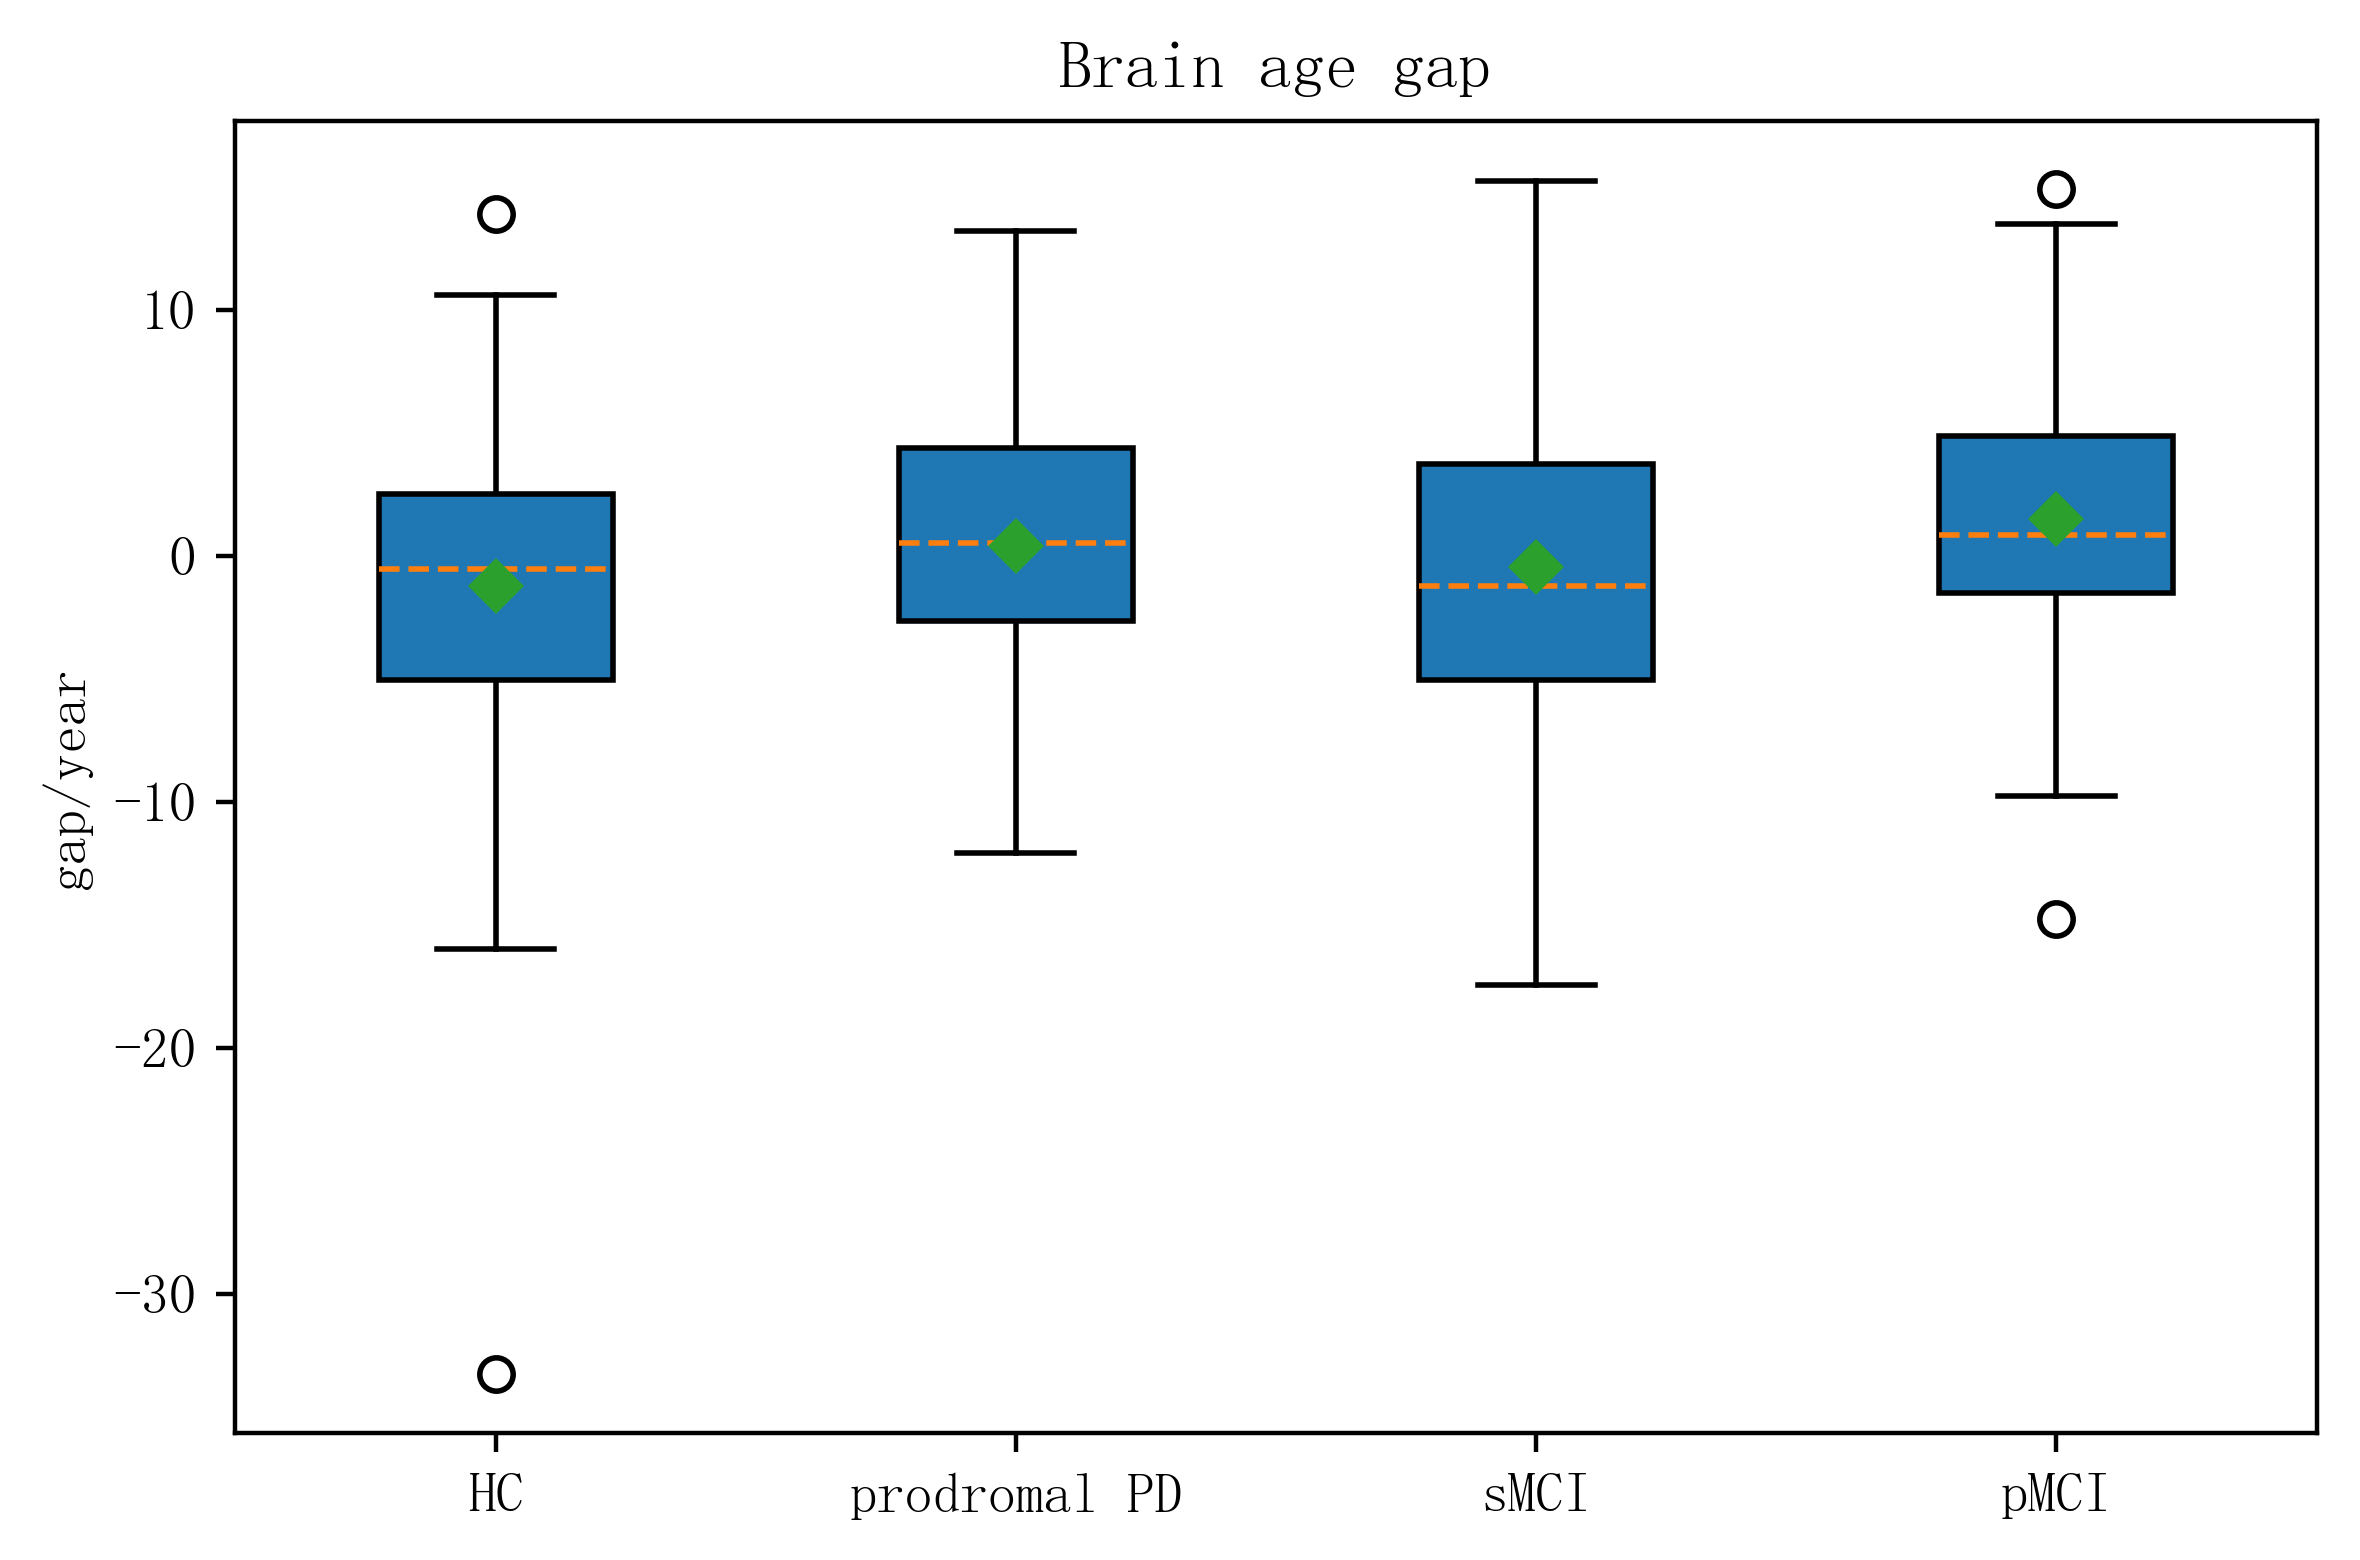

In [25]:
###########################HC/RBD/PD脑龄预测
config = {
    "font.family":'serif',
    "font.size": 10,
    "mathtext.fontset": 'stix',
    "font.serif": ['SimSun'],

}
mpl.rcParams.update(config)

data1 = pd.read_csv(r"D:\rc\paper\csv\data5\filter_HC_baseline.csv")
data2 = pd.read_csv(r"D:\rc\paper\csv\data5\filter_prodromal_baseline.csv")
data3 = pd.read_csv(r"D:\rc\paper\csv\data5\sMCI_1styear.csv")
data4 = pd.read_csv(r"D:\rc\paper\csv\data5\pMCI_1yearsbefore.csv")

data_ls = [data1,data2,data3,data4]

for data in data_ls:
    X_test = data.drop(columns=['name','age'])
    y_test = data['age']
#     y_pred = np.zeros(len(y_test))
    model = joblib.load(r"D:\rc\paper\model\nonorm_paper_model_corr.m")
    y_pred = model.predict(X_test)
#     y_pred = y_pred + y_pre
    data['bias'] = y_pred - y_test

HC = data_ls[0]['bias']
PD = data_ls[1]['bias']
sMCI = data_ls[2]['bias']
pMCI = data_ls[3]['bias']

# data = pd.DataFrame()
# data['sMCI'] = HC
# data['pMCI'] = PD

# plt.figure(dpi=400)
# sns.kdeplot(data['sMCI'], shade=True, color='g')
# sns.kdeplot(data['pMCI'], shade=True, color='r')
# plt.title('Brain age gap distribution for AD group')
# plt.show()

print("The mean gap of sMCI :", np.mean(HC), np.std(HC))
print("The mean gap of pMCI :", np.mean(PD), np.std(PD))

print("The tukey HSD between sMCI and pMCI :", get_p(HC,PD))

plt.figure(dpi=400)
plt.boxplot(x = [HC,PD,sMCI,pMCI], # 指定绘图数据
            patch_artist=True, # 要求用自定义颜色填充盒形图，默认白色填充
            labels=['HC','prodromal PD','sMCI','pMCI'],
            showmeans=True, # 以点的形式显示均值
            boxprops = {'color':'black'}, # 设置箱体属性，填充色和边框色
            flierprops = {'marker':'o'}, # 设置异常值属性，点的形状、填充色和边框色
            meanprops = {'marker':'D'}, # 设置均值点的属性，点的形状、填充色
            medianprops = {'linestyle':'--'}) # 设置中位数线的属性，线的类型和颜色
 
# 去除箱线图的上边框与右边框的刻度标签
plt.title('Brain age gap')
plt.tick_params(top='off', right='off')
# plt.title('brain age gap',fontsize=11)
# plt.xticks(fontsize=11)
# plt.yticks(fontsize=11)
# plt.xlabel('实际年龄', fontsize=15)
plt.ylabel('gap/year')
# plt.subplots_adjust(left=0.15)
# plt.legend(fontsize=20)
# plt.savefig(r"D:\rc\paper\figure1\fig2.png", dpi=400)
# plt.legend([(r'HC vs. prodromal PD: p={:.3f}' + '\n' + r'sMCI vs. pMCI: p={:.3f}').format(get_p(HC,PD), get_p(sMCI,pMCI))])
plt.savefig(r"D:\rc\paper\fig\brain age gap.png", dpi=400)
plt.show()                 

In [5]:
data = pd.read_csv(r"D:\rc\paper\csv\data5\shap_values_pMCI.csv")
pmatrix = np.zeros(shape=(95,95))
for i in range(95):
    for j in range(95):
        pmatrix[i,j] = get_p(data.ix[:,i], data.ix[:,j])

C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [6]:
print(pmatrix)

[[0.9        0.001      0.01988253 ... 0.001      0.001      0.001     ]
 [0.001      0.9        0.00126997 ... 0.001      0.18572221 0.001     ]
 [0.01988253 0.00126997 0.9        ... 0.001      0.001      0.001     ]
 ...
 [0.001      0.001      0.001      ... 0.9        0.41159371 0.001     ]
 [0.001      0.18572221 0.001      ... 0.41159371 0.9        0.001     ]
 [0.001      0.001      0.001      ... 0.001      0.001      0.9       ]]


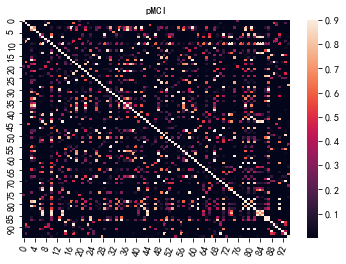

In [24]:
cols = data.drop(columns=['sex','GM','WM','CSF']).columns
# hm = sns.heatmap(pmatrix, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':3}, yticklabels=cols, xticklabels=cols)
hm = sns.heatmap(pmatrix, cbar=True)
# # 设置刻度字体大小
# plt.xticks(fontsize=3)
# plt.yticks(fontsize=3)
# # 设置坐标标签字体大小
# plt.subplots_adjust(left=0.15, bottom=0.15, right=0.9, top=0.9)
# # plt.xlabel('年龄', fontsize=11)
# # plt.ylabel('频率', fontsize=11)
plt.title('pMCI', fontsize=11)
plt.xticks(rotation=70)
plt.savefig(r"D:\rc\paper\fig\pmatrix_pMCI.png", dpi=400)
plt.show()

In [18]:
data = pd.read_csv(r"D:\rc\paper\csv\data5\shap_values_sMCI.csv")
pmatrix1 = np.zeros(shape=(95,95))
for i in range(95):
    for j in range(95):
        pmatrix1[i,j] = get_p(data.ix[:,i], data.ix[:,j])

C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


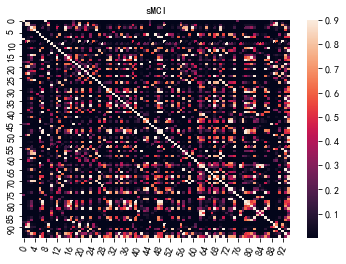

In [25]:
cols = data.drop(columns=['sex','GM','WM','CSF']).columns
# hm = sns.heatmap(pmatrix, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':3}, yticklabels=cols, xticklabels=cols)
hm = sns.heatmap(pmatrix1, cbar=True)
# # 设置刻度字体大小
# plt.xticks(fontsize=3)
# plt.yticks(fontsize=3)
# # 设置坐标标签字体大小
# plt.subplots_adjust(left=0.15, bottom=0.15, right=0.9, top=0.9)
# # plt.xlabel('年龄', fontsize=11)
# # plt.ylabel('频率', fontsize=11)
plt.title('sMCI', fontsize=11)
plt.xticks(rotation=70)
plt.savefig(r"D:\rc\paper\fig\pmatrix_sMCI.png", dpi=400)
plt.show()

In [20]:
data = pd.read_csv(r"D:\rc\paper\csv\data5\shap_values_HC.csv")
pmatrix2 = np.zeros(shape=(95,95))
for i in range(95):
    for j in range(95):
        pmatrix2[i,j] = get_p(data.ix[:,i], data.ix[:,j])

C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


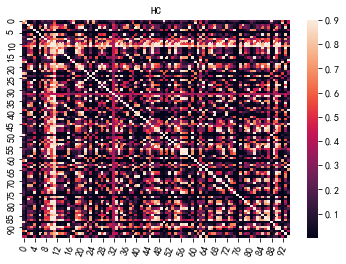

In [26]:
cols = data.drop(columns=['sex','GM','WM','CSF']).columns
# hm = sns.heatmap(pmatrix, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':3}, yticklabels=cols, xticklabels=cols)
hm = sns.heatmap(pmatrix2, cbar=True)
# # 设置刻度字体大小
# plt.xticks(fontsize=3)
# plt.yticks(fontsize=3)
# # 设置坐标标签字体大小
# plt.subplots_adjust(left=0.15, bottom=0.15, right=0.9, top=0.9)
# # plt.xlabel('年龄', fontsize=11)
# # plt.ylabel('频率', fontsize=11)
plt.title('HC', fontsize=11)
plt.xticks(rotation=70)
plt.savefig(r"D:\rc\paper\fig\pmatrix_HC.png", dpi=400)
plt.show()

In [22]:
data = pd.read_csv(r"D:\rc\paper\csv\data5\shap_values_prodromal.csv")
pmatrix3 = np.zeros(shape=(95,95))
for i in range(95):
    for j in range(95):
        pmatrix3[i,j] = get_p(data.ix[:,i], data.ix[:,j])

C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


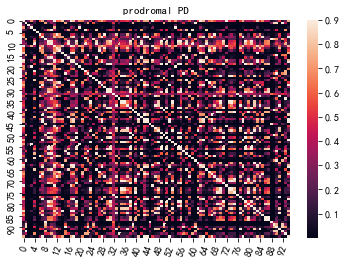

In [27]:
cols = data.drop(columns=['sex','GM','WM','CSF']).columns
# hm = sns.heatmap(pmatrix, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':3}, yticklabels=cols, xticklabels=cols)
hm = sns.heatmap(pmatrix3, cbar=True)
# # 设置刻度字体大小
# plt.xticks(fontsize=3)
# plt.yticks(fontsize=3)
# # 设置坐标标签字体大小
# plt.subplots_adjust(left=0.15, bottom=0.15, right=0.9, top=0.9)
# # plt.xlabel('年龄', fontsize=11)
# # plt.ylabel('频率', fontsize=11)
plt.title('prodromal PD', fontsize=11)
plt.xticks(rotation=70)
plt.savefig(r"D:\rc\paper\fig\pmatrix_prodromal.png", dpi=400)
plt.show()

In [28]:
data = pd.read_csv(r"D:\rc\paper\csv\data5\shap_values_pMCI.csv")
count = 0
for i in range(95):
    for j in range(i+1, 95):
        if get_p(data.ix[:,i], data.ix[:,j]) < 0.05:
            count = count+1
print(count)

C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


3619


In [29]:
data = pd.read_csv(r"D:\rc\paper\csv\data5\shap_values_sMCI.csv")
count1 = 0
for i in range(95):
    for j in range(i+1, 95):
        if get_p(data.ix[:,i], data.ix[:,j]) < 0.05:
            count1 = count1+1
print(count1)

C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


2976


In [30]:
data = pd.read_csv(r"D:\rc\paper\csv\data5\shap_values_HC.csv")
count2 = 0
for i in range(95):
    for j in range(i+1, 95):
        if get_p(data.ix[:,i], data.ix[:,j]) < 0.05:
            count2 = count2+1
print(count2)

C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


1678


In [31]:
data = pd.read_csv(r"D:\rc\paper\csv\data5\shap_values_prodromal.csv")
count3 = 0
for i in range(95):
    for j in range(i+1, 95):
        if get_p(data.ix[:,i], data.ix[:,j]) < 0.05:
            count3 = count3+1
print(count3)

C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


1964


In [33]:
data = pd.read_csv(r"D:\rc\paper\csv\data5\shap_values_HC.csv")
count = 0
for i in range(95):
    for j in range(i+1, 95):
        if get_p(data.ix[:,i], data.ix[:,j]) <= 0.001:
            print(data.columns[i], data.columns[j])


C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


Cortical white matter(lh) Thalamus(lh)
Lateral Ventricle(lh) Thalamus(lh)
Lateral Ventricle(lh) Caudate(lh)
Lateral Ventricle(lh) Hippocampus(lh)
Lateral Ventricle(lh) Amygdala(lh)
Lateral Ventricle(lh) Accumbens(lh)
Lateral Ventricle(lh) Hippocampus(rh)
Lateral Ventricle(lh) Accumbens(rh)
Lateral Ventricle(lh) entorhinal(lh)
Lateral Ventricle(lh) fusiform(lh)
Lateral Ventricle(lh) isthmus cingulate(lh)
Lateral Ventricle(lh) lateral occipital(lh)
Lateral Ventricle(lh) superior parietal(lh)
Lateral Ventricle(lh) transverse temporal(lh)
Lateral Ventricle(lh) fusiform(rh)
Lateral Ventricle(lh) lateral occipital(rh)
Lateral Ventricle(lh) parahippocampal(rh)
Lateral Ventricle(lh) paracentral(rh)
Lateral Ventricle(lh) precentral(rh)
Inferior Lateral Ventricle(lh) Thalamus(lh)
Inferior Lateral Ventricle(lh) middle temporal(rh)
Cerebellar White Matter(lh) Thalamus(lh)
Cerebellar White Matter(lh) Putaman(rh)
Cerebellar White Matter(lh) pars triangularis(lh)
Cerebellar White Matter(lh) supramarg